# Modelagem de dados para quatro atividades enzimáticas: fpase, cmcase, beta-glicosidase e xilanase - conjunto de dados todos - seleção de atributos


In [1]:
# criei umas marcações para acesso rápido utilizando @, exemplo @outliers

## Importação de módulos utilizandos durante todo o processamento

In [1]:
#importação de módulos
#@import
import pandas as pd
import numpy as np
import time

#Para plotagens
import matplotlib.pyplot as plt
import seaborn as sns

#Filtro Digital de Savitzky-Golay para suavização dos dados
from scipy.signal import savgol_filter

#pré-processamento:

#Transformação nos dados
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, scale, LabelEncoder
#Seleção de atributos
from sklearn.feature_selection import mutual_info_regression, SelectKBest, SelectPercentile

#particionamento de base de dados para treinamento, validação e teste
from sklearn.model_selection import train_test_split

#algoritmos para o aprendizado:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor

#Métricas para avaliação dos algoritmos de aprendizado
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## FUNÇÕES GERAIS

In [3]:
#@fglobal

### Funções para validação dos modelos multivariados

In [2]:
#@fvalidações
#RMSE
def rmse(ref,pred):
    #recebe como entrada dois vetores dos valores de referência e preditos
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    n=len(ref) #total de amostras
    mse = 0
    for i in range(n):
        mse +=(ref[i]-pred[i])**2
    mse=mse/n
    rmse=np.sqrt(mse)
    return rmse

#bias
def bias(ref,pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    b=0
    n = len(ref)
    for r, p in zip(ref, pred):
        b += (r-p)
    return (b/n)
    
#SEP
def sep(ref,pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    b = bias(ref,pred)
    sep = 0
    n = len(ref)
    for i in range(n):    
        sep +=(ref[i]-pred[i]-b)**2
    sep = np.sqrt(sep/(n-1))
    return sep
    
#RPIQ
def rpiq(ref, pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    q1 = ref.quantile(0.25)
    q3 = ref.quantile(0.75)
    iq=q3-q1
    rpiq = iq/rmse(ref, pred)
    return rpiq
#RPD
def rpd(ref,pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    rpd = np.std(ref)/rmse(ref,pred)
    return rpd

#RER
def rer(ref,pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    rer = (np.max(ref) -np.min(ref) )/sep(ref,pred)
    return rer

#R2
def getr2(ref,pred):
    r2=r2_score(ref,pred)
    return r2
#MSE
def getmse(ref,pred):
    mse = mean_squared_error(ref,pred)
    return mse
#RMSE forma simples de calcular
def getrmse(ref,pred):
    rmse = np.sqrt(mean_squared_error(ref,pred))
    return rmse

### Funções de pré-processamento

In [3]:
#funções gerais de pré-processamento de spectros
#@fspec
#MSC(Multiplicative scatter correction)correção do espalhamento multiplicativo de sinal
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

#Variável normal padrão (SNV) Standard Normal Variate
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

### Função teste para correção de espectros

In [4]:
#@ftestes
def executePreSpec(dados,wint,wtxt):
    x = dados.loc[:,wtxt].values
    w = wint
    
    Xmsc = msc(x)[0] # Take the first element of the output tuple
    Xsnv = snv(x)
    ## Plot spectra
    plt.figure(figsize=(8,9))
    with plt.style.context(('ggplot')):
        ax1 = plt.subplot(311)
        plt.plot(w, x.T)
        plt.title('Original data')
        ax2 = plt.subplot(312)
        plt.plot(w, Xmsc.T)
        plt.ylabel('Absorbance spectra')
        plt.title('MSC')
        ax2 = plt.subplot(313)
        plt.plot(w, Xsnv.T)
        plt.xlabel('Wavelength (nm)')
        plt.title('SNV')
        plt.show()

### Funções para plotar resultados

In [5]:
#@grafResiduos
def graficoResiduos(modelo, treino_teste, y_c, y_cv,y_p):
    #gráfico de resíduos: 
    res_c = treino_teste[2] - y_c #resíduos da calibração
    res_cv = treino_teste[2] - y_cv #residuos da validação
    res_p = treino_teste[3] - y_p #resíduos da predição
    residuos = [res_c, res_cv, res_p]
    ys = [y_c, y_cv, y_p]
    modelos = ['cal','val','pred']
    cores = ['b','r','k']
    cores_ae=['b','g','r','y']
    fig = plt.figure(figsize=(20,20))
    plt.subplots_adjust(hspace = 0.3, wspace=0.2)
    for i,res, m in zip([0,1,2],residuos, modelos):   
        ig = i+1
        for cor,j in zip(cores_ae,[0,1,2,3]):
            ax = fig.add_subplot(4,3,ig)
            ax = sns.residplot(res.iloc[:,j],ys[i][:,j],  color=cor, robust=True,label=var_ae[j])
            ax.set_title(modelo+':Resíduos('+m+')')
            ax.set_xlabel('Preditos')
            ax.set_ylabel('Resíduos')
            plt.legend(loc='best')
            ig+=3

In [6]:
#@grafHistogramas
def graficoHist(modelo, treino_teste, y_c, y_cv,y_p):
    res_c = treino_teste[2] - y_c #resíduos da calibração
    res_cv = treino_teste[2] - y_cv #residuos da validação
    res_p = treino_teste[3] - y_p #resíduos da predição
    #histograma dos resíduos para verificar se segue uma distribuição normal
    #gráfico de resíduos: histograma
    residuos = [res_c, res_cv, res_p]
    modelos = ['cal','val','pred']
    cores = ['b','r','k']
    cores_ae=['b','g','r','y']
    for i,res, m in zip([0,1,2],residuos, modelos):   
        fig = plt.figure(figsize=(20,5))
        plt.subplots_adjust(hspace = 0.5, wspace=0.1)

        for cor,j in zip(cores_ae,[0,1,2,3]):
            ax = fig.add_subplot(1,4,j+1)
            ax = sns.distplot(res.iloc[:,j], color=cores_ae[j], kde=False, label=var_ae[j]);
            ax.set_title(modelo+' :Histograma dos resíduos('+m+')')

In [7]:
#gráfico: reais  x preditos - separando calibração validação predição
#@grafreaispred
def graficoReaisPreditosSep(modelo, treino_teste, y_c, y_cv,y_p):
    res_c = treino_teste[2] #variável resposta da calibração
    res_cv = treino_teste[2] #variável resposta da validação
    res_p = treino_teste[3]#variável resposta da predição
    reais= [res_c, res_cv, res_p]
    ys = [y_c, y_cv, y_p]
    modelos = ['cal','val','pred']
    cores = ['b','r','k']
    cores_ae=['b','g','r','y']
    mark=['x','1','+']
    fig = plt.figure(figsize=(20,20))
    plt.subplots_adjust(hspace = 0.3, wspace=0.2)
    for i,re, m in zip([0,1,2],reais, modelos):   
        ig = i+1
        for cor,j in zip(cores_ae,[0,1,2,3]):
            ax = fig.add_subplot(4,3,ig)
            ax.scatter(re.iloc[:,j], ys[i][:,j],marker=mark[i],c=cores[i], edgecolors='k', label=var_ae[j]+'\n'+m)
            ax.plot(ys[i][:,j], ys[i][:,j], color=cores[i])
            
            ax.set_title(modelo)
            ax.set_xlabel('Reais')
            ax.set_ylabel('Preditos')
            plt.legend(loc='best')
            ig+=3

In [8]:
#gráfico: reais  x preditos - juntando cal, val e predição
#@grafreaispred
def graficoReaisPreditos(modelo, treino_teste, y_c, y_cv,y_p):
    res_c = treino_teste[2] #variável resposta da calibração
    res_cv = treino_teste[2] #variável resposta da validação
    res_p = treino_teste[3]#variável resposta da predição
    reais= [res_c, res_cv, res_p]
    ys = [y_c, y_cv, y_p]
    modelos = ['cal','val','pred']
    cores = ['b','r','k']
    cores_ae=['b','g','r','y']
    mark=['x','1','+']
    fig = plt.figure(figsize=(10,30))
    plt.subplots_adjust(hspace = 0.3, wspace=0.2)
    
    for i in range(4):
        for j in range(3):
            ax = fig.add_subplot(4,1,i+1)
            ax.scatter(reais[j].iloc[:,i], ys[j][:,i],c=cores[j],marker=mark[j],label=modelos[j])
            if j == 0:
                ax.plot(ys[j][:,i], ys[j][:,i], color=cores[j], label=modelos[j])        
        ax.set_title(modelo+'-->'+var_ae[i])
        ax.set_xlabel('Reais')
        ax.set_ylabel('Preditos')
        plt.legend(loc='best')
    

In [9]:
#@grafTreinamento
def graficoTreinamento(modelo, y_treino, y_c, y_cv):
    ###################################################################
    #Gráficos de treinamento e validação cruzada para todas as atividades
    #cria um data frame com os valores reais e preditos na calibração e validação
    df_cv = {}
    for valor in var_ae:
        df_cv[valor] = []
    i=0
    for valor in var_ae:
        df = pd.DataFrame(columns=['reais','cal','val'], index=y_treino.index)
        df['reais'] = y_treino[valor]
        df['cal'] = pd.DataFrame(y_c[:,i],index= y_treino.index)
        df['val'] = pd.DataFrame(y_cv[:,i],index= y_treino.index)
        i +=1
        df_cv[valor] = df.copy()
    #cria data frame com os valores dos intervalos de medições
    df_cv_inter ={}
    for valor in var_ae:
        df_cv_inter[valor] = []
    for valor in var_ae:
        df_cv_inter[valor] = df_cv[valor].copy()
        df_cv_inter[valor]['inter'] = dados.loc[:,'inter']
    #ordena valores pelo intervalo
    df_ord_treino = {}
    for valor in var_ae:
        df_ord_treino[valor] = []
    for valor in var_ae:
        df_ord_treino[valor] = df_cv_inter[valor].sort_values(['inter'])
    x = list(df_ord_treino['xilanase']['inter'])

    #calculando a média para cada ponto
    df_treino_media = {}
    for valor in var_ae:
        df_treino_media[valor] = []
    for valor in var_ae:
        df_treino_media[valor] = df_ord_treino[valor].groupby('inter').mean()

    x = list(df_treino_media['xilanase'].index)
    var = ['reais', 'cal','val']
    tipo = ['ko-.', 'bo-.','ro-.']
    tipoAE= ['bo-.', 'go-.','ro-.', 'yo-.']
    fig = plt.figure(figsize=(15,5))
    j=1
    plt.subplots_adjust(hspace = 0.7, wspace=0.5)
    for valor in var_ae:
        ax = fig.add_subplot(2,2,j)
        for i in range(3):
            ax.plot(x,df_treino_media[valor][var[i]], tipo[i], label=var[i])
            ax.legend(loc=2)
            ax.set_title('Calibração e validação cruzada:'+modelo+': '+valor)
            ax.set_xlabel('Tempo ')
            ax.set_ylabel('Atividade enzimática') 
            ax.set_xticks(x)
        j+=1

In [10]:
#@grafTreinamento grandes
def graficoTreinamentoG(modelo, y_treino, y_c, y_cv):
    ###################################################################
    #Gráficos de treinamento e validação cruzada para todas as atividades
    #cria um data frame com os valores reais e preditos na calibração e validação
    df_cv = {}
    for valor in var_ae:
        df_cv[valor] = []
    i=0
    for valor in var_ae:
        df = pd.DataFrame(columns=['reais','cal','val'], index=y_treino.index)
        df['reais'] = y_treino[valor]
        df['cal'] = pd.DataFrame(y_c[:,i],index= y_treino.index)
        df['val'] = pd.DataFrame(y_cv[:,i],index= y_treino.index)
        i +=1
        df_cv[valor] = df.copy()
    #cria data frame com os valores dos intervalos de medições
    df_cv_inter ={}
    for valor in var_ae:
        df_cv_inter[valor] = []
    for valor in var_ae:
        df_cv_inter[valor] = df_cv[valor].copy()
        df_cv_inter[valor]['inter'] = dados.loc[:,'inter']
    #ordena valores pelo intervalo
    df_ord_treino = {}
    for valor in var_ae:
        df_ord_treino[valor] = []
    for valor in var_ae:
        df_ord_treino[valor] = df_cv_inter[valor].sort_values(['inter'])
    x = list(df_ord_treino['xilanase']['inter'])

    #calculando a média para cada ponto
    df_treino_media = {}
    for valor in var_ae:
        df_treino_media[valor] = []
    for valor in var_ae:
        df_treino_media[valor] = df_ord_treino[valor].groupby('inter').mean()

    x = list(df_treino_media['xilanase'].index)
    var = ['reais', 'cal','val']
    tipo = ['ko-.', 'bo-.','ro-.']
    tipoAE= ['bo-.', 'go-.','ro-.', 'yo-.']
    fig = plt.figure(figsize=(15,10))
    j=1
    plt.subplots_adjust(hspace = 0.7, wspace=0.5)
    for valor in var_ae:
        ax = fig.add_subplot(4,1,j)
        for i in range(3):
            ax.plot(x,df_treino_media[valor][var[i]], tipo[i], label=var[i])
            ax.legend(loc=2)
            ax.set_title('Calibração e validação cruzada:'+modelo+': '+valor)
            ax.set_xlabel('Tempo')
            ax.set_ylabel('Atividade enzimática') 
            ax.set_xticks(x)
        j+=1

### Função para calcular intervalo de confiança para a média dos modelos criados:

In [13]:
#@interConfiança
#para intervalo de confiança = 95%  Z = 1,96
# a proporção de acertos do modelo será de p +- (valor calculado para intervalo de confiança da proporção de acerto)
# seja n o número amostras (neste caso o número de modelos criados, exemplo 40)
#P(a) = o resultado da proporção de acerto
#P(e) = proporção de erro
#p =- intervalo de confiança
#ic = z*raizquadrada((pa*(1-pa))/n)
#exemplo:
def calculaIntConf(n,pa):
    z = 1.96
    ic = z*(np.sqrt((pa*(1-pa))/n))
    ic_min = p - ic
    ic_max = pa + ic
    return ic_min, ic_max

## Base de dados

In [15]:
#@data
#Escolha da base de dados

In [14]:
#base de dados contendo todos os dados
dados= pd.read_excel('A_dados.xlsx',sheet_name='todos')
dados_back = dados.copy()

In [15]:
#@backupdata
dados = dados_back.copy() #backup da base para uso posterior rápido

In [16]:
#@dadosshape
dados.shape #tamanho da base dados

(1391, 713)

In [17]:
#Separar somente as amostras que contenham todas as atividades enzimáticas
dados = dados.loc[(dados['betaglicosidase'].notnull()) 
                         & (dados['cmcase'].notnull()) 
                         & (dados['fpase'].notnull())
                         &(dados['xilanase'].notnull())]
resultados = '\nTotal geral de amostras com todas as atividades enzimáticas:'+str(dados.shape[0])
print(resultados)


Total geral de amostras com todas as atividades enzimáticas:908


In [ ]:
#escolha a base de dados que quer trabalhar por extrato enzimático
#dados = pd.read_excel('A_dados.xlsx',sheet_name='celluclast')
#dados = pd.read_excel('A_dados.xlsx',sheet_name='bio')
#dados = pd.read_excel('A_dados.xlsx',sheet_name='celic')

#dados = dados[(dados['eenz'] == 'celluclast')]
#dados = dados[(dados['eenz'] == 'eeta')]
#dados = dados[(dados['eenz'] == 'ctec2')]
#dados = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='biof')]

In [99]:
dados = dados[(dados['eenz'] == 'eeta')] #base de dados do extrato EETA exp 1
dados.shape

(129, 713)

In [100]:
dados = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='biof')] #base de dados do EETA somente da fermentação

In [2446]:
dadosB1 = dados[(dados['experimento']=='biof')]
dadosB1.shape
#dadosB = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='bioB')] #fermentação em bior 2
#dadosE = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='bioE')] #fermentação em erlemeyer(paralelo a bior2)

(81, 713)

In [1235]:
dadosB2 = dados[dados['experimento']=='bioB']# eeta de fermentação em bior exp 2
dadosB2.shape

(21, 713)

In [1236]:
dadosE = dados[dados['experimento']=='bioE']# eeta de fermentação em erlemeyer exp2 
dadosE.shape

(24, 713)

In [2447]:
dadosD1= dados[dados['experimento']=='biod1']# eeta de desnaturação 1 exp 1
dadosD1.shape

(33, 713)

In [1238]:
dadosD2= dados[dados['experimento']=='biod2']# eeta de desnaturação 2 exp 2
dadosD2.shape

(33, 713)

In [2448]:
frames = [dadosB1, dadosD1]
dados = pd.concat(frames)

In [2441]:
dados = dadosB1.copy()

In [292]:
dados.shape

(923, 713)

In [ ]:
#Separar somente as amostras que contenham betaglicosidase
dados = dados.loc[(dados['betaglicosidase'].notnull()) ]
resultados = '\nTotal geral de amostras para betaglicosidase:'+str(dados.shape[0])

In [ ]:
#Separar somente as amostras que contenham cmcase
dados = dados.loc[(dados['cmcase'].notnull()) ]
resultados = '\nTotal geral de amostras para cmcase:'+str(dados.shape[0])

In [ ]:
#Separar somente as amostras que contenham fpase
dados = dados.loc[(dados['fpase'].notnull()) ]
resultados = '\nTotal geral de amostras para fpase:'+str(dados.shape[0])

In [ ]:
#Separar somente as amostras que contenham xilanase
dados = dados.loc[(dados['xilanase'].notnull()) ]
resultados = '\nTotal geral de amostras para xilanase:'+str(dados.shape[0])

## Estatística básica do conjunto de dados: ativbidade enzimática

In [17]:
#@statistic

In [18]:
dados['betaglicosidase'].describe()

count     908.000000
mean      209.983831
std       378.934008
min         0.030827
25%        54.525863
50%       130.137430
75%       205.710183
max      2918.568120
Name: betaglicosidase, dtype: float64

In [19]:
dados['cmcase'].describe()

count    908.000000
mean      78.361771
std       44.634243
min        0.011206
25%       65.103734
50%       77.660274
75%       92.831888
max      287.959991
Name: cmcase, dtype: float64

In [20]:
dados['fpase'].describe()

count    908.000000
mean      25.202734
std       20.811677
min        0.005000
25%       14.173000
50%       20.473927
75%       35.863850
max      163.328003
Name: fpase, dtype: float64

In [21]:
dados['xilanase'].describe()

count     908.000000
mean      434.535666
std       396.625550
min         0.072595
25%       174.807225
50%       349.312036
75%       667.230169
max      2961.144040
Name: xilanase, dtype: float64

In [484]:
#verifica quantos são os valores nulos no conjunto de dados por coluna
#dados.isnull().sum()

## imprimindo os espectros:

In [22]:
#@plotscpec
#criando vetores com os nomes dos atributos apenas para plotagem

var_abs_int = np.arange(1100,2496,2)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']
var_ae=['betaglicosidase','cmcase','fpase','xilanase']

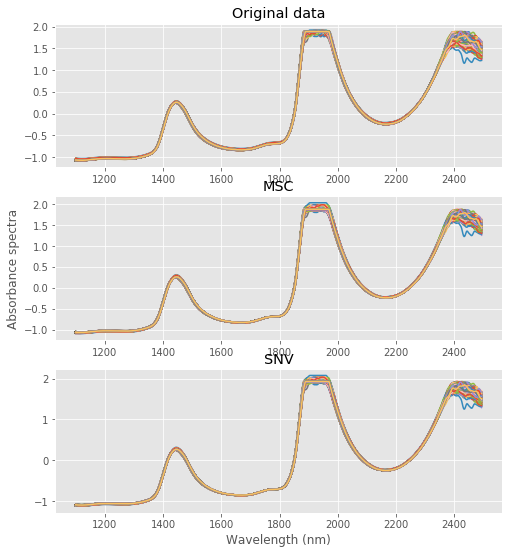

In [23]:
#teste das correções dos espectros:
#@testescorreções
executePreSpec(dados,var_abs_int,var_abs_txt)

In [24]:
X=dados.loc[:,var_abs_txt]
xT= np.transpose(X)
len(X.columns)

698

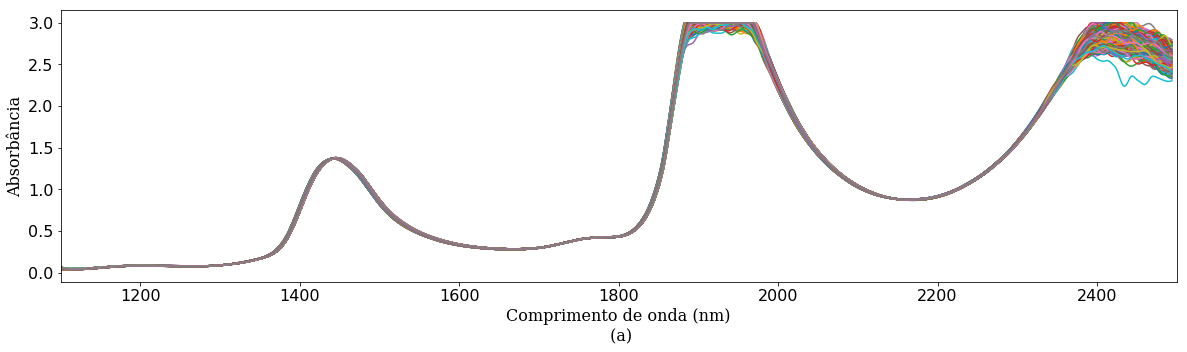

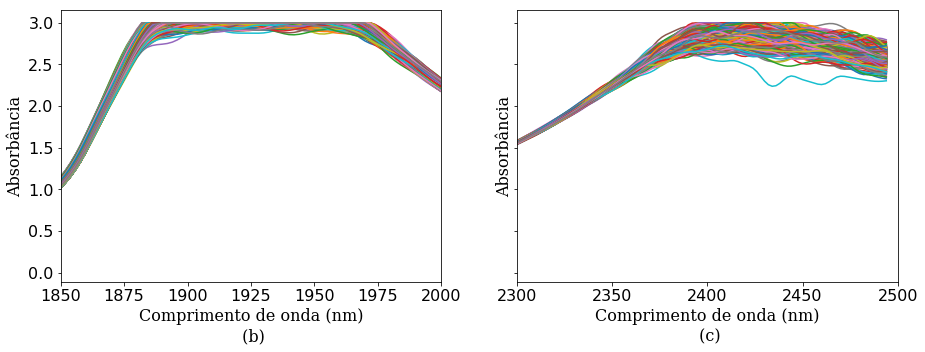

In [27]:
#gráfico de dispersão 3 em um

fonte = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
figuras = ['(a)','(b)','(c)']
limites = [[1100,2500],[1850,2000], [2300,2500]]
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.subplots_adjust(hspace = 0.5, wspace=0.1)
ax.plot(var_abs_int, xT)
ax.grid(False)
ax.set_xlabel('Comprimento de onda (nm)\n (a)', fontdict=fonte)
ax.set_ylabel('Absorbância', fontdict=fonte)
ax.set_xlim(limites[0][0],limites[0][1])
ax.tick_params(labelsize=16)

_, [ax1,ax2] = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.plot(var_abs_int, xT)
ax1.grid(False)
ax1.set_xlabel('Comprimento de onda (nm)\n (b)', fontdict=fonte)
ax1.set_ylabel('Absorbância', fontdict=fonte)
ax1.set_xlim(limites[1][0],limites[1][1])
ax1.tick_params(labelsize=16)

ax2.plot(var_abs_int, xT)
ax2.grid(False)
ax2.set_xlabel('Comprimento de onda (nm)\n (c)', fontdict=fonte)
ax2.set_ylabel('Absorbância', fontdict=fonte)
ax2.set_xlim(limites[2][0],limites[2][1])
ax2.tick_params(labelsize=16)

plt.show()


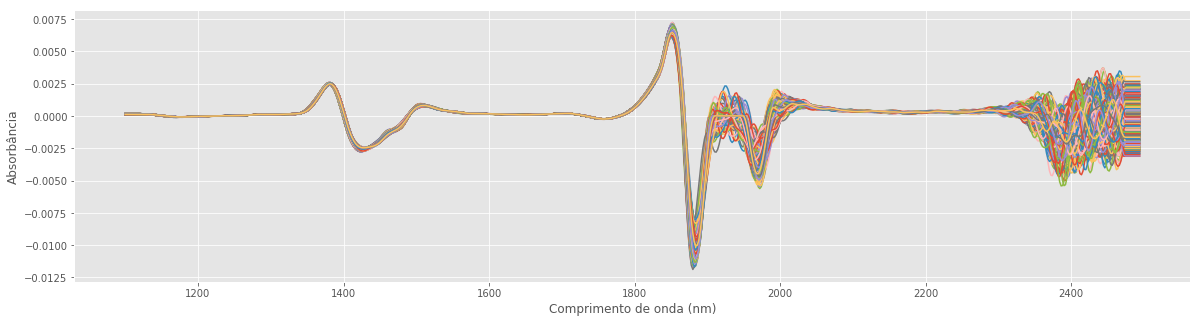

In [26]:
#Aplicando 2 derivada para impressão dos espectros:
X=dados.loc[:,'1100nm':'2494nm']
wl = np.arange(1100,2495,2)
X2 = savgol_filter(X,21,polyorder=2, deriv=2)
# Imprimendo gráfico para segunda derivada
plt.figure(figsize=(20,5))
with plt.style.context(('ggplot')):
    plt.plot(wl, X2.T)
    plt.xlabel('Comprimento de onda (nm)')
    plt.ylabel('Absorbância')
    plt.show()


In [53]:
#dados_bio1=dados[dados.loc[:,'experimento'] != 'biof']
#seleção de dados apenas da desnaturação

# Seleção de atributos relevantes

In [19]:
#@seleção de atributos
#1ºDefinimos os atributos importantes para determinação da atividade específica e veremos se utilizar todos os espectros ou os selecionados faz diferença no desempenho

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, SelectKBest, SelectPercentile, mutual_info_classif, chi2

In [29]:
#denindo as variáveis iniciais para o pré-processamento
var_ae=['betaglicosidase','cmcase','fpase','xilanase']

#criando um vetor com os nomes das absorbâncias para seleção posterior
var_abs_int = np.arange(1100,2495,2)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']

In [30]:
#Definindo os dataFrames iniciais para começar o processamento da seleção de atributos
#Separando a matriz de dados independentes df_y, da de dados dependentes df_x
df_x = dados.loc[:,var_abs_txt] #absorbâncias
df_y = dados.loc[:,var_ae]#AE

In [31]:
df_x.head(5)

1100nm    1102nm    1104nm    1106nm    1108nm    1110nm    1112nm  \
0  0.033690  0.034025  0.034302  0.034534  0.034730  0.034908  0.035092   
1  0.034158  0.033989  0.033937  0.034027  0.034259  0.034608  0.035037   
2  0.033267  0.033650  0.033960  0.034240  0.034516  0.034807  0.035128   
3  0.033680  0.033531  0.033564  0.033741  0.034018  0.034357  0.034727   
4  0.033632  0.033577  0.033613  0.033735  0.033932  0.034204  0.034556   

     1114nm    1116nm    1118nm  ...    2476nm    2478nm    2480nm    2482nm  \
0  0.035302  0.035555  0.035871  ...  2.734445  2.711175  2.684079  2.652157   
1  0.035511  0.036002  0.036483  ...  2.641607  2.628135  2.613031  2.594702   
2  0.035488  0.035893  0.036339  ...  2.617225  2.625774  2.634237  2.642206   
3  0.035112  0.035514  0.035944  ...  2.612468  2.614019  2.622193  2.632400   
4  0.034982  0.035460  0.035966  ...  2.632120  2.618624  2.606181  2.595136   

     2484nm    2486nm    2488nm    2490nm    2492nm    2494nm  
0  2.616421  2.580742  2.550500  2.529863  2.520123  2.519599  
1  2.573957  2.553411  2.535537  2.520982  2.508918  2.498570  
2  2.647367  2.647153  2.641267  2.632092  2.622844  2.615529  
3  2.638570  2.635498  2.621143  2.596599  2.565386  2.533125  
4  2.584422  2.572338  2.558169  2.542595  2.527246  2.514123  

[5 rows x 698 columns]

In [32]:
df_y.head(5)

betaglicosidase      cmcase      fpase   xilanase
0       462.495795  114.800334  50.343581  575.54899
1       462.495795  114.800334  50.343581  575.54899
2       462.495795  114.800334  50.343581  575.54899
3       929.796742   90.505314  57.640572  484.13796
4       929.796742   90.505314  57.640572  484.13796

In [33]:
#treino_teste
#separando o conjunto de dados em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(df_x,df_y,test_size=0.25, random_state=0)

# Imprime o tamanho das bases geradas
print('Particionamento para treinamento e teste:\n','X_treino:',x_treino.shape,'Y_treino:',y_treino.shape,'X_teste:', x_teste.shape,'Y_teste:', y_teste.shape)

Particionamento para treinamento e teste:
 X_treino: (681, 698) Y_treino: (681, 4) X_teste: (227, 698) Y_teste: (227, 4)


## Seleção de variáveis: método: mutua info regression:

In [34]:
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
sel_mi={}
for valor in var_ae:
    sel_mi[valor] = mutual_info_regression(x_treino,y_treino.loc[:,valor])

In [35]:
sel_mi_graph = {}
for valor in var_ae:
    sel_mi_graph[valor] = pd.Series(sel_mi[valor])

In [36]:
for valor in var_ae:
    sel_mi_graph[valor].index = x_treino.columns
    sel_mi_graph[valor] = sel_mi_graph[valor].sort_values(ascending=False)

In [37]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
cores = list(colors.keys())

In [1398]:
#enzima = 'betaglicosidase'
#print('\n Variáveis mais importantes para %s:'%enzima)
#inicio = sel_mi_graph[enzima][sel_mi_graph[enzima]>.8][:20]
#fim = sel_mi_graph[enzima][sel_mi_graph[enzima]<.3][-50:-20]
#juntos = inicio.append(fim)
#juntos[:].plot.bar(figsize=(22,5),color=cores[52:53])


 Variáveis mais importantes para betaglicosidase:
--------------------------------------


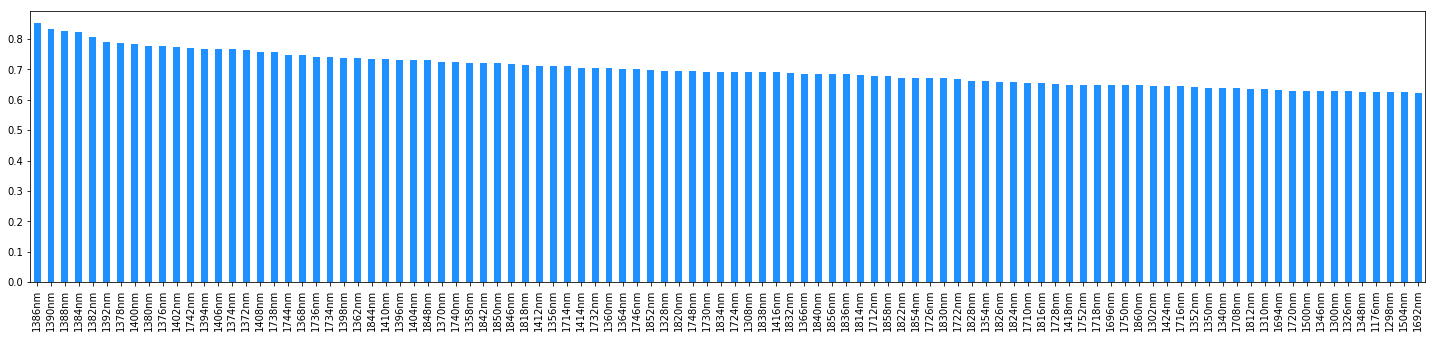

In [38]:
enzima = 'betaglicosidase'
print('\n Variáveis mais importantes para %s:'%enzima)
sel_mi_graph[enzima][:100].plot.bar(figsize=(25,5),color=cores[52:53])
print('--------------------------------------')

In [39]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:50].index


 Variáveis MENOS importantes para betaglicosidase:


Index(['1976nm', '1944nm', '1936nm', '1946nm', '1982nm', '1930nm', '1948nm',
       '1940nm', '1928nm', '1972nm', '1938nm', '1942nm', '1926nm', '1932nm',
       '2360nm', '1924nm', '1934nm', '1952nm', '1950nm', '1964nm', '1970nm',
       '1968nm', '1920nm', '2156nm', '1962nm', '1916nm', '2350nm', '1918nm',
       '2370nm', '1980nm', '1954nm', '1958nm', '1912nm', '2358nm', '2372nm',
       '1914nm', '1956nm', '2362nm', '1922nm', '1960nm', '1978nm', '2158nm',
       '2354nm', '1966nm', '2160nm', '2368nm', '1974nm', '1910nm', '2366nm',
       '2382nm'],
      dtype='object')


 Variáveis MENOS importantes para betaglicosidase:


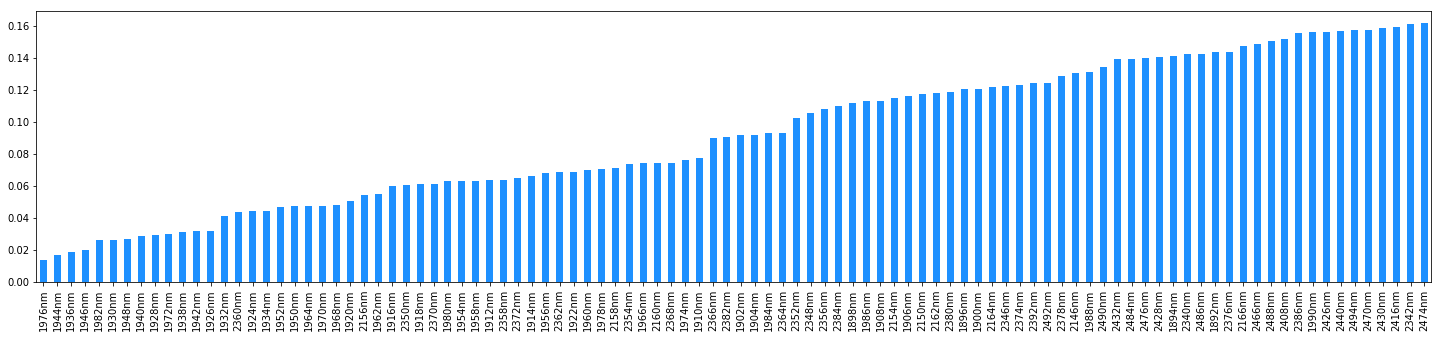

In [40]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:100].plot.bar(figsize=(25,5),color=cores[52:53])


 Variáveis mais importantes para cmcase:
--------------------------------------


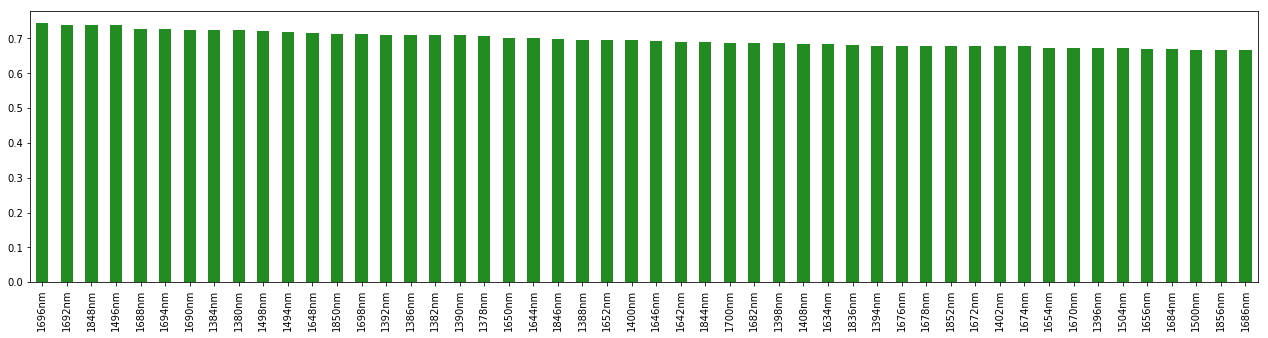

In [41]:
enzima = 'cmcase'
print('\n Variáveis mais importantes para %s:'%enzima)
sel_mi_graph[enzima][:50].plot.bar(figsize=(22,5),color=cores[55:56])
print('--------------------------------------')

In [42]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:50].index


 Variáveis MENOS importantes para cmcase:


Index(['1940nm', '1970nm', '1946nm', '1944nm', '1942nm', '1926nm', '1974nm',
       '1930nm', '1932nm', '1938nm', '1948nm', '2366nm', '1972nm', '1928nm',
       '1952nm', '1936nm', '1934nm', '1954nm', '1924nm', '2354nm', '1922nm',
       '1960nm', '1978nm', '1918nm', '1962nm', '2360nm', '1920nm', '2368nm',
       '1956nm', '2370nm', '1958nm', '1964nm', '2378nm', '2364nm', '2374nm',
       '1916nm', '2448nm', '1900nm', '1968nm', '1976nm', '1966nm', '2202nm',
       '1914nm', '1980nm', '1908nm', '1898nm', '1912nm', '2488nm', '1904nm',
       '2372nm'],
      dtype='object')


 Variáveis MENOS importantes para cmcase:


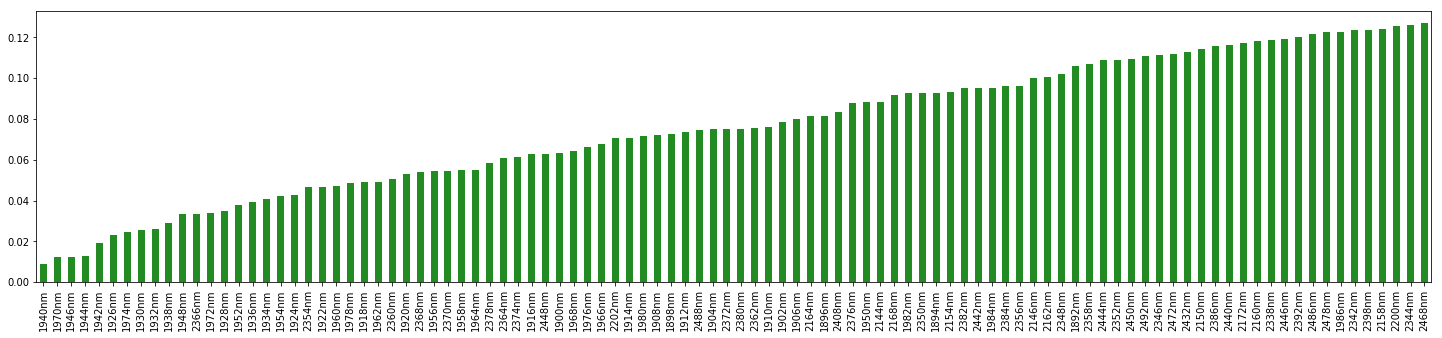

In [43]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:100].plot.bar(figsize=(25,5),color=cores[55:56])


 Variáveis mais importantes para fpase:
--------------------------------------


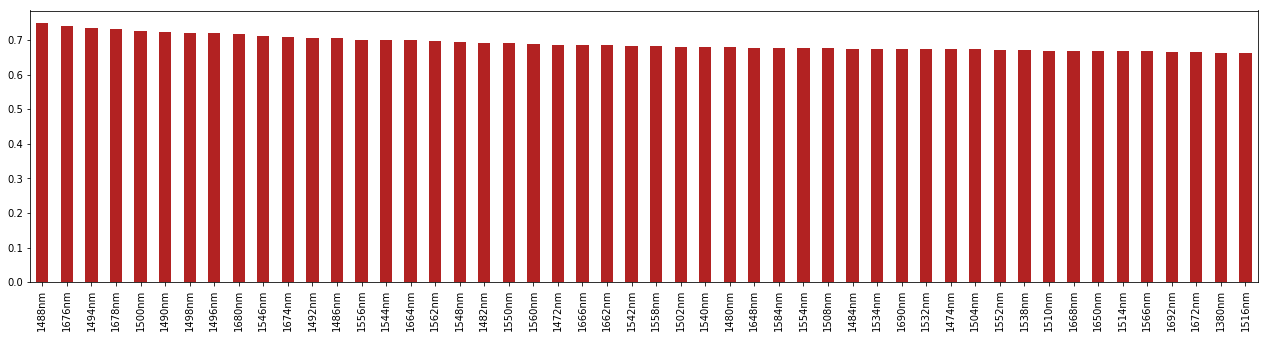

In [44]:
enzima = 'fpase'
print('\n Variáveis mais importantes para %s:'%enzima)
sel_mi_graph[enzima][:50].plot.bar(figsize=(22,5),color=cores[53:54])
print('--------------------------------------')

In [45]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:50].index


 Variáveis MENOS importantes para fpase:


Index(['1968nm', '1926nm', '1924nm', '1936nm', '2368nm', '1944nm', '1922nm',
       '1940nm', '1938nm', '1942nm', '1928nm', '1932nm', '1976nm', '2366nm',
       '2384nm', '1950nm', '2378nm', '1946nm', '1948nm', '1916nm', '1962nm',
       '1974nm', '1954nm', '2452nm', '1952nm', '1934nm', '2364nm', '2154nm',
       '1918nm', '1930nm', '1920nm', '1956nm', '1904nm', '1964nm', '1982nm',
       '2150nm', '2360nm', '1970nm', '2348nm', '2396nm', '1960nm', '1912nm',
       '2374nm', '1908nm', '1914nm', '2488nm', '1910nm', '1972nm', '1900nm',
       '1906nm'],
      dtype='object')


 Variáveis MENOS importantes para fpase:


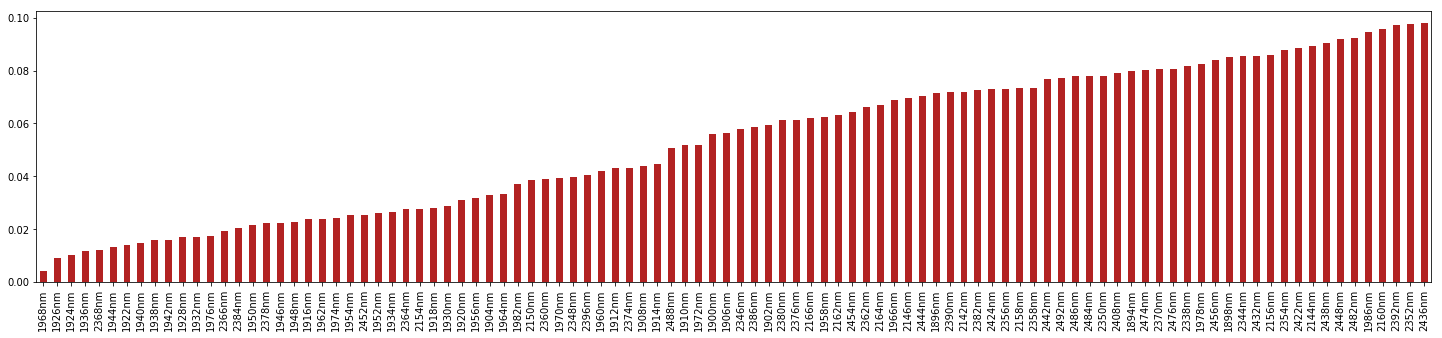

In [46]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:100].plot.bar(figsize=(25,5),color=cores[53:54])


 Variáveis mais importantes para xilanase:
--------------------------------------


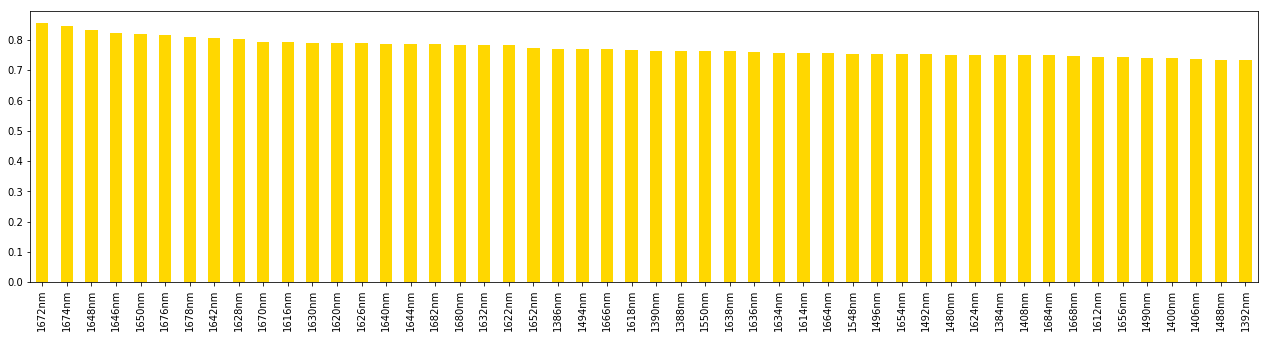

In [47]:
enzima = 'xilanase'
print('\n Variáveis mais importantes para %s:'%enzima)
sel_mi_graph[enzima][:50].plot.bar(figsize=(22,5),color=cores[59:60])
print('--------------------------------------')

In [48]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:50].index


 Variáveis MENOS importantes para xilanase:


Index(['1968nm', '1926nm', '1942nm', '1940nm', '1972nm', '1944nm', '1924nm',
       '1930nm', '1948nm', '1934nm', '1936nm', '1932nm', '1928nm', '1918nm',
       '1946nm', '1922nm', '2360nm', '1952nm', '1938nm', '1950nm', '2378nm',
       '1962nm', '1966nm', '1958nm', '1920nm', '1916nm', '2362nm', '1956nm',
       '1964nm', '1970nm', '1954nm', '1912nm', '1960nm', '2144nm', '1910nm',
       '2372nm', '2348nm', '1914nm', '1908nm', '1904nm', '2364nm', '2374nm',
       '2366nm', '2344nm', '1974nm', '1976nm', '2350nm', '1902nm', '2356nm',
       '2346nm'],
      dtype='object')


 Variáveis MENOS importantes para xilanase:


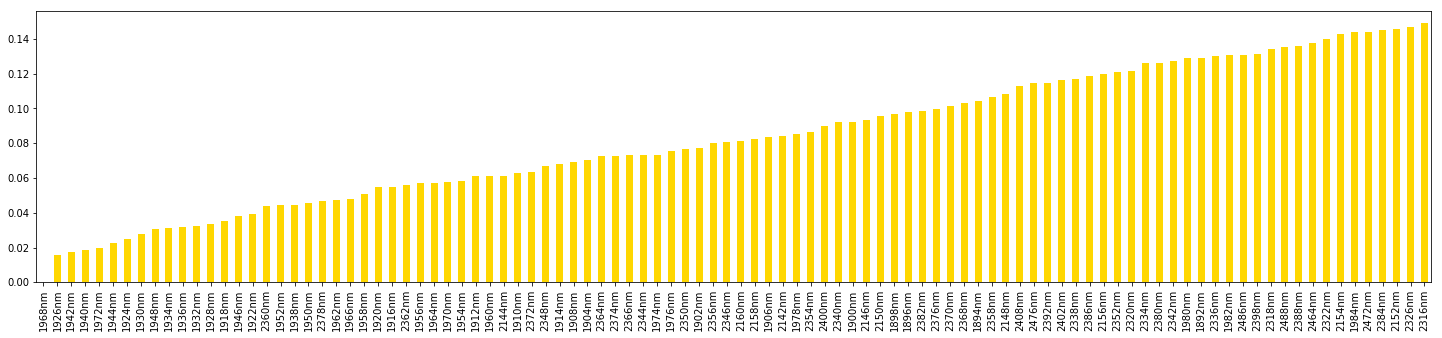

In [49]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:100].plot.bar(figsize=(25,5),color=cores[59:60])

In [117]:
#verificando o total de variáveis com correlação maior que 0.8 para cada atividade enzimática
corte = .5
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
total={'betaglicosidase':0,'cmcase':0,'fpase':0,'xilanase':0}
for valor in var_ae:
    total[valor]=len(sel_mi_graph[valor][sel_mi_graph[valor]>corte])
print('Total de variáveis com correlação superior a ',corte,' para cada enzima\n')
for valor in var_ae:
    print(valor,':',total[valor])    

Total de variáveis com correlação superior a  0.5  para cada enzima

betaglicosidase : 264
cmcase : 226
fpase : 238
xilanase : 286


In [205]:
#verificando o total de variáveis que mais se correlacionam com  cada atividade enzimática
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
  
for valor,i in zip(var_ae,[0,1,2,3]):
    total[valor]=len(sel_mi_graph[valor][sel_mi_graph[valor]>corr[i]])
print('Total de variáveis com correlação alta para cada enzima\n')
for valor in var_ae:
    print(valor,':',total[valor])     

NameError: name 'corr' is not defined

In [ ]:
'''
#Exibindo as variáveis mais significativas 
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
corr = [1,0.7,1,0.85]
for valor,i in zip(var_ae,[0,1,2,3]):
    print('\nAtributos + significativos para:',valor)
    print(sel_mi_graph[valor][sel_mi_graph[valor]>corr[i]].index[:30])
'''

In [118]:
#Considerando o total de cada atividade, as variáveis mais significativas de cada atividade foram anexadas para depois remover as repetições
sel_ = {}
for valor in var_ae:
    sel_[valor] = list(sel_mi_graph[valor].index)
sel_2 = []
for valor in var_ae:
    sel_2 += sel_[valor][:total[valor]]
#elimina repetições:
sel_2 = list(set(sel_2))

print('Total de variáveis significativas sem repetição:',len(sel_2))

Total de variáveis significativas sem repetição: 344


In [119]:
#ordena as variáveis por nome
sel_2.sort()
print('Variáveis mais sigificativas:',sel_2)


Variáveis mais sigificativas: ['1100nm', '1102nm', '1104nm', '1106nm', '1108nm', '1110nm', '1112nm', '1114nm', '1116nm', '1118nm', '1120nm', '1122nm', '1124nm', '1126nm', '1128nm', '1130nm', '1132nm', '1134nm', '1136nm', '1138nm', '1140nm', '1142nm', '1144nm', '1146nm', '1148nm', '1150nm', '1152nm', '1154nm', '1156nm', '1158nm', '1160nm', '1162nm', '1164nm', '1166nm', '1168nm', '1170nm', '1172nm', '1174nm', '1176nm', '1178nm', '1180nm', '1182nm', '1208nm', '1230nm', '1232nm', '1234nm', '1236nm', '1238nm', '1240nm', '1242nm', '1244nm', '1246nm', '1248nm', '1250nm', '1252nm', '1254nm', '1256nm', '1258nm', '1260nm', '1262nm', '1264nm', '1266nm', '1268nm', '1290nm', '1294nm', '1296nm', '1298nm', '1300nm', '1302nm', '1304nm', '1306nm', '1308nm', '1310nm', '1312nm', '1314nm', '1316nm', '1318nm', '1320nm', '1322nm', '1324nm', '1326nm', '1328nm', '1330nm', '1332nm', '1334nm', '1336nm', '1338nm', '1340nm', '1342nm', '1344nm', '1346nm', '1348nm', '1350nm', '1352nm', '1354nm', '1356nm', '1358nm',

In [120]:
#renomear as absorbâncias
var_abs_txt = sel_2.copy()


# Outliers

* Após verificar as variáveis mais importantes, vamos utilizá-las para conferir possíveis outliers

In [1650]:
#2
#Ouliers: realizar teste com o arquivo D_outliers, nesse mesmo diretório

In [ ]:
#amostras outliers
Amostras que foram classificadas como outliers:
índice: 0 descrição: exp2_p0_t1 intervalo(minutos): 0
índice: 6 descrição: exp2_p1_t2_1 intervalo(minutos): 5
índice: 23 descrição: exp2_p2_t2_3 intervalo(minutos): 10
índice: 39 descrição: exp2_p3_t3_1 intervalo(minutos): 15
índice: 124 descrição: exp3_t1_p10_2 intervalo(minutos): 10
índice: 147 descrição: exp3_t2_p02_1 intervalo(minutos): 2
índice: 189 descrição: exp3_t3_p00_1 intervalo(minutos): 0
índice: 215 descrição: exp3_t3_p08_3 intervalo(minutos): 8
índice: 689 descrição: exp7_t4_p04_1 intervalo(minutos): 4
índice: 711 descrição: bio_p0_t1_2 intervalo(minutos): 0
índice: 714 descrição: bio_p0_t2_2 intervalo(minutos): 0
índice: 716 descrição: bio_p0_t3_1 intervalo(minutos): 0
índice: 718 descrição: bio_p0_t3_3 intervalo(minutos): 0
índice: 737 descrição: bio_p3_t1_1 intervalo(minutos): 72
índice: 739 descrição: bio_p3_t1_3 intervalo(minutos): 72
índice: 783 descrição: bio_p8_t1_2 intervalo(minutos): 192
índice: 884 descrição: ctec_exp6_p3_1 intervalo(minutos): 9
índice: 918 descrição: cellu_p022_marco_des_100 intervalo(minutos): 15

In [98]:
#Resetando o índice dos dados:
dados=dados.reset_index(drop=True)
dados.index

RangeIndex(start=0, stop=923, step=1)

In [43]:
dados_com_outliers = dados_back.copy()

In [44]:
dados = dados_com_outliers.copy()

In [1546]:
dados = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='biof')]

In [99]:
outliers = [0, 6, 23, 39, 124, 147, 189, 215, 689, 711, 714, 716, 718, 737, 739, 783, 884, 918]

#removendo as amostras consideradas outliers (testar os algoritmos sem remover outlier e após remover)
dados = dados.drop(outliers)

In [100]:
dados.shape

(905, 713)

# Definição das variáveis

**variáveis para os processamentos: (antes ou após remoção de outliers, com ou sem seleção de atributos:**

In [245]:
#@var_abs_txt
#@var_abs_int
# Opções de definição da variável das absorbâncias

In [71]:
#opção 1: Escolha de todos os valores de absorbância (sem nenhuma selação de atributos)
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
#criando vetores com os nomes dos atributos

#criando um vetor com os nomes das absorbâncias para selação posterior
var_abs_int = np.arange(1100,2496,2)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']

In [117]:
#opção 2: Escolha de algumas absorbâncias e exclusão de outras - duas faixas excluídas (apenas observando os ruídos graficamente)
#variáveis após excluir algumas bandas do espectro
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
#criando vetores com os nomes dos atributos

abs1 = np.arange(1100,1875,2)
abs2 = np.arange(1974,2351,2)
var_abs_int = np.concatenate((abs1,abs2),axis=0)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']


In [112]:
#opção 3: Exclusão da faixa final de ruido, a partir da abs 2350
#variáveis após excluir algumas bandas do espectro
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
#criando vetores com os nomes dos atributos

var_abs_int = np.arange(1100,2351,2)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']

In [105]:
#opção 4: Definição das absorbâncias através da seleção de atributos feita previamente
var_abs_txt = sel_2.copy()
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
var_abs_int=[]
for valor in var_abs_txt:
    var_abs_int += [int(valor[:4])]

In [54]:
#Variável para trabalhar no pré-processamento dos espectros
preProc = {0:'Pré-proc: 0--> Sem pré-processamento', 
           1:'Pré-proc: 1--> Padronização', 
           2:'Pré-proc: 2--> Suavização(SavGol) - Par:3,1,1', 
           3:'Pré-proc: 3--> Suavização(SavGol) - Par:3,2,1',
           4:'Pré-proc: 4--> Suavização(SavGol) - Par:5,1,1',
           5:'Pré-proc: 5--> Suavização(SavGol) - Par:5,2,1',
           6:'Pré-proc: 6--> Suavização(SavGol) - Par:3,2,2',
           7:'Pré-proc: 7--> Suavização(SavGol) - Par:5,2,2',
           8:'Pré-proc: 8--> Suavização(SavGol) - Par:3,1,1 --> Padronização',
           9:'Pré-proc: 9--> Padronização --> Suavização(SavGol) - Par:3,1,1',
           10:'Pré-proc: 10--> MSC',
           11:'Pré-proc: 11--> SNV'}

## Definindo x e y

In [121]:
#@dfxy
#Definindo os dataFrames iniciais a partir da base de dados escolhida e pré-processada
df_x = dados.loc[:,var_abs_txt] #absorbâncias
df_y = dados.loc[:,var_ae]#AE

In [114]:
df_x.shape

(908, 626)

In [118]:
#se precisar eliminar colunas com dados nulos
#dadosb=dados.dropna(axis=1)


# Análise incial da base de dados e de seu conteúdo através de PCA

In [57]:
#@pca
#utilizar o PCA para reduzir as dimensões e poder analisar os dados
#Para utilizar o PCA é necessário realizar a normalização dos dados (tornar a variância unitária)
#pré-processamento
scaler = StandardScaler()
scaler.fit(df_x)
df_x_scaler = scaler.transform(df_x)
pca = PCA(n_components=7)
#treinar o pca com os dados padronizados
pca.fit(df_x_scaler)
#Após treinar o pca, agora posso transformar os dados
x_pca = pca.transform(df_x_scaler)
print('Dados originais:',df_x.shape,'Pós PCA:', x_pca.shape)

Dados originais: (908, 183) Pós PCA: (908, 7)


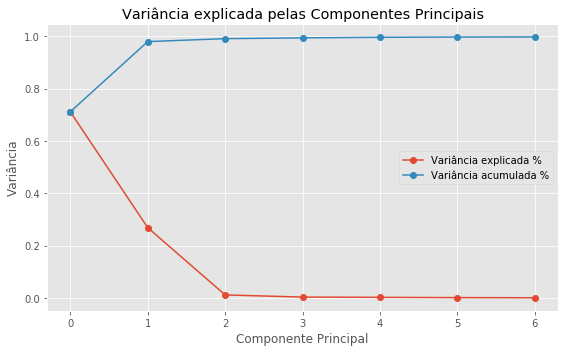

In [58]:
#Exibindo a variância explicada pelas componentes principais
variancia_explicada = pca.explained_variance_ratio_[:10]
# Explicação da variância pelas componentes principais
with plt.style.context(('ggplot')):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    fig.set_tight_layout(True)

    ax1.plot(variancia_explicada,'-o', label="Variância explicada %")
    ax1.plot(np.cumsum(variancia_explicada),'-o', label = 'Variância acumulada %')
    ax1.set_xlabel("Componente Principal")
    ax1.set_ylabel("Variância")

    ax1.set_title('Variância explicada pelas Componentes Principais')    
    plt.legend()
    plt.show()  

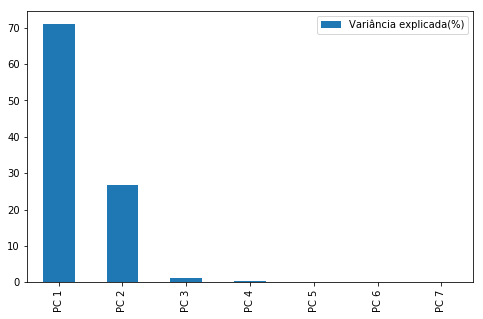

In [59]:
perc = pca.explained_variance_ratio_ * 100
perc = pd.DataFrame(perc, columns=['Variância explicada(%)'], index=['PC %s' % pc for pc in np.arange(len(perc)) + 1])
ax = perc.plot(kind='bar', figsize=(8,5))

    

In [60]:
texto = ''
perc['Variância acumulada(%)'] = np.cumsum(pca.explained_variance_ratio_[:7])
perc


Variância explicada(%)  Variância acumulada(%)
PC 1               71.120631                0.711206
PC 2               26.834047                0.979547
PC 3                1.126143                0.990808
PC 4                0.303616                0.993844
PC 5                0.206380                0.995908
PC 6                0.100521                0.996913
PC 7                0.043853                0.997352

In [61]:
loadings = pd.DataFrame(pca.components_.T)
loadings.index = ['A %s' % pc for pc in loadings.index + 1]
loadings.columns = ['PC %s' % pc for pc in loadings.columns + 1]
PCs = np.dot(loadings.values.T, df_x.T)
marker = dict(linestyle='none', marker='o', markersize=7, color='blue', alpha=0.5)


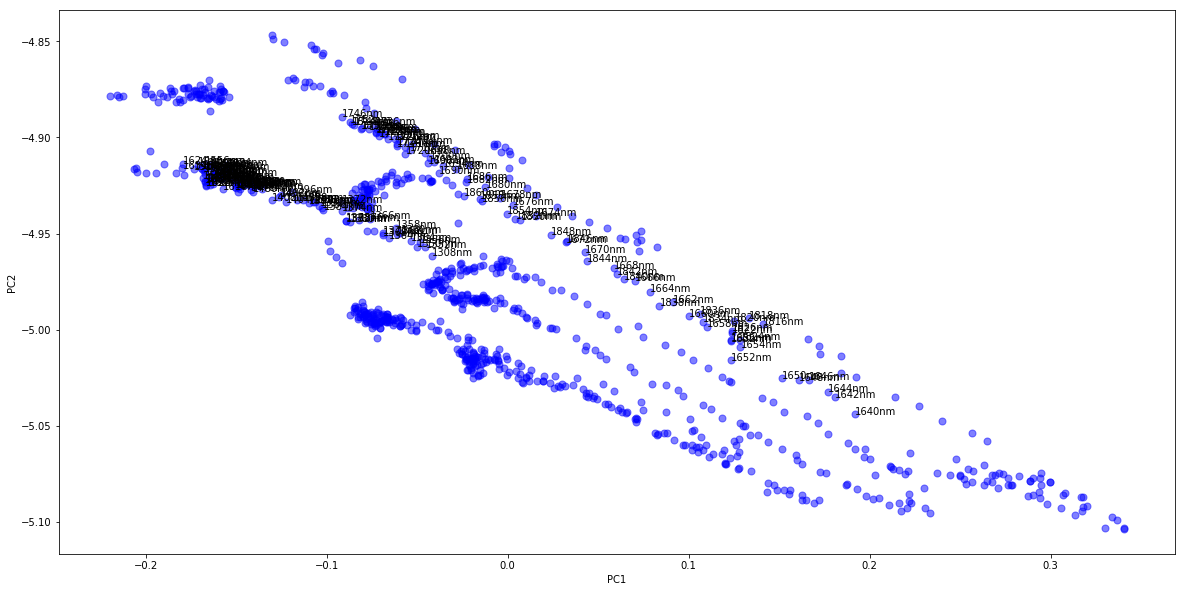

In [271]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(PCs[0], PCs[1], label="Scores", **marker)

ax.set_xlabel("PC1")

ax.set_ylabel("PC2")

text = [ax.text(x, y, t) for x, y, t in
        zip(PCs[0], PCs[1], df_x.columns)]

In [73]:
PCs.shape, df_x.shape, loadings.shape

((7, 81), (81, 261), (261, 7))

In [62]:
#dataframes separados por intervalo de tempo, temperatura, experimento e ae
#servirão para fazer análises gráficas com PCA
temp_yinter = dados.loc[:,'inter']
temp_ye = dados.loc[:,'eenz']
temp_yt = dados.loc[:,'temp']
temp_yex = dados.loc[:,'experimento']
temp_ybeta = dados.loc[:,'betaglicosidase']
temp_ycmc = dados.loc[:,'cmcase']
temp_yfpase = dados.loc[:,'fpase']
temp_yxil = dados.loc[:,'xilanase']

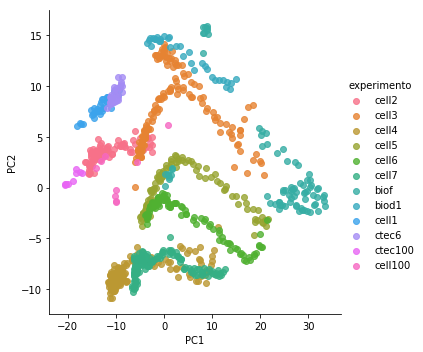

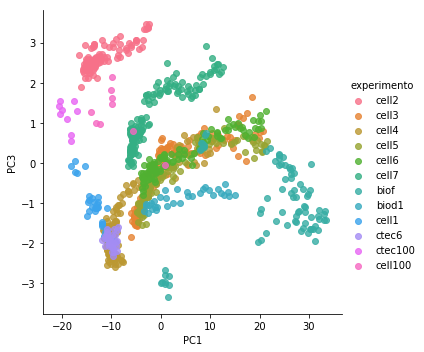

In [63]:
#configurando paleta de cores
palettes = ["deep", "muted", "pastel", "bright", "dark", "colorblind"]
#Desenhando o gráfico dos scores da PC1 com PC2 diferenciando por experimento
dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,1],temp_yex), columns=["PC1", "PC2", "experimento"])
sns.lmplot("PC1", "PC2", dados_plot, hue="experimento", fit_reg=False)
plt.rcParams['figure.figsize']=(20,10)

dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,2],temp_yex), columns=["PC1", "PC3", "experimento"])
sns.lmplot("PC1", "PC3", dados_plot, hue="experimento", fit_reg=False)
plt.rcParams['figure.figsize']=(20,10)

In [132]:
#Como selecionar amostras partindo dos gráficos gerados.
#assim dá pra separar as amostras em função da apresentação dada
#exemplo: biof = dados_plot[(dados_plot['PC2'] >-10) ]

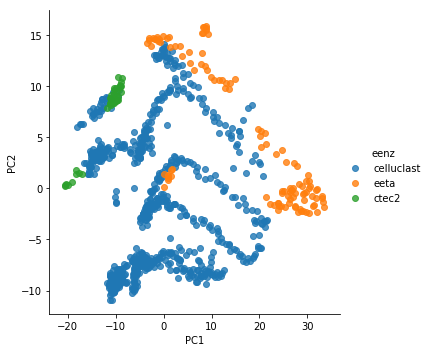

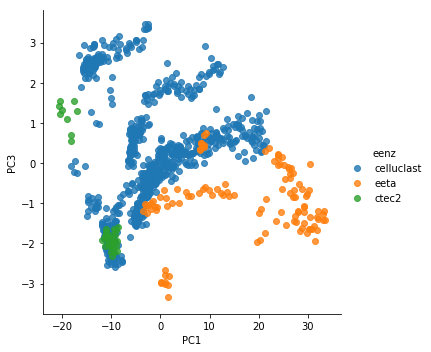

In [64]:
#Desenhando o gráfico dos scores da PC1 com PC2 diferenciando por tempo de fermentação ou desnaturação
dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,1],temp_ye), columns=["PC1", "PC2", "eenz"])
sns.lmplot("PC1", "PC2", dados_plot, hue="eenz", fit_reg=False)
plt.rcParams['figure.figsize']=(15,10)

dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,2],temp_ye), columns=["PC1", "PC3", "eenz"])
sns.lmplot("PC1", "PC3", dados_plot, hue="eenz", fit_reg=False)
plt.rcParams['figure.figsize']=(15,10)


In [ ]:
#Após separação de dados dará para selecionar algum conjunto de dados com características comuns

In [283]:
#verifica quais dados estão separados no biof
#biof = dados_plot[(dados_plot['PC2'] >-10) & (dados_plot['PC1']<0)  ]

In [284]:
#biof = dados.iloc[list(biof.index)]

In [1095]:
#Separa os dados do experimento da fermentação e da desnaturação

#biod = dados[ dados['experimento'] == 'biod1']
#biof = dados[ dados['experimento'] == 'biof']
#bioe = dados[ dados['experimento'] == 'bioE']

In [1097]:
#biod.shape, biof.shape, bioe.shape

((33, 713), (81, 713), (24, 713))

In [79]:
#Definindo os dataFrames iniciais a partir da base de dados escolhida e pré-processada
df_x = dados.loc[:,var_abs_txt] #absorbâncias
df_y = dados.loc[:,var_ae]#AE

# Função de pré-processamento

In [65]:
#@preproc
def executaPreproc(preproc, padroniza = False,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = train_test_split(df_x,df_y,test_size=0.25, random_state=IC)
    
    #parâmetros para savgol: janela,grau do polinômio,derivada
    par = [3,1,1]
    #sem pré-processamento preproc=0
    if preproc == 1:       #preproc=1: padronização (z=(xi-m)/s) SNV
        if padroniza: #padroniza y
            y_treino = StandardScaler().fit_transform(y_treino.values)#treino
            y_teste = StandardScaler().fit_transform(y_teste.values)#teste
            
        x_treino = StandardScaler().fit_transform(x_treino.values)#treino
        x_teste = StandardScaler().fit_transform(x_teste.values)#teste        
    elif preproc in range(2,8):
        if preproc == 2: #SG:3,1,1
            par=[3,1,1]
        elif preproc == 3:
            par=[3,2,1]
        elif preproc == 4:
            par=[5,1,1]
        elif preproc == 5:
            par=[5,2,1]
        elif preproc == 6:
            par=[3,2,2]
        elif preproc == 7:
            par=[5,2,2]
        x_treino = savgol_filter(x_treino, par[0], polyorder = par[1], deriv=par[2]) #treino
        x_teste = savgol_filter(x_teste, par[0], polyorder = par[1], deriv=par[2]) #teste        
    elif preproc == 8:
        x_treino = savgol_filter(x_treino, par[0], polyorder = par[1], deriv=par[2]) #treino
        x_teste = savgol_filter(x_teste, par[0], polyorder = par[1], deriv=par[2]) #teste
        x_treino = StandardScaler().fit_transform(x_treino[:,:])#treino
        x_teste = StandardScaler().fit_transform(x_teste[:,:])#teste
    elif preproc == 9:
        x_treino = StandardScaler().fit_transform(x_treino.values)#treino
        x_teste = StandardScaler().fit_transform(x_teste.values)#teste
        x_treino = savgol_filter(x_treino, par[0], polyorder = par[1], deriv=par[2]) #treino
        x_teste = savgol_filter(x_teste, par[0], polyorder = par[1], deriv=par[2]) #teste
    elif preproc == 10:
        x_treino = msc(x_treino.values)[0]
        x_teste = msc(x_teste.values)[0]
    elif preproc == 11:
        x_treino = snv(x_treino.values)
        x_teste = snv(x_teste.values)
    return (x_treino, x_teste, y_treino, y_teste)

In [66]:
def executaPreprocSimples(preproc,x):
    #parâmetros para savgol: janela,grau do polinômio,derivada
    par = [3,1,1]
    if preproc == 1:       
        x = StandardScaler().fit_transform(x.values)      
    elif preproc in range(2,8):
        if preproc == 2:
            par=[3,1,1]
        elif preproc == 3:
            par=[3,2,1]
        elif preproc == 4:
            par=[5,1,1]
        elif preproc == 5:
            par=[5,2,1]
        elif preproc == 6:
            par=[3,2,2]
        elif preproc == 7:
            par=[5,2,2]
        x= savgol_filter(x_treino, par[0], polyorder = par[1], deriv=par[2])          
    elif preproc == 8:
        x = savgol_filter(x, par[0], polyorder = par[1], deriv=par[2]) 
        x = StandardScaler().fit_transform(x[:,:])        
    elif preproc == 9:
        x = StandardScaler().fit_transform(x[:,:])
        x = savgol_filter(x, par[0], polyorder = par[1], deriv=par[2]) 
    elif preproc == 10:
        x_treino = msc(x_treino.values)[0]
        x_teste = msc(x_teste.values)[0]
    elif preproc == 11:
        x_treino = snv(x_treino.values)
        x_teste = snv(x_teste.values)
        
    return x

# Modelagem:

## Função geral de modelagem


In [67]:
#@modelagemCVP executa calibração, validação e predição
def executaCVP(treino_teste, reg):
    x_treino = treino_teste[0].copy()
    x_teste = treino_teste[1].copy()
    y_treino = treino_teste[2].copy()
    y_teste = treino_teste[3].copy()
    
    # Fit
    reg.fit(x_treino, y_treino) 

    # Calibração
    y_c = reg.predict(x_treino)

    # Cross-validation
    y_cv = cross_val_predict(reg, x_treino, y_treino, cv=10)

    # Predição nos dados de teste
    y_p = reg.predict(x_teste)

    y = y_treino.copy()
   
    return [reg, treino_teste,y_c,y_cv,y_p]


In [68]:
#@modelagemMetrics
#Retorna tabela de resultados:
def calMetrics(reais, preditos):
    result = {}
    result['BIAS'] = round(bias(reais, preditos),4)
    result['MSE'] = round(getmse(reais, preditos),4)
    result['R2'] = round(getr2(reais, preditos),4)
    result['RER'] = round(rer(reais, preditos),4)
    result['RMSE'] = round(getrmse(reais, preditos),4)
    #result['RMSE'] = rmse(reais, preditos)    
    result['RPD'] = round(rpd(reais, preditos),4)
    result['RPIQ'] = round(rpiq(reais, preditos),4)
    result['SEP'] = round(sep(reais, preditos),4)    
    return result

In [69]:
#@modelagemcalvalpred
#exibe resultados para calibração, vaidação cruzada e predição
def retornaCVP(y,yp):
    #yp contem os valores estimados da calibração, validação e teste
    var = ['cal','val', 'pred']
    var_ae=['betaglicosidase','cmcase','fpase','xilanase']
    res_cvp = {}
    for i in range(3):
        if i <2:
            j=0
        else:
            j=1
        for e,ie in zip(var_ae,[0,1,2,3]):
            reais = y[j].loc[:,e]
            pred = yp[i][:,ie]
            r = pd.Series(calMetrics(reais, pred))
            if ie == 0:
                res = pd.DataFrame(r, index=r.index, columns=[e])
            else:
                res[e] = r
        res_cvp[var[i]] = res
    return res_cvp

In [70]:
#@modelagemResultados
def exibeResultados(result):
    #recuperando resultados da modelagem
    reg, treino_teste,y_c,y_cv,y_p = result

    #x_treino, x_teste, y_treino, y_teste = treino_teste
    y_ = [treino_teste[2].reset_index(drop=True),treino_teste[3].reset_index(drop=True)]
    yp=[y_c,y_cv,y_p]
    resultados = retornaCVP(y_, yp)
    return resultados

## PCA->KNN

In [71]:
#pcaknn
#função completa para execução do PCA-->KNN:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaPCA_KNN(preproc, nPC,vizinhos, padroniza=False, ic=0):
    #separando o conjunto de dados em treino e teste
    
    #separando o conjunto de dados em treino e teste
    #x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,True)
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,padroniza,ic)

    
    # Roda o PCA e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pca = PCA(n_components=nPC)
    x_treino = pca.fit_transform(x_treino)[:,:nPC]
    x_teste = pca.fit_transform(x_teste)[:,:nPC]    
    
    #Passo 2: Aplicar o KNN sobre as componentes selecionadas
    reg = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=vizinhos))
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

### PCA->KNN: testes

In [128]:
#pcaknn teste simples
#teste simples:
modelo = 'PCA-KNN:'
preproc=1
nPC=3
k=2
result = executaPCA_KNN(preproc,nPC,k,ic=12)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
'''
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')'''

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform'),
           n_jobs=None)


"\nfor k,v in zip(resultados.keys(),resultados.values()):\n    print(k)\n    print(v,'\n-----------------------------------------------------')"

In [129]:
resultados['cal']

betaglicosidase   cmcase    fpase    xilanase
BIAS           3.8712   0.3397   0.2467      4.3216
MSE         5043.8880  74.4698  34.3704  10802.6684
R2             0.9639   0.9616   0.9187      0.9301
RER           41.1253  33.3690  27.8625     28.4931
RMSE          71.0203   8.6296   5.8626    103.9359
RPD            5.2598   5.1061   3.5074      3.7829
RPIQ           2.0951   3.1713   3.6999      4.7841
SEP           70.9669   8.6292   5.8617    103.9223

In [130]:
resultados['val']

betaglicosidase    cmcase     fpase    xilanase
BIAS          10.8919    1.3144    0.9036     17.8221
MSE        28870.3016  309.7965  137.1683  44883.7143
R2             0.7931    0.8404    0.6756      0.7097
RER           17.1995   16.3935   13.9765     14.0161
RMSE         169.9126   17.6010   11.7119    211.8578
RPD            2.1985    2.5035    1.7557      1.8559
RPIQ           0.8757    1.5549    1.8520      2.3470
SEP          169.6878   17.5648   11.6856    211.2620

In [131]:
resultados['pred']

betaglicosidase    cmcase     fpase    xilanase
BIAS          12.0415   -0.4219   -0.2563     -5.9792
MSE        25472.9166  201.0635  150.8746  52697.2667
R2             0.8355    0.9057    0.6733      0.6802
RER           18.2981   20.2713   13.2697     12.8748
RMSE         159.6024   14.1797   12.2831    229.5589
RPD            2.4654    3.2572    1.7495      1.7683
RPIQ           0.9681    2.0140    1.6976      1.4800
SEP          159.4992   14.2047   12.3076    229.9881

In [132]:
#pcaknn teste completo
#pre = preprocessamento, k=número de vizinhos
modelo = 'PCA-KNN:'
print(modelo,':\n')
for nPC in range(2,5):
    print('PC:',nPC)
    for pre in range(12):
        print('Pré-processamento:\n',pre)
        for k in range(1,4):           
            result = executaPCA_KNN(pre,nPC,k)
            print('Vizinhos:', k,'\n')
            print('Parâmetros do modelo:',modelo,'\n',result[0])
            resultados=exibeResultados(result)
            for k,v in zip(resultados.keys(),resultados.values()):
                print(k)
                print(v,'\n-----------------------------------------------------')

PCA-KNN: :

PC: 2
Pré-processamento:
 0
Vizinhos: 1 

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='uniform'),
           n_jobs=None)
cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -1.3427   -0.9551    0.0992       0.2592
MSE       106283.7742  833.1898  423.7658  136208.1786
R2             0.2619    0.5829    0.0320 

cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS           4.2735   -0.1928   0.2190      6.2679
MSE        13586.3633  236.6070  94.6850  32219.2416
R2             0.9056    0.8816   0.7837      0.7940
RER           25.0372   18.7075  16.7764     16.4944
RMSE         116.5606   15.3820   9.7306    179.4972
RPD            3.2555    2.9057   2.1502      2.2031
RPIQ           1.3232    1.9128   2.1887      2.3010
SEP          116.5678   15.3921   9.7353    179.5196 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0119   -0.4770   -0.1767     -1.5210
MSE        34214.3861  513.3171  212.0830  72236.1990
R2             0.7624    0.7430    0.5155      0.5381
RER           15.7667   12.7028   11.2075     11.0093
RMSE         184.9713   22.6565   14.5631    268.7679
RPD            2.0515    1.9727    1.4367      1.4714
RPIQ           0.8338    1.2986    1.4624      1.5368
SEP          185.1073   22.6

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -1.1233   -0.1181   -0.0258     -0.7523
MSE        24704.9011  221.5348  116.8135  40689.2278
R2             0.8284    0.8891    0.7332      0.7398
RER           18.5552   19.3325   15.1002     14.6687
RMSE         157.1779   14.8840   10.8080    201.7157
RPD            2.4142    3.0029    1.9359      1.9605
RPIQ           0.9812    1.9768    1.9705      2.0476
SEP          157.2894   14.8945   10.8159    201.8626 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS         -11.1711   -0.8605   -0.3803      -8.4584
MSE        68363.4297  697.3751  353.1953  125829.2289
R2             0.5252    0.6509    0.1932       0.1954
RER           11.1643   10.9017    8.6858       8.3438
RMSE         261.4640   26.4079   18.7935     354.7242
RPD            1.4513    1.6925    1.1133       1.1148
RPIQ           0.5899    1.1142    1.1332       1.1644
SEP        

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           8.7462    0.4606    0.6296      13.7090
MSE        79433.5309  901.7227  430.6353  145227.1014
R2             0.4484    0.5486    0.0163       0.0713
RER           10.3527    9.5832    7.8682       7.7694
RMSE         281.8395   30.0287   20.7518     381.0867
RPD            1.3464    1.4884    1.0083       1.0377
RPIQ           0.5472    0.9798    1.0263       1.0838
SEP          281.9109   30.0472   20.7574     381.1200 
------------------

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.8232   -0.4833    0.1427     -0.0165
MSE        26324.0337  313.5831  145.7157  51544.9708
R2             0.8172    0.8430    0.6671      0.6704
RER           17.9753   16.2548   13.5209     13.0328
RMSE         162.2468   17.7083   12.0713    227.0352
RPD            2.3388    2.5240    1.7333      1.7418
RPIQ           0.9506    1.6615    1.7643      1.8192
SEP          162.3640   17.7147   12.0793    227.2021 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -7.2698   -1.6146   -0.4631     -12.9318
MSE        53762.7343  659.7865  299.8317  107891.8409
R2             0.6266    0.6697    0.3151       0.3101
RER           12.5840   11.2242    9.4285       9.0151
RMSE         231.8679   25.6863   17.3156     328.4689
RPD            1.6366    1.7401    1.2083       1.2039
RPIQ           0.6652    1.1455    1.2299       1.2574
SEP        

cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS          -0.2398    0.2587   0.1853      3.0321
MSE        12712.3151  151.2067  71.0971  27363.3255
R2             0.9117    0.9243   0.8376      0.8250
RER           25.8663   23.4049  19.3601     17.8903
RMSE         112.7489   12.2966   8.4319    165.4186
RPD            3.3656    3.6348   2.4814      2.3906
RPIQ           1.3679    2.3928   2.5258      2.4969
SEP          112.8315   12.3029   8.4361    165.5124 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           2.3642   -0.2006   -0.2122     -3.7770
MSE        33053.1279  432.8941  192.2411  78190.5859
R2             0.7705    0.7833    0.5609      0.5000
RER           16.0427   13.8301   11.7722     10.5826
RMSE         181.8052   20.8061   13.8651    279.6258
RPD            2.0872    2.1482    1.5090      1.4142
RPIQ           0.8483    1.4141    1.5360      1.4771
SEP          181.9234   20.8

Vizinhos: 1 

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='uniform'),
           n_jobs=None)
cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS         -10.8379   -1.1246   -0.5773     -12.4835
MSE        82406.3525  788.6953  408.6451  149120.5731
R2             0.4277    0.6052    0.0665       0.0464
RER           10.1666   10.

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -4.5977   -0.3661   -0.2825     -5.2419
MSE        28396.2640  246.3767  132.1781  48289.8960
R2             0.8028    0.8767    0.6981      0.6912
RER           17.3132   18.3364   14.1997     13.4687
RMSE         168.5119   15.6964   11.4969    219.7496
RPD            2.2519    2.8475    1.8199      1.7996
RPIQ           0.9152    1.8745    1.8524      1.8795
SEP          168.5730   15.7037   11.5018    219.8486 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS         -10.1297   -0.9999   -0.5768     -7.6020
MSE        56099.4091  535.5657  276.7533  98560.3983
R2             0.6104    0.7319    0.3678      0.3698
RER           12.3244   12.4450    9.8162      9.4277
RMSE         236.8531   23.1423   16.6359    313.9433
RPD            1.6021    1.9313    1.2577      1.2596
RPIQ           0.6512    1.2714    1.2802      1.3156
SEP          236.81

cal
      betaglicosidase   cmcase    fpase    xilanase
BIAS           1.6927   0.1961   0.2896      6.6744
MSE         3969.7052  47.8546  32.7505  10883.6938
R2             0.9724   0.9760   0.9252      0.9304
RER           46.3046  41.6111  28.5546     28.4205
RMSE          63.0056   6.9177   5.7228    104.3249
RPD            6.0227   6.4610   3.6561      3.7906
RPIQ           2.4479   4.2533   3.7215      3.9591
SEP           63.0291   6.9200   5.7197    104.1877 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.2468    0.0186    0.2269      6.3437
MSE        23713.2345  203.3087  120.7441  41920.4482
R2             0.8353    0.8982    0.7242      0.7319
RER           18.9387   20.1799   14.8555     14.4586
RMSE         153.9910   14.2586   10.9884    204.7448
RPD            2.4642    3.1346    1.9041      1.9314
RPIQ           1.0015    2.0635    1.9382      2.0173
SEP          154.1040   14.2691   10.

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -8.9153   -0.2535   -0.5185     -12.4105
MSE        79035.2130  844.6219  456.5964  159578.0688
R2             0.4511    0.5772   -0.0430      -0.0204
RER           10.3790    9.9011    7.6399       7.4106
RMSE         281.1320   29.0624   21.3681     399.4722
RPD            1.3498    1.5379    0.9792       0.9899
RPIQ           0.5486    1.0124    0.9967       1.0339
SEP          281.1972   29.0826   21.3775     399.5729 
------------------

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -8.9030   -0.4115   -0.2711     -8.3403
MSE        29104.7294  294.3709  146.1169  51010.4721
R2             0.7979    0.8526    0.6662      0.6738
RER           17.1181   16.7754   13.5048     13.1098
RMSE         170.6011   17.1572   12.0879    225.8550
RPD            2.2243    2.6051    1.7309      1.7509
RPIQ           0.9040    1.7149    1.7619      1.8287
SEP          170.4938   17.1649   12.0937    225.8668 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -7.8806   -0.5107   -0.1360      -3.6794
MSE        54037.7668  593.1749  300.8341  102563.1118
R2             0.6247    0.7031    0.3128       0.3442
RER           12.5530   11.8168    9.4098       9.2398
RMSE         232.4602   24.3552   17.3446     320.2548
RPD            1.6324    1.8352    1.2063       1.2348
RPIQ           0.6635    1.2081    1.2279       1.2897
SEP        

cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS          -0.5398   -0.2025  -0.1424     -3.0339
MSE        16114.9280  188.9756  98.8065  34948.5641
R2             0.8881    0.9054   0.7743      0.7765
RER           22.9740   20.9334  16.4203     15.8297
RMSE         126.9446   13.7468   9.9401    186.9454
RPD            2.9892    3.2513   2.1049      2.1153
RPIQ           1.2149    2.1403   2.1425      2.2094
SEP          127.0367   13.7555   9.9464    187.0581 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -5.9877   -0.8918   -0.1419      -6.0308
MSE        65306.4022  676.9782  353.2027  123607.6293
R2             0.5465    0.6611    0.1932       0.2096
RER           11.4153   11.0653    8.6842       8.4173
RMSE         255.5512   26.0188   18.7937     351.5788
RPD            1.4849    1.7178    1.1133       1.1248
RPIQ           0.6035    1.1308    1.1332       1.1748
SEP          255.668

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           7.6169    0.0266   -0.0140       1.9670
MSE        67297.4609  472.6163  303.5279  118092.5227
R2             0.5326    0.7634    0.3067       0.2449
RER           11.2469   13.2356    9.3676       8.6104
RMSE         259.4175   21.7397   17.4221     343.6459
RPD            1.4628    2.0559    1.2010       1.1508
RPIQ           0.5945    1.3534    1.2224       1.2019
SEP          259.4963   21.7557   17.4349     343.8929 
------------------

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -2.0884   -0.5404   -0.2094     -1.5675
MSE        24806.3759  219.8420  108.5815  42924.2671
R2             0.8277    0.8900    0.7520      0.7255
RER           18.5184   19.4191   15.6653     14.2821
RMSE         157.5004   14.8271   10.4202    207.1817
RPD            2.4093    3.0145    2.0079      1.9087
RPIQ           0.9792    1.9844    2.0438      1.9936
SEP          157.6023   14.8281   10.4258    207.3281 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -7.1466   -1.2864   -0.6764      -6.2588
MSE        58199.8551  557.6136  272.7494  100959.4366
R2             0.5958    0.7209    0.3770       0.3544
RER           12.0942   12.2032    9.8903       9.3141
RMSE         241.2465   23.6138   16.5151     317.7411
RPD            1.5729    1.8928    1.2669       1.2446
RPIQ           0.6393    1.2460    1.2896       1.2999
SEP        

cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS          -2.0658    0.1026   0.0957      0.9487
MSE        23123.5064  162.5942  96.5567  34801.6308
R2             0.8394    0.9186   0.7794      0.7775
RER           19.1805   22.5662  16.6095     15.8612
RMSE         152.0642   12.7512   9.8263    186.5520
RPD            2.4954    3.5052   2.1293      2.1198
RPIQ           1.0142    2.3074   2.1674      2.2140
SEP          152.1619   12.7602   9.8331    186.6867 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -7.5923   -0.7761   -0.4263      -7.4393
MSE        59993.8310  455.2309  279.5490  103478.4915
R2             0.5834    0.7721    0.3614       0.3383
RER           11.9125   13.4948    9.7643       9.2007
RMSE         244.9364   21.3361   16.7197     321.6807
RPD            1.5492    2.0948    1.2514       1.2293
RPIQ           0.6297    1.3790    1.2738       1.2840
SEP          244.998

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.6854    0.2891    0.3120      6.5638
MSE        19911.6980  204.0430  126.0166  43726.8992
R2             0.8617    0.8979    0.7121      0.7204
RER           20.6679   20.1476   14.5439     14.1569
RMSE         141.1088   14.2844   11.2257    209.1098
RPD            2.6892    3.1290    1.8639      1.8911
RPIQ           1.0930    2.0598    1.8972      1.9752
SEP          141.2109   14.2919   11.2296    209.1604 
---------------------------

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -8.9256   -0.6733   -0.3341     -8.5092
MSE        28767.1709  273.6849  142.8572  46878.6399
R2             0.8002    0.8630    0.6737      0.7002
RER           17.2187   17.4073   13.6599     13.6766
RMSE         169.6089   16.5434   11.9523    216.5148
RPD            2.2373    2.7017    1.7506      1.8265
RPIQ           0.9093    1.7785    1.7819      1.9076
SEP          169.4984   16.5419   11.9564    216.5065 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -8.3940   -0.8426   -0.3276     -6.0380
MSE        56051.3263  565.9463  283.1677  99621.9272
R2             0.6107    0.7167    0.3532      0.3630
RER           12.3261   12.1027    9.7004      9.3763
RMSE         236.7516   23.7896   16.8276    315.6294
RPD            1.6028    1.8788    1.2434      1.2529
RPIQ           0.6514    1.2368    1.2656      1.3086
SEP          236.77

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -7.9845   -0.1199   -0.2524     -8.4264
MSE        21613.7049  194.1190  103.4069  36781.2166
R2             0.8499    0.9028    0.7638      0.7648
RER           19.8666   20.6528   16.0542     15.4432
RMSE         147.0160   13.9327   10.1689    191.7843
RPD            2.5811    3.2080    2.0576      2.0620
RPIQ           1.0491    2.1118    2.0943      2.1536
SEP          146.9069   13.9424   10.1733    191.7399 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS         -13.8416   -0.9038   -0.3176      -5.8287
MSE        58842.7352  607.8805  315.8978  105283.7146
R2             0.5914    0.6957    0.2784       0.3268
RER           12.0423   11.6783    9.1838       9.1205
RMSE         242.5752   24.6552   17.7735     324.4745
RPD            1.5643    1.8128    1.1772       1.2188
RPIQ           0.6358    1.1934    1.1983       1.2729
SEP        

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -0.4884   -0.5764    0.2481       5.0034
MSE        69989.8377  773.1753  394.7957  132226.2318
R2             0.5139    0.6130    0.0982       0.1545
RER           11.0238   10.3502    8.2144       8.1379
RMSE         264.5559   27.8060   19.8695     363.6293
RPD            1.4343    1.6074    1.0530       1.0875
RPIQ           0.5830    1.0581    1.0719       1.1359
SEP          264.7499   27.8205   19.8825     363.8621 
------------------

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.2940   -0.3836   -0.1480     -2.9719
MSE        29672.0343  297.2344  145.5807  51182.7203
R2             0.7939    0.8512    0.6675      0.6727
RER           16.9306   16.6938   13.5272     13.0799
RMSE         172.2557   17.2405   12.0657    226.2360
RPD            2.2029    2.5925    1.7341      1.7480
RPIQ           0.8954    1.7066    1.7651      1.8257
SEP          172.3821   17.2489   12.0736    226.3827 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.0410   -0.3590   -0.0209      -0.6972
MSE        77892.5520  670.4672  318.7963  113576.8982
R2             0.4591    0.6644    0.2718       0.2737
RER           10.4496   11.1135    9.1405       8.7798
RMSE         279.0924   25.8934   17.8549     337.0117
RPD            1.3596    1.7261    1.1718       1.1734
RPIQ           0.5526    1.1363    1.1928       1.2256
SEP        

cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS          -0.5390   -0.1168   0.0223      1.8458
MSE        25551.0187  167.4159  96.7145  37514.4308
R2             0.8226    0.9162   0.7791      0.7601
RER           18.2450   22.2390  16.5952     15.2774
RMSE         159.8469   12.9389   9.8344    193.6864
RPD            2.3739    3.4543   2.1276      2.0417
RPIQ           0.9649    2.2740   2.1656      2.1325
SEP          159.9634   12.9479   9.8416    193.8200 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -2.0116   -0.3707    0.1813      7.1250
MSE        61778.8879  481.4253  270.7269  97522.5752
R2             0.5710    0.7590    0.3816      0.3764
RER           11.7338   13.1158    9.9195      9.4774
RMSE         248.5536   21.9414   16.4538    312.2860
RPD            1.5267    2.0370    1.2716      1.2663
RPIQ           0.6205    1.3410    1.2944      1.3226
SEP          248.7281   21.9

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -3.6422   -0.2724   -0.0468      -0.8186
MSE        67744.1600  540.0785  359.9592  125441.9841
R2             0.5295    0.7296    0.1778       0.1979
RER           11.2061   12.3822    8.6021       8.3543
RMSE         260.2771   23.2396   18.9726     354.1779
RPD            1.4579    1.9233    1.1028       1.1165
RPIQ           0.5926    1.2661    1.1225       1.1662
SEP          260.4429   23.2551   18.9865     354.4373 
------------------

In [133]:
#pcaknn teste completo
#pre = preprocessamento, k=número de vizinhos
modelo = 'PCA-KNN:'
print(modelo,':\n')
for nPC in range(3,5):
    print('PC:',nPC)
    for pre in [0,1,8]:
        print('Pré-processamento:\n',pre)
        for k in range(1,4):           
            result = executaPCA_KNN(pre,nPC,k)
            print('Vizinhos:', k,'\n')
            print('Parâmetros do modelo:',modelo,'\n',result[0])
            resultados=exibeResultados(result)
            for k,v in zip(resultados.keys(),resultados.values()):
                print(k)
                print(v,'\n-----------------------------------------------------')

PCA-KNN: :

PC: 3
Pré-processamento:
 0
Vizinhos: 1 

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='uniform'),
           n_jobs=None)
cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -4.1246   -1.0437    0.1673       3.3753
MSE        69872.4999  541.3751  339.8281  107757.0202
R2             0.5148    0.7290    0.2237 

cal
      betaglicosidase   cmcase    fpase    xilanase
BIAS           1.4412   0.2037   0.2533      6.4188
MSE         9074.7660  84.5584  52.4205  17791.4607
R2             0.9370   0.9577   0.8803      0.8862
RER           30.6181  31.2986  22.5550     22.2089
RMSE          95.2616   9.1956   7.2402    133.3846
RPD            3.9834   4.8606   2.8899      2.9648
RPIQ           1.6190   3.1997   2.9415      3.0965
SEP           95.3207   9.2001   7.2411    133.3280 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -1.7917   -0.2289    0.1112      4.9673
MSE        27758.3295  217.5186  134.0624  50163.7338
R2             0.8072    0.8911    0.6938      0.6792
RER           17.5055   19.5119   14.0960     13.2142
RMSE         166.6083   14.7485   11.5785    223.9726
RPD            2.2776    3.0305    1.8071      1.7656
RPIQ           0.9257    1.9950    1.8394      1.8441
SEP          166.7211   14.7576   11.

cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS          -5.2394   -0.5131  -0.0382      0.4141
MSE        14213.1679  121.4022  85.1283  27289.4229
R2             0.9013    0.9392   0.8055      0.8255
RER           24.4862   26.1429  17.6887     17.9116
RMSE         119.2190   11.0183   9.2265    165.1951
RPD            3.1829    4.0565   2.2677      2.3939
RPIQ           1.2937    2.6704   2.3083      2.5003
SEP          119.1914   11.0144   9.2332    165.3160 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -8.0489   -1.0949   -0.1654     -1.6425
MSE        56906.2091  448.2621  262.5005  86112.3814
R2             0.6048    0.7756    0.4004      0.4494
RER           12.2325   13.6085   10.0736     10.0833
RMSE         238.5502   21.1722   16.2019    293.4491
RPD            1.5907    2.1110    1.2914      1.3476
RPIQ           0.6465    1.3897    1.3145      1.4075
SEP          238.5896   21.1

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           6.9038    0.7088    0.1616       2.5986
MSE        75195.5226  584.6450  370.6556  139716.4150
R2             0.4778    0.7073    0.1533       0.1066
RER           10.6387   11.9052    8.4773       7.9162
RMSE         274.2180   24.1794   19.2524     373.7866
RPD            1.3838    1.8485    1.0868       1.0580
RPIQ           0.5624    1.2169    1.1062       1.1050
SEP          274.3326   24.1868   19.2659     374.0523 
------------------

In [158]:
#teste 2 escolhendo o modelo mais otimizado
modelo = 'PCA-KNN:'
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaPCA_KNN(1,3,2,False,i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.9378, 0.9218, 0.7448, 0.7674] 
semente: b c f x [45, 98, 53, 14]


In [163]:
#pcaknn teste otimizado
modelo = 'PCA-KNN:'
preproc=1
nPC=3
k=2
gera=45
result = executaPCA_KNN(preproc,nPC,k, False, gera)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform'),
           n_jobs=None)


In [136]:
len(var_abs_txt)

344

In [164]:
resultados['cal']

betaglicosidase   cmcase    fpase    xilanase
BIAS           5.7871   0.7608   0.3149      7.2914
MSE         5069.6383  74.7439  36.1473  11181.6920
R2             0.9664   0.9620   0.9188      0.9316
RER           41.0958  33.4115  27.1823     28.0486
RMSE          71.2014   8.6455   6.0123    105.7435
RPD            5.4555   5.1290   3.5083      3.8248
RPIQ           1.9896   3.1917   3.5103      4.4209
SEP           71.0180   8.6182   6.0084    105.5694

In [165]:
resultados['val']

betaglicosidase    cmcase     fpase    xilanase
BIAS          10.5475    0.7624    0.6471     14.9589
MSE        31760.6562  313.1198  149.5597  51203.3398
R2             0.7895    0.8408    0.6638      0.6870
RER           16.3932   16.2759   13.3638     13.1048
RMSE         178.2152   17.6952   12.2295    226.2815
RPD            2.1796    2.5059    1.7248      1.7874
RPIQ           0.7949    1.5594    1.7257      2.0659
SEP          178.0336   17.6918   12.2213    225.9525

In [166]:
resultados['pred']

betaglicosidase    cmcase     fpase    xilanase
BIAS          13.0711    1.1692    1.5992     24.0701
MSE         7513.7289  164.5076  105.4391  36723.7930
R2             0.9378    0.9182    0.7317      0.7316
RER           33.9839   22.4945   13.3469     14.2740
RMSE          86.6818   12.8261   10.2684    191.6345
RPD            4.0106    3.4971    1.9304      1.9302
RPIQ           2.3583    2.2689    2.2716      2.6473
SEP           85.8800   12.8009   10.1655    190.5370

In [167]:
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [ ]:
#pcaknn reaisxpreditos

In [168]:
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
reais_pred

CALIBRAÇÃO:



betaglicosidase      cmcase      fpase     xilanase  \
0           0.055433    0.018093   0.010575     0.327476   
1           6.237737   73.090320  15.772566   340.318225   
2         133.369616   92.510043  19.739783   668.026866   
3         273.579987  162.121994  69.853996   962.539978   
4         540.579501   61.741594  21.325315   151.496103   
5         152.945244   98.067961  41.865838   536.796788   
6         127.625438   85.323569  25.613730   408.252571   
7          45.729072   76.401568  12.008605   209.403194   
8         122.479553   73.208053  25.086928   304.782546   
9          38.127567   60.879082  16.044874   349.312036   
10        123.079392   77.489321  36.412753   564.860569   
11        284.955000  186.057007  81.306000  1088.480960   
12        101.785120   97.723603  41.495742   714.694408   
13        157.200111   93.145043  34.154294   873.221838   
14        130.137430   79.687160  27.557319   304.644967   
15        238.660629  103.638952  18.627647   403.893745   
16          2.114992    0.072961   0.050492    18.412714   
17        564.605257   89.176017  21.480871   115.612690   
18        117.457506   93.240293  33.753450   961.693055   
19         30.054552   61.580277  19.372669   321.907567   
20        223.381931   88.571988  26.507306   473.745659   
21        139.625212  124.030456  36.365123   869.157386   
22        160.479966  137.059008  57.482331   789.612670   
23        210.680362  105.155539  43.931574   825.333626   
24        207.643031   70.109188  21.182767   328.387153   
25        130.802314   67.347763  14.229111   203.063141   
26        129.433046  114.810371  37.393756   671.338139   
27        133.331632  121.537421  54.519960   789.240737   
28        191.904131  102.320181  17.160514   352.752165   
29         42.509163   60.474269  15.437655   338.462479   
..               ...         ...        ...          ...   
651       143.306826  109.342639  33.579218   863.419551   
652         4.408142   66.517029   5.807630   125.423118   
653       199.635520  108.023867  40.156591   862.920608   
654       155.732273  107.809567  45.843793  1071.145837   
655       129.433046  114.810371  37.393756   671.338139   
656       453.686352   76.703253  48.788021   510.592155   
657        93.912238   76.984685  14.973857   242.869528   
658       330.354140   50.937522  23.715221   174.807225   
659       112.132336   67.461713  13.020426   261.725184   
660       237.924306   71.362021  20.473927   353.999521   
661       106.171440   76.007970  22.755020   276.968646   
662         2.486000    0.051000   0.026000     3.511000   
663       219.148075  106.078679  39.068604   707.250629   
664       113.306521   77.500219  33.082730   929.362832   
665      1411.920040  198.787994  55.831001  1050.151980   
666         4.536536   73.429758  16.919456   307.402200   
667       122.142144   81.062471  30.873965   335.991909   
668       121.890547   80.556159  14.834405   367.734438   
669         4.253003   76.700709  17.243465   283.412555   
670       453.686352   76.703253  48.788021   510.592155   
671        84.273305   77.465915  11.009045   115.770236   
672       110.782699   64.702493  10.969325   249.010259   
673       146.748995  102.260561  44.327718   537.815703   
674       258.909506   87.780725  33.381403   744.837611   
675         0.172414    0.011206   0.012128     0.092439   
676         3.160249   66.665112   2.651611   204.898516   
677         6.237737   73.090320  15.772566   340.318225   
678       122.123000   96.923000  25.545000   378.658000   
679         2.376939   72.023865   7.936323   156.634104   
680       116.919416   98.836235  39.809767  1102.154766   

     pred: betaglicosidase  pred: cmcase  pred: fpase  pred: xilanase  
0                 0.111274      0.014878     0.010509        0.219583  
1                69.784685     97.313871    35.146263      564.779481  
2               133.523356     84.334412    18.769423      566.81288

In [169]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
reais_pred


VALIDAÇÃO CRUZADA:



betaglicosidase      cmcase      fpase     xilanase  \
0           0.055433    0.018093   0.010575     0.327476   
1           6.237737   73.090320  15.772566   340.318225   
2         133.369616   92.510043  19.739783   668.026866   
3         273.579987  162.121994  69.853996   962.539978   
4         540.579501   61.741594  21.325315   151.496103   
5         152.945244   98.067961  41.865838   536.796788   
6         127.625438   85.323569  25.613730   408.252571   
7          45.729072   76.401568  12.008605   209.403194   
8         122.479553   73.208053  25.086928   304.782546   
9          38.127567   60.879082  16.044874   349.312036   
10        123.079392   77.489321  36.412753   564.860569   
11        284.955000  186.057007  81.306000  1088.480960   
12        101.785120   97.723603  41.495742   714.694408   
13        157.200111   93.145043  34.154294   873.221838   
14        130.137430   79.687160  27.557319   304.644967   
15        238.660629  103.638952  18.627647   403.893745   
16          2.114992    0.072961   0.050492    18.412714   
17        564.605257   89.176017  21.480871   115.612690   
18        117.457506   93.240293  33.753450   961.693055   
19         30.054552   61.580277  19.372669   321.907567   
20        223.381931   88.571988  26.507306   473.745659   
21        139.625212  124.030456  36.365123   869.157386   
22        160.479966  137.059008  57.482331   789.612670   
23        210.680362  105.155539  43.931574   825.333626   
24        207.643031   70.109188  21.182767   328.387153   
25        130.802314   67.347763  14.229111   203.063141   
26        129.433046  114.810371  37.393756   671.338139   
27        133.331632  121.537421  54.519960   789.240737   
28        191.904131  102.320181  17.160514   352.752165   
29         42.509163   60.474269  15.437655   338.462479   
..               ...         ...        ...          ...   
651       143.306826  109.342639  33.579218   863.419551   
652         4.408142   66.517029   5.807630   125.423118   
653       199.635520  108.023867  40.156591   862.920608   
654       155.732273  107.809567  45.843793  1071.145837   
655       129.433046  114.810371  37.393756   671.338139   
656       453.686352   76.703253  48.788021   510.592155   
657        93.912238   76.984685  14.973857   242.869528   
658       330.354140   50.937522  23.715221   174.807225   
659       112.132336   67.461713  13.020426   261.725184   
660       237.924306   71.362021  20.473927   353.999521   
661       106.171440   76.007970  22.755020   276.968646   
662         2.486000    0.051000   0.026000     3.511000   
663       219.148075  106.078679  39.068604   707.250629   
664       113.306521   77.500219  33.082730   929.362832   
665      1411.920040  198.787994  55.831001  1050.151980   
666         4.536536   73.429758  16.919456   307.402200   
667       122.142144   81.062471  30.873965   335.991909   
668       121.890547   80.556159  14.834405   367.734438   
669         4.253003   76.700709  17.243465   283.412555   
670       453.686352   76.703253  48.788021   510.592155   
671        84.273305   77.465915  11.009045   115.770236   
672       110.782699   64.702493  10.969325   249.010259   
673       146.748995  102.260561  44.327718   537.815703   
674       258.909506   87.780725  33.381403   744.837611   
675         0.172414    0.011206   0.012128     0.092439   
676         3.160249   66.665112   2.651611   204.898516   
677         6.237737   73.090320  15.772566   340.318225   
678       122.123000   96.923000  25.545000   378.658000   
679         2.376939   72.023865   7.936323   156.634104   
680       116.919416   98.836235  39.809767  1102.154766   

     pred: betaglicosidase  pred: cmcase  pred: fpase  pred: xilanase  
0                 0.111274      0.014878     0.010509        0.219583  
1               155.175526    131.972577    55.648850      819.553235  
2               133.523356     84.334412    18.769423      566.81288

In [170]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
reais_pred

Predição (validação externa):



betaglicosidase      cmcase       fpase     xilanase  \
0         116.996286   91.478167   32.269136  1036.620531   
1         115.778556   87.211627   12.147433   152.451189   
2           7.655405   61.888857   14.913684   196.380353   
3          36.008756   79.457360   17.968628   285.923099   
4          42.509163   60.474269   15.437655   338.462479   
5           0.427951    0.039043    0.033365    13.762416   
6         152.945244   98.067961   41.865838   536.796788   
7           3.887630    0.041788    0.060524    11.026731   
8           0.087354    0.021666    0.012690     0.107064   
9         136.875680   63.261838   13.496575   214.694408   
10        223.381931   88.571988   26.507306   473.745659   
11        237.924306   71.362021   20.473927   353.999521   
12        131.177213   75.714955   23.178264   387.863026   
13         64.078573   77.472160   17.644619   330.833947   
14        136.598160   93.121230   36.253764   994.241725   
15        238.292467   63.284545   17.012152   234.253383   
16       2918.568120  287.959991  135.682999  2719.822020   
17         60.881116   58.307330   16.485406   354.190696   
18          2.164345    0.082978    0.052863    18.832405   
19        121.354856   82.698469   32.896579   415.171218   
20        216.939106   70.109188   17.605599   204.316848   
21        133.369616   92.510043   19.739783   668.026866   
22         89.038549   88.705266   29.771091   546.510620   
23          3.160249   66.665112    2.651611   204.898516   
24        248.612000  158.445999   69.648003   905.455017   
25        222.238239   59.563810   18.299043   117.184226   
26        165.062233   95.208108   35.303911   451.207897   
27        273.579987  162.121994   69.853996   962.539978   
28        106.283910   81.070610   39.127207   685.652362   
29          0.172414    0.011206    0.012128     0.092439   
..               ...         ...         ...          ...   
197       130.137430   79.687160   27.557319   304.644967   
198       282.103674   90.772688   22.518023   465.513112   
199       145.873260   65.435029   15.283150   314.607716   
200       366.793202   61.260784   21.367739   116.660381   
201         2.376939   72.023865    7.936323   156.634104   
202       174.326894   88.877561   41.509514   483.974070   
203         7.655405   61.888857   14.913684   196.380353   
204        94.737016   77.342814   38.345835   759.991331   
205        41.839535   70.441228   10.065016   170.791665   
206       330.354140   50.937522   23.715221   174.807225   
207         2.647000    0.067000    0.060000    17.361999   
208       145.107794   85.644100   17.687938   466.909580   
209         3.560973    0.058556    0.056106    10.097754   
210        59.839690   56.402329   10.040151   353.316906   
211         2.164345    0.082978    0.052863    18.832405   
212         0.649142    0.060508    0.025982    18.427379   
213         3.880000    0.035000    0.051000    24.094000   
214       123.154371   75.063812   37.576672   735.934114   
215       262.222959   92.429395   32.973408   688.623452   
216        97.511269   73.989425   13.476227   248.360064   
217       148.288025  113.113180   30.203836   389.041381   
218         0.055433    0.018093    0.010575     0.327476   
219       254.031367  102.246000   38.194918   840.301893   
220       156.430645   78.309845   44.143645  1027.227290   
221         3.597384    0.051579    0.073083    15.397347   
222         5.670670   64.542647   14.579389   189.685568   
223       101.185281   88.282023   41.756199   693.888166   
224         2.107000    0.032000    0.009000     0.864000   
225       247.128341   89.725913   36.233246   858.679599   
226       153.438883  147.026150   58.546933   919.789040   

     pred: betaglicosidase  pred: cmcase  pred: fpase  pred: xilanase  
0               136.598160     93.121230    36.253764      994.241725  
1                84.273305     77.465915    11.009045      115.770236  
2     

### PCA->KNN: Gráficos de desempenho

###  PCA->KNN: Gráficos dos resíduos

In [171]:
#@pcaknngraf
#título para os gráficos
modelo = 'PCA-KNN'

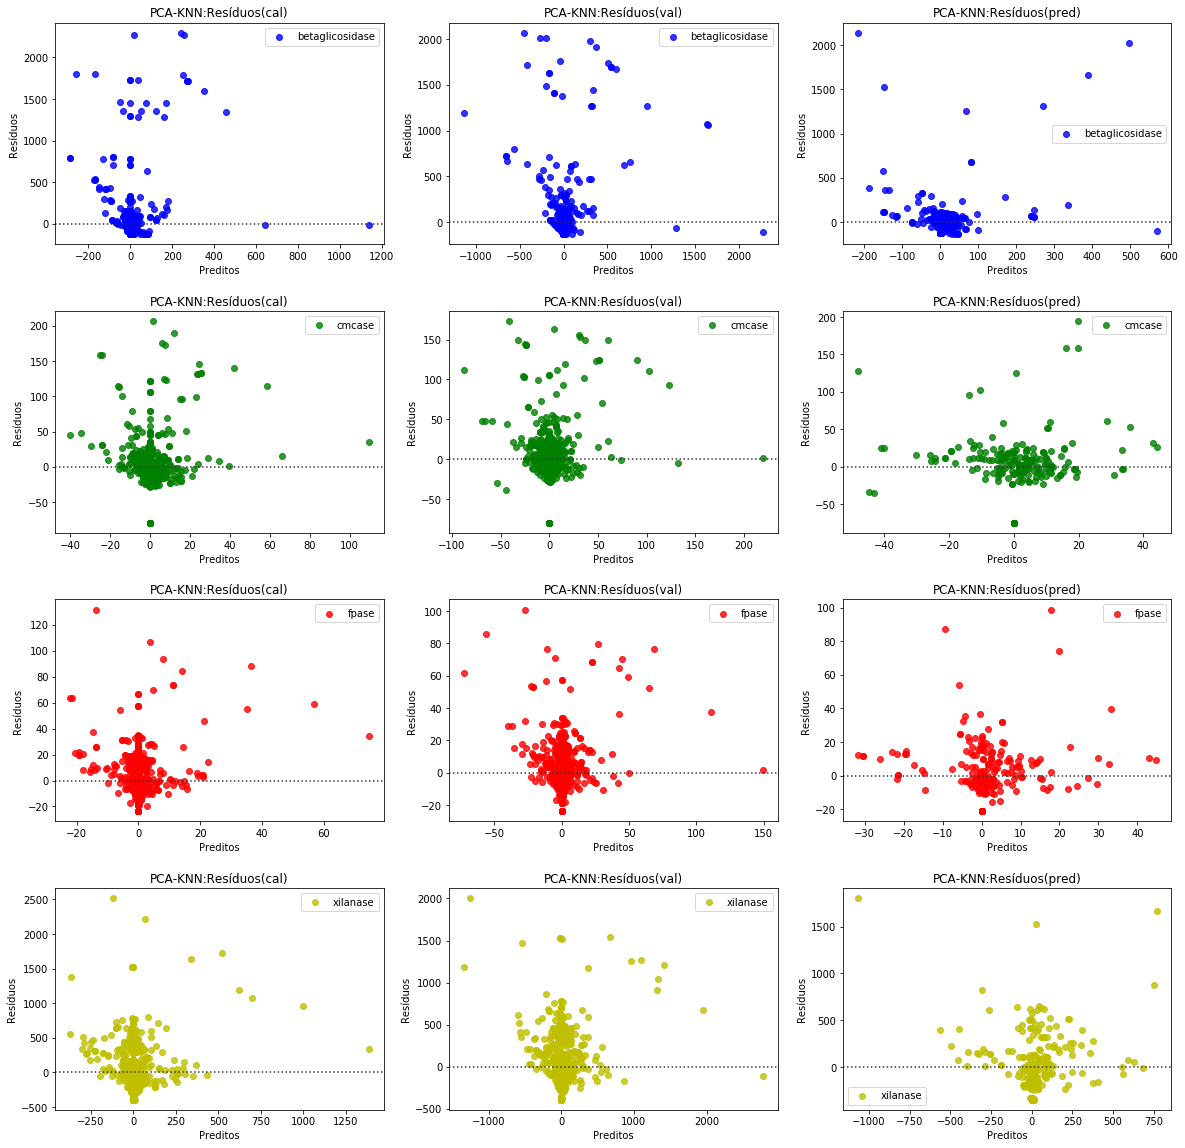

In [172]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

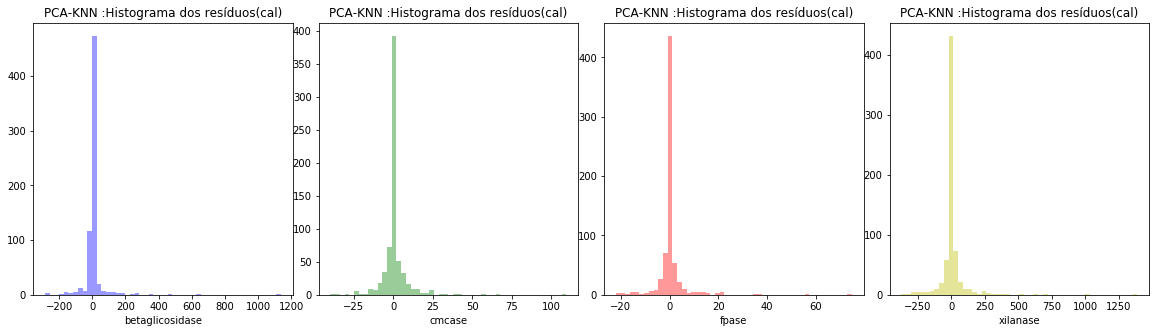

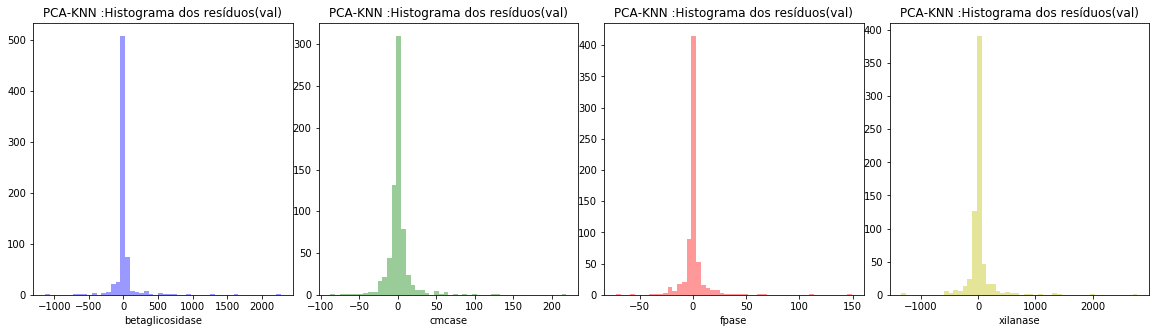

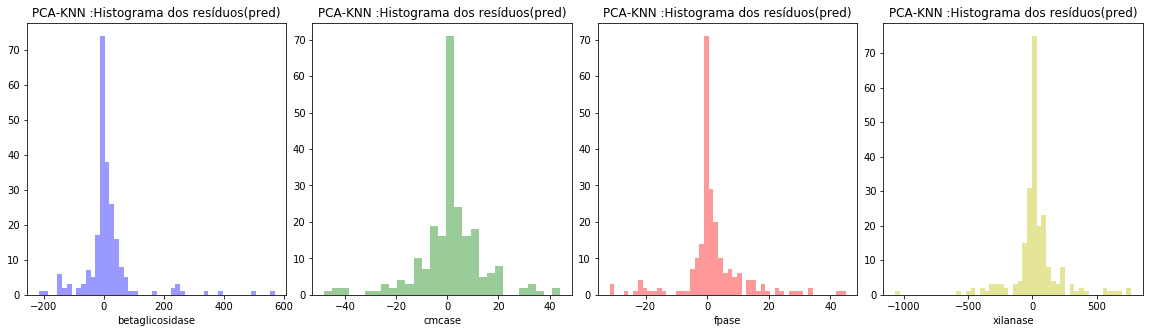

In [173]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

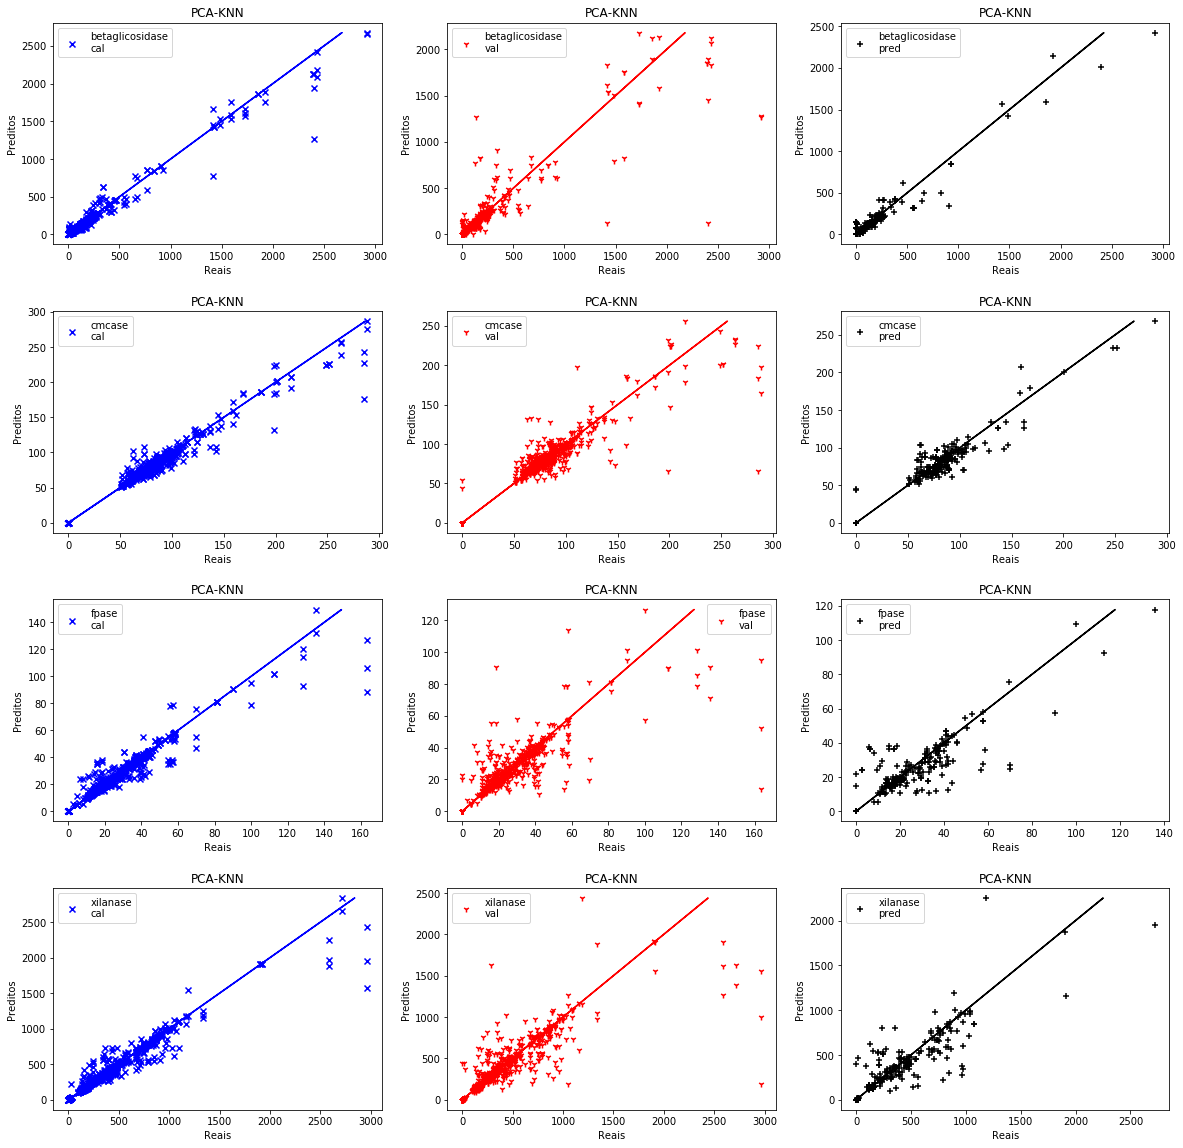

In [174]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

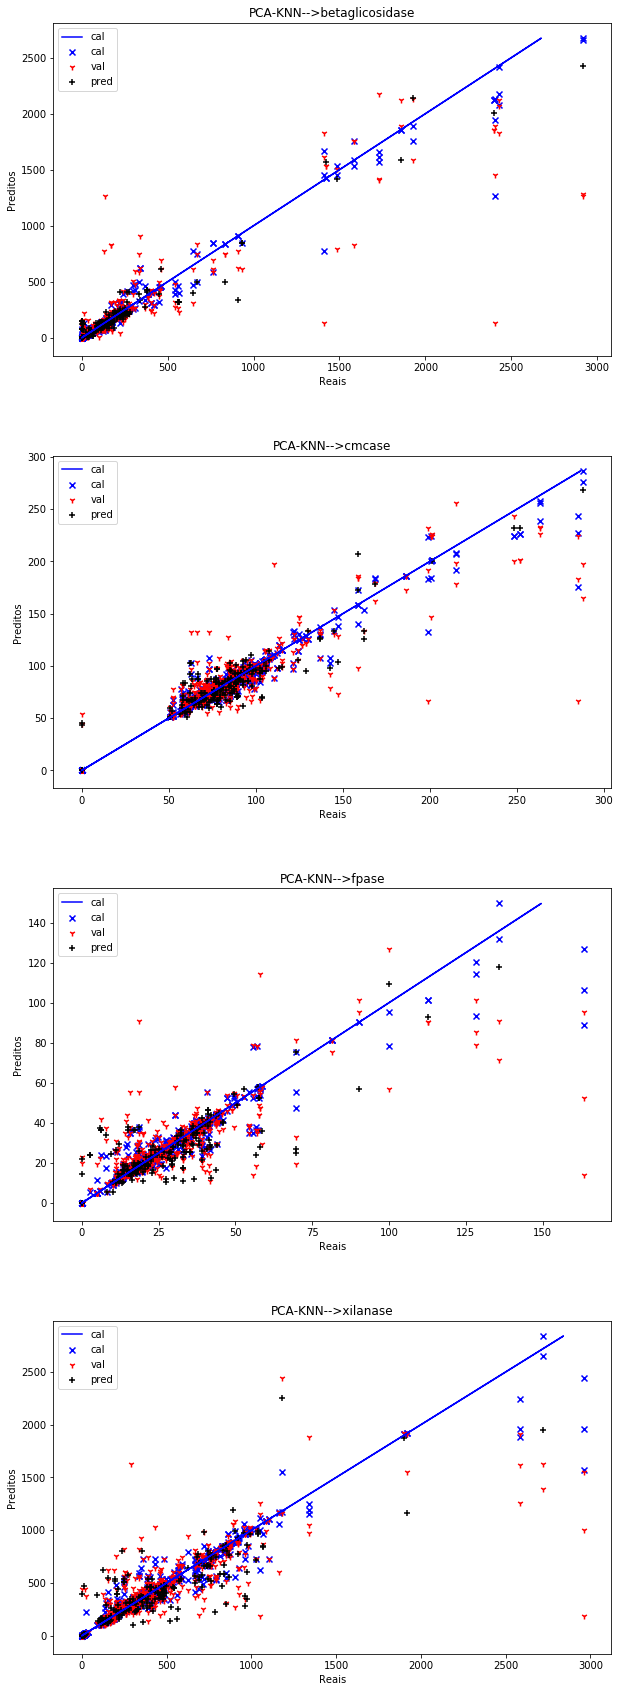

In [175]:
#graico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### PCA->KNN: Gráficos: dados de treino

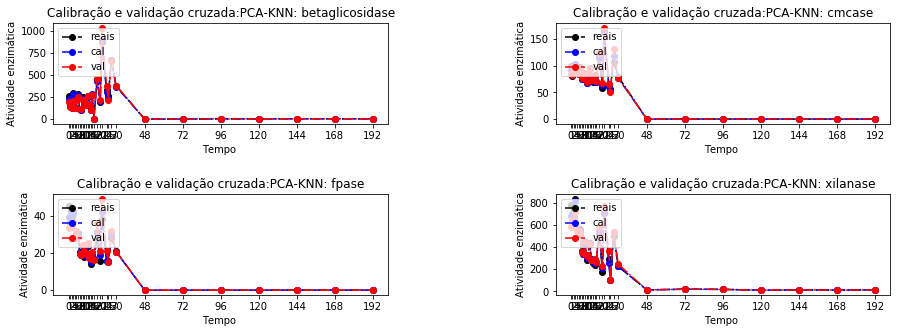

In [176]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

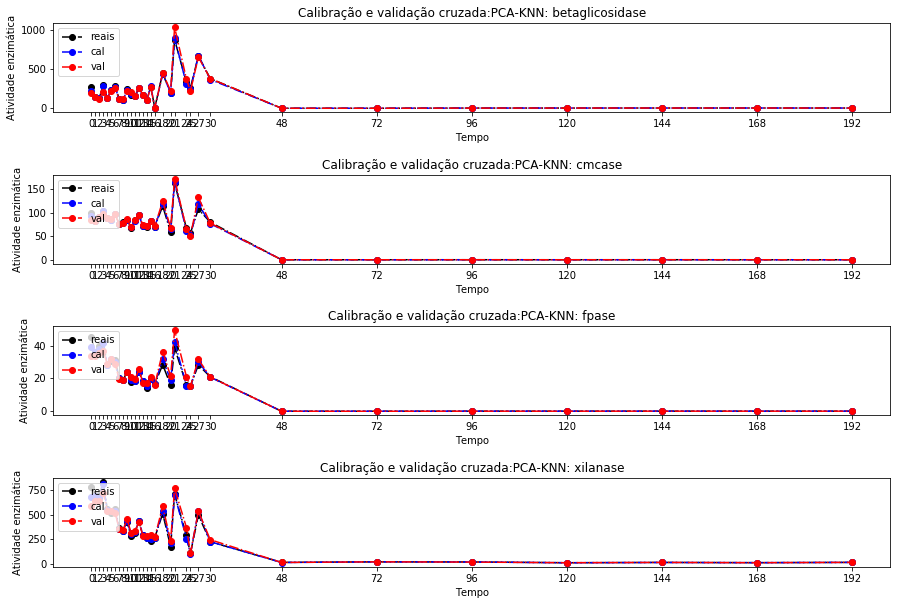

In [179]:
y_treino = treino_teste[2]
graficoTreinamentoG(modelo, y_treino, y_c,y_cv)

## KNN 

In [180]:
#knn
#função completa para execução do KNN:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3..9)
from sklearn.neighbors import KNeighborsRegressor
def executaKNN(preproc,k,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False,IC)
    
    
    # Cria um objeto de regressão linear
    reg = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=k))
    #reg = KNeighborsRegressor(n_neighbors=n)


    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result
    
    

### KNN: testes

In [194]:
#knn teste simples
modelo = 'KNN:'
preproc=1
k=2
result = executaKNN(preproc,k)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform'),
           n_jobs=None)


In [193]:
resultados['cal']

betaglicosidase    cmcase    fpase    xilanase
BIAS           0.1278   -0.2028   0.0223      0.7240
MSE        18026.1005  130.2777  72.1634  23942.7479
R2             0.8748    0.9348   0.8352      0.8469
RER           21.7218   25.2133  19.2119     19.1226
RMSE         134.2613   11.4139   8.4949    154.7344
RPD            2.8263    3.9159   2.4630      2.5557
RPIQ           1.1487    2.5778   2.5071      2.6693
SEP          134.3599   11.4205   8.5011    154.8465

In [183]:
resultados['val']

betaglicosidase    cmcase     fpase    xilanase
BIAS          -7.0826   -0.7391    0.0242      2.8402
MSE        28476.8587  241.2401  149.5096  49598.3959
R2             0.8022    0.8792    0.6585      0.6828
RER           17.2975   18.5466   13.3473     13.2871
RMSE         168.7509   15.5319   12.2274    222.7070
RPD            2.2487    2.8777    1.7112      1.7757
RPIQ           0.9139    1.8943    1.7418      1.8546
SEP          168.7261   15.5257   12.2364    222.8525

In [184]:
resultados['pred']

betaglicosidase    cmcase     fpase    xilanase
BIAS           2.4132    1.1203    1.8702     31.8879
MSE        20416.5442  229.8947  128.0070  42059.8129
R2             0.8556    0.8827    0.6932      0.7361
RER           20.3834   19.0012   12.1325     13.3952
RMSE         142.8865   15.1623   11.3140    205.0849
RPD            2.6314    2.9203    1.8055      1.9465
RPIQ           0.9868    1.5164    1.9652      2.5694
SEP          143.1818   15.1543   11.1830    203.0384

In [337]:
#knn teste completo
#Executa o modelo KNN variando o tipo de processamento e o número de vizinhos
for pre in range(0,12): 
    for viz in range(1,7):
        result = executaKNN(pre,viz)
        print('Pŕe-proc:',pre, '-> vizinhos:', viz,'\n')
        resultados=exibeResultados(result)
        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')

Pŕe-proc: 0 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS         -14.5422   -0.8152   -0.6657      -9.2825
MSE        82907.6157  531.8023  328.9972  124825.9815
R2             0.5544    0.7569    0.3487       0.3735
RER           10.1416   12.4852    9.0039       8.8935
RMSE         287.9368   23.0608   18.1383     353.3072
RPD            1.4980    2.0283    1.2391       1.2634
RPIQ           0.5136    1.2814    1.1674       1.3348
SEP          287.7774   23.0631   18.1392    

Pŕe-proc: 0 -> vizinhos: 6 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           2.1877   -0.2648   -0.0016      3.8225
MSE        40619.8550  319.5465  158.4481  63223.5967
R2             0.7817    0.8539    0.6863      0.6827
RER           14.4713   16.0983   12.9655     12.4935
RMSE         201.5437   17.8759   12.5876    251.4430
RPD            2.1401    2.6167    1.7855      1.7752
RPIQ           0.7338    1.6531    1.6822      1.8755
SEP          201.6776   17.8868   12.5967    251.5958 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.5899   -0.9372   -0.2384     -0.0218
MSE        50431.2792  473.5473  225.2224  88531.0463
R2             0.7289    0.7836    0.5541      0.5557
RER           12.9868   13.2349   10.8763     10.5567
RMSE         224.5691   21.7611   15.0074    297.5417
RPD            1.9207    2.1495    1.4976      1.5002
RPIQ           0.6586    1.3580    1.4109   

Pŕe-proc: 1 -> vizinhos: 5 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -4.7243   -0.0733   -0.0080     -0.1542
MSE        30997.9667  201.8612  118.0451  43911.4828
R2             0.8334    0.9077    0.7663      0.7796
RER           16.5707   20.2526   15.0214     14.9894
RMSE         176.0624   14.2078   10.8649    209.5507
RPD            2.4498    3.2922    2.0686      2.1301
RPIQ           0.8400    2.0799    1.9489      2.2505
SEP          176.1263   14.2179   10.8727    209.7022 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -5.8520   -0.5595   -0.0339     -0.9350
MSE        53281.6860  349.8670  192.2495  73442.7389
R2             0.7136    0.8401    0.6194      0.6314
RER           12.6387   15.3902   11.7707     11.5905
RMSE         230.8283   18.7047   13.8654    271.0032
RPD            1.8686    2.5007    1.6209      1.6471
RPIQ           0.6407    1.5799    1.5271   

Pŕe-proc: 2 -> vizinhos: 4 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0071    0.1856   -0.1149     -0.1679
MSE        35564.9634  273.0280  151.5018  55055.2907
R2             0.8088    0.8752    0.7001      0.7237
RER           15.4646   17.4150   13.2600     13.3867
RMSE         188.5868   16.5236   12.3086    234.6386
RPD            2.2871    2.8308    1.8259      1.9024
RPIQ           0.7842    1.7884    1.7203      2.0098
SEP          188.7232   16.5345   12.3170    234.8083 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -0.3964    0.1085   -0.0753       1.9697
MSE        66803.0999  514.6822  270.1770  100949.3684
R2             0.6409    0.7648    0.4651       0.4933
RER           11.2837   12.6834    9.9292       9.8862
RMSE         258.4630   22.6866   16.4371     317.7253
RPD            1.6688    2.0618    1.3673       1.4049
RPIQ           0.5722    1.3026    1.

Pŕe-proc: 3 -> vizinhos: 3 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.2930    0.1341   -0.1663     -0.1871
MSE        33699.0455  251.9613  137.3638  49747.2923
R2             0.8189    0.8848    0.7281      0.7503
RER           15.8870   18.1280   13.9265     14.0828
RMSE         183.5730   15.8733   11.7202    223.0410
RPD            2.3496    2.9468    1.9176      2.0013
RPIQ           0.8056    1.8617    1.8067      2.1144
SEP          183.7055   15.8842   11.7275    223.2023 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -1.5406   -0.0821   -0.3655      -2.6672
MSE        68589.8075  526.7546  287.8642  103982.6450
R2             0.6313    0.7592    0.4301       0.4781
RER           11.1360   12.5372    9.6214       9.7411
RMSE         261.8966   22.9511   16.9666     322.4634
RPD            1.6469    2.0380    1.3246       1.3842
RPIQ           0.5647    1.2876    1.

Pŕe-proc: 4 -> vizinhos: 2 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           2.8821    0.6898    0.3936      7.6273
MSE        28735.8861  210.1511  103.3405  40508.7385
R2             0.8455    0.9039    0.7954      0.7967
RER           17.2069   19.8713   16.0666     15.6175
RMSE         169.5166   14.4966   10.1657    201.2678
RPD            2.5444    3.2266    2.2109      2.2178
RPIQ           0.8724    2.0385    2.0829      2.3431
SEP          169.6147   14.4906   10.1654    201.2687 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -1.3062    0.2911   -0.1751      -2.2853
MSE        77644.4571  577.5672  321.1313  120952.6458
R2             0.5826    0.7360    0.3642       0.3929
RER           10.4665   11.9738    9.1078       9.0318
RMSE         278.6475   24.0326   17.9201     347.7825
RPD            1.5479    1.9463    1.2542       1.2835
RPIQ           0.5307    1.2296    1.

Pŕe-proc: 5 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           6.3902    1.1002    0.5465      10.9976
MSE       110815.3366  782.0341  418.9118  157722.3372
R2             0.4043    0.6426    0.1707       0.2084
RER            8.7626   10.2973    7.9768       7.9121
RMSE         332.8894   27.9649   20.4673     397.1427
RPD            1.2957    1.6726    1.0981       1.1239
RPIQ           0.4443    1.0567    1.0345       1.1875
SEP          333.0688   27.9634   20.4748    

Pŕe-proc: 5 -> vizinhos: 6 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           2.7308    0.3123    0.0511      4.1098
MSE        45300.3446  352.1246  177.7044  67033.1075
R2             0.7565    0.8391    0.6482      0.6636
RER           13.7036   15.3360   12.2430     12.1334
RMSE         212.8388   18.7650   13.3306    258.9075
RPD            2.0265    2.4927    1.6860      1.7240
RPIQ           0.6948    1.5748    1.5884      1.8215
SEP          212.9752   18.7760   13.3401    259.0622 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.2356   -0.0352    0.0447      3.2567
MSE        60893.5946  518.0489  250.2769  98582.3872
R2             0.6727    0.7632    0.5045      0.5052
RER           11.8186   12.6420   10.3163     10.0046
RMSE         246.7663   22.7607   15.8201    313.9783
RPD            1.7479    2.0551    1.4206      1.4216
RPIQ           0.5993    1.2983    1.3384   

Pŕe-proc: 6 -> vizinhos: 5 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           3.3473   -0.1293   -0.0651      3.2088
MSE        40624.9810  393.6347  186.2075  73688.3240
R2             0.7816    0.8201    0.6314      0.6302
RER           14.4715   14.5032   11.9602     11.5719
RMSE         201.5564   19.8402   13.6458    271.4559
RPD            2.1400    2.3576    1.6470      1.6443
RPIQ           0.7337    1.4895    1.5517      1.7373
SEP          201.6744   19.8542   13.6555    271.6333 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           2.6252   -0.6102   -0.1453       3.8397
MSE        61391.5166  616.6950  287.1078  114767.1177
R2             0.6700    0.7181    0.4316       0.4240
RER           11.7712   11.5903    9.6322       9.2724
RMSE         247.7731   24.8333   16.9443     338.7730
RPD            1.7408    1.8836    1.3264       1.3176
RPIQ           0.5969    1.1900    1.

Pŕe-proc: 7 -> vizinhos: 4 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.2933    0.1019   -0.0592      1.5002
MSE        38536.8925  343.0805  170.6950  67169.5154
R2             0.7929    0.8432    0.6621      0.6629
RER           14.8564   15.5349   12.4919     12.1198
RMSE         196.3082   18.5224   13.0650    259.1708
RPD            2.1972    2.5253    1.7202      1.7223
RPIQ           0.7534    1.5954    1.6207      1.8196
SEP          196.4499   18.5355   13.0743    259.3539 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.6117   -0.2543   -0.1933       0.6758
MSE        63398.2240  593.9827  291.0692  113842.4456
R2             0.6592    0.7285    0.4238       0.4286
RER           11.5828   11.8069    9.5667       9.3094
RMSE         251.7900   24.3718   17.0608     337.4055
RPD            1.7130    1.9192    1.3173       1.3229
RPIQ           0.5874    1.2125    1.

Pŕe-proc: 8 -> vizinhos: 3 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -7.9203   -0.3553   -0.2652    -12.0843
MSE        38445.8870  242.6571  129.3403  54807.5236
R2             0.7933    0.8891    0.7439      0.7249
RER           14.8861   18.4764   14.3544     13.4349
RMSE         196.0762   15.5775   11.3728    234.1101
RPD            2.1998    3.0027    1.9762      1.9067
RPIQ           0.7542    1.8970    1.8618      2.0144
SEP          196.0579   15.5847   11.3779    233.9671 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS         -13.5806   -0.9358   -0.3615    -13.3874
MSE        60523.3704  438.1585  242.6639  98510.1277
R2             0.6747    0.7997    0.5196      0.5056
RER           11.8728   13.7600   10.4797     10.0168
RMSE         246.0150   20.9322   15.5777    313.8632
RPD            1.7532    2.2346    1.4428      1.4222
RPIQ           0.6011    1.4118    1.3593   

Pŕe-proc: 9 -> vizinhos: 2 

cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS          -7.4263   -0.6126  -0.4976     -7.1689
MSE        13811.2044  113.5075  67.2281  27244.7016
R2             0.9258    0.9481   0.8669      0.8633
RER           24.8659   27.0525  19.9416     19.0477
RMSE         117.5211   10.6540   8.1993    165.0597
RPD            3.6702    4.3904   2.7411      2.7043
RPIQ           1.2584    2.7737   2.5825      2.8571
SEP          117.3710   10.6441   8.1901    165.0232 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS         -14.9991   -0.8758   -0.7096      -7.7891
MSE        66985.4041  458.1678  260.8162  101442.2175
R2             0.6399    0.7906    0.4836       0.4909
RER           11.2873   13.4540   10.1155       9.8649
RMSE         258.8154   21.4049   16.1498     318.4999
RPD            1.6665    2.1852    1.3916       1.4015
RPIQ           0.5714    1.3806    1.3111     

Pŕe-proc: 10 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS         -25.0546   -1.3872   -1.3318     -22.5372
MSE       131883.4054  989.8777  549.0437  217755.3277
R2             0.2911    0.5476   -0.0870      -0.0929
RER            8.0499    9.1545    6.9764       6.7390
RMSE         363.1575   31.4623   23.4317     466.6426
RPD            1.1877    1.4867    0.9592       0.9565
RPIQ           0.4072    0.9393    0.9037       1.0106
SEP          362.5543   31.4545   23.4107   

Pŕe-proc: 10 -> vizinhos: 6 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -3.9098   -0.5327   -0.2624     -3.4923
MSE        51756.6136  452.2505  212.7237  87267.2525
R2             0.7218    0.7933    0.5789      0.5620
RER           12.8213   13.5347   11.1917     10.6336
RMSE         227.5008   21.2662   14.5851    295.4103
RPD            1.8959    2.1995    1.5409      1.5110
RPIQ           0.6501    1.3896    1.4518      1.5964
SEP          227.6317   21.2749   14.5932    295.6033 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -4.9479   -1.2723   -0.4590      -9.0565
MSE        64244.9584  626.6027  280.6453  113522.1348
R2             0.6547    0.7136    0.4444       0.4302
RER           11.5084   11.5098    9.7458       9.3259
RMSE         253.4659   25.0320   16.7525     336.9305
RPD            1.7017    1.8686    1.3416       1.3248
RPIQ           0.5835    1.1805    1

Pŕe-proc: 11 -> vizinhos: 5 

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -4.2568   -0.2425   -0.2317     -2.1092
MSE        44528.0635  385.2985  189.4817  73959.2416
R2             0.7607    0.8239    0.6249      0.6288
RER           13.8236   14.6600   11.8580     11.5502
RMSE         211.0167   19.6290   13.7652    271.9545
RPD            2.0440    2.3829    1.6327      1.6413
RPIQ           0.7008    1.5055    1.5383      1.7341
SEP          211.1264   19.6417   13.7732    272.1430 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -3.9686   -0.9175   -0.3990      -6.2279
MSE        68097.5536  642.4960  298.5720  119432.9510
R2             0.6340    0.7063    0.4089       0.4006
RER           11.1773   11.3593    9.4477       9.0904
RMSE         260.9551   25.3475   17.2792     345.5907
RPD            1.6529    1.8453    1.3007       1.2916
RPIQ           0.5667    1.1658    1

In [197]:
#Executa o modelo KNN variando os pre-proc mais efetivos
for pre in [1,8,9]: 
    for viz in range(1,4):
        result = executaKNN(pre,viz,0)
        print('Pŕe-proc:',pre, '-> vizinhos:', viz,'\n')
        resultados=exibeResultados(result)
        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')

Pŕe-proc: 1 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS         -10.5048   -0.7948   -0.0245     -0.0317
MSE        43963.1456  327.8316  212.5655  67849.9996
R2             0.6947    0.8359    0.5144      0.5661
RER           13.9267   15.9070   11.1939     11.3594
RMSE         209.6739   18.1061   14.5796    260.4803
RPD            1.8098    2.4685    1.4351      1.5182
RPIQ           0.7356    1.6250    1.4608      1.5856
SEP          209.5645   18.1020   14.5903    260.6718

cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS           2.0086   -0.1662  -0.0286     -1.3841
MSE        21730.0242  169.6326  97.5013  33496.0890
R2             0.8491    0.9151   0.7773      0.7858
RER           19.7859   22.0941  16.5282     16.1676
RMSE         147.4111   13.0243   9.8743    183.0194
RPD            2.5742    3.4317   2.1190      2.1607
RPIQ           1.0463    2.2591   2.1568      2.2568
SEP          147.5057   13.0328   9.8815    183.1487 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           5.7406   -0.3610    0.0838     -2.3350
MSE        55376.7984  393.7995  223.1778  80971.0856
R2             0.6154    0.8029    0.4902      0.4822
RER           12.3969   14.5021   10.9247     10.3987
RMSE         235.3228   19.8444   14.9391    284.5542
RPD            1.6125    2.2523    1.4006      1.3897
RPIQ           0.6554    1.4827    1.4256      1.4515
SEP          235.4256   19.8

In [195]:
#teste 2 escolhendo o modelo otimizado
#knn otimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaKNN(1,2,i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.9396, 0.9265, 0.7729, 0.7959] 
semente: b c f x [10, 26, 26, 93]


In [210]:
#knn teste otimizado
#@knnotimizado
preproc=1
k=2
gera=98
result = executaKNN(preproc,k, gera)
print('Parâmetros do modelo:',modelo,'\n',result[0])
resultados=exibeResultados(result)

Parâmetros do modelo: KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform'),
           n_jobs=None)


In [214]:
resultados['cal']

betaglicosidase   cmcase    fpase    xilanase
BIAS           1.5700   0.2370   0.4190      8.6763
MSE        12041.4632  97.9944  57.0921  20172.5883
R2             0.9279   0.9553   0.8841      0.8855
RER           26.5798  29.0750  21.6326     20.8718
RMSE         109.7336   9.8992   7.5559    142.0302
RPD            3.7253   4.7322   2.9375      2.9559
RPIQ           1.4472   2.8416   2.9639      3.5205
SEP          109.8030   9.9036   7.5499    141.8692

In [215]:
resultados['val']


betaglicosidase    cmcase     fpase    xilanase
BIAS          -6.7034   -0.6260   -0.1393      2.5421
MSE        27651.4421  270.3922  157.6832  53293.8450
R2             0.8345    0.8768    0.6799      0.6976
RER           17.5526   17.5111   12.9976     12.8179
RMSE         166.2872   16.4436   12.5572    230.8546
RPD            2.4583    2.8489    1.7675      1.8186
RPIQ           0.9550    1.7107    1.7834      2.1659
SEP          166.2742   16.4438   12.5657    231.0103

In [216]:
resultados['pred']

betaglicosidase    cmcase    fpase    xilanase
BIAS           0.1007    0.7144   0.7511     19.2379
MSE         6241.2270  134.7613  74.5182  25185.9994
R2             0.9123    0.9017   0.7014      0.7462
RER           30.2803   21.6735  13.0659     12.1441
RMSE          79.0014   11.6087   8.6324    158.7010
RPD            3.3775    3.1888   1.8300      1.9850
RPIQ           1.9247    2.1546   2.1455      2.2295
SEP           79.1760   11.6123   8.6187    157.8788

In [217]:
#variáveis para geração de gráficos e testes
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [218]:
#knn reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0           112.8821   73.2487   17.8592   387.4296               122.0297   
1           205.1579   85.6789   22.9796   527.6314               212.1530   
2            84.0149   72.7848   22.2422   312.6571                99.5920   
3           123.0794   77.4893   36.4128   564.8606               114.6817   
4           221.1730   85.8026   37.0534   742.9250               221.1730   
5             2.5282   77.6603    6.2611   249.1409                 2.5282   
6           241.6059  104.7929   36.2992   851.6944               192.6405   
7           258.9095   87.7807   33.3814   744.8376               230.0088   
8             6.2377   73.0903   15.7726   340.3182                71.2614   
9           237.1880  105.6089   42.4315   916.3074               213.8097   
10            2.6470    0.0670    0.0600    17.3620                 2.6470   
11          136.4258   69.6430   19.6295   313.4518               133.8015   
12          111.4287   84.2712   21.4864   277.5546                73.7187   
13          113.3065   77.5002   33.0827   929.3628               107.6950   
14            8.5060   70.2514   18.5086   344.4095                 8.7895   
15          150.4284   82.0484   32.7732   828.1488               150.7163   
16          174.3269   88.8776   41.5095   483.9741               151.3408   
17          135.4855   70.8114   10.9859   165.4290               131.9201   
18            4.1585   67.8136   15.9629   351.4762                 6.6158   
19           97.5113   73.9894   13.4762   248.3601                97.5113   
20         2403.2200  285.3140  163.3280  2961.1440              1265.6510   
21           89.8645   85.1385   12.9388   261.2070               108.7450   
22          115.1690   69.4884   18.7708   277.7633                99.5920   
23            4.9510    0.0380    0.0560    18.4400                 4.9510   
24           60.8811   58.3073   16.4854   354.1907                60.8811   
25          122.1230   96.9230   25.5450   378.6580               122.1230   
26            2.3510    0.0300    0.0100     1.5020                 2.3510   
27          237.1880   89.6847   43.6678   924.0410               229.1805   
28            5.5289   62.7837   18.6321   247.3351                 5.8833   
29          453.6864   76.7033   48.7880   510.5922               644.0905   
..               ...       ...       ...        ...                    ...   
651           6.2377   73.0903   15.7726   340.3182                91.6286   
652         115.7786   87.2116   12.1474   152.4512               115.7786   
653         219.1481  106.0787   39.0686   707.2506               228.9044   
654         139.2130   85.3606   23.8136   464.2393               135.9231   
655         380.0074   79.7861   40.9537   410.5377               573.2145   
656           2.9774    0.0704    0.0567    10.8002                 3.0421   
657         196.6902  105.5594   37.1234   861.1743               203.6853   
658         145.1984   75.6010   43.7056   787.6607               136.5383   
659           3.5610    0.0586    0.0561    10.0978                 3.5610   
660          10.7690   78.1370    4.8320    19.4100                11.5385   
661        2403.2200  285.3140  163.3280  2961.1440              2165.2440   
662           0.0554    0.0181    0.0106     0.3275                 0.0554   
663         150.4284   82.0484   32.7732   828.1488               154.5053   
664        1855.8680  201.0750   90.3270  1917.3610              1891.5680   
665         158.5821   77.3812   31.1380   832.2265               158.5821   
666         136.8757   63.2618   13.4966   214.6944               130.5774   
667         200.7020  130.1010   25.0710   346.5400               237.1410   
668         462.4958  114.8003   50.3436   575.5490               462.4958   
669           3.8800    0.0350    0.0510    24.0940                 3.8800   
670         160.4800  137.0

In [219]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)

VALIDAÇÃO CRUZADA:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0           112.8821   73.2487   17.8592   387.4296               126.2660   
1           205.1579   85.6789   22.9796   527.6314               224.3023   
2            84.0149   72.7848   22.2422   312.6571               141.4869   
3           123.0794   77.4893   36.4128   564.8606               113.5570   
4           221.1730   85.8026   37.0534   742.9250               195.8619   
5             2.5282   77.6603    6.2611   249.1409                77.7367   
6           241.6059  104.7929   36.2992   851.6944               143.6750   
7           258.9095   87.7807   33.3814   744.8376               222.0473   
8             6.2377   73.0903   15.7726   340.3182               156.6523   
9           237.1880  105.6089   42.4315   916.3074               166.8692   
10            2.6470    0.0670    0.0600    17.3620                 2.5665   
11          136.4258   69.6430   19.6295   313.4518               122.0297   
12          111.4287   84.2712   21.4864   277.5546                86.1469   
13          113.3065   77.5002   33.0827   929.3628               116.6119   
14            8.5060   70.2514   18.5086   344.4095                 6.6630   
15          150.4284   82.0484   32.7732   828.1488               154.7932   
16          174.3269   88.8776   41.5095   483.9741               144.9663   
17          135.4855   70.8114   10.9859   165.4290               131.5150   
18            4.1585   67.8136   15.9629   351.4762                 6.6630   
19           97.5113   73.9894   13.4762   248.3601                97.5113   
20         2403.2200  285.3140  163.3280  2961.1440              1279.8540   
21           89.8645   85.1385   12.9388   261.2070               108.7450   
22          115.1690   69.4884   18.7708   277.7633               126.4722   
23            4.9510    0.0380    0.0560    18.4400                 4.0295   
24           60.8811   58.3073   16.4854   354.1907                61.9189   
25          122.1230   96.9230   25.5450   378.6580               141.1705   
26            2.3510    0.0300    0.0100     1.5020                 2.5235   
27          237.1880   89.6847   43.6678   924.0410               229.1805   
28            5.5289   62.7837   18.6321   247.3351                91.6286   
29          453.6864   76.7033   48.7880   510.5922               619.0636   
..               ...       ...       ...        ...                    ...   
651           6.2377   73.0903   15.7726   340.3182                91.2742   
652         115.7786   87.2116   12.1474   152.4512               115.7786   
653         219.1481  106.0787   39.0686   707.2506               234.0586   
654         139.2130   85.3606   23.8136   464.2393               135.9231   
655         380.0074   79.7861   40.9537   410.5377               766.4216   
656           2.9774    0.0704    0.0567    10.8002                 3.1068   
657         196.6902  105.5594   37.1234   861.1743               203.6853   
658         145.1984   75.6010   43.7056   787.6607               122.5545   
659           3.5610    0.0586    0.0561    10.0978                 3.5610   
660          10.7690   78.1370    4.8320    19.4100                11.5385   
661        2403.2200  285.3140  163.3280  2961.1440              1829.8730   
662           0.0554    0.0181    0.0106     0.3275                 0.1113   
663         150.4284   82.0484   32.7732   828.1488               158.5821   
664        1855.8680  201.0750   90.3270  1917.3610              2162.3845   
665         158.5821   77.3812   31.1380   832.2265               157.8911   
666         136.8757   63.2618   13.4966   214.6944               126.0786   
667         200.7020  130.1010   25.0710   346.5400               262.3010   
668         462.4958  114.8003   50.3436   575.5490               462.4958   
669           3.8800    0.0350    0.0510    24.0940                 2.7320   
670         160.4800  137.0

In [220]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0            23.7272   72.8568   14.8860   376.9820                52.7329   
1           110.4872   97.6145   30.0285   419.8360               127.6254   
2           165.0622   95.2081   35.3039   451.2079               173.4085   
3           120.9050   88.0053   41.2312   765.1206               125.7974   
4             3.8994    0.1118    0.0613    10.9512                 3.5031   
5           100.4355   87.3867   22.3969   359.6879               103.3035   
6            89.7074   65.3003   13.8382   361.1810                87.2476   
7           141.3745   64.6455   18.7057   303.7711               129.5089   
8          1586.9160  200.3440   57.0920  1163.2500              1829.8730   
9           237.1880   89.6847   43.6678   924.0410               237.1880   
10          222.2382   59.5638   18.2990   117.1842               337.3617   
11          205.7102   68.9223   17.3913   313.7515               188.1305   
12           66.4158   85.3345   17.5689   434.6522                97.0485   
13          252.6508  101.0838   18.2650   418.8620               237.9243   
14          237.1880  105.6089   42.4315   916.3074               218.4118   
15            8.5060   70.2514   18.5086   344.4095                 8.2225   
16          188.3146   92.4294   41.9740   974.9331               216.0187   
17          150.4284   82.0484   32.7732   828.1488               150.7163   
18           92.4876   78.8649   10.9856   212.8161                99.3108   
19          647.8945   62.3355   19.8263   129.4946               507.3439   
20          766.4216   83.5477   47.2466   469.7322               391.8200   
21          254.0314  102.2460   38.1949   840.3019               227.5698   
22           60.8811   58.3073   16.4854   354.1907                52.7329   
23          150.8708   98.4659   29.4593   480.9710               112.6993   
24           83.2171   97.5299   22.7053   378.6273                64.0786   
25          152.1716   79.6951   30.5321   430.4869               129.5089   
26          273.5800  162.1220   69.8540   962.5400               210.9525   
27           92.4876   78.8649   10.9856   212.8161                96.8365   
28            2.5282   77.6603    6.2611   249.1409                 2.5282   
29            1.5840    0.0310    0.0580    20.8190                 3.2675   
..               ...       ...       ...        ...                    ...   
197        1411.9200  198.7880   55.8310  1050.1520              1609.2160   
198          94.7370   77.3428   38.3458   759.9913                94.4371   
199         142.7241   85.5472   39.2493   762.8088               135.0762   
200         247.1283   89.7259   36.2332   858.6796               221.1730   
201          43.4332   74.4395    9.3709    92.2816                84.2733   
202         258.9095   87.7807   33.3814   744.8376               201.1082   
203         122.6898   94.6548   44.7064   849.9481               122.6898   
204           0.1671    0.0117    0.0104     0.1117                 0.1113   
205           2.9123    0.1058    0.0747    14.6813                 3.2548   
206         133.3696   92.5100   19.7398   668.0269               133.3696   
207          84.0149   72.7848   22.2422   312.6571               107.4086   
208        2397.5010  251.6900  112.6160  1901.4399              2162.3845   
209         248.6120  158.4460   69.6480   905.4550               266.7835   
210         106.1714   76.0080   22.7550   276.9686               106.1714   
211          84.0149   72.7848   22.2422   312.6571               125.7974   
212          23.7272   72.8568   14.8860   376.9820                49.5043   
213         117.2695   88.7665   16.2567   359.8273               116.5241   
214         110.7827   64.7025   10.9693   249.0103               123.6043   
215           8.0807   78.6756   15.3251   265.5598                 8.0807   
216         449.2816   57.7

### KNN: Gráficos dos resíduos

In [162]:
#knnGraf

In [221]:
#título para os gráficos
modelo = 'KNN'

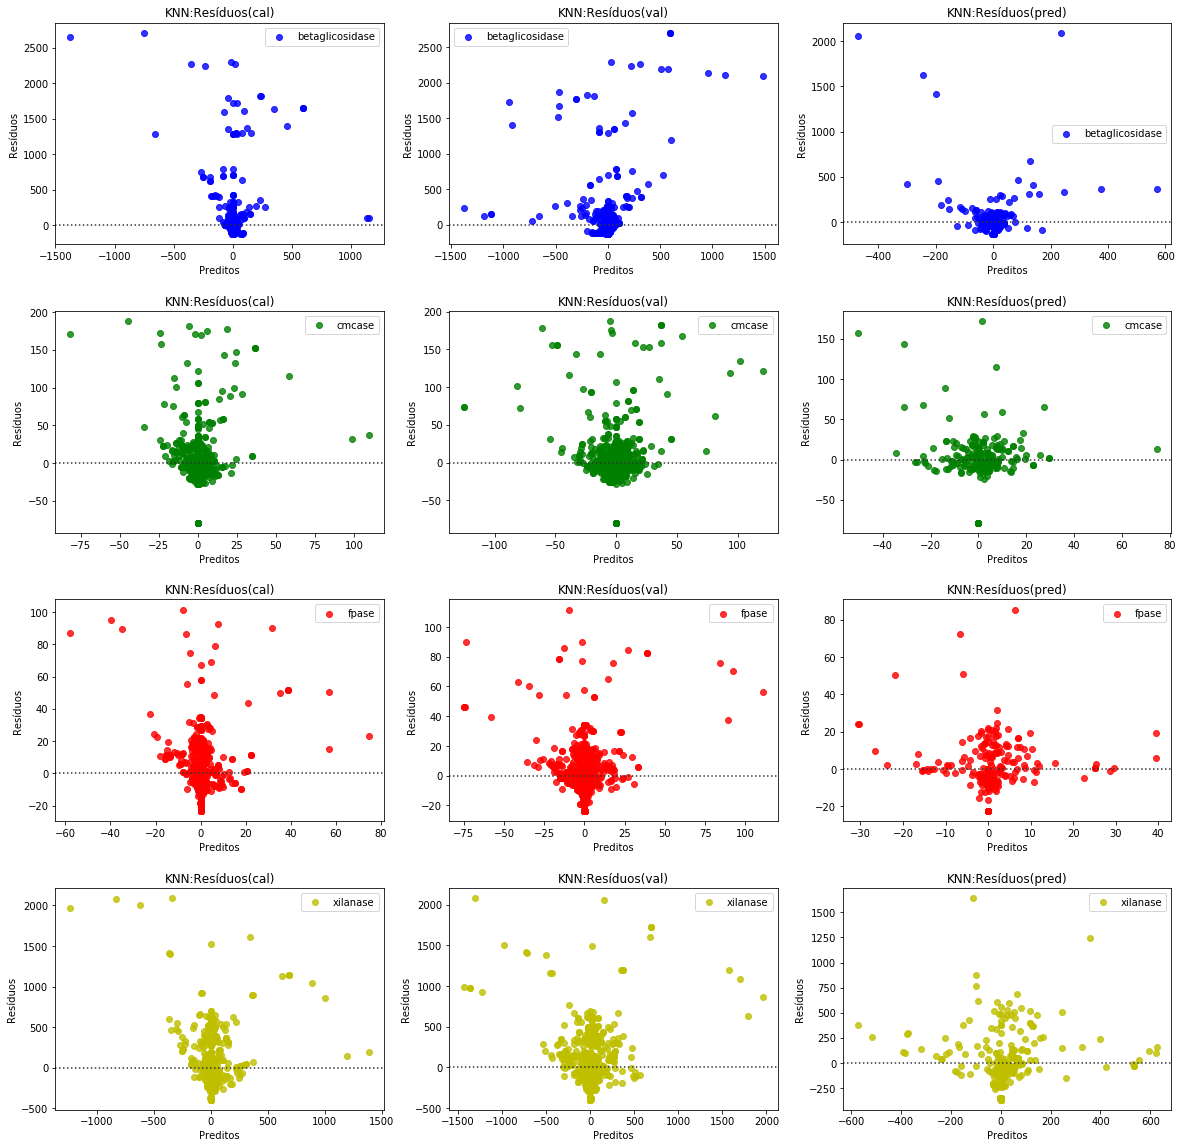

In [222]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

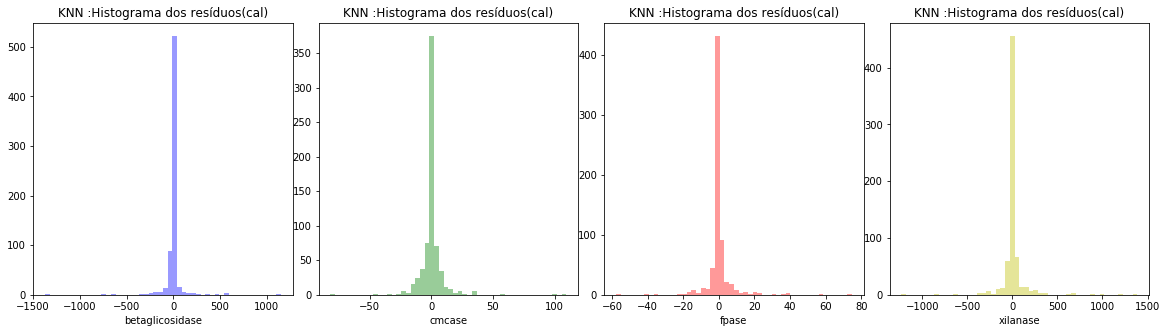

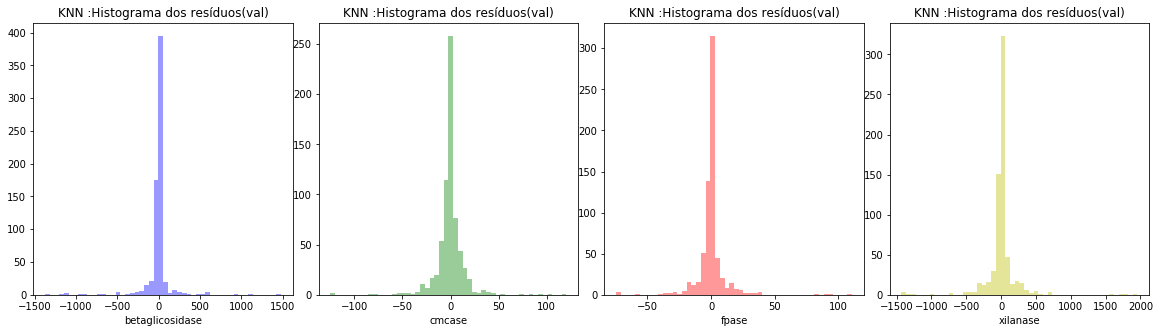

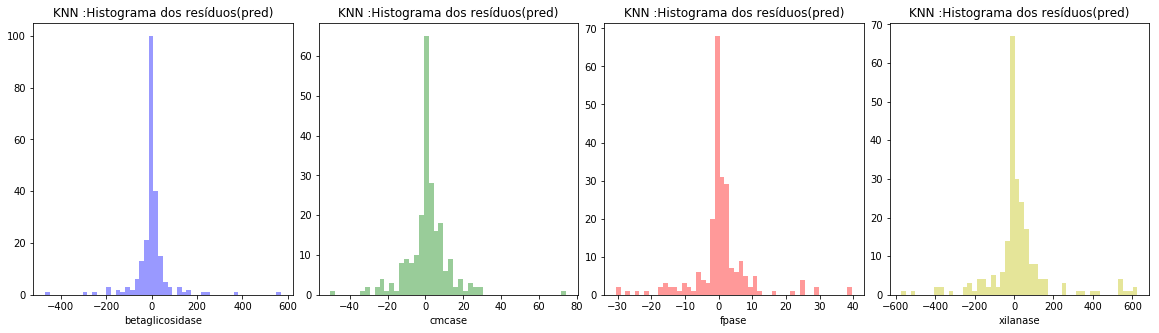

In [223]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

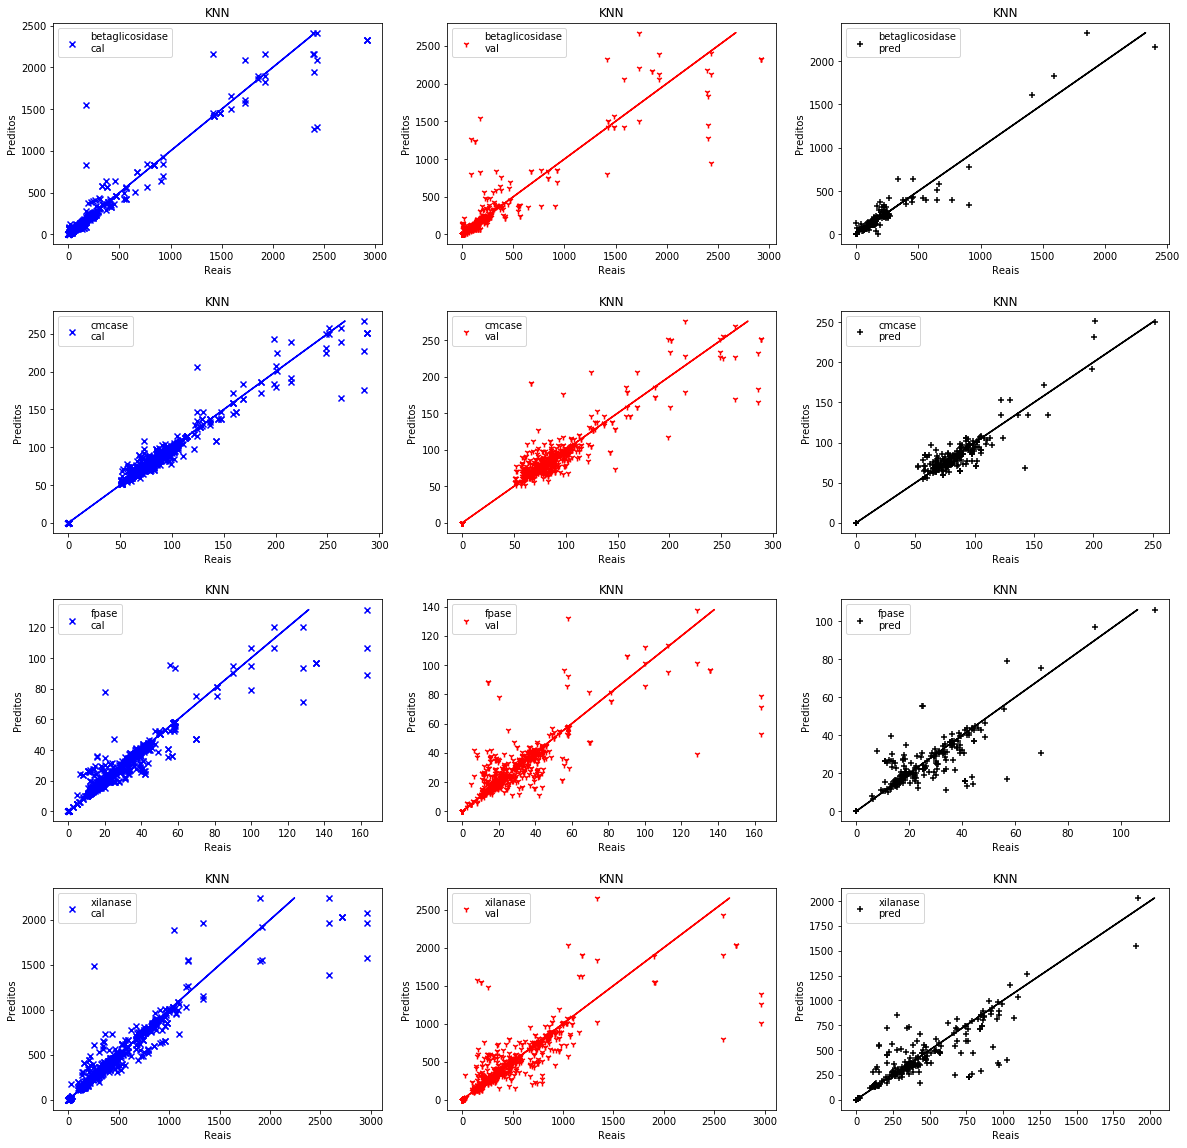

In [224]:
#grafico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

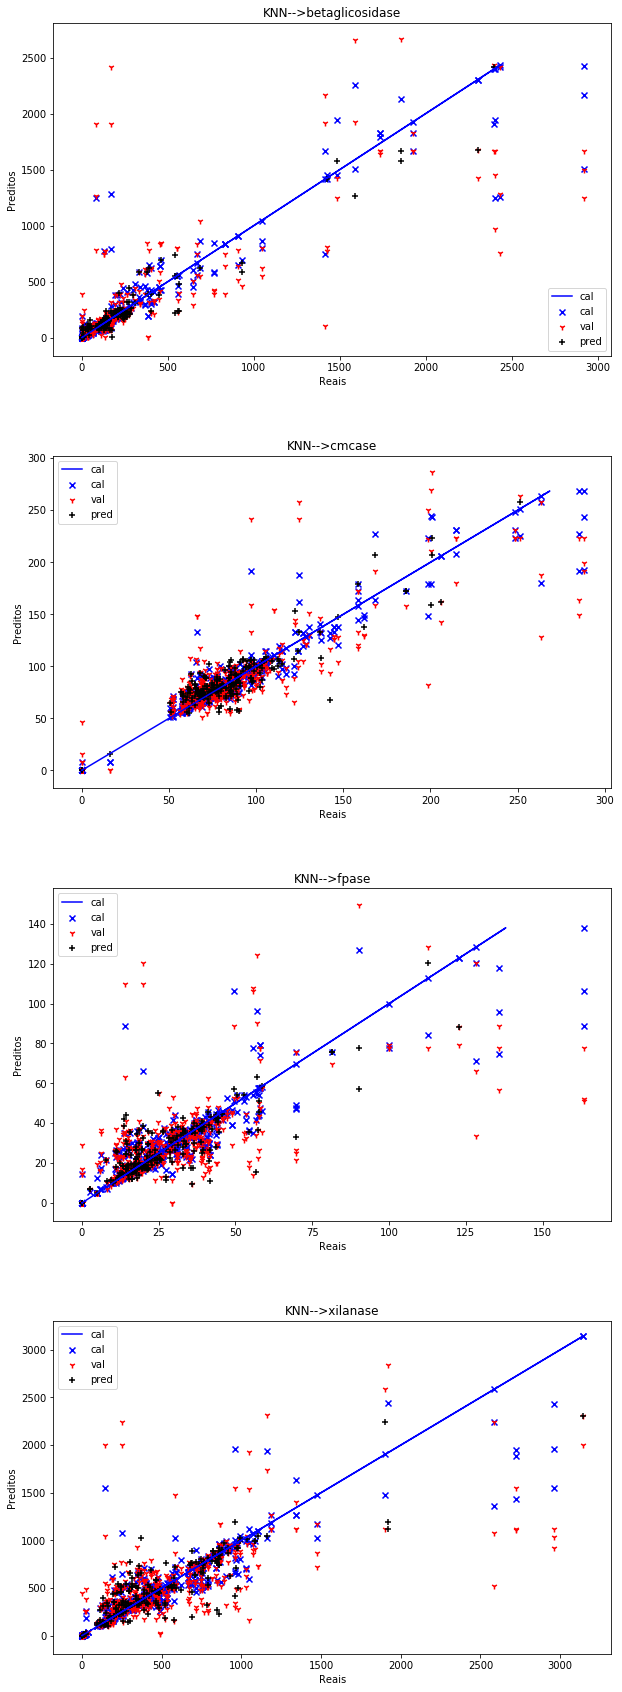

In [119]:
#grafico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### KNN: Gráficos: dados de treino

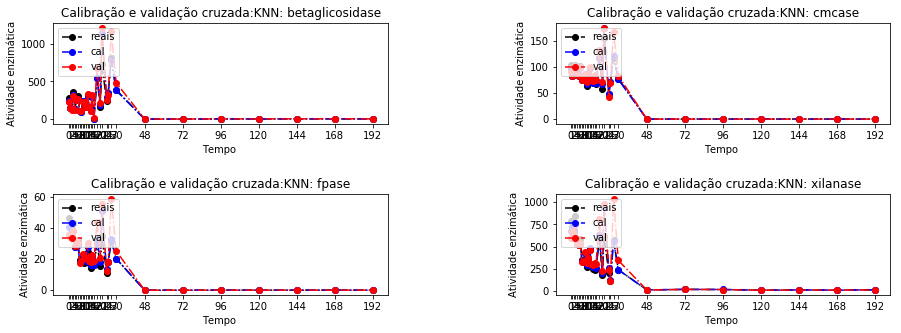

In [225]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### KNN:Gráficos de teste

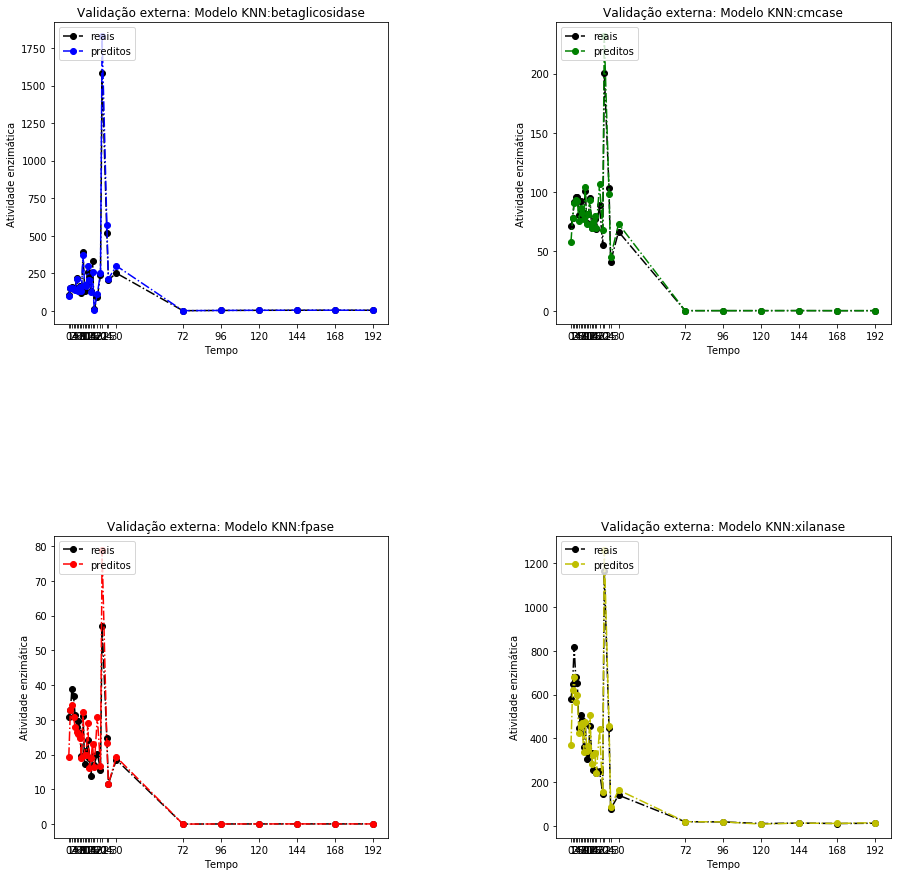

In [226]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

## GBR: Gradient Boost Regressor


In [227]:
#gbr
#função completa para execução do GBR
def executaGBR(preproc=1, varLoss='ls',n_est=100,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False,IC)

    
    reg = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=n_est,
                                                                  learning_rate=0.1,
                                                                  max_depth=2, 
                                                                  random_state=0, loss=varLoss))

   
    #reg=MultiOutputRegressor(xgb.XGBRegressor())
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result


In [228]:
#função completa para execução do GBR com PCA
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3)
def executaPCA_GBR(preproc, varLoss,nPC=3,n_est=100, IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False, IC)

    
    reg = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=n_est,
                                                                  learning_rate=0.1,
                                                                  max_depth=8, 
                                                                  random_state=IC, loss=varLoss))  
   

   # Roda o PCA e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pca = PCA(n_components=nPC)
    x_treino = pca.fit_transform(x_treino)[:,:nPC]
    x_teste = pca.fit_transform(x_teste)[:,:nPC] 
    
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result


### GBR testes

In [229]:

warnings.filterwarnings("ignore")
#GBR teste simples
modelo = 'GBR:'
result = executaGBR(preproc=1, varLoss='ls',n_est=100, IC=0)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
    
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: GBR: 
 MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...ate=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
           n_jobs=None)
cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS           0.0000   -0.0000  -0.0000     -0.0000
MSE         3595.9098  122.2953  70.6541  21802.7577
R2             0.9750    0.9388   0.8386      0.8606
RER           48.6342   26.0190  19.4160     20.0389
RMSE          59.9659   11.0587   8.4056    147.6576
RPD            6.3280    4.0417   2.4892      2.6782
RPIQ           2.5720    2.6606   2.5337      2.7972
SEP           60.0100   11.0669   8.4118    147.7661 
---------------------------------------

In [136]:

#gbrtestes
#Executa o modelo GBR variando o tipo de processamento  e  o parâmetro loss
loss_valores = ['ls', 'huber']
for k, v in preProc.items():
    print( 'GBR:\n\t'+v)
    for var in loss_valores:
        print('\n>>>>\tLoss:'+var)
        result = executaGBR(k, var)
        #print('Parâmetros do modelo:',modelo,'\n',result[0])

        resultados=exibeResultados(result)

        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')

GBR:
	Pré-proc: 0--> Sem pré-processamento

>>>>	Loss:ls
cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS           0.0000    0.0000   0.0000     -0.0000
MSE         4986.1081  168.0210  81.1900  29116.6268
R2             0.9732    0.9232   0.8393      0.8539
RER           41.3019   22.1982  18.1127     18.4079
RMSE          70.6124   12.9623   9.0105    170.6359
RPD            6.1083    3.6085   2.4943      2.6159
RPIQ           2.0944    2.2798   2.3500      2.7637
SEP           70.6635   12.9717   9.0171    170.7594 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           5.2389   -0.0329   -0.0213       2.1495
MSE        57358.2294  585.9619  272.7390  106713.4496
R2             0.6917    0.7322    0.4600       0.4644
RER           12.1803   11.8868    9.8823       9.6155
RMSE         239.4958   24.2067   16.5148     326.6702
RPD            1.8010    1.9323    1.3609       1.3664
RPIQ           0.6

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          14.9677    0.9835    1.0702     25.2427
MSE        19211.6209  214.8874  119.1047  46680.7770
R2             0.8967    0.9018    0.7642      0.7657
RER           21.1649   19.6732   15.0268     14.6383
RMSE         138.6060   14.6590   10.9135    216.0573
RPD            3.1119    3.1909    2.0594      2.0660
RPIQ           1.0670    2.0159    1.9402      2.1827
SEP          137.8951   14.6366   10.8688    214.7329 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          15.1727    1.1407    1.2404      31.9616
MSE        60600.3650  527.9048  272.8898  106632.2094
R2             0.6743    0.7587    0.4597       0.4648
RER           11.8697   12.5389    9.9076       9.6654
RMSE         246.1714   22.9762   16.5194     326.5459
RPD            1.7521    2.0358    1.3605       1.3669
RPIQ           0.6008    1.2862    1.2818       1.4442
SEP        

cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS          -0.0000   -0.0000  -0.0000     -0.0000
MSE         5584.4259  152.5824  79.0045  26877.1134
R2             0.9700    0.9303   0.8436      0.8651
RER           39.0267   23.2942  18.3615     19.1594
RMSE          74.7290   12.3524   8.8884    163.9424
RPD            5.7718    3.7867   2.5285      2.7227
RPIQ           1.9790    2.3923   2.3822      2.8765
SEP           74.7831   12.3614   8.8949    164.0610 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           1.8129    0.3086    0.1361       0.5145
MSE        76455.8704  699.5748  305.5315  120229.0044
R2             0.5890    0.6803    0.3951       0.3966
RER           10.5476   10.8796    9.3372       9.0588
RMSE         276.5065   26.4495   17.4795     346.7405
RPD            1.5599    1.7685    1.2858       1.2873
RPIQ           0.5349    1.1173    1.2114       1.3601
SEP          276.700

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          14.9677    0.9835    1.0702     25.2427
MSE        19211.6209  214.8874  119.1047  46680.7770
R2             0.8967    0.9018    0.7642      0.7657
RER           21.1649   19.6732   15.0268     14.6383
RMSE         138.6060   14.6590   10.9135    216.0573
RPD            3.1119    3.1909    2.0594      2.0660
RPIQ           1.0670    2.0159    1.9402      2.1827
SEP          137.8951   14.6366   10.8688    214.7329 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          15.1727    1.1407    1.2404      31.9616
MSE        60600.3650  527.9048  272.8898  106632.2094
R2             0.6743    0.7587    0.4597       0.4648
RER           11.8697   12.5389    9.9076       9.6654
RMSE         246.1714   22.9762   16.5194     326.5459
RPD            1.7521    2.0358    1.3605       1.3669
RPIQ           0.6008    1.2862    1.2818       1.4442
SEP        

cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS          -0.0000    0.0000  -0.0000      0.0000
MSE         5805.6789  199.1930  95.5373  33886.5162
R2             0.9688    0.9090   0.8109      0.8299
RER           38.2758   20.3875  16.6973     17.0632
RMSE          76.1950   14.1136   9.7743    184.0829
RPD            5.6608    3.3142   2.2994      2.4248
RPIQ           1.9409    2.0938   2.1663      2.5618
SEP           76.2501   14.1238   9.7814    184.2161 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -2.2610    0.1402   -0.4612      -8.9144
MSE        73977.1306  676.1219  329.8470  136487.0054
R2             0.6024    0.6910    0.3470       0.3150
RER           10.7230   11.0661    8.9891       8.5046
RMSE         271.9874   26.0023   18.1617     369.4415
RPD            1.5858    1.7989    1.2375       1.2082
RPIQ           0.5437    1.1365    1.1659       1.2765
SEP          272.174

In [251]:
#gbrtestes - loss = huber
#Executa o modelo GBR variando o tipo de processamento 
for i in [0,1,2,3,4,5,9]:
    print( 'GBR:\n\t'+preProc[i])
    result = executaGBR(k, 'huber')
        

    resultados=exibeResultados(result)

    for k,v in zip(resultados.keys(),resultados.values()):
        print(k)
        print(v,'\n-----------------------------------------------------')

GBR:
	Pré-proc: 0--> Sem pré-processamento
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          10.8715    0.9352    1.2972     25.5382
MSE        20833.6805  208.8794  127.6829  42561.2370
R2             0.8553    0.8954    0.7083      0.7278
RER           20.2628   19.9508   14.5393     14.4536
RMSE         144.3388   14.4527   11.2997    206.3037
RPD            2.6290    3.0925    1.8517      1.9169
RPIQ           1.0685    2.0358    1.8848      2.0020
SEP          144.0346   14.4330   11.2332    204.8674 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS          12.7206    0.7724    1.0200     23.1181
MSE        53416.3300  471.7572  224.6089  76785.1441
R2             0.6290    0.7638    0.4869      0.5090
RER           12.6377   13.2560   10.9150     10.7154
RMSE         231.1197   21.7200   14.9870    277.1013
RPD            1.6419    2.0578    1.3961      1.4271
RPIQ           0.6673    1.354

cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          10.8715    0.9352    1.2972     25.5382
MSE        20833.6805  208.8794  127.6829  42561.2370
R2             0.8553    0.8954    0.7083      0.7278
RER           20.2628   19.9508   14.5393     14.4536
RMSE         144.3388   14.4527   11.2997    206.3037
RPD            2.6290    3.0925    1.8517      1.9169
RPIQ           1.0685    2.0358    1.8848      2.0020
SEP          144.0346   14.4330   11.2332    204.8674 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS          12.7206    0.7724    1.0200     23.1181
MSE        53416.3300  471.7572  224.6089  76785.1441
R2             0.6290    0.7638    0.4869      0.5090
RER           12.6377   13.2560   10.9150     10.7154
RMSE         231.1197   21.7200   14.9870    277.1013
RPD            1.6419    2.0578    1.3961      1.4271
RPIQ           0.6673    1.3546    1.4210      1.4905
SEP          230.93

In [252]:
#teste 2 escolhendo o modelo mais otimizado
#gbrotimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaGBR(10,'ls',n_est=100,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

14% completos

KeyboardInterrupt: 

In [261]:
#gbrtestes -otimizado
modelo= 'GBR:'
result = executaGBR(preproc=10,varLoss = 'ls', n_est=100, IC=98)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: GBR: 
 MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...ate=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
           n_jobs=None)
cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS          -0.0000   -0.0000  -0.0000      0.0000
MSE         4223.0464  165.7327  83.4500  26963.5201
R2             0.9747    0.9245   0.8306      0.8470
RER           44.8780   22.3507  17.8655     18.0194
RMSE          64.9850   12.8737   9.1351    164.2057
RPD            6.2905    3.6388   2.4297      2.5567
RPIQ           2.4437    2.1850   2.4515      3.0451
SEP           65.0327   12.8832   9.1418    164.3264 
---------------------------------------

In [259]:
#gbrtestes -otimizado
modelo= 'GBR:'
result = executaGBR(preproc=0,varLoss = 'ls', n_est=100, IC=24)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: GBR: 
 MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...ate=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
           n_jobs=None)
cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS          -0.0000   -0.0000  -0.0000      0.0000
MSE         2790.8093  141.2890  69.3061  21768.7649
R2             0.9824    0.9338   0.8538      0.8718
RER           55.2053   24.2071  19.6039     20.0545
RMSE          52.8281   11.8865   8.3250    147.5424
RPD            7.5382    3.8875   2.6155      2.7927
RPIQ           2.8356    2.3394   2.5844      3.3647
SEP           52.8669   11.8952   8.3311    147.6509 
---------------------------------------

In [270]:
#gbrtestes -otimizado
modelo= 'GBR:'
result = executaGBR(preproc=1,varLoss = 'ls', n_est=100, IC=0)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: GBR: 
 MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...ate=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
           n_jobs=None)
cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS           0.0000   -0.0000  -0.0000     -0.0000
MSE         3595.9098  122.2953  70.6541  21802.7577
R2             0.9750    0.9388   0.8386      0.8606
RER           48.6342   26.0190  19.4160     20.0389
RMSE          59.9659   11.0587   8.4056    147.6576
RPD            6.3280    4.0417   2.4892      2.6782
RPIQ           2.5720    2.6606   2.5337      2.7972
SEP           60.0100   11.0669   8.4118    147.7661 
---------------------------------------

In [271]:
resultados['cal']

betaglicosidase    cmcase    fpase    xilanase
BIAS           0.0000   -0.0000  -0.0000     -0.0000
MSE         3595.9098  122.2953  70.6541  21802.7577
R2             0.9750    0.9388   0.8386      0.8606
RER           48.6342   26.0190  19.4160     20.0389
RMSE          59.9659   11.0587   8.4056    147.6576
RPD            6.3280    4.0417   2.4892      2.6782
RPIQ           2.5720    2.6606   2.5337      2.7972
SEP           60.0100   11.0669   8.4118    147.7661

In [272]:
resultados['val']

betaglicosidase    cmcase     fpase    xilanase
BIAS           0.8042   -0.1032   -0.1411      2.4824
MSE        61670.0077  446.8982  232.2731  81705.6254
R2             0.5717    0.7763    0.4694      0.4775
RER           11.7439   13.6112   10.7090     10.3519
RMSE         248.3345   21.1400   15.2405    285.8420
RPD            1.5280    2.1143    1.3729      1.3835
RPIQ           0.6211    1.3918    1.3974      1.4450
SEP          248.5157   21.1553   15.2511    286.0413

In [273]:
resultados['pred']

betaglicosidase    cmcase     fpase    xilanase
BIAS         -13.5634   -0.4533    0.8662      9.9973
MSE        33733.9164  494.3923  177.1488  70236.4600
R2             0.7614    0.7478    0.5755      0.5593
RER           15.8987   12.9244   10.1930     10.2470
RMSE         183.6680   22.2349   13.3097    265.0216
RPD            2.0471    1.9914    1.5347      1.5063
RPIQ           0.7677    1.0340    1.6706      1.9883
SEP          183.5712   22.2794   13.3109    265.4183

In [274]:
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [275]:
#knn reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0           250.8100   77.3295   14.7702   258.2026               179.5742   
1           160.2180   89.6150   20.7960   359.4880               160.2798   
2            46.3527   65.4908   14.4415   370.6471                95.9267   
3           299.9215   60.1578   20.9152   119.5415               374.7632   
4             0.5905    0.0465    0.0267    18.7095                71.1123   
5             0.1671    0.0117    0.0104     0.1117                46.3192   
6           834.4946   61.9396   29.1738   235.8352               653.7151   
7            84.0149   72.7848   22.2422   312.6571               127.3362   
8           143.3068  109.3426   33.5792   863.4196               147.4118   
9           225.4068  103.6390   29.3921   387.2623               184.7233   
10         1927.2679  248.3290   99.8630  1183.7889              1977.0543   
11          262.2230   92.4294   32.9734   688.6235               196.7137   
12          174.3269   88.8776   41.5095   483.9741               104.4125   
13          540.5795   61.7416   21.3253   151.4961               401.8185   
14          174.3269   88.8776   41.5095   483.9741               104.4125   
15         2397.5010  251.6900  112.6160  1901.4399              2222.7840   
16          241.6059  104.7929   36.2992   851.6944               146.4992   
17          154.8522   79.5483   19.7968   218.6271               104.4125   
18          282.1037   90.7727   22.5180   465.5131               187.5515   
19           45.7291   76.4016   12.0086   209.4032               113.7502   
20          201.1082   98.0342   28.7162   587.8371               212.3776   
21          141.3745   64.6455   18.7057   303.7711               117.4088   
22           84.2733   77.4659   11.0090   115.7702                93.7281   
23          121.8905   80.5562   14.8344   367.7344               116.5009   
24         1423.0380  158.6290   52.7020   890.4560              1496.0272   
25          380.0074   79.7861   40.9537   410.5377               429.4443   
26          237.1880  105.6089   42.4315   916.3074               156.6295   
27          559.8001   89.9679   21.5516   138.4000               483.6228   
28           75.8015   57.7596   13.1040   358.1227                81.2895   
29          112.1323   67.4617   13.0204   261.7252               162.7552   
..               ...       ...       ...        ...                    ...   
651         242.2597   57.6123   17.9879   129.2327               334.1696   
652         219.7570  122.1420   24.7890   208.2630               226.4253   
653           7.6554   61.8889   14.9137   196.3804                77.6709   
654         158.8768  103.2324   39.2466   524.5162               104.4125   
655         170.8830  124.5190   20.0790   252.8500               376.0389   
656         122.1230   96.9230   25.5450   376.6580               153.9209   
657         189.1429  101.0838   20.7583   333.5429               224.3757   
658         227.8442   57.3295   17.2667   120.8511               274.4564   
659         136.2851  112.3726   26.5009   313.8180                76.0912   
660         129.4330  114.8104   37.3938   671.3381               117.5286   
661          74.3874   52.1437   13.4200   120.8112               101.0426   
662         122.4796   73.2081   25.0869   304.7825               130.3252   
663         121.8905   80.5562   14.8344   367.7344               100.4878   
664          41.8395   70.4412   10.0650   170.7917                90.3581   
665          42.5092   60.4743   15.4377   338.4625                86.1565   
666         274.2940   78.7396   19.7839   142.5907               222.9247   
667          41.8395   70.4412   10.0650   170.7917                90.3581   
668           3.1080    0.0410    0.0590    20.1730                46.9172   
669           2.1150    0.0730    0.0505    18.4127                28.0642   
670          90.8381   81.0

In [276]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0           250.8100   77.3295   14.7702   258.2026               149.8928   
1           160.2180   89.6150   20.7960   359.4880               177.8431   
2            46.3527   65.4908   14.4415   370.6471                94.5059   
3           299.9215   60.1578   20.9152   119.5415               506.8175   
4             0.5905    0.0465    0.0267    18.7095                90.4979   
5             0.1671    0.0117    0.0104     0.1117               101.7083   
6           834.4946   61.9396   29.1738   235.8352               483.5561   
7            84.0149   72.7848   22.2422   312.6571               131.7159   
8           143.3068  109.3426   33.5792   863.4196               147.9195   
9           225.4068  103.6390   29.3921   387.2623               182.1706   
10         1927.2679  248.3290   99.8630  1183.7889              1505.5500   
11          262.2230   92.4294   32.9734   688.6235               199.3174   
12          174.3269   88.8776   41.5095   483.9741               111.5081   
13          540.5795   61.7416   21.3253   151.4961               320.6236   
14          174.3269   88.8776   41.5095   483.9741               102.6482   
15         2397.5010  251.6900  112.6160  1901.4399               472.3091   
16          241.6059  104.7929   36.2992   851.6944               140.8406   
17          154.8522   79.5483   19.7968   218.6271               111.5081   
18          282.1037   90.7727   22.5180   465.5131               171.7176   
19           45.7291   76.4016   12.0086   209.4032               115.3609   
20          201.1082   98.0342   28.7162   587.8371               214.9543   
21          141.3745   64.6455   18.7057   303.7711               101.2398   
22           84.2733   77.4659   11.0090   115.7702                93.2210   
23          121.8905   80.5562   14.8344   367.7344               115.3609   
24         1423.0380  158.6290   52.7020   890.4560              1575.3000   
25          380.0074   79.7861   40.9537   410.5377               448.7408   
26          237.1880  105.6089   42.4315   916.3074               144.7280   
27          559.8001   89.9679   21.5516   138.4000               369.5949   
28           75.8015   57.7596   13.1040   358.1227                87.0030   
29          112.1323   67.4617   13.0204   261.7252               213.8764   
..               ...       ...       ...        ...                    ...   
651         242.2597   57.6123   17.9879   129.2327               498.4538   
652         219.7570  122.1420   24.7890   208.2630               295.2575   
653           7.6554   61.8889   14.9137   196.3804                99.6656   
654         158.8768  103.2324   39.2466   524.5162               106.8949   
655         170.8830  124.5190   20.0790   252.8500              2087.3407   
656         122.1230   96.9230   25.5450   376.6580               139.0742   
657         189.1429  101.0838   20.7583   333.5429               231.7835   
658         227.8442   57.3295   17.2667   120.8511               256.2879   
659         136.2851  112.3726   26.5009   313.8180                75.0134   
660         129.4330  114.8104   37.3938   671.3381               111.6244   
661          74.3874   52.1437   13.4200   120.8112               113.8174   
662         122.4796   73.2081   25.0869   304.7825               134.8763   
663         121.8905   80.5562   14.8344   367.7344                77.5800   
664          41.8395   70.4412   10.0650   170.7917                94.5305   
665          42.5092   60.4743   15.4377   338.4625                88.1388   
666         274.2940   78.7396   19.7839   142.5907               229.0520   
667          41.8395   70.4412   10.0650   170.7917                94.5305   
668           3.1080    0.0410    0.0590    20.1730                62.2782   
669           2.1150    0.0730    0.0505    18.4127                37.2656   
670          90.8381   81.0

In [277]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase    cmcase    fpase  xilanase  pred: betaglicosidase  \
0            94.7370   77.3428  38.3458  759.9913                93.1087   
1             0.3900    0.0315   0.0283   14.1777                29.7768   
2             6.9466   77.9659  16.6623  258.3071                96.2529   
3          1485.9540  168.2210  49.3830  959.0790               781.8660   
4           247.1283   89.7259  36.2332  858.6796               205.7036   
5           106.1714   76.0080  22.7550  276.9686                90.3581   
6           195.4095   52.6062  17.0122  110.8981               401.2877   
7             6.0774   68.3866   8.1214  169.9336                98.7868   
8           237.1880   89.6847  43.6678  924.0410               138.5154   
9           403.6327   78.0608  44.4042  421.8004               595.4595   
10          136.4258   69.6430  19.6295  313.4518               142.8390   
11           24.8756   56.7357  11.4848  359.5063               124.8184   
12          123.0794   77.4893  36.4128  564.8606               127.6784   
13           10.7690   78.1370   4.8320   19.4100               161.5728   
14            0.0759    0.0136   0.0139    0.0726                78.0643   
15          188.3146   95.9241  39.4148  980.3383               186.0292   
16          216.9391   70.1092  17.6056  204.3168               193.0348   
17            0.0308    0.0213   0.0113    0.0996                91.1656   
18          143.8933  128.5731  57.8269  866.2308               102.6930   
19          106.2839   81.0706  39.1272  685.6524               127.1780   
20          154.8522   79.5483  19.7968  218.6271               104.4125   
21          336.7610   67.4547  22.4708  150.7103               564.8305   
22          145.8733   65.4350  15.2831  314.6077               250.9444   
23          190.4315   98.8090  43.7832  862.9206               156.6295   
24          151.0042   86.3585  28.9155  793.7070               109.2847   
25          152.1716   79.6951  30.5321  430.4869               138.9894   
26          103.2472   84.4077  36.0221  760.4248                93.1087   
27            9.7819   68.8319  17.0429  241.2912                96.2529   
28          143.6750  104.6610  35.7387  767.4563               160.2364   
29          101.7851   97.7236  41.4957  714.6944                93.1087   
..               ...       ...      ...       ...                    ...   
197         196.6902  105.5594  37.1234  861.1743               186.0292   
198         128.0820   66.3220  14.0280  188.1860               269.5693   
199         128.0820   66.3220  14.0280  188.1860               627.7695   
200         150.7844   96.0133  31.3473  479.4694               102.1568   
201         150.4284   82.0484  32.7732  828.1488               109.2847   
202         170.5508   67.7024  17.7869  225.9377               132.5614   
203           4.1585   67.8136  15.9629  351.4762               141.9867   
204          94.1372   77.0335  36.1238  667.2302                93.4509   
205          97.5113   73.9894  13.4762  248.3601                90.3581   
206           5.2454   69.2948  17.1509  228.4595                90.0865   
207         128.0820   66.3220  14.0280  188.1860               929.8289   
208         110.4872   97.6145  30.0285  419.8360               121.8807   
209         200.7020  130.1010  25.0710  346.5400               271.7118   
210         104.7843   83.7566  28.0903  453.0993                93.1087   
211         102.5349   92.8319  39.6278  788.5999                93.1087   
212         258.9095   87.7807  33.3814  744.8376               228.0471   
213           0.0554    0.0181   0.0106    0.3275                63.1149   
214         141.3745   64.6455  18.7057  303.7711               138.9894   
215         142.0221   75.4853  33.9295  432.9210               104.4125   
216         152.1716   79.6951  30.5321  430.4869               130.3252   
217          30.1963   68.9862  15.6543  267.5124    

###  GBR: Gráficos de resíduos - histograma - reais x preditos

In [278]:
#título para os gráficos
modelo = 'GBR'

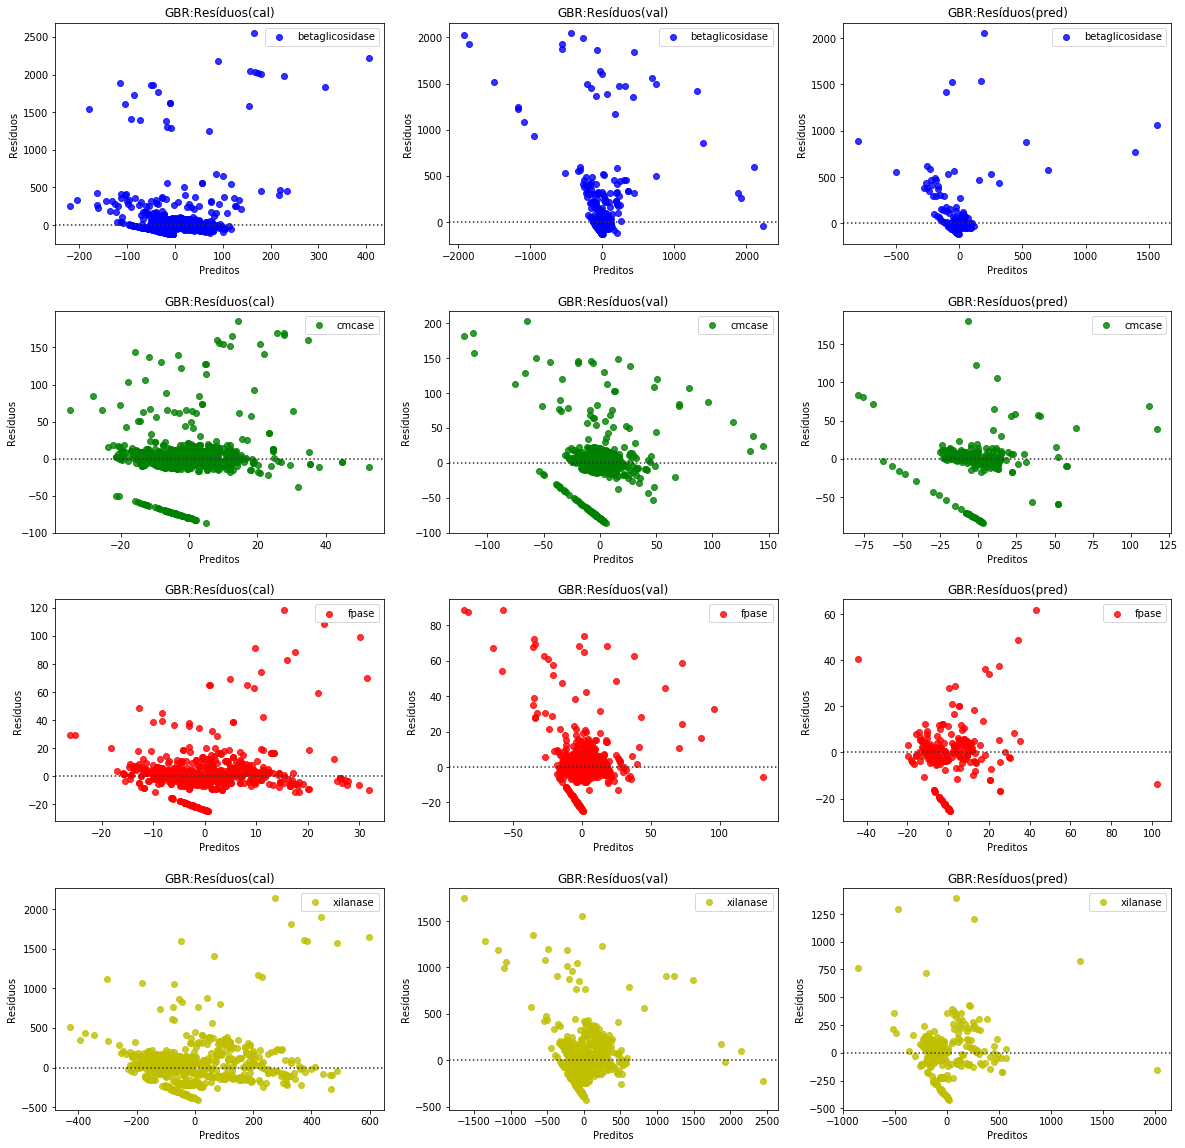

In [279]:
#gráfico dos resíduos
#@gbrgraf
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

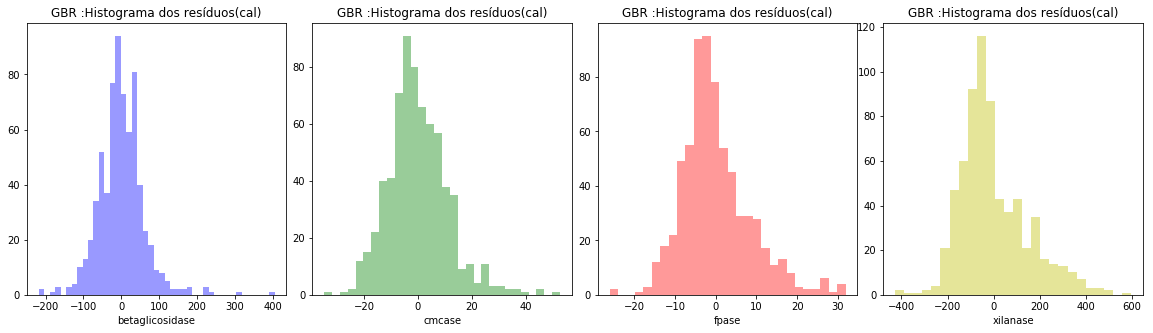

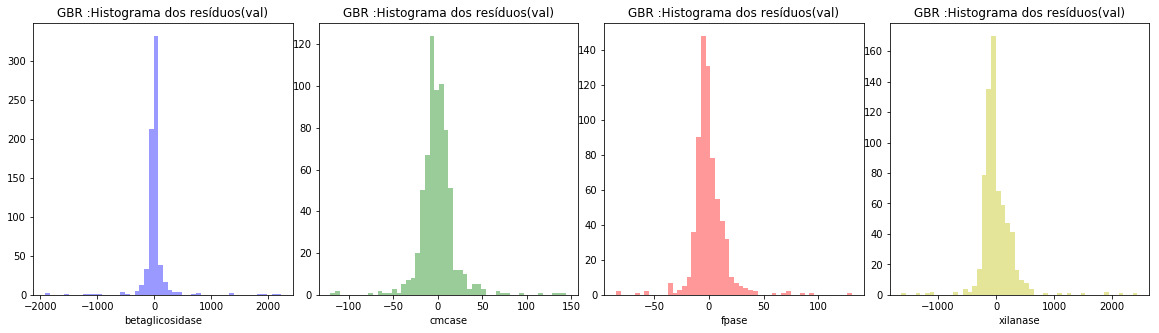

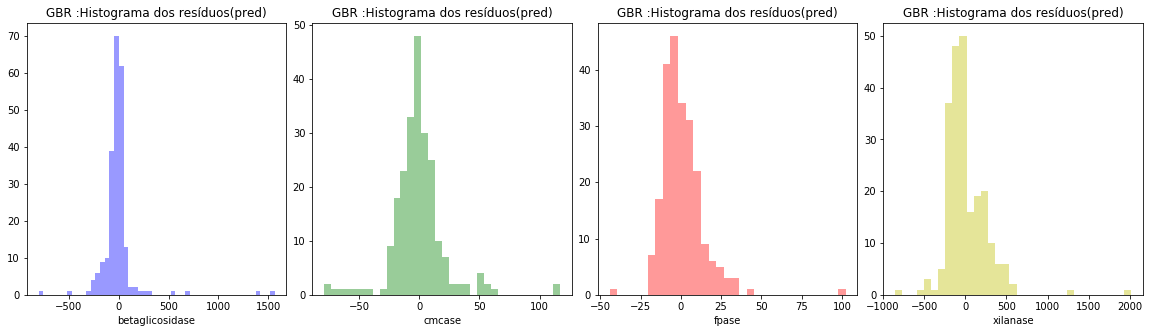

In [280]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

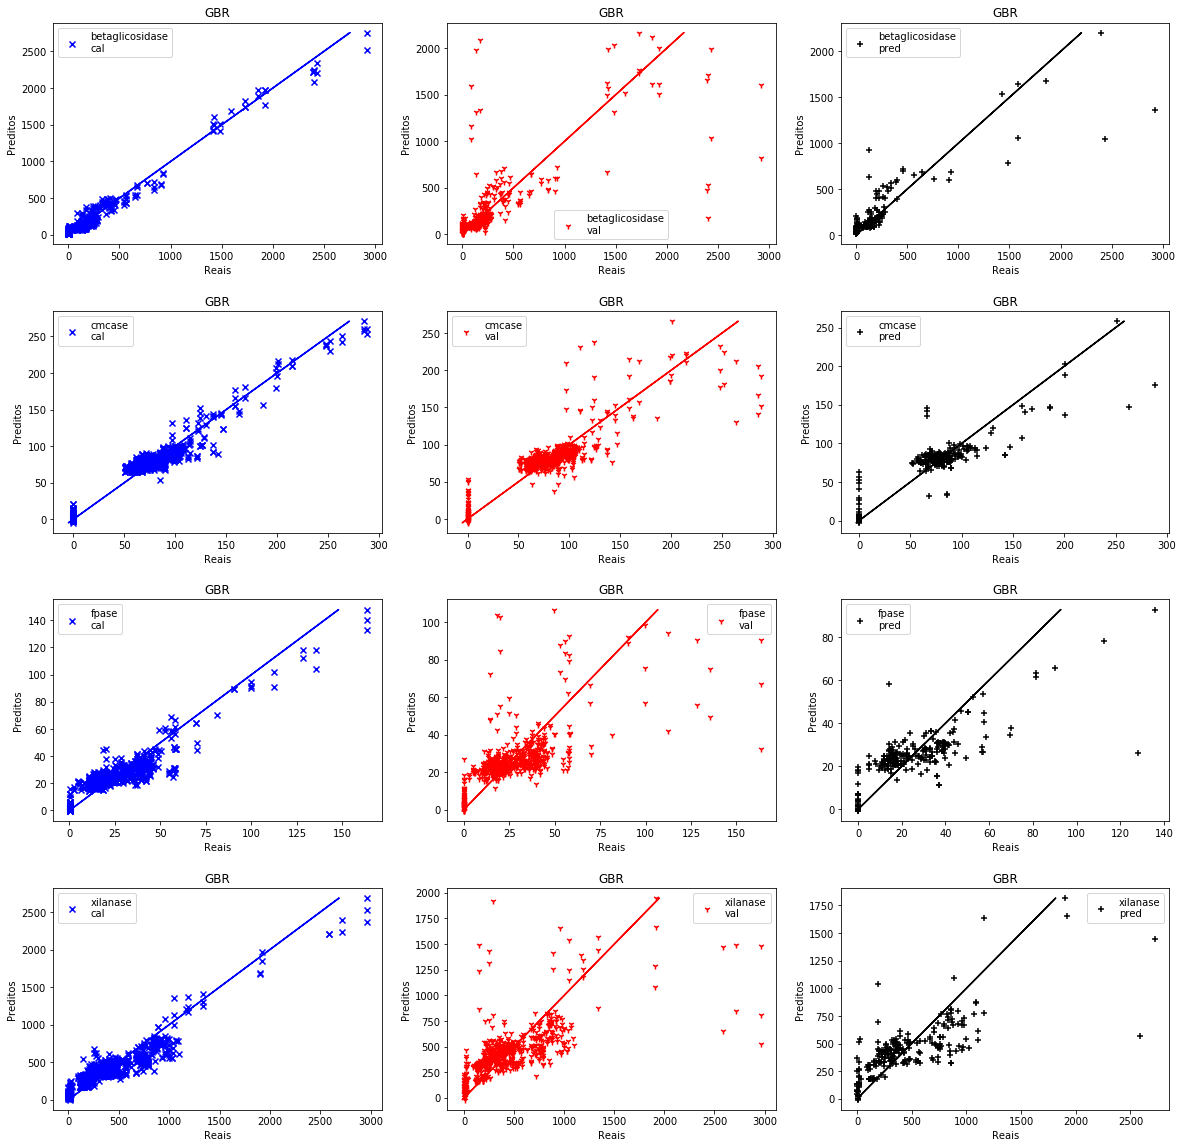

In [281]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

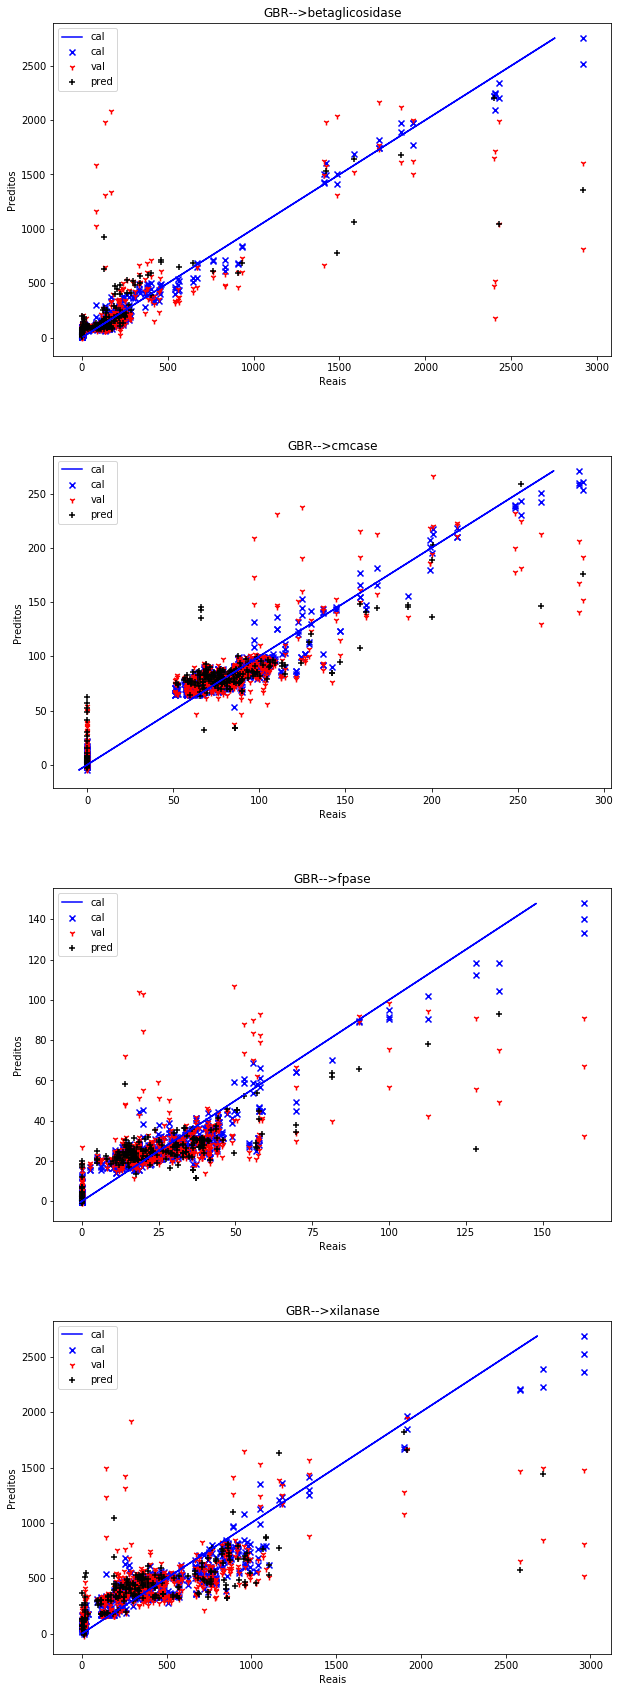

In [282]:
#graico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### GBR: Gráficos: dados de treino

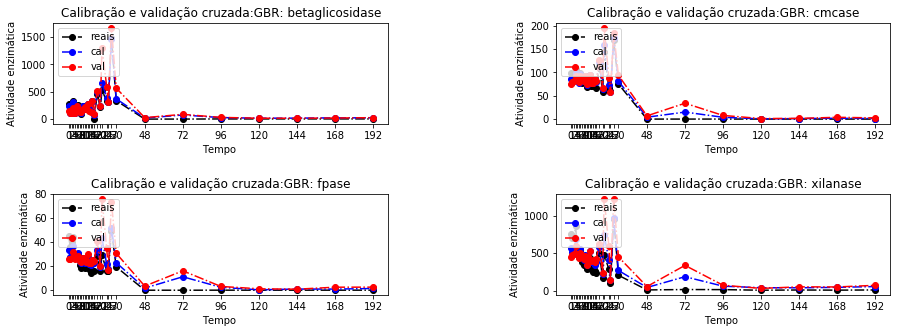

In [283]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### GBR: Gráficos de  teste

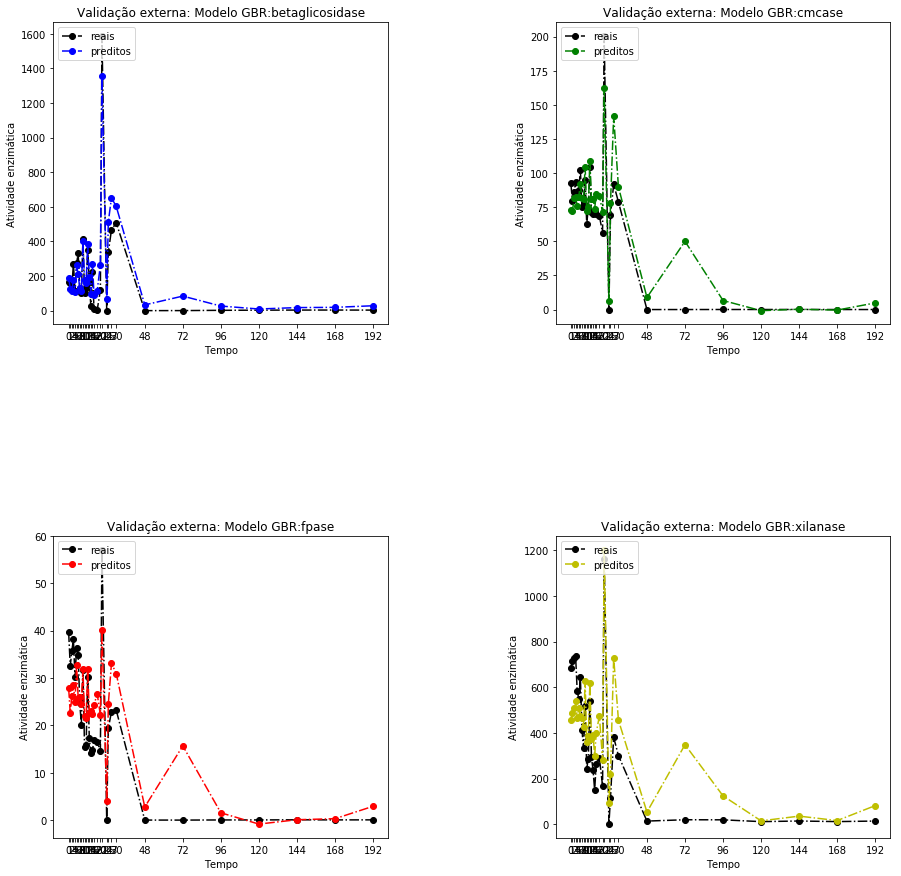

In [284]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

## PLS

### PLS: função completa

In [285]:
#pls
#função completa para execução do PLS:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaPLS(preproc,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False,IC)
  
   
    #Calcula o número de componentes ideal para o PLS
    mse = []
    component = np.arange(1, 20)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Fit
        pls.fit(x_treino, y_treino)
        # Prediction
        Y_pred = pls.predict(x_teste)

        mse_p = mean_squared_error(y_teste, Y_pred)
        mse.append(mse_p)

        comp = 100*(i+1)/20
        # Truque para atualizar o progresso do processamento na mesma linha
        print("\r%d%% completed " % comp, end='')

    # Calcula e imprime a posição do menor valor de MSE
    msemin = np.argmin(mse)
    print("Sugestão para o número de variáveis latentes: ", msemin+1)

 
    with plt.style.context(('ggplot')):
        plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
        plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
        plt.xlabel('Numero de componentes para o PLS')
        plt.ylabel('MSE')
        plt.title('PLS')
        plt.xlim(xmin=-1)

        plt.show()   

    # Roda o PLS e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pls = PLSRegression(n_components=msemin+1)
        
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], pls)
    
    dic = {'result':result,'min':msemin+1}
    return dic

    

In [286]:
#função completa para execução do PLS:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaPLSResumida(preproc=1, nPC=3, padroniza=False, max=500,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,padroniza,IC)
  
   
    #Calcula o número de componentes ideal para o PLS
    component = nPC
   
    # Roda o PLS e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pls = PLSRegression(n_components=nPC, max_iter=max)
        
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], pls)
    
    return result

### PLS: testes

In [287]:
preK = list(preProc.keys())
preV = list(preProc.values())

Pré-proc: 0--> Sem pré-processamento
100% completed Sugestão para o número de variáveis latentes:  17


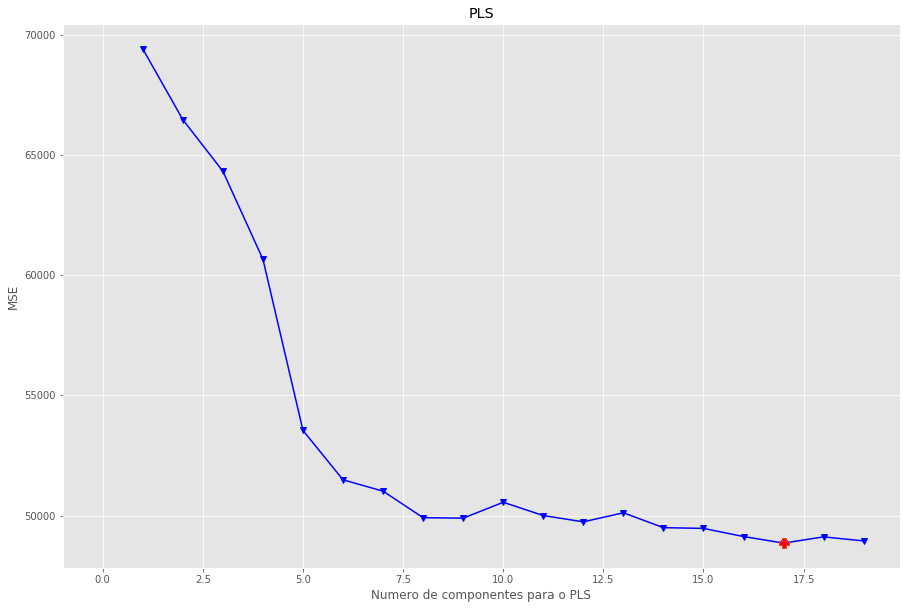

Pré-proc: 1--> Padronização
100% completed Sugestão para o número de variáveis latentes:  17


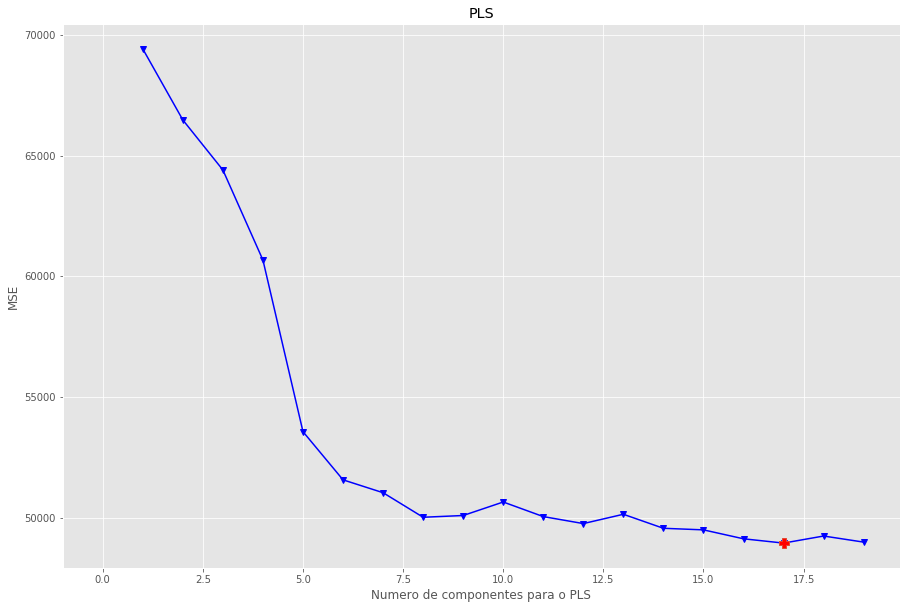

Pré-proc: 2--> Suavização(SavGol) - Par:3,1,1
100% completed Sugestão para o número de variáveis latentes:  6


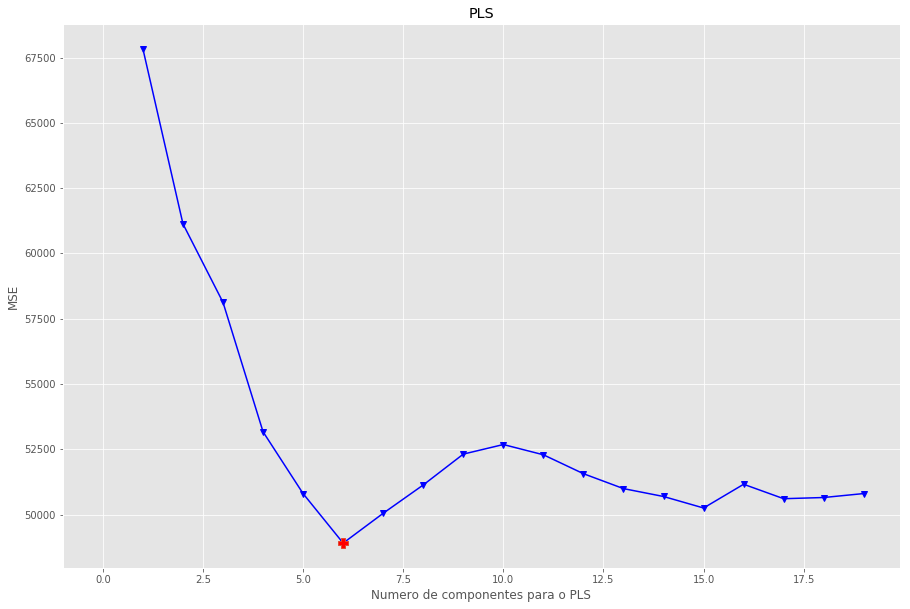

Pré-proc: 3--> Suavização(SavGol) - Par:3,2,1
100% completed Sugestão para o número de variáveis latentes:  6


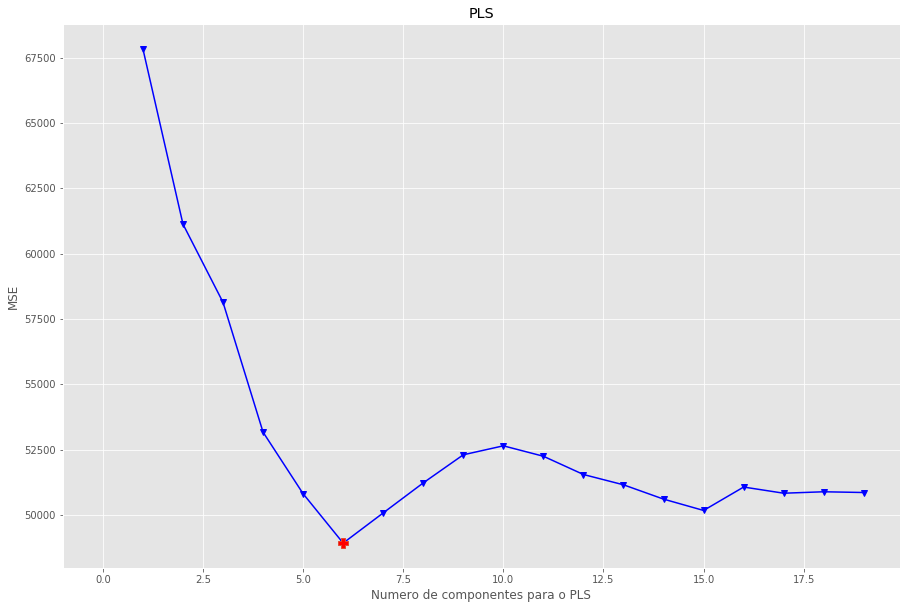

Pré-proc: 4--> Suavização(SavGol) - Par:5,1,1
100% completed Sugestão para o número de variáveis latentes:  6


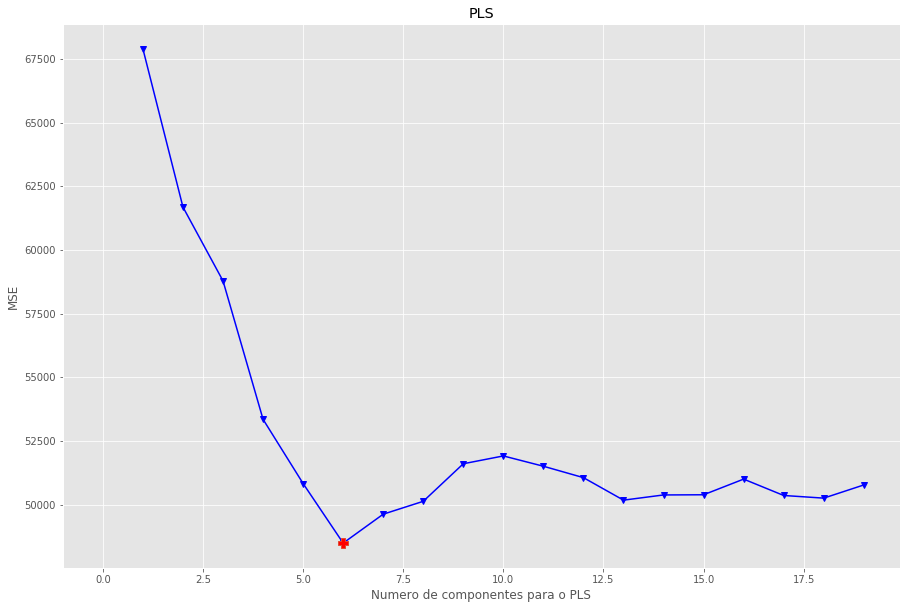

Pré-proc: 5--> Suavização(SavGol) - Par:5,2,1
100% completed Sugestão para o número de variáveis latentes:  6


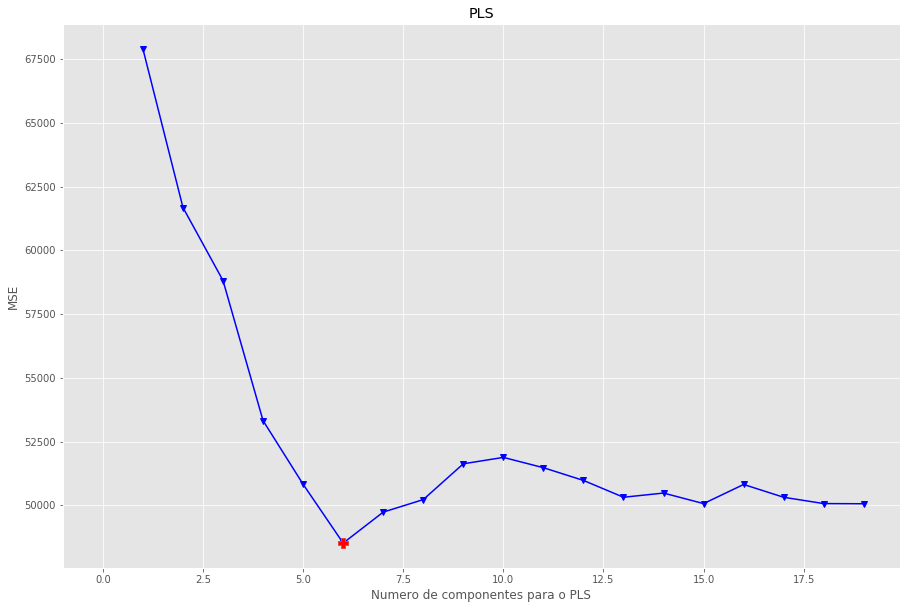

Pré-proc: 6--> Suavização(SavGol) - Par:3,2,2
100% completed Sugestão para o número de variáveis latentes:  5


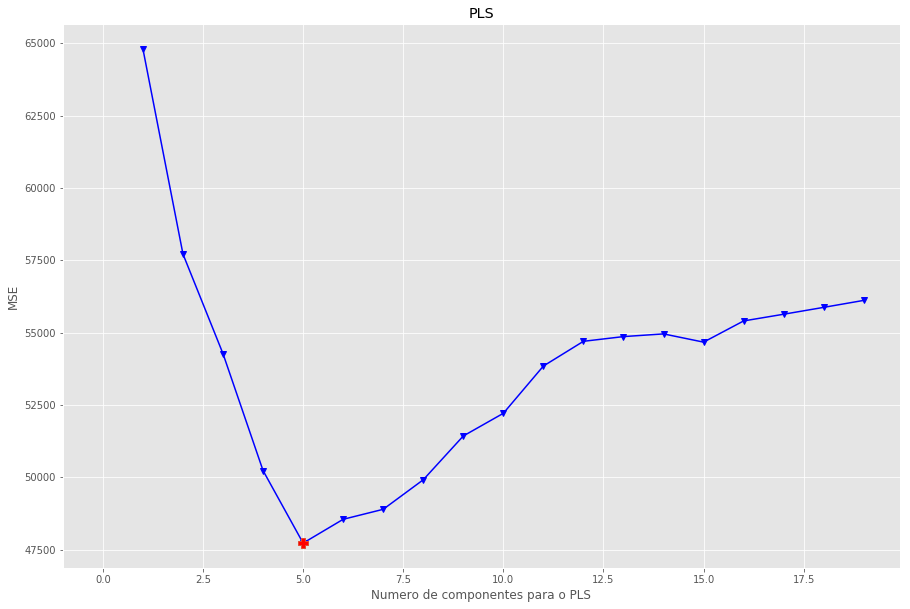

Pré-proc: 7--> Suavização(SavGol) - Par:5,2,2
100% completed Sugestão para o número de variáveis latentes:  5


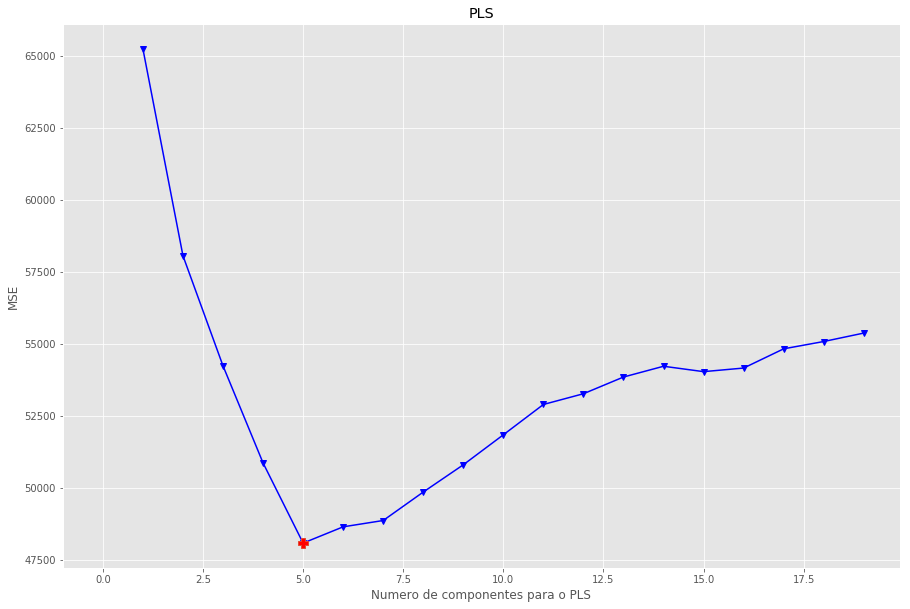

Pré-proc: 8--> Suavização(SavGol) - Par:3,1,1 --> Padronização
100% completed Sugestão para o número de variáveis latentes:  6


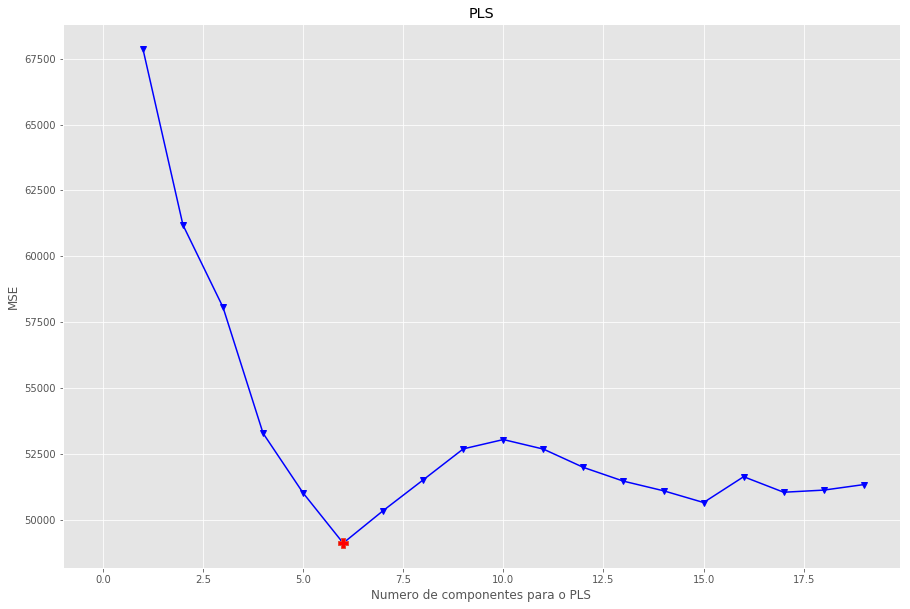

Pré-proc: 9--> Padronização --> Suavização(SavGol) - Par:3,1,1
100% completed Sugestão para o número de variáveis latentes:  7


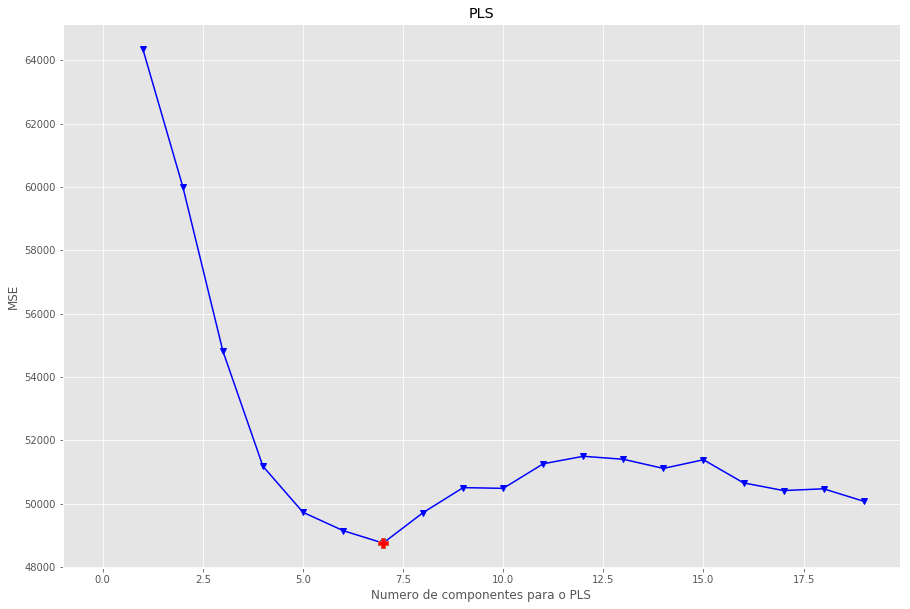

Pré-proc: 10--> MSC
100% completed Sugestão para o número de variáveis latentes:  6


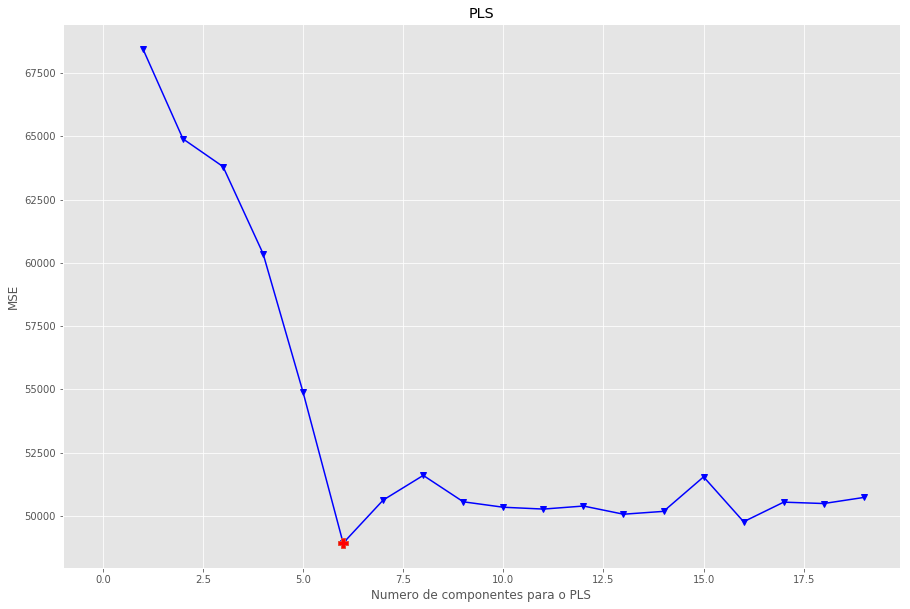

Pré-proc: 11--> SNV
100% completed Sugestão para o número de variáveis latentes:  6


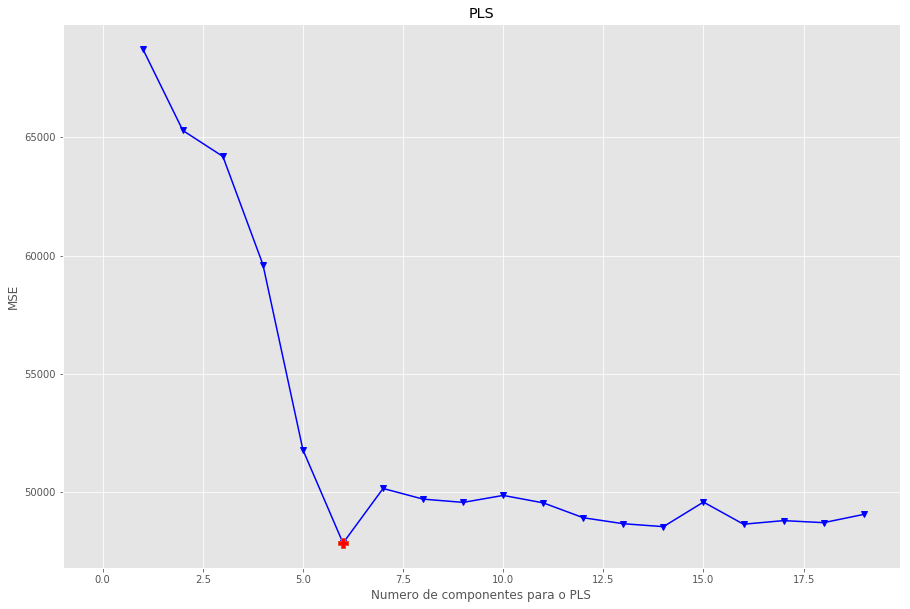

In [288]:
nVL = []
for k in preK:
    print(preProc[k])
    dic = executaPLS(k)
    nVL.append(dic['min'])

In [303]:
#pls teste simples
modelo = 'PLS'
for k in range(12):
    print(preProc[k])
    for i in range(7,17):
        print('Variáveis latentes: ',i)
        result = executaPLSResumida(k,nPC=i)
        print('Parâmetros do modelo:',modelo,'\n',result[0])

        resultados=exibeResultados(result)

        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')



Pré-proc: 0--> Sem pré-processamento
Variáveis latentes:  7
Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=7, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        90084.5529  778.0144  276.8722  96831.0822
R2             0.3744    0.6105    0.3675      0.3808
RER            9.7167   10.3158    9.8082      9.5087
RMSE         300.1409   27.8929   16.6395    311.1769
RPD            1.2643    1.6024    1.2574      1.2708
RPIQ           0.5139    1.0548    1.2799      1.3273
SEP          300.3615   27.9134   16.6517    311.4057 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.5608    0.0421   -0.0071      -0.1884
MSE        95591.5590  857.1928  304.3150  107625.2125
R2             0.3361    0.5709    0.3049       0.3118
RER            9.4327    9.8278    9.3555       9.0193
RMSE      

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=12, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        67941.7781  634.1079  238.2836  87914.3175
R2             0.5282    0.6826    0.4557      0.4378
RER           11.1887   11.4265   10.5726      9.9793
RMSE         260.6564   25.1815   15.4364    296.5035
RPD            1.4558    1.7749    1.3554      1.3337
RPIQ           0.5917    1.1684    1.3797      1.3930
SEP          260.8480   25.2000   15.4478    296.7214 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.2515    0.0156   -0.0054      -0.1360
MSE        87299.3877  801.1830  301.2925  108389.6394
R2             0.3937    0.5989    0.3118       0.3069
RER            9.8705   10.1655    9.4023       8.9874
RMSE         295.4647   28.3052   17.3578     329.2258
RPD           

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=7, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.0000    0.0000   -0.0000      0.0000
MSE        90084.5529  778.0144  276.8722  96831.0822
R2             0.3744    0.6105    0.3675      0.3808
RER            9.7167   10.3158    9.8082      9.5087
RMSE         300.1409   27.8929   16.6395    311.1769
RPD            1.2643    1.6024    1.2574      1.2708
RPIQ           0.5139    1.0548    1.2799      1.3273
SEP          300.3615   27.9134   16.6517    311.4057 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.5608    0.0421   -0.0071      -0.1884
MSE        95591.5590  857.1928  304.3150  107625.2125
R2             0.3361    0.5709    0.3049       0.3118
RER            9.4327    9.8278    9.3555       9.0193
RMSE         309.1788   29.2779   17.4446     328.0628
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=12, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        67941.7781  634.1079  238.2836  87914.3175
R2             0.5282    0.6826    0.4557      0.4378
RER           11.1887   11.4265   10.5726      9.9793
RMSE         260.6564   25.1815   15.4364    296.5035
RPD            1.4558    1.7749    1.3554      1.3337
RPIQ           0.5917    1.1684    1.3797      1.3930
SEP          260.8480   25.2000   15.4478    296.7214 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.2515    0.0156   -0.0054      -0.1360
MSE        87299.3877  801.1830  301.2925  108389.6394
R2             0.3937    0.5989    0.3118       0.3069
RER            9.8705   10.1655    9.4023       8.9874
RMSE         295.4647   28.3052   17.3578     329.2258
RPD           

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=7, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        71950.6364  655.3127  237.2825  86998.4844
R2             0.5003    0.6720    0.4580      0.4437
RER           10.8725   11.2401   10.5949     10.0317
RMSE         268.2362   25.5991   15.4040    294.9551
RPD            1.4147    1.7460    1.3583      1.3407
RPIQ           0.5750    1.1494    1.3826      1.4003
SEP          268.4333   25.6179   15.4153    295.1719 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           1.0292    0.0527    0.0251       0.2492
MSE        89417.4224  836.9520  301.3042  109059.0818
R2             0.3790    0.5810    0.3117       0.3026
RER            9.7530    9.9460    9.4021       8.9598
RMSE         299.0275   28.9301   17.3581     330.2409
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=12, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        67941.7781  634.1079  238.2836  87914.3175
R2             0.5282    0.6826    0.4557      0.4378
RER           11.1887   11.4265   10.5726      9.9793
RMSE         260.6564   25.1815   15.4364    296.5035
RPD            1.4558    1.7749    1.3554      1.3337
RPIQ           0.5917    1.1684    1.3797      1.3930
SEP          260.8480   25.2000   15.4478    296.7214 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.2515    0.0156   -0.0054      -0.1360
MSE        87299.3877  801.1830  301.2925  108389.6394
R2             0.3937    0.5989    0.3118       0.3069
RER            9.8705   10.1655    9.4023       8.9874
RMSE         295.4647   28.3052   17.3578     329.2258
RPD           

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=7, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        71951.3536  654.9571  237.2846  87020.1979
R2             0.5003    0.6721    0.4580      0.4435
RER           10.8724   11.2432   10.5948     10.0304
RMSE         268.2375   25.5921   15.4040    294.9919
RPD            1.4147    1.7465    1.3583      1.3406
RPIQ           0.5750    1.1497    1.3826      1.4001
SEP          268.4347   25.6109   15.4154    295.2087 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           1.0873    0.0582    0.0287       0.3044
MSE        89427.6856  837.1673  301.3761  109107.7837
R2             0.3789    0.5809    0.3116       0.3023
RER            9.7524    9.9447    9.4010       8.9578
RMSE         299.0446   28.9338   17.3602     330.3147
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=12, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        67941.7781  634.1079  238.2836  87914.3175
R2             0.5282    0.6826    0.4557      0.4378
RER           11.1887   11.4265   10.5726      9.9793
RMSE         260.6564   25.1815   15.4364    296.5035
RPD            1.4558    1.7749    1.3554      1.3337
RPIQ           0.5917    1.1684    1.3797      1.3930
SEP          260.8480   25.2000   15.4478    296.7214 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.2515    0.0156   -0.0054      -0.1360
MSE        87299.3877  801.1830  301.2925  108389.6394
R2             0.3937    0.5989    0.3118       0.3069
RER            9.8705   10.1655    9.4023       8.9874
RMSE         295.4647   28.3052   17.3578     329.2258
RPD           

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=7, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        73233.9038  682.2718  240.7810  87184.6862
R2             0.4914    0.6585    0.4500      0.4425
RER           10.7768   11.0158   10.5176     10.0210
RMSE         270.6176   26.1203   15.5171    295.2705
RPD            1.4022    1.7111    1.3484      1.3393
RPIQ           0.5699    1.1264    1.3725      1.3988
SEP          270.8165   26.1395   15.5285    295.4876 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.6800    0.0220    0.0037      -0.1121
MSE        89591.2979  847.9993  300.6429  108174.3760
R2             0.3778    0.5755    0.3133       0.3083
RER            9.7435    9.8809    9.4125       8.9964
RMSE         299.3181   29.1204   17.3391     328.8987
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=12, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        67941.7781  634.1079  238.2836  87914.3175
R2             0.5282    0.6826    0.4557      0.4378
RER           11.1887   11.4265   10.5726      9.9793
RMSE         260.6564   25.1815   15.4364    296.5035
RPD            1.4558    1.7749    1.3554      1.3337
RPIQ           0.5917    1.1684    1.3797      1.3930
SEP          260.8480   25.2000   15.4478    296.7214 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.2515    0.0156   -0.0054      -0.1360
MSE        87299.3877  801.1830  301.2925  108389.6394
R2             0.3937    0.5989    0.3118       0.3069
RER            9.8705   10.1655    9.4023       8.9874
RMSE         295.4647   28.3052   17.3578     329.2258
RPD           

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=7, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.0000   -0.0000   -0.0000     -0.0000
MSE        73236.3770  680.4796  240.3604  87144.0588
R2             0.4914    0.6594    0.4510      0.4428
RER           10.7766   11.0303   10.5268     10.0233
RMSE         270.6222   26.0860   15.5036    295.2017
RPD            1.4022    1.7134    1.3496      1.3396
RPIQ           0.5699    1.1279    1.3737      1.3991
SEP          270.8211   26.1052   15.5150    295.4187 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.8381    0.0323    0.0127       0.0234
MSE        89796.0105  848.2574  300.8032  108326.7108
R2             0.3764    0.5754    0.3129       0.3073
RER            9.7324    9.8794    9.4099       8.9900
RMSE         299.6598   29.1249   17.3437     329.1302
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=12, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        67941.7781  634.1079  238.2836  87914.3175
R2             0.5282    0.6826    0.4557      0.4378
RER           11.1887   11.4265   10.5726      9.9793
RMSE         260.6564   25.1815   15.4364    296.5035
RPD            1.4558    1.7749    1.3554      1.3337
RPIQ           0.5917    1.1684    1.3797      1.3930
SEP          260.8480   25.2000   15.4478    296.7214 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.2515    0.0156   -0.0054      -0.1360
MSE        87299.3877  801.1830  301.2925  108389.6394
R2             0.3937    0.5989    0.3118       0.3069
RER            9.8705   10.1655    9.4023       8.9874
RMSE         295.4647   28.3052   17.3578     329.2258
RPD           

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=7, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.0000   -0.0000   -0.0000     -0.0000
MSE        69171.1607  602.4597  230.6487  83539.9375
R2             0.5196    0.6984    0.4731      0.4658
RER           11.0888   11.7228   10.7461     10.2372
RMSE         263.0041   24.5451   15.1871    289.0328
RPD            1.4428    1.8210    1.3777      1.3682
RPIQ           0.5864    1.1987    1.4023      1.4290
SEP          263.1974   24.5631   15.1983    289.2452 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -0.3219   -0.0332   -0.0405      -1.5797
MSE        91856.2718  821.7041  316.8751  114370.4811
R2             0.3621    0.5887    0.2762       0.2687
RER            9.6226   10.0378    9.1682       8.7494
RMSE         303.0780   28.6654   17.8010     338.1871
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=12, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        67941.7781  634.1079  238.2836  87914.3175
R2             0.5282    0.6826    0.4557      0.4378
RER           11.1887   11.4265   10.5726      9.9793
RMSE         260.6564   25.1815   15.4364    296.5035
RPD            1.4558    1.7749    1.3554      1.3337
RPIQ           0.5917    1.1684    1.3797      1.3930
SEP          260.8480   25.2000   15.4478    296.7214 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.2515    0.0156   -0.0054      -0.1360
MSE        87299.3877  801.1830  301.2925  108389.6394
R2             0.3937    0.5989    0.3118       0.3069
RER            9.8705   10.1655    9.4023       8.9874
RMSE         295.4647   28.3052   17.3578     329.2258
RPD           

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=7, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        70818.0969  615.2807  233.3051  83388.3688
R2             0.5082    0.6920    0.4671      0.4668
RER           10.9591   11.6000   10.6848     10.2465
RMSE         266.1167   24.8049   15.2743    288.7704
RPD            1.4259    1.8019    1.3698      1.3694
RPIQ           0.5796    1.1862    1.3943      1.4303
SEP          266.3123   24.8231   15.2856    288.9827 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -0.6707   -0.0135   -0.0388      -1.6034
MSE        91768.5667  823.4842  314.0878  113287.4363
R2             0.3627    0.5878    0.2825       0.2756
RER            9.6272   10.0269    9.2088       8.7911
RMSE         302.9333   28.6964   17.7225     336.5820
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=12, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        67941.7781  634.1079  238.2836  87914.3175
R2             0.5282    0.6826    0.4557      0.4378
RER           11.1887   11.4265   10.5726      9.9793
RMSE         260.6564   25.1815   15.4364    296.5035
RPD            1.4558    1.7749    1.3554      1.3337
RPIQ           0.5917    1.1684    1.3797      1.3930
SEP          260.8480   25.2000   15.4478    296.7214 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.2515    0.0156   -0.0054      -0.1360
MSE        87299.3877  801.1830  301.2925  108389.6394
R2             0.3937    0.5989    0.3118       0.3069
RER            9.8705   10.1655    9.4023       8.9874
RMSE         295.4647   28.3052   17.3578     329.2258
RPD           

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=7, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.0000    0.0000   -0.0000      0.0000
MSE        71950.6364  655.3127  237.2825  86998.4844
R2             0.5003    0.6720    0.4580      0.4437
RER           10.8725   11.2401   10.5949     10.0317
RMSE         268.2362   25.5991   15.4040    294.9551
RPD            1.4147    1.7460    1.3583      1.3407
RPIQ           0.5750    1.1494    1.3826      1.4003
SEP          268.4333   25.6179   15.4153    295.1719 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           1.0292    0.0527    0.0251       0.2492
MSE        89417.4224  836.9520  301.3042  109059.0818
R2             0.3790    0.5810    0.3117       0.3026
RER            9.7530    9.9460    9.4021       8.9598
RMSE         299.0275   28.9301   17.3581     330.2409
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=12, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        67941.7781  634.1079  238.2836  87914.3175
R2             0.5282    0.6826    0.4557      0.4378
RER           11.1887   11.4265   10.5726      9.9793
RMSE         260.6564   25.1815   15.4364    296.5035
RPD            1.4558    1.7749    1.3554      1.3337
RPIQ           0.5917    1.1684    1.3797      1.3930
SEP          260.8480   25.2000   15.4478    296.7214 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.2515    0.0156   -0.0054      -0.1360
MSE        87299.3877  801.1830  301.2925  108389.6394
R2             0.3937    0.5989    0.3118       0.3069
RER            9.8705   10.1655    9.4023       8.9874
RMSE         295.4647   28.3052   17.3578     329.2258
RPD           

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=7, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.0000    0.0000   -0.0000      0.0000
MSE        75901.1060  675.6546  242.2931  86508.4365
R2             0.4729    0.6618    0.4465      0.4468
RER           10.5858   11.0696   10.4847     10.0601
RMSE         275.5016   25.9934   15.5658    294.1232
RPD            1.3774    1.7195    1.3442      1.3445
RPIQ           0.5598    1.1319    1.3682      1.4043
SEP          275.7041   26.0125   15.5772    294.3394 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.3900   -0.0208   -0.0119      -0.1359
MSE        88997.4207  821.1999  295.5904  105984.7066
R2             0.3819    0.5889    0.3248       0.3223
RER            9.7759   10.0409    9.4926       9.0888
RMSE         298.3244   28.6566   17.1927     325.5529
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=12, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        67941.7781  634.1079  238.2836  87914.3175
R2             0.5282    0.6826    0.4557      0.4378
RER           11.1887   11.4265   10.5726      9.9793
RMSE         260.6564   25.1815   15.4364    296.5035
RPD            1.4558    1.7749    1.3554      1.3337
RPIQ           0.5917    1.1684    1.3797      1.3930
SEP          260.8480   25.2000   15.4478    296.7214 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.2515    0.0156   -0.0054      -0.1360
MSE        87299.3877  801.1830  301.2925  108389.6394
R2             0.3937    0.5989    0.3118       0.3069
RER            9.8705   10.1655    9.4023       8.9874
RMSE         295.4647   28.3052   17.3578     329.2258
RPD           

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=7, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        83260.6434  783.7758  275.3033  97630.5385
R2             0.4218    0.6077    0.3711      0.3757
RER           10.1071   10.2778    9.8361      9.4697
RMSE         288.5492   27.9960   16.5923    312.4589
RPD            1.3151    1.5965    1.2610      1.2656
RPIQ           0.5345    1.0510    1.2836      1.3219
SEP          288.7613   28.0166   16.6045    312.6885 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -0.8240   -0.1600   -0.0742      -1.6953
MSE        90229.2294  871.3942  302.9657  107790.9744
R2             0.3734    0.5638    0.3079       0.3107
RER            9.7090    9.7475    9.3764       9.0125
RMSE         300.3818   29.5194   17.4059     328.3154
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=12, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        67941.7781  634.1079  238.2836  87914.3175
R2             0.5282    0.6826    0.4557      0.4378
RER           11.1887   11.4265   10.5726      9.9793
RMSE         260.6564   25.1815   15.4364    296.5035
RPD            1.4558    1.7749    1.3554      1.3337
RPIQ           0.5917    1.1684    1.3797      1.3930
SEP          260.8480   25.2000   15.4478    296.7214 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.2515    0.0156   -0.0054      -0.1360
MSE        87299.3877  801.1830  301.2925  108389.6394
R2             0.3937    0.5989    0.3118       0.3069
RER            9.8705   10.1655    9.4023       8.9874
RMSE         295.4647   28.3052   17.3578     329.2258
RPD           

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=7, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        83246.4534  766.9678  275.2933  96845.8434
R2             0.4219    0.6161    0.3712      0.3807
RER           10.1080   10.3898    9.8363      9.5080
RMSE         288.5246   27.6942   16.5920    311.2006
RPD            1.3152    1.6139    1.2610      1.2707
RPIQ           0.5345    1.0624    1.2836      1.3272
SEP          288.7367   27.7145   16.6042    311.4294 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           1.1006    0.0637   -0.0188      -0.6150
MSE        90274.1674  864.2194  304.2068  107539.1937
R2             0.3731    0.5674    0.3051       0.3123
RER            9.7066    9.7878    9.3572       9.0229
RMSE         300.4566   29.3976   17.4415     327.9317
RPD            

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=12, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        67941.7781  634.1079  238.2836  87914.3175
R2             0.5282    0.6826    0.4557      0.4378
RER           11.1887   11.4265   10.5726      9.9793
RMSE         260.6564   25.1815   15.4364    296.5035
RPD            1.4558    1.7749    1.3554      1.3337
RPIQ           0.5917    1.1684    1.3797      1.3930
SEP          260.8480   25.2000   15.4478    296.7214 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           0.2515    0.0156   -0.0054      -0.1360
MSE        87299.3877  801.1830  301.2925  108389.6394
R2             0.3937    0.5989    0.3118       0.3069
RER            9.8705   10.1655    9.4023       8.9874
RMSE         295.4647   28.3052   17.3578     329.2258
RPD           

In [308]:
#pls teste simples
modelo = 'PLS'
for k in range(12):
    print(preProc[k])
    for i in [15]:
        print('Variáveis latentes: ',i)
        result = executaPLSResumida(k,nPC=i)
        print('Parâmetros do modelo:',modelo,'\n',result[0])

        resultados=exibeResultados(result)

        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')



Pré-proc: 0--> Sem pré-processamento
Variáveis latentes:  15
Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=15, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        66458.3307  586.7572  226.1642  82278.9484
R2             0.5385    0.7063    0.4834      0.4739
RER           11.3128   11.8786   10.8522     10.3154
RMSE         257.7951   24.2231   15.0388    286.8431
RPD            1.4720    1.8452    1.3913      1.3786
RPIQ           0.5983    1.2147    1.4162      1.4399
SEP          257.9846   24.2409   15.0498    287.0539 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -0.2282    0.0651    0.0058      -0.7821
MSE        88189.3647  796.9109  306.3097  109637.3774
R2             0.3875    0.6011    0.3003       0.2989
RER            9.8206   10.1928    9.3250       8.9362
RMSE    

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=15, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS          -0.0000   -0.0000   -0.0000     -0.0000
MSE        63554.1270  546.5621  216.8697  78488.6701
R2             0.5586    0.7264    0.5046      0.4981
RER           11.5684   12.3077   11.0823     10.5615
RMSE         252.0994   23.3787   14.7265    280.1583
RPD            1.5052    1.9118    1.4208      1.4115
RPIQ           0.6118    1.2585    1.4462      1.4743
SEP          252.2847   23.3959   14.7373    280.3642 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS          -0.9802    0.0153   -0.0565      -0.6647
MSE        90189.7331  785.2983  307.5548  110857.3738
R2             0.3737    0.6069    0.2975       0.2911
RER            9.7111   10.2678    9.3061       8.8869
RMSE         300.3161   28.0232   17.5372     332.9525
RPD           

Parâmetros do modelo: PLS 
 PLSRegression(copy=True, max_iter=500, n_components=15, scale=True, tol=1e-06)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000     -0.0000
MSE        66541.9260  592.6274  229.0857  82514.4761
R2             0.5379    0.7033    0.4767      0.4724
RER           11.3057   11.8197   10.7827     10.3007
RMSE         257.9572   24.3439   15.1356    287.2533
RPD            1.4710    1.8360    1.3824      1.3767
RPIQ           0.5979    1.2086    1.4071      1.4379
SEP          258.1468   24.3618   15.1467    287.4645 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase     xilanase
BIAS           1.3128    0.0145    0.0172       0.9004
MSE        86356.7879  765.0861  295.3402  106694.1219
R2             0.4003    0.6170    0.3254       0.3177
RER            9.9244   10.4026    9.4966       9.0586
RMSE         293.8653   27.6602   17.1855     326.6407
RPD           

In [309]:
#pls otimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaPLSResumida(preproc=6,nPC=15,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.5017, 0.6855, 0.4039, 0.3863] 
semente: b c f x [35, 35, 8, 8]


In [316]:
#PLS teste otimizado
modelo = 'PLS:'
result = executaPLSResumida(preproc=2,nPC=15,IC=24)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: PLS: 
 PLSRegression(copy=True, max_iter=500, n_components=15, scale=True, tol=1e-06)


In [317]:
resultados['cal']

betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000      0.0000
MSE        64334.1745  578.1126  221.5679  81838.9412
R2             0.5943    0.7292    0.5327      0.5180
RER           11.4981   11.9671   10.9641     10.3431
RMSE         253.6418   24.0440   14.8852    286.0751
RPD            1.5700    1.9218    1.4628      1.4403
RPIQ           0.5906    1.1565    1.4454      1.7353
SEP          253.8283   24.0616   14.8961    286.2853

In [334]:
resultados['val']

betaglicosidase     cmcase     fpase     xilanase
BIAS           0.1814    -0.0436   -0.0259      -0.6673
MSE       113144.0054  1457.2356  381.7219  133129.1067
R2             0.2142     0.2705    0.1280       0.1487
RER            8.6702     7.5376    8.3532       8.1095
RMSE         336.3689    38.1738   19.5377     364.8686
RPD            1.1281     1.1708    1.0709       1.0838
RPIQ           0.4585     0.7708    1.0901       1.1320
SEP          336.6160    38.2018   19.5520     365.1362

In [335]:
resultados['pred']

betaglicosidase     cmcase     fpase     xilanase
BIAS         -14.7596    -1.7363    0.3054       9.8948
MSE       111849.1605  1388.2157  346.4233  133170.2767
R2             0.2088     0.2919    0.1698       0.1644
RER            8.7159     7.7197    7.2745       7.4392
RMSE         334.4386    37.2588   18.6125     364.9250
RPD            1.1242     1.1884    1.0975       1.0939
RPIQ           0.4216     0.6171    1.1946       1.4440
SEP          334.8511    37.3005   18.6511     365.5970

In [320]:
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [321]:
#pls reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0           121.3549   82.6985   32.8966   415.1712               252.0155   
1            55.2638   50.7277   15.4562   163.7129                93.6497   
2           110.4872   97.6145   30.0285   419.8360               311.2144   
3           336.7610   67.4547   22.4708   150.7103               412.4107   
4           184.5409   94.4735   34.0078   710.9095               358.0109   
5           130.8023   67.3478   14.2291   203.0631               135.8361   
6           237.1880   89.6847   43.6678   924.0410               383.8837   
7           129.4330  114.8104   37.3938   671.3381                25.6031   
8           131.9201   85.3513   35.8638   575.7837               106.5224   
9           191.9041  102.3202   17.1605   352.7522               211.8061   
10            0.3828    0.0405    0.0301    12.4461              -415.1356   
11          154.8522   79.5483   19.7968   218.6271               124.8313   
12          133.2707   74.8560   17.8949   135.6123               140.3514   
13          136.2851  112.3726   26.5009   313.8180                23.9125   
14          191.9041  102.3202   17.1605   352.7522               311.2620   
15            2.1643    0.0830    0.0529    18.8324              -230.1799   
16           84.2733   77.4659   11.0090   115.7702              -174.5889   
17          229.4566   85.1762   17.7045   477.4046               201.0226   
18          248.6120  158.4460   69.6480   905.4550               875.8773   
19         2431.6260  263.4420  128.2720  2585.4951              1159.4403   
20           38.1276   60.8791   16.0449   349.3120               306.5021   
21            0.3900    0.0315    0.0283    14.1777               -40.6681   
22          134.6752   82.1768   32.9392   560.4463                66.3386   
23          273.5800  162.1220   69.8540   962.5400              1135.9605   
24          388.0160   59.7335   23.9698   258.8844               525.0777   
25            0.1671    0.0117    0.0104     0.1117                63.4542   
26         2397.5010  251.6900  112.6160  1901.4399              1363.2674   
27           42.5092   60.4743   15.4377   338.4625                93.4003   
28          129.4330  114.8104   37.3938   671.3381                17.0830   
29         2403.2200  285.3140  163.3280  2961.1440              1919.2039   
..               ...       ...       ...        ...                    ...   
651         102.6849   80.3544   39.3470   680.4508               216.2205   
652          64.0786   77.4722   17.6446   330.8339               182.0447   
653          94.1372   77.0335   36.1238   667.2302                59.2361   
654         158.5821   77.3812   31.1380   832.2265                16.5557   
655           5.5289   62.7837   18.6321   247.3351              -236.8411   
656           0.4280    0.0390    0.0334    13.7624              -344.9741   
657          76.8184   77.5492   12.0919   199.7503              -139.8934   
658          30.6799   51.8303   11.4133   353.3897               -19.2189   
659         151.0042   86.3585   28.9155   793.7070               230.3381   
660        1485.9540  168.2210   49.3830   959.0790              1010.7520   
661           2.7110    0.0548    0.0688    13.5829              -127.3844   
662         136.8757   63.2618   13.4966   214.6944               189.9977   
663         250.8100   77.3295   14.7702   258.2026               245.3354   
664        1586.9160  200.3440   57.0920  1163.2500              1243.4587   
665         143.8933  128.5731   57.8269   866.2308               222.6327   
666         122.1230   96.9230   25.5450   376.6580               127.7288   
667         145.1078   85.6441   17.6879   466.9096              -170.3474   
668         170.8830  124.5190   20.0790   252.8500               947.0757   
669         238.6606  103.6390   18.6276   403.8937               227.5400   
670         929.7967   90.5

In [322]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0           121.3549   82.6985   32.8966   415.1712               316.8370   
1            55.2638   50.7277   15.4562   163.7129               171.0096   
2           110.4872   97.6145   30.0285   419.8360               297.8420   
3           336.7610   67.4547   22.4708   150.7103               471.5590   
4           184.5409   94.4735   34.0078   710.9095               439.4473   
5           130.8023   67.3478   14.2291   203.0631               132.1015   
6           237.1880   89.6847   43.6678   924.0410               397.9039   
7           129.4330  114.8104   37.3938   671.3381               -94.0377   
8           131.9201   85.3513   35.8638   575.7837               183.7659   
9           191.9041  102.3202   17.1605   352.7522               177.6535   
10            0.3828    0.0405    0.0301    12.4461              -389.3518   
11          154.8522   79.5483   19.7968   218.6271               140.8205   
12          133.2707   74.8560   17.8949   135.6123                36.5060   
13          136.2851  112.3726   26.5009   313.8180               -19.8170   
14          191.9041  102.3202   17.1605   352.7522               415.1180   
15            2.1643    0.0830    0.0529    18.8324              -310.1795   
16           84.2733   77.4659   11.0090   115.7702              -173.5884   
17          229.4566   85.1762   17.7045   477.4046               260.2888   
18          248.6120  158.4460   69.6480   905.4550               905.2086   
19         2431.6260  263.4420  128.2720  2585.4951               923.2859   
20           38.1276   60.8791   16.0449   349.3120               298.4927   
21            0.3900    0.0315    0.0283    14.1777                29.4758   
22          134.6752   82.1768   32.9392   560.4463               135.0295   
23          273.5800  162.1220   69.8540   962.5400              1188.1024   
24          388.0160   59.7335   23.9698   258.8844               433.2302   
25            0.1671    0.0117    0.0104     0.1117                75.3514   
26         2397.5010  251.6900  112.6160  1901.4399              1131.2230   
27           42.5092   60.4743   15.4377   338.4625                47.1644   
28          129.4330  114.8104   37.3938   671.3381                28.9367   
29         2403.2200  285.3140  163.3280  2961.1440              1631.8385   
..               ...       ...       ...        ...                    ...   
651         102.6849   80.3544   39.3470   680.4508               187.4116   
652          64.0786   77.4722   17.6446   330.8339               175.6331   
653          94.1372   77.0335   36.1238   667.2302               130.9608   
654         158.5821   77.3812   31.1380   832.2265                61.3825   
655           5.5289   62.7837   18.6321   247.3351              -233.8056   
656           0.4280    0.0390    0.0334    13.7624              -332.2206   
657          76.8184   77.5492   12.0919   199.7503              -108.5132   
658          30.6799   51.8303   11.4133   353.3897                17.1589   
659         151.0042   86.3585   28.9155   793.7070               281.2427   
660        1485.9540  168.2210   49.3830   959.0790               922.3122   
661           2.7110    0.0548    0.0688    13.5829              -194.2024   
662         136.8757   63.2618   13.4966   214.6944               148.5092   
663         250.8100   77.3295   14.7702   258.2026               263.9006   
664        1586.9160  200.3440   57.0920  1163.2500              1125.3548   
665         143.8933  128.5731   57.8269   866.2308               225.8596   
666         122.1230   96.9230   25.5450   376.6580               169.9028   
667         145.1078   85.6441   17.6879   466.9096              -219.1235   
668         170.8830  124.5190   20.0790   252.8500              1073.3493   
669         238.6606  103.6390   18.6276   403.8937               242.2192   
670         929.7967   90.5

In [323]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0            89.7074   65.3003   13.8382   361.1810               -72.5915   
1           647.8945   62.3355   19.8263   129.4946               325.9142   
2           139.6252  124.0305   36.3651   869.1574               373.5480   
3             0.6491    0.0605    0.0260    18.4274               237.5194   
4           221.1730   89.3633   45.6583   879.3857               155.7052   
5           205.7102   68.9223   17.3913   313.7515               246.0825   
6           929.7967   90.5053   57.6406   484.1380               433.4655   
7           117.2695   88.7665   16.2567   359.8273               121.6396   
8            30.1963   68.9862   15.6543   267.5124               233.8885   
9           190.4315   98.8090   43.7832   862.9206               349.8793   
10           12.3080   82.8620    4.9360    25.7000               163.1404   
11          110.7698   73.6902   15.4099   392.2006               214.7529   
12          152.1716   79.6951   30.5321   430.4869               311.2483   
13          184.5409   94.4735   34.0078   710.9095               217.0399   
14          145.8733   65.4350   15.2831   314.6077               187.5381   
15            1.5840    0.0310    0.0580    20.8190               247.4847   
16          225.3148  102.3202   18.6276   340.3618               389.5883   
17          158.8768  103.2324   39.2466   524.5162                78.3001   
18          155.7323  107.8096   45.8438  1071.1458               182.6443   
19           92.4876   78.8649   10.9856   212.8161                48.5945   
20          199.6355  108.0239   40.1566   862.9206               -56.8718   
21          274.2940   78.7396   19.7839   142.5907                37.7928   
22          115.7786   87.2116   12.1474   152.4512                58.1288   
23         1423.0380  158.6290   52.7020   890.4560              1104.1889   
24            3.1080    0.0410    0.0590    20.1730               192.0390   
25          247.1283   89.7259   36.2332   858.6796               166.8264   
26          122.1230   96.9230   25.5450   378.6580               558.9010   
27          136.5982   93.1212   36.2538   994.2417                71.5121   
28          139.2130   85.3606   23.8136   464.2393               -96.7433   
29          133.6771   76.1588   17.7991   465.5989               125.1086   
..               ...       ...       ...        ...                    ...   
197         171.7069   89.7105   35.0124   535.6706                47.2929   
198         225.4068  103.6390   29.3921   387.2623                87.0647   
199         133.1267   65.1176   13.8181   304.2046               191.9498   
200          52.3119   88.6736   17.6292   293.7337               277.3156   
201         366.7932   61.2608   21.3677   116.6604               392.9800   
202          24.8756   56.7357   11.4848   359.5063                99.1143   
203          75.8015   57.7596   13.1040   358.1227                25.6375   
204          97.4363   77.8881   10.9042   200.3901              -100.2986   
205          90.8381   81.0543   16.0401   215.7058                63.8919   
206         453.6864   76.7033   48.7880   510.5922               117.3922   
207         151.0042   86.3585   28.9155   793.7070                37.0264   
208         158.5821   77.3812   31.1380   832.2265               267.6476   
209         135.0762   72.1011   32.4611   592.8912               311.3504   
210          23.7272   72.8568   14.8860   376.9820                42.5025   
211         121.4940   85.0181   27.4416   519.3680                95.5059   
212         194.8494   67.7024   13.1300   277.8277                -0.8187   
213         174.3269   88.8776   41.5095   483.9741               -17.8808   
214         145.1078   85.6441   17.6879   466.9096               101.5479   
215         238.2925   63.2845   17.0122   234.2534                69.9840   
216         117.4575   93.2

###  PLS: Gráficos de resíduos - histograma - reais x preditos

In [324]:
#título para os gráficos
modelo = 'PLS'

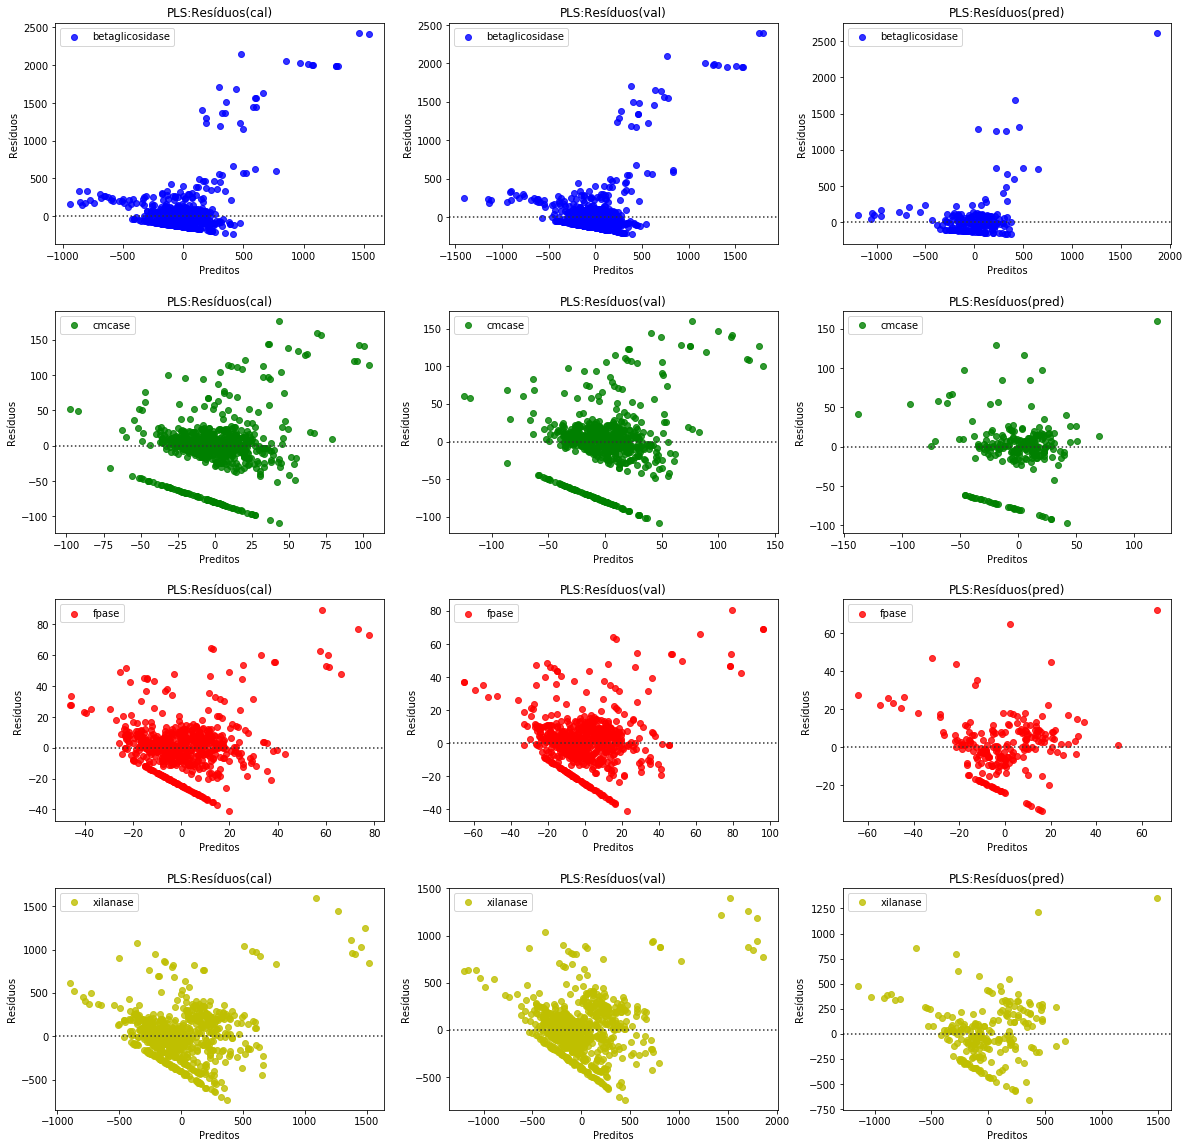

In [325]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

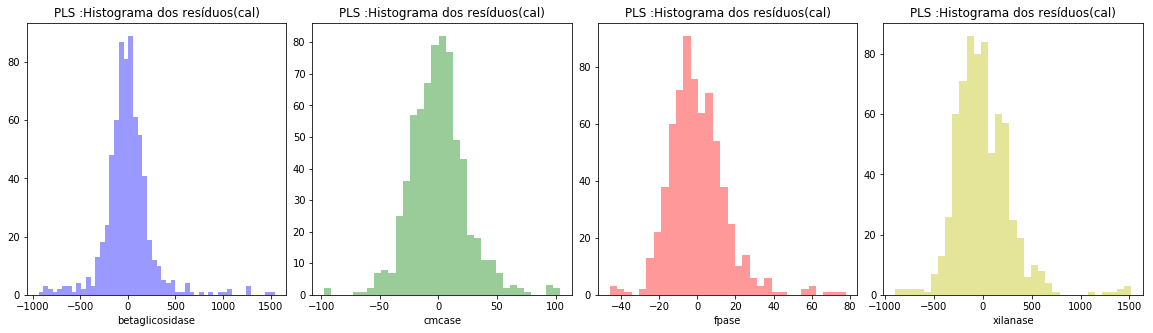

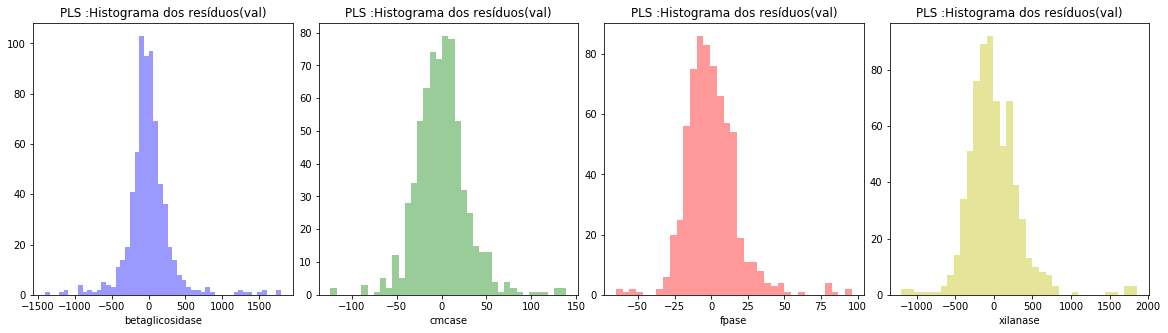

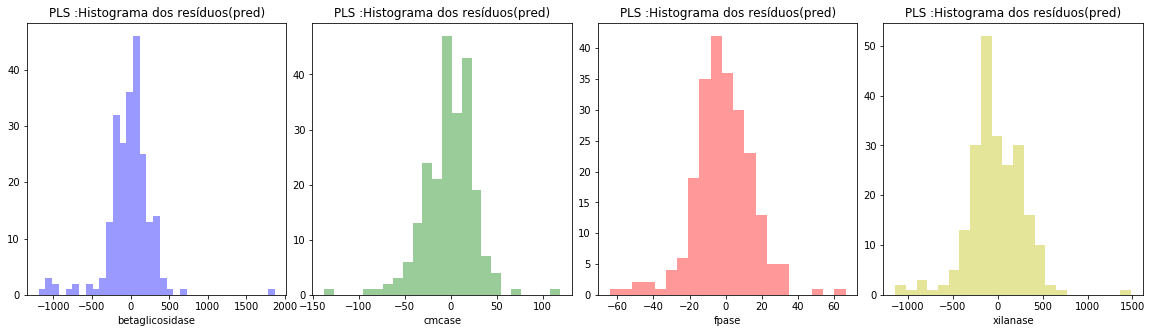

In [326]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

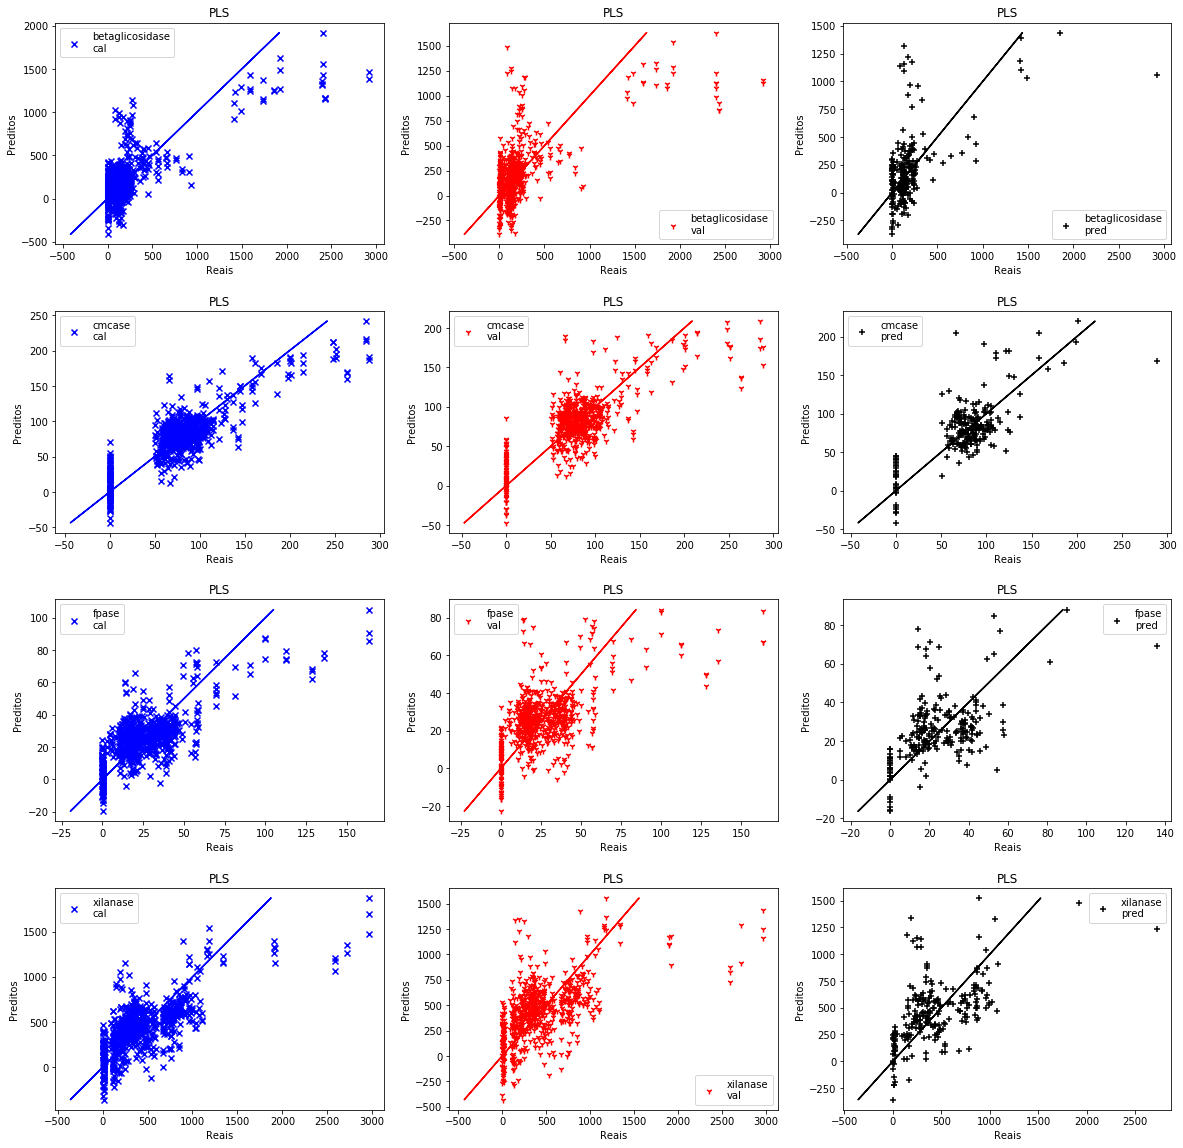

In [327]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

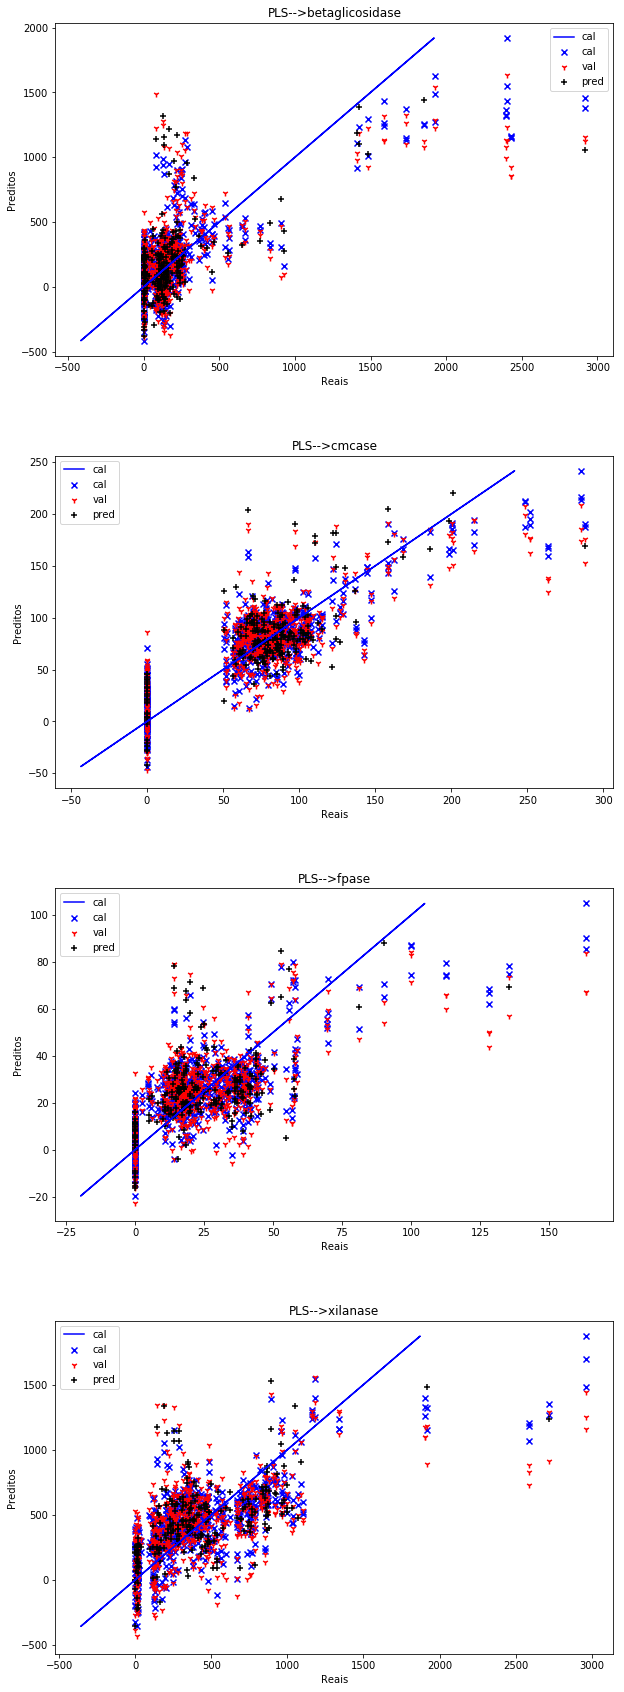

In [328]:
#graico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### PLS: Gráficos: dados de treino

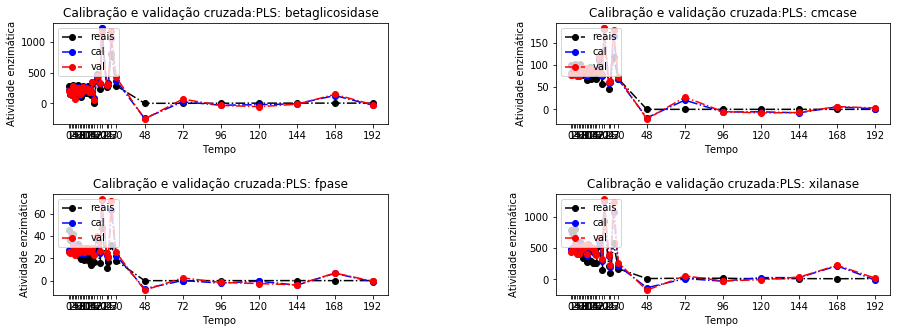

In [329]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### PLS: Gráficos de  teste

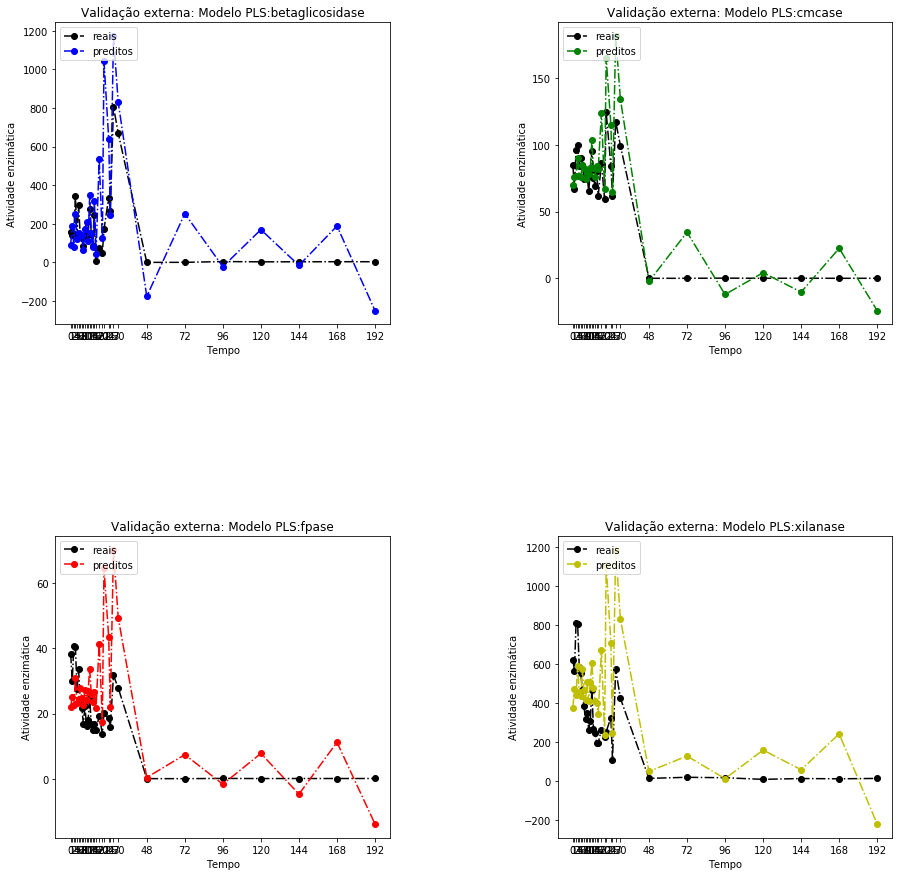

In [330]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

## Ridge: Quadrados mínimos lineares

In [331]:
#ridge
#função completa para execução do Ridge:
from sklearn.linear_model import Ridge
def executaRidge(preproc, IC=0):
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False, IC)
        
    
    reg = Ridge(alpha = 1.0, solver = 'auto', max_iter=1000)
    #reg = Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000, 
               # normalize=False, random_state=0, solver='auto', tol=0.001)

    
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

In [332]:
#PCA_Ridge
from sklearn.linear_model import Ridge
def executaPCA_Ridge(preproc, nPC=4, IC=0):
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False, IC)
        
    
    reg = Ridge(alpha = 1.0, solver = 'auto',max_iter=500)
   
    # Roda o PCA e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pca = PCA(n_components=nPC)
    x_treino = pca.fit_transform(x_treino)[:,:nPC]
    x_teste = pca.fit_transform(x_teste)[:,:nPC] 
    
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

### Ridge: testes

In [333]:
#ridge teste simples
modelo = 'Ridge'
for k in range(12):
    print(preProc[k])
    result = executaRidge(k)
    print('Parâmetros do modelo:',modelo,'\n',result[0])

    resultados=exibeResultados(result)
    
    for k,v in zip(resultados.keys(),resultados.values()):
        print(k)
        print(v,'\n-----------------------------------------------------')

Pré-proc: 0--> Sem pré-processamento
Parâmetros do modelo: Ridge 
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=None, solver='auto', tol=0.001)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.0000     0.0000    0.0000       0.0000
MSE       115074.7116  1585.0912  392.5713  140612.1217
R2             0.2008     0.2065    0.1033       0.1009
RER            8.5972     7.2272    8.2370       7.8908
RMSE         339.2266    39.8132   19.8134     374.9828
RPD            1.1186     1.1226    1.0560       1.0546
RPIQ           0.4547     0.7390    1.0749       1.1015
SEP          339.4760    39.8425   19.8280     375.2584 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.2024    -0.0333   -0.0222      -0.5680
MSE       116405.8815  1608.7070  398.4643  143191.3094
R2             0.1916     0.1947    0.0898       0.0844
RER         

cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.0000     0.0000    0.0000       0.0000
MSE       123938.9390  1758.6539  409.1407  149900.4329
R2             0.1393     0.1197    0.0654       0.0415
RER            8.2840     6.8613    8.0685       7.6424
RMSE         352.0496    41.9363   20.2272     387.1698
RPD            1.0779     1.0658    1.0344       1.0214
RPIQ           0.4381     0.7016    1.0529       1.0668
SEP          352.3084    41.9671   20.2421     387.4544 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.0408    -0.0111   -0.0072      -0.1749
MSE       125292.3725  1776.6133  412.8106  151187.4165
R2             0.1299     0.1107    0.0570       0.0332
RER            8.2392     6.8265    8.0325       7.6098
RMSE         353.9666    42.1499   20.3177     388.8283
RPD            1.0720     1.0604    1.0298       1.0170
RPIQ           0.4357     0.6981    1.048

Parâmetros do modelo: Ridge 
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=None, solver='auto', tol=0.001)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.0000     0.0000    0.0000      -0.0000
MSE       116728.5054  1591.0883  392.6690  141225.4736
R2             0.1894     0.2035    0.1030       0.0969
RER            8.5361     7.2135    8.2360       7.8736
RMSE         341.6555    39.8884   19.8159     375.7998
RPD            1.1107     1.1205    1.0559       1.0523
RPIQ           0.4514     0.7376    1.0748       1.0991
SEP          341.9067    39.9178   19.8304     376.0760 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.2384    -0.0289   -0.0166      -0.4699
MSE       118004.9842  1611.8737  397.6356  143470.7486
R2             0.1805     0.1931    0.0917       0.0826
RER            8.4898     7.1669    8.1844       

In [336]:
#ridge otimizando
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaRidge(preproc=8,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.5387, 0.7343, 0.3956, 0.408] 
semente: b c f x [35, 35, 8, 35]


In [345]:
#ridge teste otimizado
modelo = 'Ridge:'
result = result = executaRidge(preproc=8,IC=35)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: Ridge: 
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=None, solver='auto', tol=0.001)


In [346]:
resultados['cal']

betaglicosidase    cmcase     fpase    xilanase
BIAS           0.0000    0.0000    0.0000     -0.0000
MSE        60690.2321  508.4924  200.2690  76146.5487
R2             0.5867    0.7434    0.5442      0.5333
RER           11.8382   12.7601   11.5324     10.7227
RMSE         246.3539   22.5498   14.1516    275.9466
RPD            1.5555    1.9741    1.4812      1.4638
RPIQ           0.6322    1.2148    1.5439      1.7874
SEP          246.5350   22.5664   14.1620    276.1495

In [343]:
resultados['val']

betaglicosidase    cmcase     fpase     xilanase
BIAS           0.8353   -0.0094   -0.0499      -0.5398
MSE        83193.1675  718.2128  291.6175  106728.0641
R2             0.4222    0.6405    0.3339       0.3175
RER           10.1112   10.7367    9.5570       9.0571
RMSE         288.4323   26.7995   17.0768     326.6926
RPD            1.3156    1.6678    1.2252       1.2105
RPIQ           0.5347    1.0979    1.2471       1.2643
SEP          288.6431   26.8192   17.0893     326.9323

In [344]:
resultados['pred']

betaglicosidase    cmcase     fpase     xilanase
BIAS         -22.5137   -2.9242   -0.0274       7.0957
MSE        84783.1796  867.7877  266.7461  101906.2826
R2             0.4003    0.5574    0.3607       0.3605
RER           10.0312    9.8017    8.2890       8.5031
RMSE         291.1755   29.4582   16.3324     319.2276
RPD            1.2913    1.5031    1.2507       1.2505
RPIQ           0.4843    0.7805    1.3614       1.6507
SEP          290.9454   29.3775   16.3684     319.8541

In [287]:
reg, treino_teste,y_c,y_cv,y_p = result

###  Reais x preditos

In [288]:
#ridge reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.5610  0.0586  0.0561   10.0978                 3.5881   
1            0.4280  0.0390  0.0334   13.7624                 0.5481   
2            3.2342  0.0672  0.0543    8.4772                 3.1771   
3            0.0308  0.0213  0.0113    0.0996                 0.1249   
4            3.8994  0.1118  0.0613   10.9512                 3.7519   
5            0.5905  0.0465  0.0267   18.7095                 0.5751   
6            0.1724  0.0112  0.0121    0.0924                 0.1611   
7            0.6010  0.0559  0.0116   20.1368                 0.5630   
8            2.1643  0.0830  0.0529   18.8324                 2.0584   
9            0.0759  0.0136  0.0139    0.0726                 0.0987   
10           3.2342  0.0672  0.0543    8.4772                 3.2756   
11           0.1671  0.0117  0.0104    0.1117                 0.0636   
12           3.5610  0.0586  0.0561   10.0978                 3.5582   
13           2.9123  0.1058  0.0747   14.6813                 2.9890   
14           3.8994  0.1118  0.0613   10.9512                 3.9198   
15           0.6491  0.0605  0.0260   18.4274                 0.6166   
16           0.4280  0.0390  0.0334   13.7624                 0.4082   
17           0.6491  0.0605  0.0260   18.4274                 0.7623   
18           2.9123  0.1058  0.0747   14.6813                 3.0716   
19           0.6491  0.0605  0.0260   18.4274                 0.6488   
20           2.1150  0.0730  0.0505   18.4127                 2.1569   
21           0.6010  0.0559  0.0116   20.1368                 0.5785   
22           0.0308  0.0213  0.0113    0.0996                -0.0142   
23           0.0874  0.0217  0.0127    0.1071                 0.0243   
24           0.0554  0.0181  0.0106    0.3275                 0.0697   
25           0.1724  0.0112  0.0121    0.0924                 0.2656   
26           3.8876  0.0418  0.0605   11.0267                 3.8068   
27           3.8803  0.0557  0.0691   11.3256                 3.8549   
28           2.7110  0.0548  0.0688   13.5829                 2.8608   
29           0.1671  0.0117  0.0104    0.1117                 0.1130   
30           3.1068  0.0781  0.0545   11.0526                 3.1491   
31           2.1643  0.0830  0.0529   18.8324                 2.1813   
32           2.9123  0.1058  0.0747   14.6813                 2.8563   
33           3.7243  0.0561  0.0681   11.5736                 3.6938   
34           3.7243  0.0561  0.0681   11.5736                 3.6235   
35           0.1724  0.0112  0.0121    0.0924                 0.1320   
36           0.1671  0.0117  0.0104    0.1117                 0.3047   
37           3.1068  0.0781  0.0545   11.0526                 3.1119   
38           0.4280  0.0390  0.0334   13.7624                 0.3843   
39           0.3828  0.0405  0.0301   12.4461                 0.5113   
40           3.5967  0.1065  0.0850   13.6476                 3.5080   
41           3.5974  0.0516  0.0731   15.3973                 3.4035   
42           3.8876  0.0418  0.0605   11.0267                 3.9966   
43           0.0874  0.0217  0.0127    0.1071                 0.0493   
44           0.3828  0.0405  0.0301   12.4461                 0.3660   
45           0.3900  0.0315  0.0283   14.1777                 0.4816   
46           3.2342  0.0672  0.0543    8.4772                 3.2270   
47           2.7110  0.0548  0.0688   13.5829                 2.8335   
48           3.1068  0.0781  0.0545   11.0526                 3.1146   
49           2.9774  0.0704  0.0567   10.8002                 2.9776   
50           2.7110  0.0548  0.0688   13.5829                 2.7560   
51           0.6010  0.0559  0.0116   20.1368                 0.5538   
52           3.5967  0.1065  0.0850   13.6476                 3.4913   
53           0.5905  0.0465  0.0267   18.7095                 0.6265   
54           3.8876  0.0418  0.0605   11.026

In [1062]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.2342  0.0672  0.0543    8.4772                 2.7566   
1            0.3900  0.0315  0.0283   14.1777                 0.5290   
2            2.9123  0.1058  0.0747   14.6813                 3.7219   
3            0.0554  0.0181  0.0106    0.3275                 0.8852   
4            2.1150  0.0730  0.0505   18.4127                 3.6636   
5            3.8994  0.1118  0.0613   10.9512                 3.2920   
6            3.2342  0.0672  0.0543    8.4772                 2.8189   
7            3.5610  0.0586  0.0561   10.0978                 4.0764   
8            3.5610  0.0586  0.0561   10.0978                 4.0725   
9            0.0308  0.0213  0.0113    0.0996                -0.3955   
10           2.9774  0.0704  0.0567   10.8002                 3.0278   
11           0.1671  0.0117  0.0104    0.1117                -0.8059   
12           0.5905  0.0465  0.0267   18.7095                 0.7814   
13           3.1068  0.0781  0.0545   11.0526                 2.2134   
14           3.8994  0.1118  0.0613   10.9512                 3.7650   
15           3.5974  0.0516  0.0731   15.3973                 3.3843   
16           3.8803  0.0557  0.0691   11.3256                 5.1440   
17           0.3900  0.0315  0.0283   14.1777                 1.5222   
18           3.1068  0.0781  0.0545   11.0526                 3.2246   
19           2.7110  0.0548  0.0688   13.5829                 2.7880   
20           3.7243  0.0561  0.0681   11.5736                 3.4571   
21           0.0874  0.0217  0.0127    0.1071                -0.4743   
22           0.0759  0.0136  0.0139    0.0726                -0.4536   
23           3.8803  0.0557  0.0691   11.3256                 1.9551   
24           3.1068  0.0781  0.0545   11.0526                 3.5281   
25           0.6491  0.0605  0.0260   18.4274                 1.0689   
26           2.1150  0.0730  0.0505   18.4127                 2.9760   
27           0.5905  0.0465  0.0267   18.7095                 0.2367   
28           3.5967  0.1065  0.0850   13.6476                 3.8621   
29           0.4280  0.0390  0.0334   13.7624                 1.7822   
30           0.0554  0.0181  0.0106    0.3275                 1.1182   
31           3.5967  0.1065  0.0850   13.6476                 3.5195   
32           2.9123  0.1058  0.0747   14.6813                 3.0683   
33           3.5974  0.0516  0.0731   15.3973                 3.0922   
34           0.1671  0.0117  0.0104    0.1117                 0.3451   
35           3.8876  0.0418  0.0605   11.0267                 3.4058   
36           0.6491  0.0605  0.0260   18.4274                 0.6689   
37           0.3828  0.0405  0.0301   12.4461                 0.9434   
38           3.5967  0.1065  0.0850   13.6476                 2.8730   
39           2.1150  0.0730  0.0505   18.4127                 2.4629   
40           0.0759  0.0136  0.0139    0.0726                 0.6554   
41           0.1671  0.0117  0.0104    0.1117                 0.5818   
42           0.4280  0.0390  0.0334   13.7624                 1.2096   
43           4.6037  0.1713  0.0919   16.8115                 3.3256   
44           3.5610  0.0586  0.0561   10.0978                 4.6518   
45           0.6010  0.0559  0.0116   20.1368                 0.4559   
46           0.1724  0.0112  0.0121    0.0924                 0.8868   
47           0.3828  0.0405  0.0301   12.4461                 0.3780   
48           3.8876  0.0418  0.0605   11.0267                 3.8076   
49           4.6037  0.1713  0.0919   16.8115                 2.3752   
50           0.1724  0.0112  0.0121    0.0924                 0.7466   
51           0.5905  0.0465  0.0267   18.7095                -0.5143   
52           0.0759  0.0136  0.0139    0.0726                 0.1369   
53           0.0554  0.0181  0.0106    0.3275                 0.3721   
54           0.6010  0.0559  0.0116   20.136

In [1063]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.5974  0.0516  0.0731   15.3973                 3.9585   
1            3.8803  0.0557  0.0691   11.3256                 3.7439   
2            3.7243  0.0561  0.0681   11.5736                 3.8461   
3            2.1643  0.0830  0.0529   18.8324                 3.9182   
4            0.6491  0.0605  0.0260   18.4274                 0.2357   
5            0.3900  0.0315  0.0283   14.1777                 1.0511   
6            2.1643  0.0830  0.0529   18.8324                 3.0518   
7            0.0874  0.0217  0.0127    0.1071                 0.6861   
8            2.9123  0.1058  0.0747   14.6813                 3.2884   
9            0.0308  0.0213  0.0113    0.0996                -0.8406   
10           0.3828  0.0405  0.0301   12.4461                 1.5538   
11           0.4280  0.0390  0.0334   13.7624                 0.9922   
12           0.0308  0.0213  0.0113    0.0996                 0.1783   
13           0.1724  0.0112  0.0121    0.0924                 0.1588   
14           3.7243  0.0561  0.0681   11.5736                 4.9058   
15           0.0874  0.0217  0.0127    0.1071                 0.6000   
16           2.9774  0.0704  0.0567   10.8002                 2.5004   
17           2.1643  0.0830  0.0529   18.8324                 2.3034   
18           2.7110  0.0548  0.0688   13.5829                 4.0600   
19           2.7110  0.0548  0.0688   13.5829                 2.7219   
20           0.6010  0.0559  0.0116   20.1368                 0.9115   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0823       0.0809         15.6671  
1         0.0581       0.0611         10.6501  
2         0.0733       0.0748         12.5182  
3         0.1324       0.0732         13.5936  
4         0.0320       0.0175         15.3187  
5         0.0563       0.0357         10.1028  
6         0.0938       0.0614         14.3134  
7         0.0356       0.0105          1.1984  
8         0.1211       0.0817         18.4668  
9        -0.0294      -0.0094         -1.2611  
10        0.0949       0.0472         11.1344  
11        0.0605       0.0457         13.3416  
12        0.0334       0.0198          6.5912  
13        0.0106       0.0115          4.2335  
14        0.1278       0.0859         13.8037  
15        0.0044       0.0095          2.9197  
16        0.0562       0.0432          7.7705  
17        0.0633       0.0407         13.6693  
18        0.0821       0.0807         12.8034  
19        0.0115       0.0532         12.0130  
20        0.0573       0.0266         17.5853

###  Ridge: Gráficos de resíduos - histograma - reais x preditos

In [304]:
#título para os gráficos
modelo = 'Ridge'

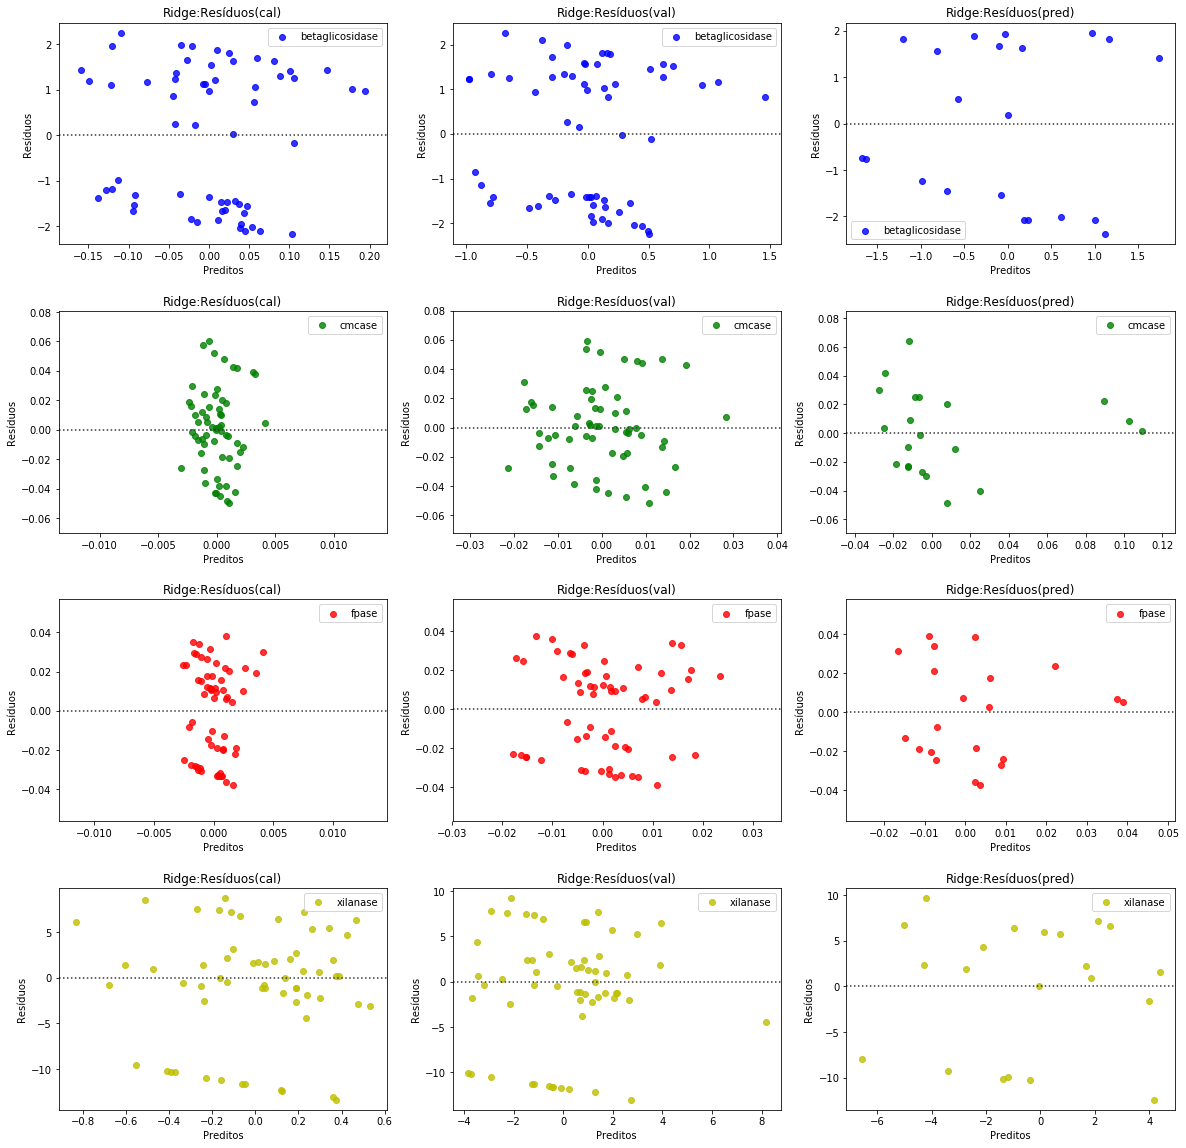

In [305]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

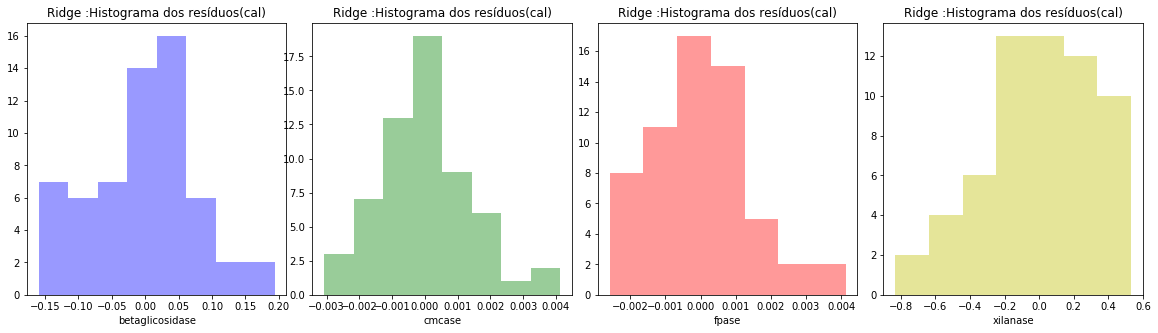

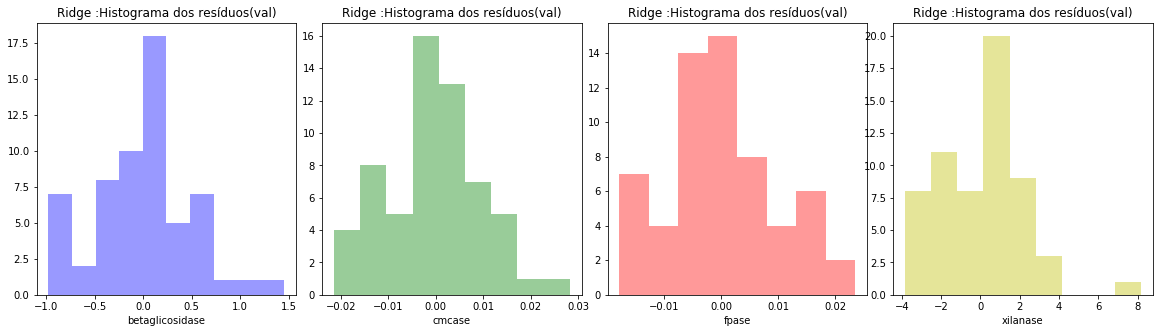

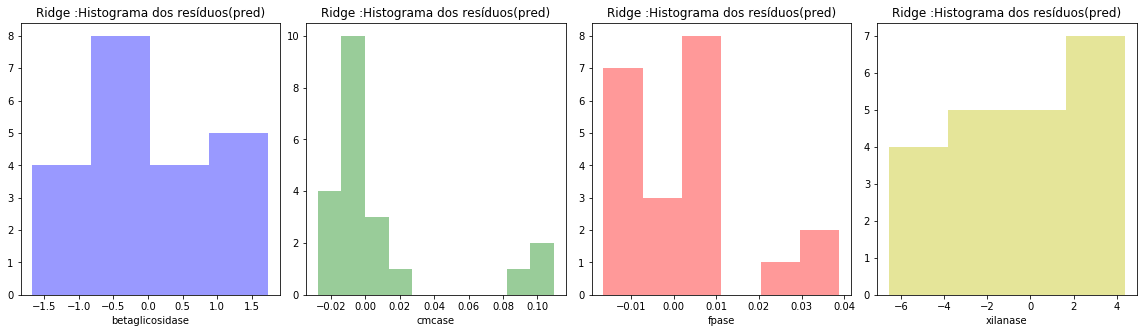

In [306]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

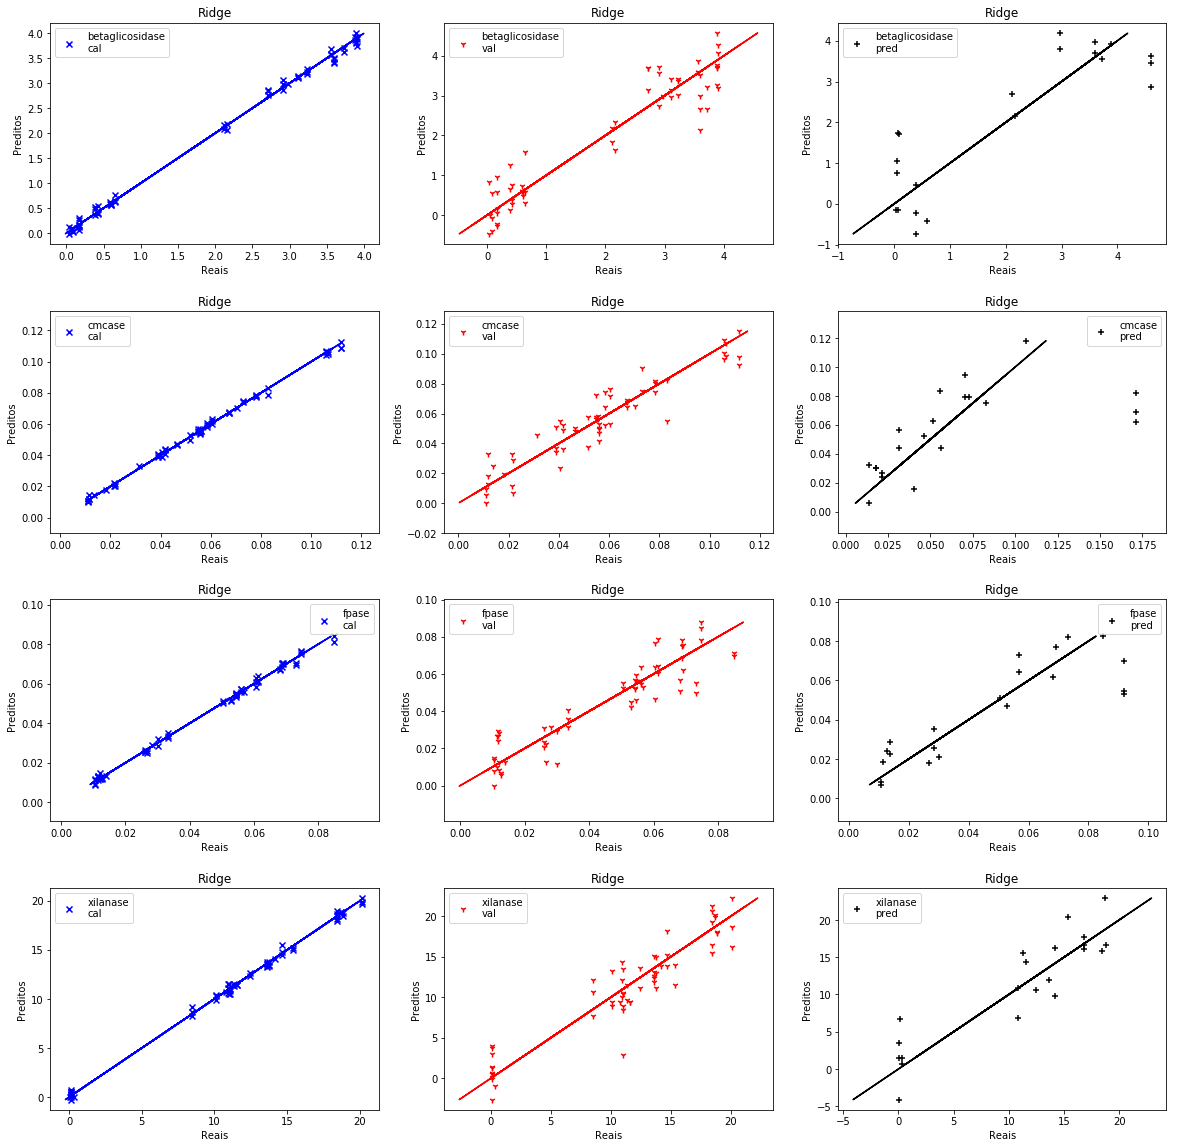

In [308]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

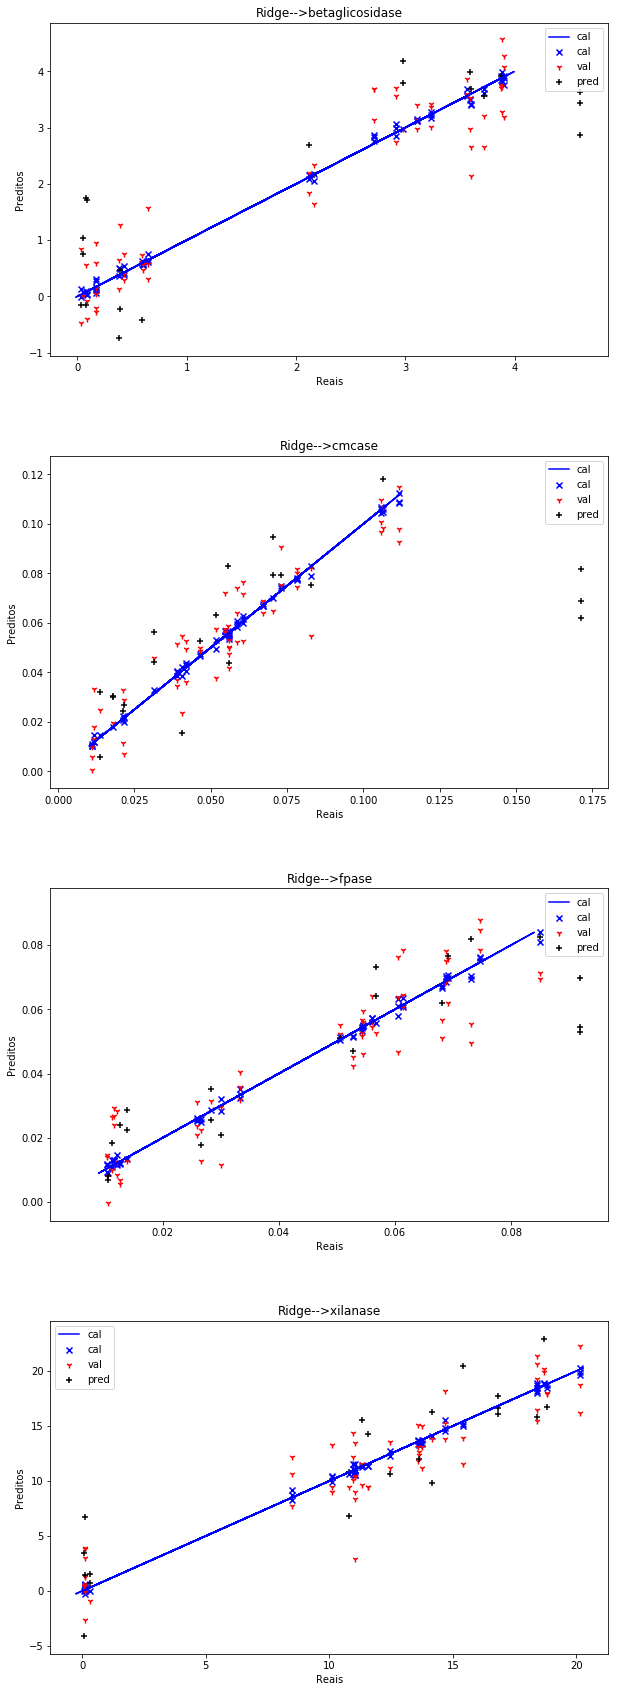

In [309]:
#graico de reais x preditos
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### Ridge: Gráficos: dados de treino

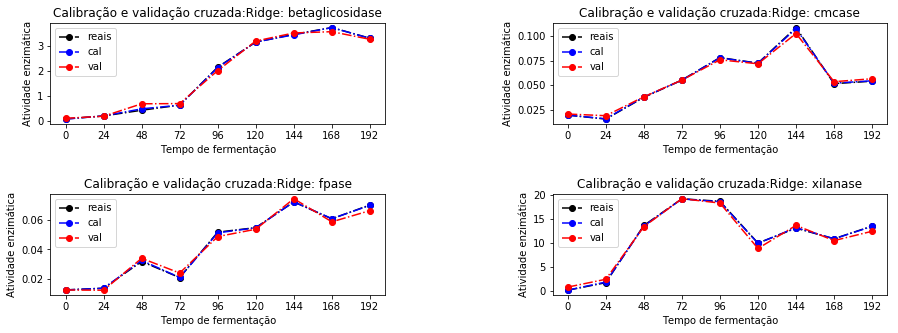

In [310]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### Ridge: Gráficos de  teste

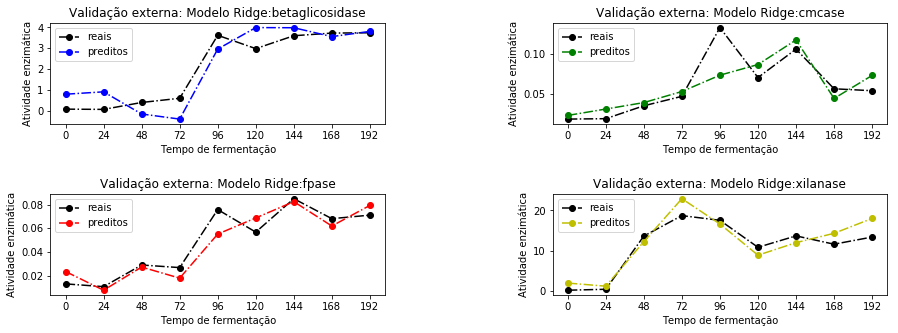

In [311]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

## Kernel Ridge: Quadrados mínimos lineares com kernel

In [347]:
#kernelRidge
def executaKernelRidge(preproc=1, teste=1, k='linear', IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False, IC)
        

   
    if teste == 1:
        reg = GridSearchCV(estimator=KernelRidge(), cv=5,
                  param_grid={"kernel":['rbf','linear','poly'],
                              "alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": [.1,.2,0,1,2,3,4,5,10],
                              "degree":[1,2,3]
                            })
    elif teste==2:
        #kernel otimizado
        reg = KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear')
    else:
         reg = KernelRidge(kernel = k,alpha = 1.0)
    
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

### Kernel Ridge: testes

In [348]:
#Kernelridge teste para um tipo de pré-processamento
modelo = 'Kernel Ridge'
result = executaKernelRidge(preproc=1,teste=0,k='rbf')
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
    
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: Kernel Ridge 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None)
cal
      betaglicosidase    cmcase     fpase    xilanase
BIAS           2.7124    0.5312    0.2049      2.8256
MSE        40255.7672  414.1409  210.5220  74055.1554
R2             0.7204    0.7927    0.5191      0.5265
RER           14.5369   14.1439   11.2492     10.8737
RMSE         200.6384   20.3505   14.5094    272.1308
RPD            1.8913    2.1963    1.4420      1.4532
RPIQ           0.7687    1.4458    1.4678      1.5178
SEP          200.7675   20.3585   14.5186    272.3161 
-----------------------------------------------------
val
      betaglicosidase    cmcase     fpase    xilanase
BIAS           2.8059    0.5650    0.1955      2.3252
MSE        44893.0676  471.4838  235.4477  82842.0011
R2             0.6882    0.7640    0.4622      0.4703
RER           13.7656   13.2559   10.6369     10.2806
RMSE         211.8798   21.7137   15.3443    287.8

In [349]:
#Kernelridge teste pré-proc
modelo = 'Kernel Ridge'
for k in range(12):
    print(preProc[k])
    result = executaKernelRidge(k, teste=0, k='poly')
    print('Parâmetros do modelo:',modelo,'\n',result[0])

    resultados=exibeResultados(result)
    
    for k,v in zip(resultados.keys(),resultados.values()):
        print(k)
        print(v,'\n-----------------------------------------------------')

Pré-proc: 0--> Sem pré-processamento
Parâmetros do modelo: Kernel Ridge 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='poly',
      kernel_params=None)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.8509     0.0923    0.0335       0.6200
MSE       130365.7543  1816.0261  417.0288  152232.4615
R2             0.0946     0.0909    0.0474       0.0265
RER            8.0773     6.7521    7.9918       7.5836
RMSE         361.0620    42.6149   20.4213     390.1698
RPD            1.0510     1.0488    1.0246       1.0135
RPIQ           0.4272     0.6904    1.0429       1.0586
SEP          361.3264    42.6461   20.4363     390.4561 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.9065     0.0878    0.0296       0.5115
MSE       131661.1097  1834.5792  420.4649  153389.9409
R2             0.0856     0.0817    0.0395       0.0191
RER            8.0375     6.7178    7.95

Parâmetros do modelo: Kernel Ridge 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='poly',
      kernel_params=None)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.3384     0.1180    0.0377       0.6456
MSE       143549.8682  1992.7728  437.1793  156253.9297
R2             0.0031     0.0025    0.0014       0.0008
RER            7.6974     6.4457    7.8055       7.4854
RMSE         378.8798    44.6405   20.9088     395.2897
RPD            1.0015     1.0012    1.0007       1.0004
RPIQ           0.4071     0.6591    1.0186       1.0449
SEP          379.1581    44.6731   20.9242     395.5797 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.3876     0.1313    0.0418       0.7075
MSE       143968.9313  1998.1155  438.7067  156901.0354
R2             0.0002    -0.0002   -0.0021      -0.0033
RER            7.6862     6.4371    7.7919       7.4699
RMSE         379.4324

Parâmetros do modelo: Kernel Ridge 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='poly',
      kernel_params=None)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.2010     0.0738    0.0235       0.4040
MSE       133817.3646  1854.0992  421.4226  153266.0702
R2             0.0707     0.0719    0.0374       0.0199
RER            7.9724     6.6824    7.9500       7.5580
RMSE         365.8106    43.0593   20.5286     391.4921
RPD            1.0373     1.0380    1.0192       1.0101
RPIQ           0.4216     0.6833    1.0374       1.0550
SEP          366.0794    43.0908   20.5437     391.7797 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.2383     0.0729    0.0214       0.3380
MSE       134975.6608  1870.6926  424.5037  154294.8789
R2             0.0626     0.0636    0.0303       0.0134
RER            7.9381     6.6527    7.9211       7.5328
RMSE         367.3903

In [446]:
'''#kernel ridge teste otimização automática
modelo = 'Kernel Ridge:'
result = result = executaKernelRidge(preproc=8, teste=1)
print('Parâmetros do modelo:',modelo,'\n',result[0])'''


"#kernel ridge teste otimização automática\nmodelo = 'Kernel Ridge:'\nresult = result = executaKernelRidge(preproc=8, teste=1)\nprint('Parâmetros do modelo:',modelo,'\n',result[0])"

In [355]:
#Kernel ridge otimizando
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaKernelRidge(preproc=8,k='poly',teste=0,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['val'].loc[resultados['val'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.6625, 0.7844, 0.5084, 0.4688] 
semente: b c f x [77, 70, 75, 77]


In [356]:
#kernel ridge teste otimizado
modelo = 'Kernel Ridge:'
result = result = executaKernelRidge(preproc=8,k='poly', teste=0, IC=80)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: Kernel Ridge: 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='poly',
      kernel_params=None)


In [357]:
resultados['cal']

betaglicosidase    cmcase    fpase    xilanase
BIAS           0.0950    0.1061   0.0334      0.6352
MSE         6914.1962  113.3153  56.8473  21637.0737
R2             0.9486    0.9410   0.8688      0.8596
RER           35.0732   27.0317  21.6460     20.1157
RMSE          83.1516   10.6450   7.5397    147.0955
RPD            4.4110    4.1176   2.7607      2.6687
RPIQ           1.7775    2.6135   2.8413      3.2621
SEP           83.2127   10.6523   7.5452    147.2022

In [358]:
resultados['val']

betaglicosidase    cmcase     fpase    xilanase
BIAS           4.9365    0.3258    0.2595      3.8120
MSE        50460.5795  498.3240  224.7601  82158.9205
R2             0.6249    0.7406    0.4812      0.4668
RER           12.9860   12.8910   10.8876     10.3238
RMSE         224.6343   22.3232   14.9920    286.6338
RPD            1.6328    1.9635    1.3884      1.3695
RPIQ           0.6580    1.2463    1.4289      1.6741
SEP          224.7451   22.3372   15.0008    286.8191

In [360]:
resultados['pred']

betaglicosidase    cmcase     fpase     xilanase
BIAS           5.6756   -2.7781   -1.5555     -31.0355
MSE        77170.7026  626.9696  289.0106  113984.1814
R2             0.5463    0.7141    0.3279       0.3130
RER           10.4850   11.5458    7.9966       8.0721
RMSE         277.7962   25.0394   17.0003     337.6154
RPD            1.4846    1.8701    1.2198       1.2065
RPIQ           0.5608    1.0983    1.2981       1.1970
SEP          278.3520   24.9398   16.9664     336.9289

In [218]:
reg, treino_teste,y_c,y_cv,y_p = result

### Kernel Ridge Reais x preditos

In [361]:
#kernelridge reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0           121.3549   82.6985   32.8966   415.1712               252.0155   
1            55.2638   50.7277   15.4562   163.7129                93.6497   
2           110.4872   97.6145   30.0285   419.8360               311.2144   
3           336.7610   67.4547   22.4708   150.7103               412.4107   
4           184.5409   94.4735   34.0078   710.9095               358.0109   
5           130.8023   67.3478   14.2291   203.0631               135.8361   
6           237.1880   89.6847   43.6678   924.0410               383.8837   
7           129.4330  114.8104   37.3938   671.3381                25.6031   
8           131.9201   85.3513   35.8638   575.7837               106.5224   
9           191.9041  102.3202   17.1605   352.7522               211.8061   
10            0.3828    0.0405    0.0301    12.4461              -415.1356   
11          154.8522   79.5483   19.7968   218.6271               124.8313   
12          133.2707   74.8560   17.8949   135.6123               140.3514   
13          136.2851  112.3726   26.5009   313.8180                23.9125   
14          191.9041  102.3202   17.1605   352.7522               311.2620   
15            2.1643    0.0830    0.0529    18.8324              -230.1799   
16           84.2733   77.4659   11.0090   115.7702              -174.5889   
17          229.4566   85.1762   17.7045   477.4046               201.0226   
18          248.6120  158.4460   69.6480   905.4550               875.8773   
19         2431.6260  263.4420  128.2720  2585.4951              1159.4403   
20           38.1276   60.8791   16.0449   349.3120               306.5021   
21            0.3900    0.0315    0.0283    14.1777               -40.6681   
22          134.6752   82.1768   32.9392   560.4463                66.3386   
23          273.5800  162.1220   69.8540   962.5400              1135.9605   
24          388.0160   59.7335   23.9698   258.8844               525.0777   
25            0.1671    0.0117    0.0104     0.1117                63.4542   
26         2397.5010  251.6900  112.6160  1901.4399              1363.2674   
27           42.5092   60.4743   15.4377   338.4625                93.4003   
28          129.4330  114.8104   37.3938   671.3381                17.0830   
29         2403.2200  285.3140  163.3280  2961.1440              1919.2039   
..               ...       ...       ...        ...                    ...   
651         102.6849   80.3544   39.3470   680.4508               216.2205   
652          64.0786   77.4722   17.6446   330.8339               182.0447   
653          94.1372   77.0335   36.1238   667.2302                59.2361   
654         158.5821   77.3812   31.1380   832.2265                16.5557   
655           5.5289   62.7837   18.6321   247.3351              -236.8411   
656           0.4280    0.0390    0.0334    13.7624              -344.9741   
657          76.8184   77.5492   12.0919   199.7503              -139.8934   
658          30.6799   51.8303   11.4133   353.3897               -19.2189   
659         151.0042   86.3585   28.9155   793.7070               230.3381   
660        1485.9540  168.2210   49.3830   959.0790              1010.7520   
661           2.7110    0.0548    0.0688    13.5829              -127.3844   
662         136.8757   63.2618   13.4966   214.6944               189.9977   
663         250.8100   77.3295   14.7702   258.2026               245.3354   
664        1586.9160  200.3440   57.0920  1163.2500              1243.4587   
665         143.8933  128.5731   57.8269   866.2308               222.6327   
666         122.1230   96.9230   25.5450   376.6580               127.7288   
667         145.1078   85.6441   17.6879   466.9096              -170.3474   
668         170.8830  124.5190   20.0790   252.8500               947.0757   
669         238.6606  103.6390   18.6276   403.8937               227.5400   
670         929.7967   90.5

In [362]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0           121.3549   82.6985   32.8966   415.1712               316.8370   
1            55.2638   50.7277   15.4562   163.7129               171.0096   
2           110.4872   97.6145   30.0285   419.8360               297.8420   
3           336.7610   67.4547   22.4708   150.7103               471.5590   
4           184.5409   94.4735   34.0078   710.9095               439.4473   
5           130.8023   67.3478   14.2291   203.0631               132.1015   
6           237.1880   89.6847   43.6678   924.0410               397.9039   
7           129.4330  114.8104   37.3938   671.3381               -94.0377   
8           131.9201   85.3513   35.8638   575.7837               183.7659   
9           191.9041  102.3202   17.1605   352.7522               177.6535   
10            0.3828    0.0405    0.0301    12.4461              -389.3518   
11          154.8522   79.5483   19.7968   218.6271               140.8205   
12          133.2707   74.8560   17.8949   135.6123                36.5060   
13          136.2851  112.3726   26.5009   313.8180               -19.8170   
14          191.9041  102.3202   17.1605   352.7522               415.1180   
15            2.1643    0.0830    0.0529    18.8324              -310.1795   
16           84.2733   77.4659   11.0090   115.7702              -173.5884   
17          229.4566   85.1762   17.7045   477.4046               260.2888   
18          248.6120  158.4460   69.6480   905.4550               905.2086   
19         2431.6260  263.4420  128.2720  2585.4951               923.2859   
20           38.1276   60.8791   16.0449   349.3120               298.4927   
21            0.3900    0.0315    0.0283    14.1777                29.4758   
22          134.6752   82.1768   32.9392   560.4463               135.0295   
23          273.5800  162.1220   69.8540   962.5400              1188.1024   
24          388.0160   59.7335   23.9698   258.8844               433.2302   
25            0.1671    0.0117    0.0104     0.1117                75.3514   
26         2397.5010  251.6900  112.6160  1901.4399              1131.2230   
27           42.5092   60.4743   15.4377   338.4625                47.1644   
28          129.4330  114.8104   37.3938   671.3381                28.9367   
29         2403.2200  285.3140  163.3280  2961.1440              1631.8385   
..               ...       ...       ...        ...                    ...   
651         102.6849   80.3544   39.3470   680.4508               187.4116   
652          64.0786   77.4722   17.6446   330.8339               175.6331   
653          94.1372   77.0335   36.1238   667.2302               130.9608   
654         158.5821   77.3812   31.1380   832.2265                61.3825   
655           5.5289   62.7837   18.6321   247.3351              -233.8056   
656           0.4280    0.0390    0.0334    13.7624              -332.2206   
657          76.8184   77.5492   12.0919   199.7503              -108.5132   
658          30.6799   51.8303   11.4133   353.3897                17.1589   
659         151.0042   86.3585   28.9155   793.7070               281.2427   
660        1485.9540  168.2210   49.3830   959.0790               922.3122   
661           2.7110    0.0548    0.0688    13.5829              -194.2024   
662         136.8757   63.2618   13.4966   214.6944               148.5092   
663         250.8100   77.3295   14.7702   258.2026               263.9006   
664        1586.9160  200.3440   57.0920  1163.2500              1125.3548   
665         143.8933  128.5731   57.8269   866.2308               225.8596   
666         122.1230   96.9230   25.5450   376.6580               169.9028   
667         145.1078   85.6441   17.6879   466.9096              -219.1235   
668         170.8830  124.5190   20.0790   252.8500              1073.3493   
669         238.6606  103.6390   18.6276   403.8937               242.2192   
670         929.7967   90.5

In [363]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0            89.7074   65.3003   13.8382   361.1810               -72.5915   
1           647.8945   62.3355   19.8263   129.4946               325.9142   
2           139.6252  124.0305   36.3651   869.1574               373.5480   
3             0.6491    0.0605    0.0260    18.4274               237.5194   
4           221.1730   89.3633   45.6583   879.3857               155.7052   
5           205.7102   68.9223   17.3913   313.7515               246.0825   
6           929.7967   90.5053   57.6406   484.1380               433.4655   
7           117.2695   88.7665   16.2567   359.8273               121.6396   
8            30.1963   68.9862   15.6543   267.5124               233.8885   
9           190.4315   98.8090   43.7832   862.9206               349.8793   
10           12.3080   82.8620    4.9360    25.7000               163.1404   
11          110.7698   73.6902   15.4099   392.2006               214.7529   
12          152.1716   79.6951   30.5321   430.4869               311.2483   
13          184.5409   94.4735   34.0078   710.9095               217.0399   
14          145.8733   65.4350   15.2831   314.6077               187.5381   
15            1.5840    0.0310    0.0580    20.8190               247.4847   
16          225.3148  102.3202   18.6276   340.3618               389.5883   
17          158.8768  103.2324   39.2466   524.5162                78.3001   
18          155.7323  107.8096   45.8438  1071.1458               182.6443   
19           92.4876   78.8649   10.9856   212.8161                48.5945   
20          199.6355  108.0239   40.1566   862.9206               -56.8718   
21          274.2940   78.7396   19.7839   142.5907                37.7928   
22          115.7786   87.2116   12.1474   152.4512                58.1288   
23         1423.0380  158.6290   52.7020   890.4560              1104.1889   
24            3.1080    0.0410    0.0590    20.1730               192.0390   
25          247.1283   89.7259   36.2332   858.6796               166.8264   
26          122.1230   96.9230   25.5450   378.6580               558.9010   
27          136.5982   93.1212   36.2538   994.2417                71.5121   
28          139.2130   85.3606   23.8136   464.2393               -96.7433   
29          133.6771   76.1588   17.7991   465.5989               125.1086   
..               ...       ...       ...        ...                    ...   
197         171.7069   89.7105   35.0124   535.6706                47.2929   
198         225.4068  103.6390   29.3921   387.2623                87.0647   
199         133.1267   65.1176   13.8181   304.2046               191.9498   
200          52.3119   88.6736   17.6292   293.7337               277.3156   
201         366.7932   61.2608   21.3677   116.6604               392.9800   
202          24.8756   56.7357   11.4848   359.5063                99.1143   
203          75.8015   57.7596   13.1040   358.1227                25.6375   
204          97.4363   77.8881   10.9042   200.3901              -100.2986   
205          90.8381   81.0543   16.0401   215.7058                63.8919   
206         453.6864   76.7033   48.7880   510.5922               117.3922   
207         151.0042   86.3585   28.9155   793.7070                37.0264   
208         158.5821   77.3812   31.1380   832.2265               267.6476   
209         135.0762   72.1011   32.4611   592.8912               311.3504   
210          23.7272   72.8568   14.8860   376.9820                42.5025   
211         121.4940   85.0181   27.4416   519.3680                95.5059   
212         194.8494   67.7024   13.1300   277.8277                -0.8187   
213         174.3269   88.8776   41.5095   483.9741               -17.8808   
214         145.1078   85.6441   17.6879   466.9096               101.5479   
215         238.2925   63.2845   17.0122   234.2534                69.9840   
216         117.4575   93.2

## Kernel Ridge: Gráficos de resíduos - histograma - reais x preditos

In [364]:
#título para os gráficos
modelo = 'Kernel Ridge'

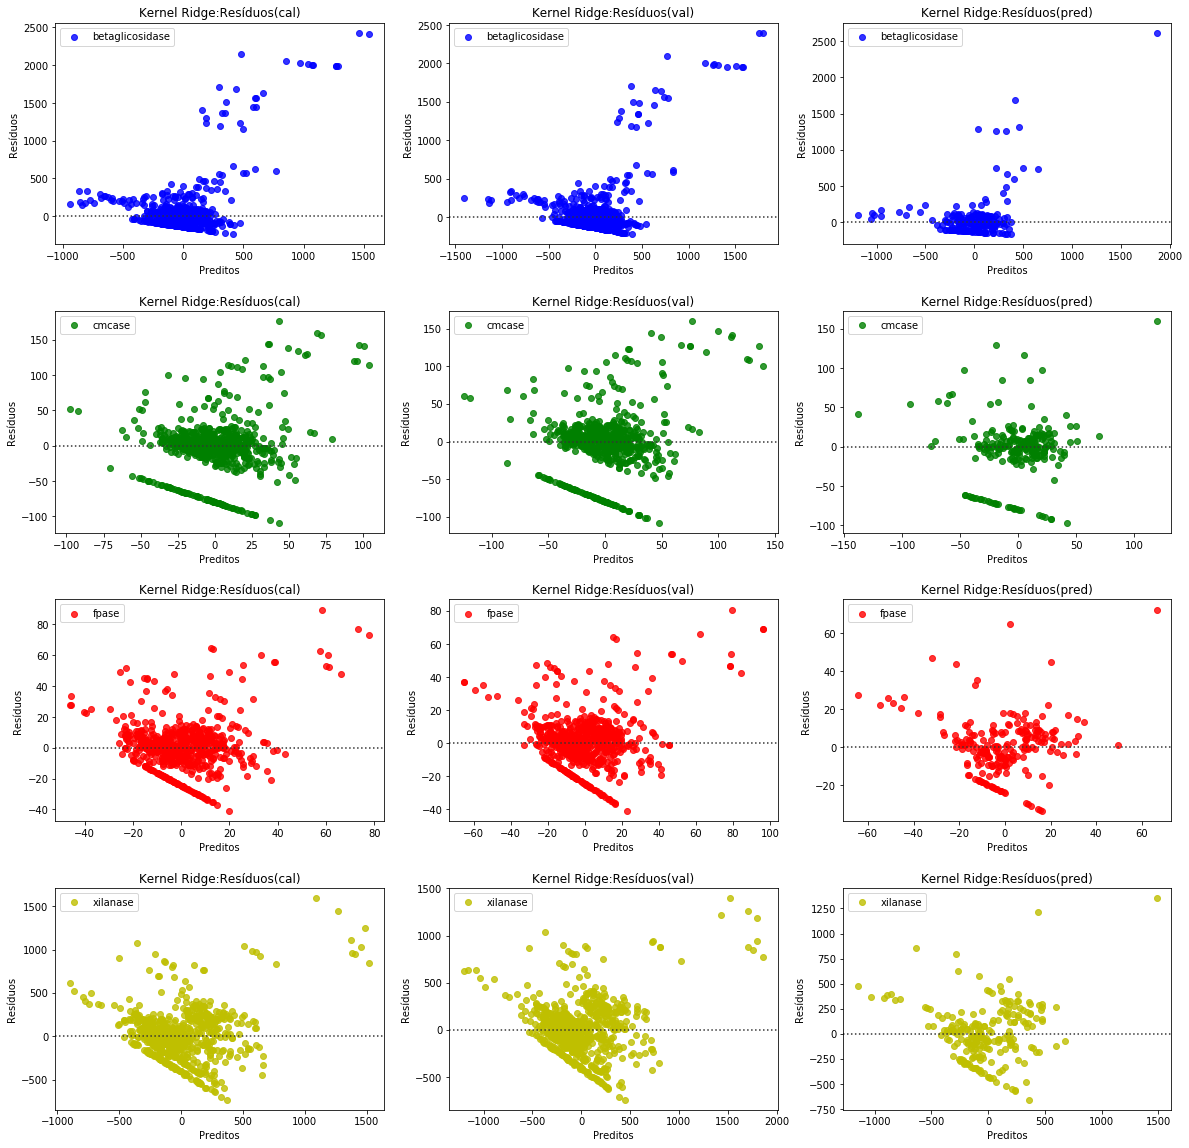

In [365]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

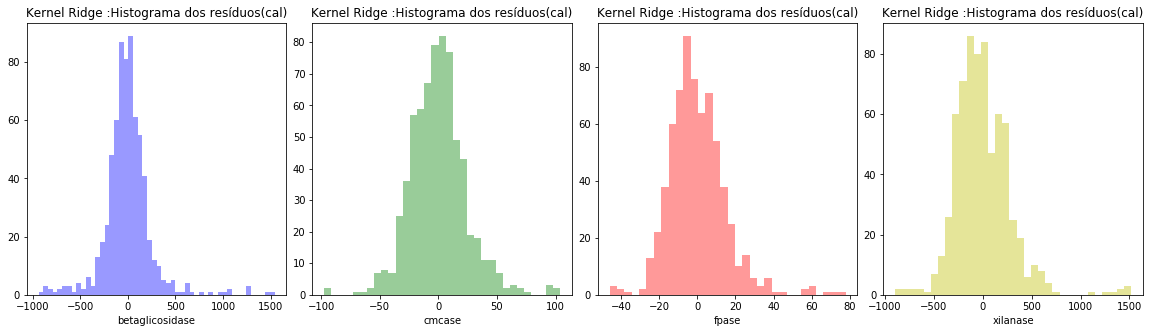

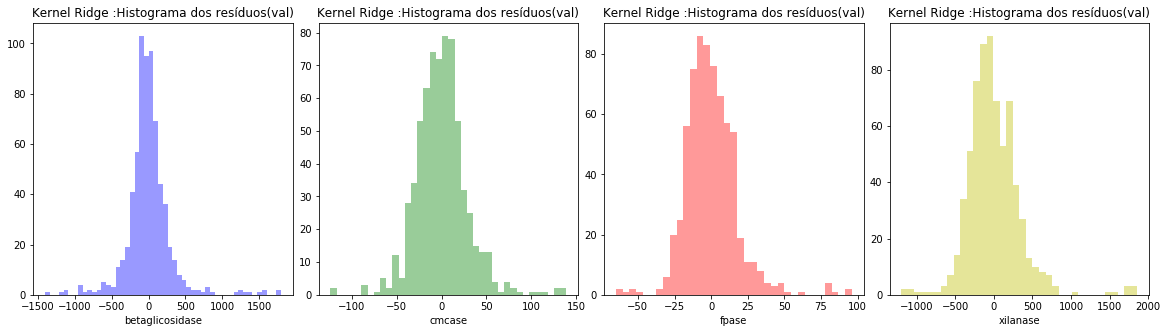

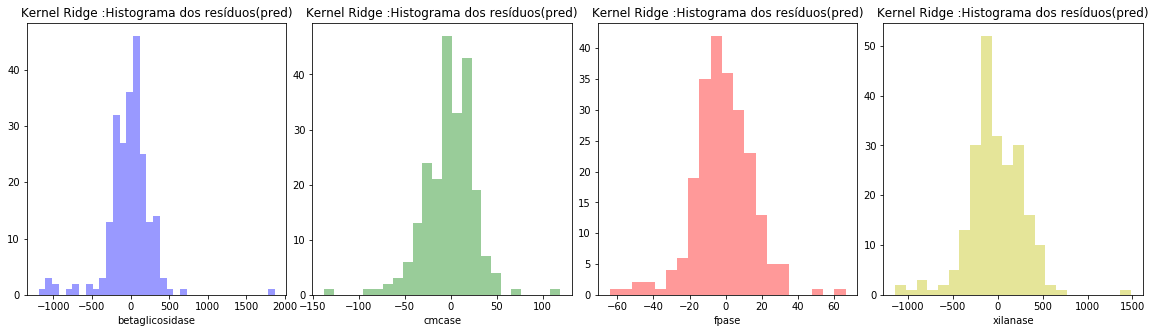

In [366]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

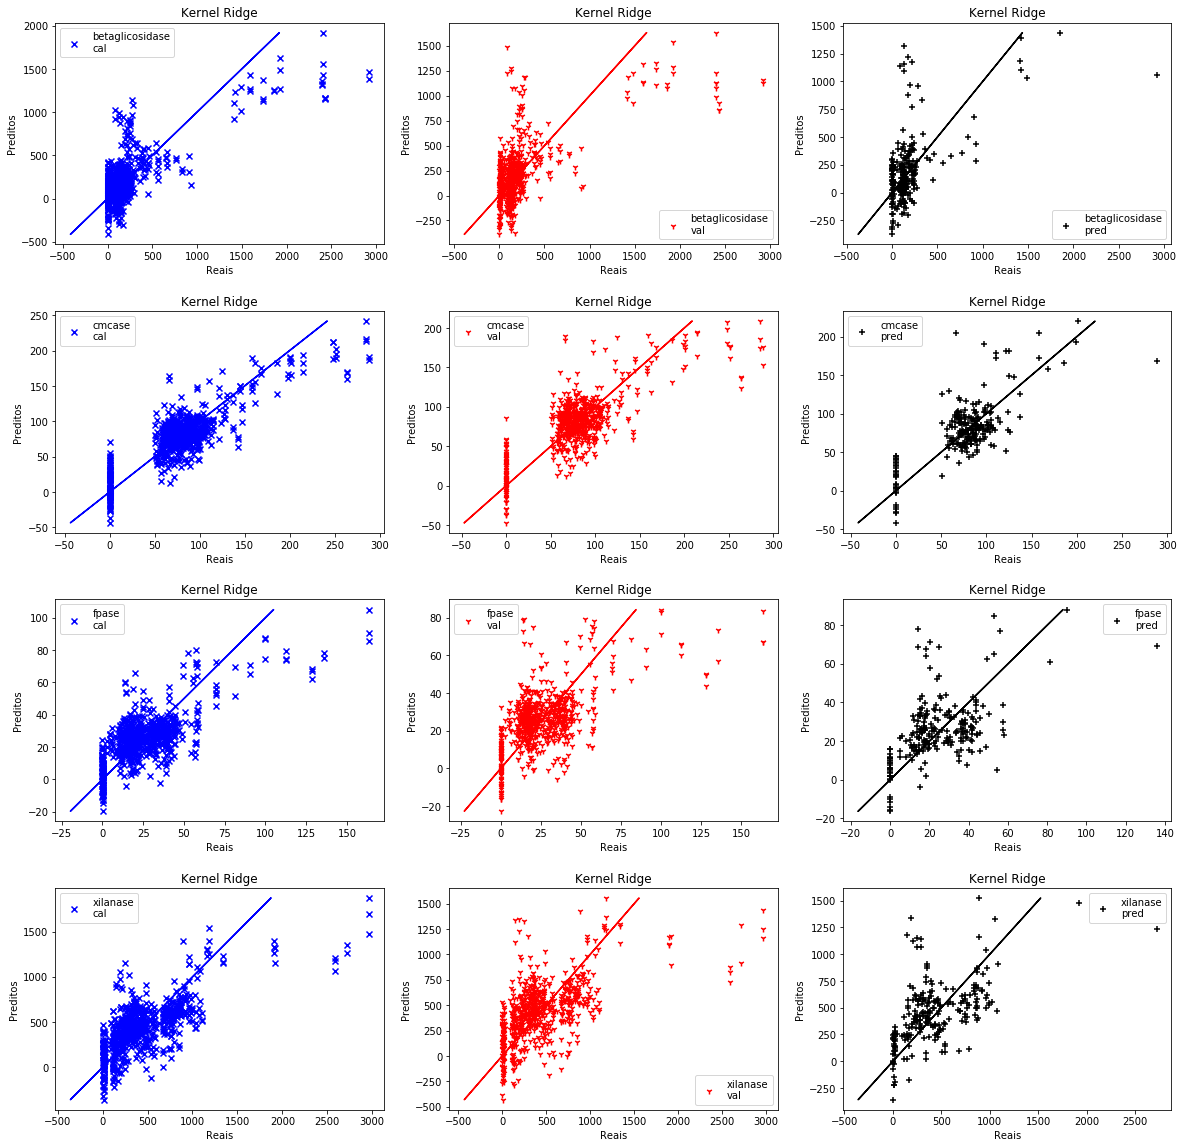

In [367]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

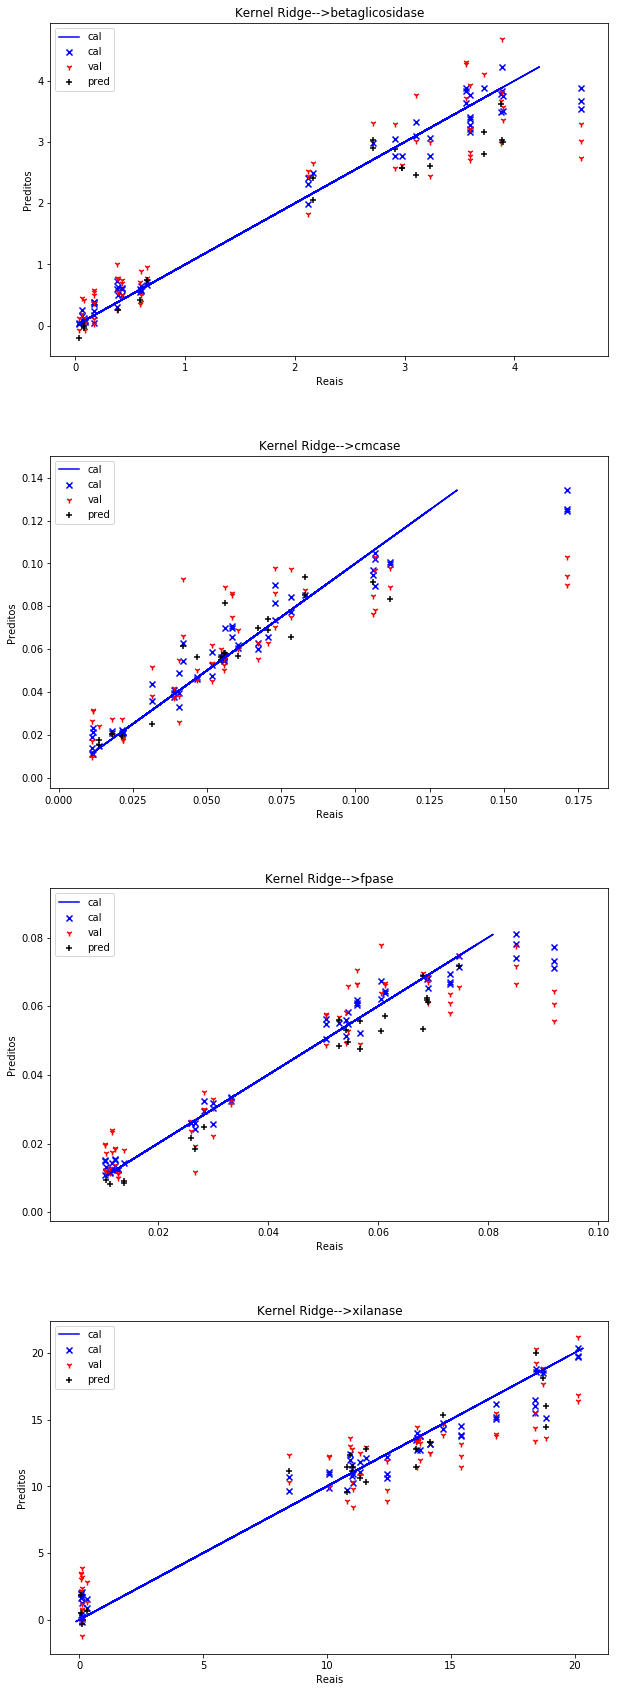

In [459]:
#graico de reais x preditos
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### Kernel Ridge: Gráficos: dados de treino

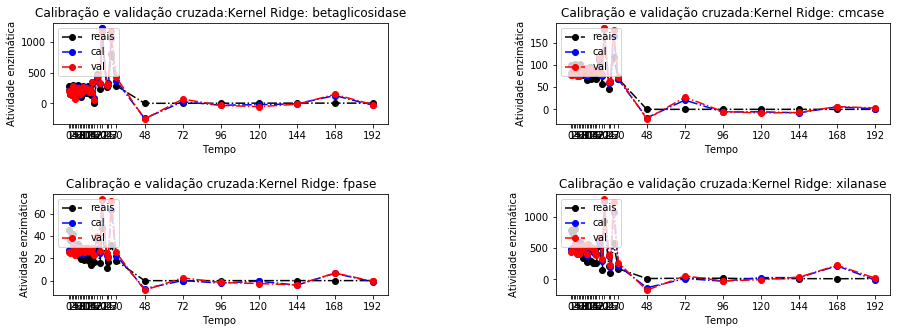

In [368]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### Kernel  Ridge: Gráficos de  teste

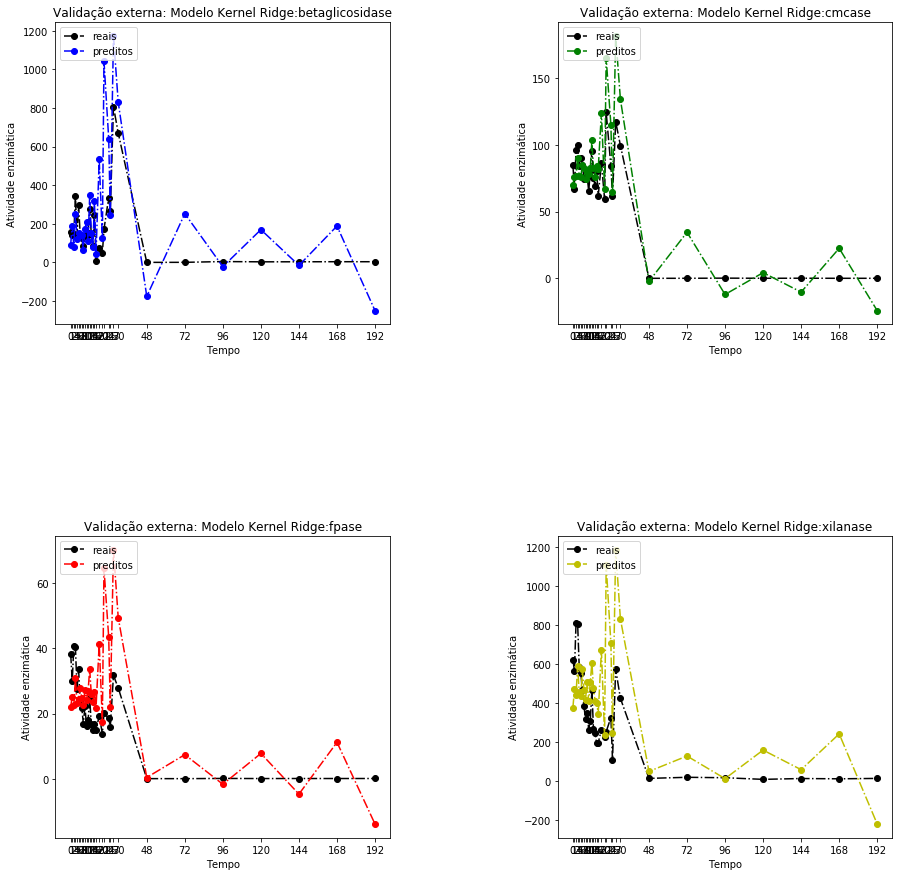

In [369]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

## PCR: 

### PCR: função completa

In [370]:
#pcr função completa para execução do PCR:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaPCR(preproc=0, nPC=3, padroniza=False,IC=0):
    #separando o conjunto de dados em treino e teste
    
    #separando o conjunto de dados em treino e teste
    #x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,True)
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,padroniza, IC)

    
    # Roda o PCA e produz uma vaiável reduzida  e seleciona as primeiras componentes definidas pela variável nPc
    pca = PCA(n_components=nPC)
    x_treino = pca.fit_transform(x_treino)[:,:nPC]
    x_teste = pca.fit_transform(x_teste)[:,:nPC]    
    
    #Passo 2: Aplicar a regressão sobre as componentes selecionadas
    reg = MultiOutputRegressor(LinearRegression())
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

### PCR: testes

In [372]:
#pcr teste diversificado
modelo = 'PCR'
for npc in range(2,5):
    for k in [1,2,10,11]:
        print('\nNº Componentes principais:',npc,'\n',preProc[k])
        result = executaPCR(k,npc)
        print('Parâmetros do modelo:',modelo,'\n',result[0])
        resultados=exibeResultados(result)

        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')


Nº Componentes principais: 2 
 Pré-proc: 1--> Padronização
Parâmetros do modelo: PCR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.0000     0.0000   -0.0000       0.0000
MSE       122188.3769  1651.2895  402.4242  151599.7292
R2             0.1514     0.1734    0.0808       0.0306
RER            8.3432     7.0808    8.1355       7.5994
RMSE         349.5545    40.6361   20.0605     389.3581
RPD            1.0856     1.0999    1.0430       1.0157
RPIQ           0.4412     0.7241    1.0616       1.0608
SEP          349.8115    40.6659   20.0753     389.6443 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.1742    -0.0409   -0.0310      -0.7321
MSE       122853.1350  1662.7067  406.5258  153272.7271
R2             0.1468     0.1677

cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.0000     0.0000   -0.0000       0.0000
MSE       116307.6929  1418.9692  378.6285  127999.9621
R2             0.1923     0.2897    0.1351       0.1815
RER            8.5515     7.6385    8.3873       8.2704
RMSE         341.0391    37.6692   19.4584     357.7708
RPD            1.1127     1.1865    1.0753       1.1053
RPIQ           0.4522     0.7811    1.0945       1.1545
SEP          341.2898    37.6969   19.4727     358.0338 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.3725    -0.0012   -0.0050      -0.2625
MSE       117742.2073  1435.2637  383.6116  129855.6895
R2             0.1823     0.2815    0.1237       0.1696
RER            8.4992     7.5950    8.3326       8.2111
RMSE         343.1358    37.8849   19.5860     360.3549
RPD            1.1059     1.1798    1.0683       1.0974
RPIQ           0.4495     0.7766    1.087

Parâmetros do modelo: PCR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -0.0000     0.0000   -0.0000       0.0000
MSE       112913.7118  1387.7378  371.3954  125630.0537
R2             0.2158     0.3053    0.1516       0.1967
RER            8.6791     7.7240    8.4686       8.3480
RMSE         336.0264    37.2524   19.2716     354.4433
RPD            1.1293     1.1998    1.0857       1.1157
RPIQ           0.4590     0.7898    1.1051       1.1653
SEP          336.2733    37.2797   19.2858     354.7038 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.1357    -0.0160   -0.0231      -0.5377
MSE       114628.4833  1410.9736  378.5182  128245.1042
R2             0.2039     0.2937    0.1354       0.1799
RER            8.6139     7.6601    

In [375]:
#pcr teste simples
modelo = 'PCR'
result = executaPCR(preproc=10,nPC=3)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
    
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: PCR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
cal
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.0000     0.0000   -0.0000       0.0000
MSE       113921.2552  1535.5408  395.3007  137240.6352
R2             0.2088     0.2313    0.0970       0.1224
RER            8.6406     7.3429    8.2085       7.9871
RMSE         337.5222    39.1860   19.8822     370.4600
RPD            1.1243     1.1406    1.0524       1.0675
RPIQ           0.4569     0.7509    1.0712       1.1149
SEP          337.7703    39.2148   19.8968     370.7323 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.1124    -0.0236   -0.0319      -0.6438
MSE       115409.7296  1553.2779  401.2528  139482.5152
R2             0.1985     0.2225    0.0834       0.1081
RER            8.5847     7.3008    

In [376]:
#pcr otimizando
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaPCR(preproc=10, nPC=4, IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['val'].loc[resultados['val'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.228, 0.3473, 0.1758, 0.2281] 
semente: b c f x [41, 60, 60, 60]


In [408]:
#PCr teste otimizado
modelo = 'PCR:'
result = result = executaPCR(preproc=1,nPC=4,IC=24)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: PCR: 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)


In [409]:
resultados['cal']

betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0000  0.0000  0.0000    0.0000
MSE            0.1920  0.0003  0.0001   16.3422
R2             0.9189  0.5715  0.8987    0.6021
RER            8.7551  5.4434  9.6236    4.9217
RMSE           0.4382  0.0183  0.0077    4.0426
RPD            3.5123  1.5277  3.1412    1.5853
RPIQ           7.2533  2.1218  6.3989    1.5347
SEP            0.4419  0.0185  0.0077    4.0767

In [410]:
resultados['val']

betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0159  0.0002 -0.0000   -0.0163
MSE            0.2300  0.0004  0.0001   19.3822
R2             0.9029  0.5136  0.8804    0.5281
RER            8.0039  5.1093  8.8571    4.5193
RMSE           0.4796  0.0195  0.0083    4.4025
RPD            3.2091  1.4338  2.8910    1.4557
RPIQ           6.6273  1.9914  5.8891    1.4092
SEP            0.4833  0.0197  0.0084    4.4396

In [411]:
resultados['pred']

betaglicosidase  cmcase   fpase  xilanase
BIAS           0.2201  0.0172  0.0038    1.4274
MSE            1.3604  0.0018  0.0002   30.4087
R2             0.5382  0.2525  0.6844    0.2866
RER            3.8752  4.0015  5.1953    3.6725
RMSE           1.1664  0.0427  0.0158    5.5144
RPD            1.4715  1.1566  1.7802    1.1839
RPIQ           2.8587  1.0300  2.6712    1.2175
SEP            1.1737  0.0400  0.0157    5.4580

In [390]:
reg, treino_teste,y_c,y_cv,y_p = result

###  Reais x preditos

In [391]:
#ridge reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.5967  0.1065  0.0850   13.6476                 3.9144   
1            0.4280  0.0390  0.0334   13.7624                 0.6673   
2            0.0759  0.0136  0.0139    0.0726                 0.2257   
3            3.8876  0.0418  0.0605   11.0267                 3.8933   
4            0.6010  0.0559  0.0116   20.1368                 0.5951   
5            3.1068  0.0781  0.0545   11.0526                 2.7369   
6            2.1150  0.0730  0.0505   18.4127                 1.7882   
7            2.1643  0.0830  0.0529   18.8324                 1.7528   
8            2.9774  0.0704  0.0567   10.8002                 2.9361   
9            3.8803  0.0557  0.0691   11.3256                 3.1934   
10           3.5974  0.0516  0.0731   15.3973                 2.6009   
11           0.3900  0.0315  0.0283   14.1777                 0.9024   
12           0.6010  0.0559  0.0116   20.1368                 0.5468   
13           0.0874  0.0217  0.0127    0.1071                 0.1108   
14           0.3900  0.0315  0.0283   14.1777                 0.8960   
15           2.9774  0.0704  0.0567   10.8002                 2.6872   
16           2.9774  0.0704  0.0567   10.8002                 3.0056   
17           0.3828  0.0405  0.0301   12.4461                 0.7124   
18           0.0308  0.0213  0.0113    0.0996                -0.0610   
19           3.7243  0.0561  0.0681   11.5736                 3.6104   
20           2.1643  0.0830  0.0529   18.8324                 1.8977   
21           3.2342  0.0672  0.0543    8.4772                 2.5644   
22           2.9123  0.1058  0.0747   14.6813                 3.6457   
23           3.8803  0.0557  0.0691   11.3256                 3.3255   
24           3.5974  0.0516  0.0731   15.3973                 2.4499   
25           3.2342  0.0672  0.0543    8.4772                 2.7236   
26           3.5967  0.1065  0.0850   13.6476                 4.0044   
27           0.6491  0.0605  0.0260   18.4274                 0.7946   
28           3.8876  0.0418  0.0605   11.0267                 4.1390   
29           3.8876  0.0418  0.0605   11.0267                 3.8556   
30           0.0554  0.0181  0.0106    0.3275                 0.3115   
31           3.7243  0.0561  0.0681   11.5736                 3.7439   
32           3.1068  0.0781  0.0545   11.0526                 2.8587   
33           3.8994  0.1118  0.0613   10.9512                 3.4454   
34           3.5610  0.0586  0.0561   10.0978                 4.0652   
35           3.1068  0.0781  0.0545   11.0526                 2.6236   
36           2.9123  0.1058  0.0747   14.6813                 3.7953   
37           2.7110  0.0548  0.0688   13.5829                 3.1525   
38           3.5974  0.0516  0.0731   15.3973                 2.4601   
39           0.0759  0.0136  0.0139    0.0726                -0.0427   
40           3.8994  0.1118  0.0613   10.9512                 3.6364   
41           2.9123  0.1058  0.0747   14.6813                 3.6092   
42           2.7110  0.0548  0.0688   13.5829                 3.2801   
43           0.5905  0.0465  0.0267   18.7095                 0.4155   
44           0.1671  0.0117  0.0104    0.1117                 0.4406   
45           0.0874  0.0217  0.0127    0.1071                 0.0899   
46           0.6491  0.0605  0.0260   18.4274                 0.7626   
47           0.5905  0.0465  0.0267   18.7095                 0.7045   
48           0.4280  0.0390  0.0334   13.7624                 0.4906   
49           0.0759  0.0136  0.0139    0.0726                 0.0485   
50           0.3828  0.0405  0.0301   12.4461                 1.1024   
51           0.1724  0.0112  0.0121    0.0924                 0.2232   
52           0.0554  0.0181  0.0106    0.3275                 0.4861   
53           0.0308  0.0213  0.0113    0.0996                 0.1084   
54           0.0874  0.0217  0.0127    0.107

In [392]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.5967  0.1065  0.0850   13.6476                 3.9194   
1            0.4280  0.0390  0.0334   13.7624                 0.6755   
2            0.0759  0.0136  0.0139    0.0726                 0.2414   
3            3.8876  0.0418  0.0605   11.0267                 3.8973   
4            0.6010  0.0559  0.0116   20.1368                 0.5957   
5            3.1068  0.0781  0.0545   11.0526                 2.7439   
6            2.1150  0.0730  0.0505   18.4127                 1.8063   
7            2.1643  0.0830  0.0529   18.8324                 1.7314   
8            2.9774  0.0704  0.0567   10.8002                 2.9511   
9            3.8803  0.0557  0.0691   11.3256                 3.0660   
10           3.5974  0.0516  0.0731   15.3973                 2.4312   
11           0.3900  0.0315  0.0283   14.1777                 0.8987   
12           0.6010  0.0559  0.0116   20.1368                 0.5243   
13           0.0874  0.0217  0.0127    0.1071                 0.1201   
14           0.3900  0.0315  0.0283   14.1777                 0.9519   
15           2.9774  0.0704  0.0567   10.8002                 2.6929   
16           2.9774  0.0704  0.0567   10.8002                 2.9973   
17           0.3828  0.0405  0.0301   12.4461                 0.7767   
18           0.0308  0.0213  0.0113    0.0996                -0.1248   
19           3.7243  0.0561  0.0681   11.5736                 3.5535   
20           2.1643  0.0830  0.0529   18.8324                 1.8317   
21           3.2342  0.0672  0.0543    8.4772                 2.4899   
22           2.9123  0.1058  0.0747   14.6813                 3.7339   
23           3.8803  0.0557  0.0691   11.3256                 3.3671   
24           3.5974  0.0516  0.0731   15.3973                 2.3456   
25           3.2342  0.0672  0.0543    8.4772                 2.7577   
26           3.5967  0.1065  0.0850   13.6476                 4.0194   
27           0.6491  0.0605  0.0260   18.4274                 0.8096   
28           3.8876  0.0418  0.0605   11.0267                 4.1690   
29           3.8876  0.0418  0.0605   11.0267                 3.8889   
30           0.0554  0.0181  0.0106    0.3275                 0.3196   
31           3.7243  0.0561  0.0681   11.5736                 3.7234   
32           3.1068  0.0781  0.0545   11.0526                 2.8362   
33           3.8994  0.1118  0.0613   10.9512                 3.4188   
34           3.5610  0.0586  0.0561   10.0978                 4.0346   
35           3.1068  0.0781  0.0545   11.0526                 2.6053   
36           2.9123  0.1058  0.0747   14.6813                 3.9839   
37           2.7110  0.0548  0.0688   13.5829                 3.2878   
38           3.5974  0.0516  0.0731   15.3973                 2.5795   
39           0.0759  0.0136  0.0139    0.0726                -0.0494   
40           3.8994  0.1118  0.0613   10.9512                 3.6722   
41           2.9123  0.1058  0.0747   14.6813                 3.7832   
42           2.7110  0.0548  0.0688   13.5829                 3.3226   
43           0.5905  0.0465  0.0267   18.7095                 0.4357   
44           0.1671  0.0117  0.0104    0.1117                 0.4732   
45           0.0874  0.0217  0.0127    0.1071                 0.0911   
46           0.6491  0.0605  0.0260   18.4274                 0.7839   
47           0.5905  0.0465  0.0267   18.7095                 0.7144   
48           0.4280  0.0390  0.0334   13.7624                 0.6243   
49           0.0759  0.0136  0.0139    0.0726                 0.0659   
50           0.3828  0.0405  0.0301   12.4461                 1.2022   
51           0.1724  0.0112  0.0121    0.0924                 0.3661   
52           0.0554  0.0181  0.0106    0.3275                 0.6180   
53           0.0308  0.0213  0.0113    0.0996                 0.1181   
54           0.0874  0.0217  0.0127    0.107

In [393]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            2.1643  0.0830  0.0529   18.8324                 2.8688   
1            3.5610  0.0586  0.0561   10.0978                 2.7516   
2            0.1671  0.0117  0.0104    0.1117                 0.5042   
3            3.8994  0.1118  0.0613   10.9512                 3.0944   
4            4.6037  0.1713  0.0919   16.8115                 3.9320   
5            0.4280  0.0390  0.0334   13.7624                 0.9046   
6            0.3900  0.0315  0.0283   14.1777                 1.6797   
7            3.5967  0.1065  0.0850   13.6476                 3.4253   
8            0.6010  0.0559  0.0116   20.1368                -1.4185   
9            0.1671  0.0117  0.0104    0.1117                 0.9426   
10           3.8803  0.0557  0.0691   11.3256                 3.4190   
11           0.6491  0.0605  0.0260   18.4274                -0.5173   
12           2.1150  0.0730  0.0505   18.4127                 2.1520   
13           3.7243  0.0561  0.0681   11.5736                 1.4824   
14           0.1724  0.0112  0.0121    0.0924                 0.5743   
15           4.6037  0.1713  0.0919   16.8115                 3.4638   
16           3.2342  0.0672  0.0543    8.4772                 1.4197   
17           0.3828  0.0405  0.0301   12.4461                 2.3244   
18           4.6037  0.1713  0.0919   16.8115                 3.4534   
19           2.1150  0.0730  0.0505   18.4127                 2.2057   
20           0.0554  0.0181  0.0106    0.3275                 1.8299   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0620       0.0627         11.2042  
1         0.0678       0.0493         13.6731  
2         0.0290       0.0224          6.0890  
3         0.0716       0.0587         14.5006  
4         0.0815       0.0726         12.4542  
5         0.0343       0.0294          7.1377  
6         0.0465       0.0388          7.8813  
7         0.0762       0.0654         14.8739  
8         0.0185      -0.0028         11.1867  
9         0.0377       0.0238          5.5414  
10        0.0803       0.0565         13.3037  
11        0.0355       0.0046         12.0289  
12        0.0496       0.0578         11.4825  
13        0.0489       0.0384         14.7737  
14        0.0312       0.0213          5.1490  
15        0.0718       0.0699         12.0975  
16        0.0440       0.0408         12.6059  
17        0.0573       0.0448          7.1027  
18        0.0715       0.0698         11.8626  
19        0.0509       0.0569         11.0232  
20        0.0513       0.0352          5.8110

###  PCR: Gráficos de resíduos - histograma - reais x preditos

In [412]:
#título para os gráficos
modelo = 'PCR'

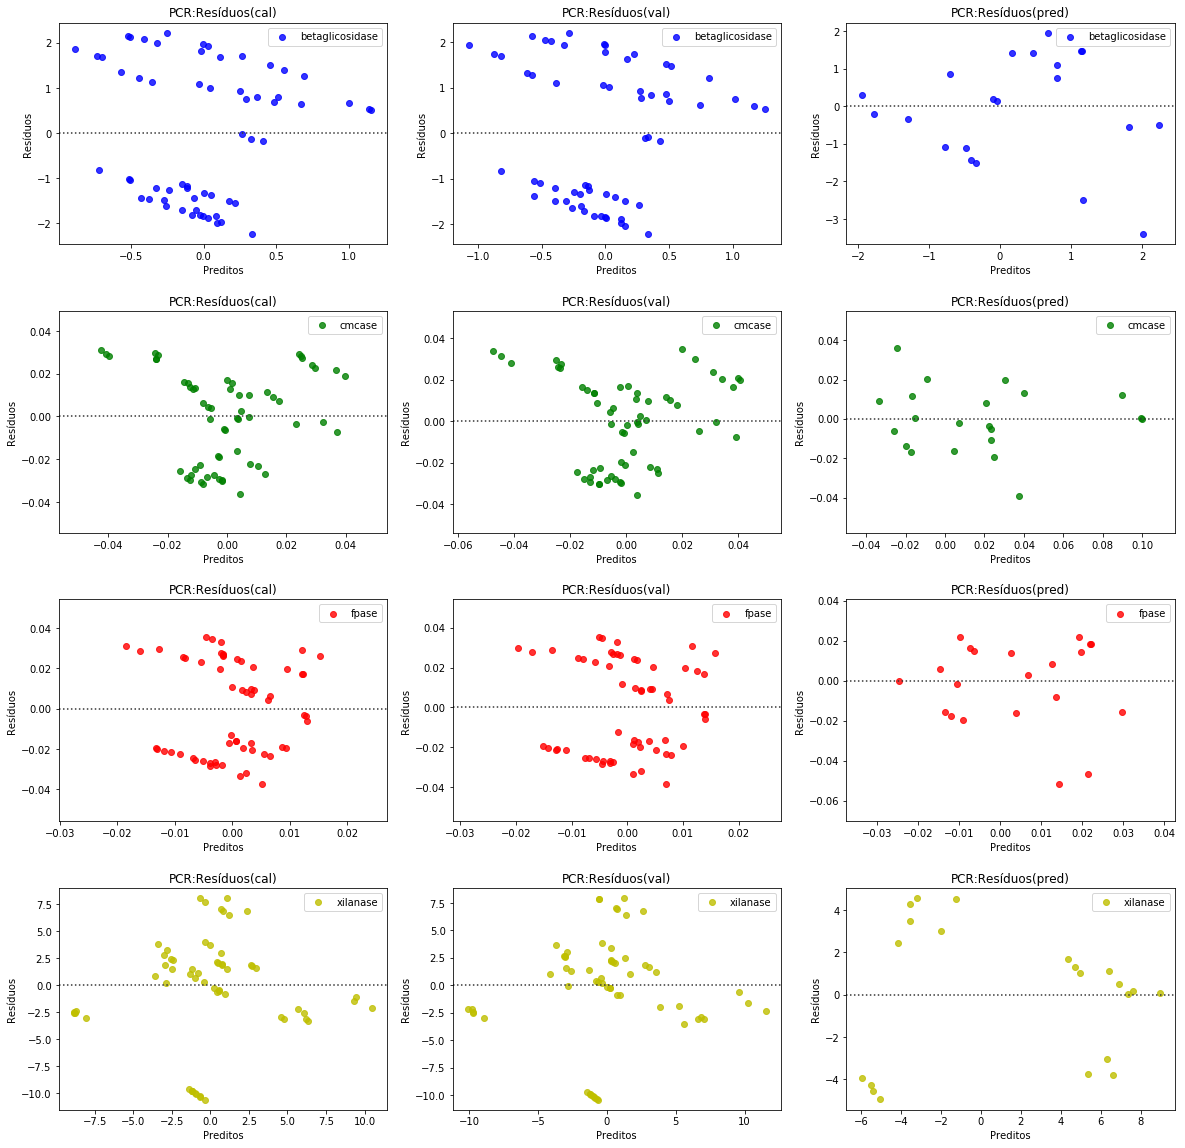

In [395]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

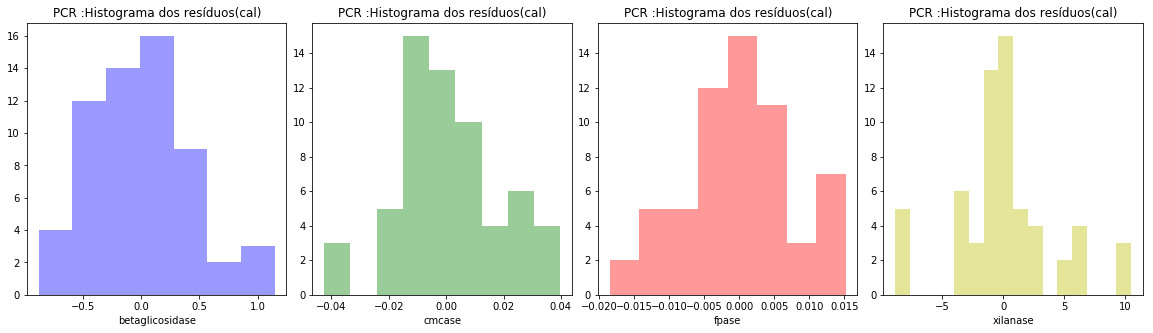

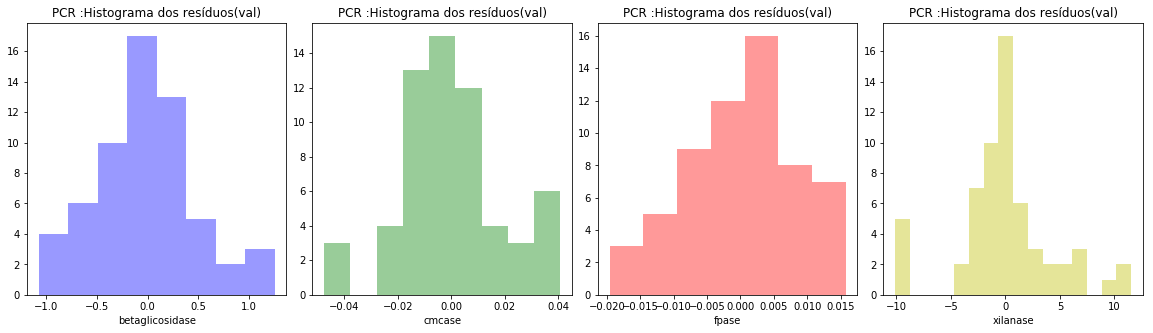

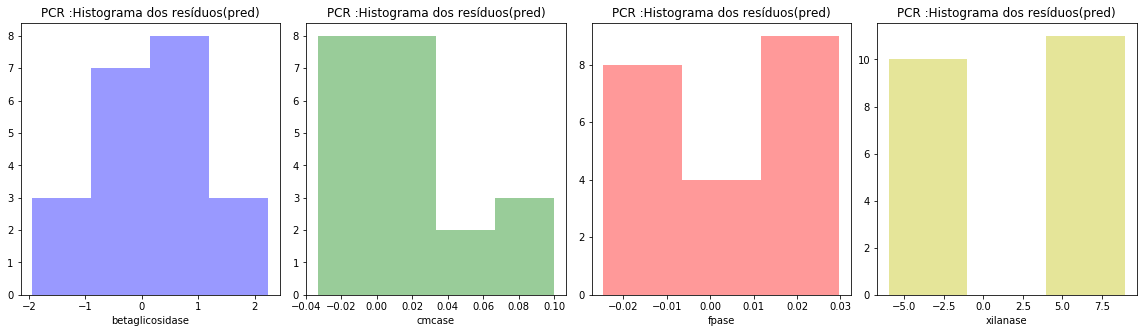

In [396]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

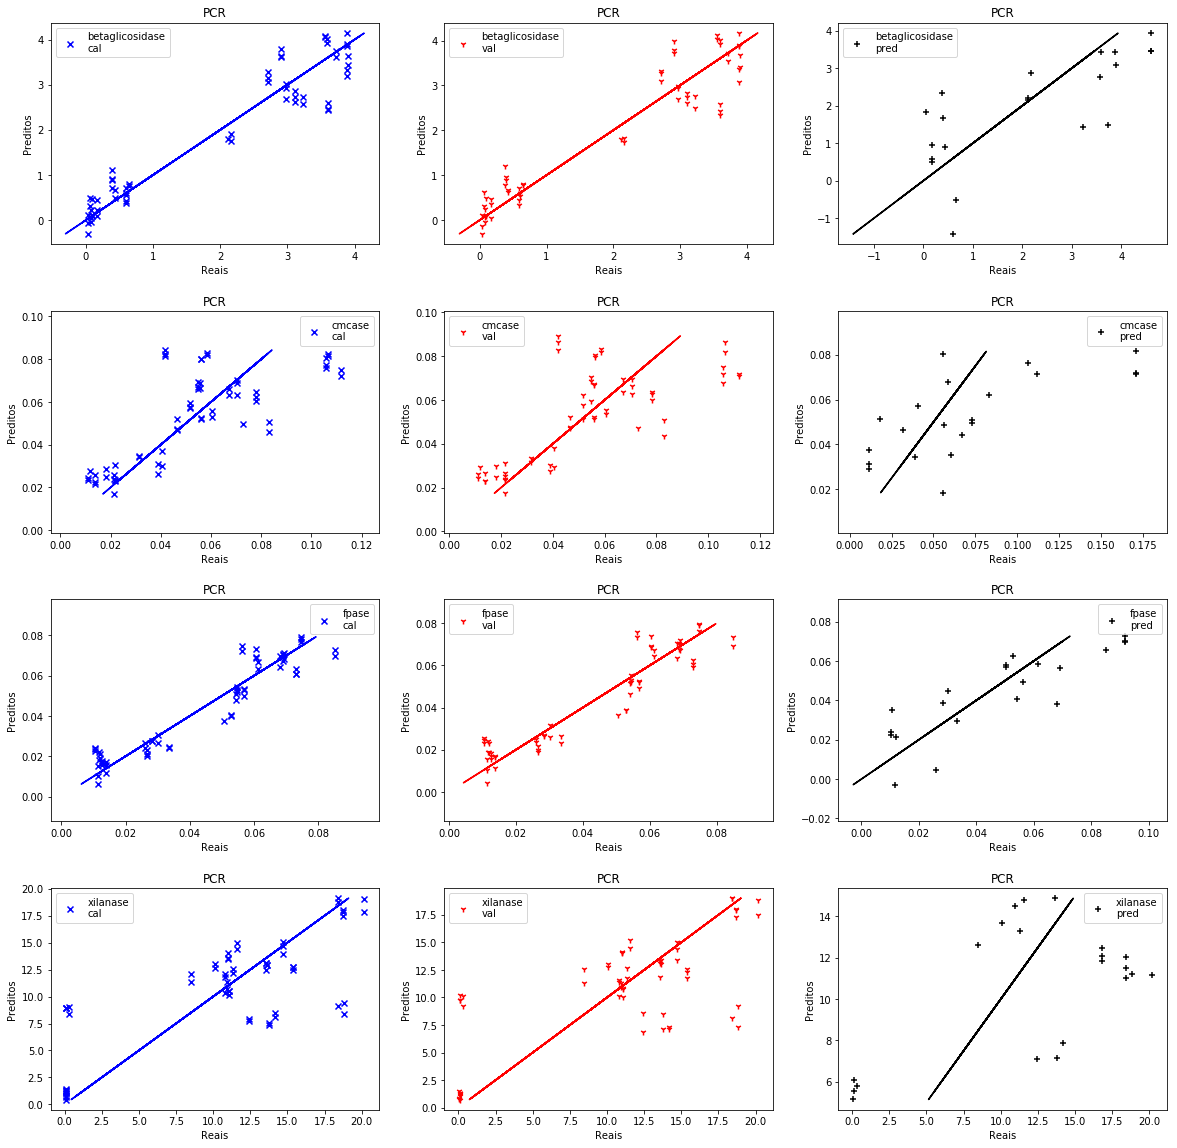

In [397]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

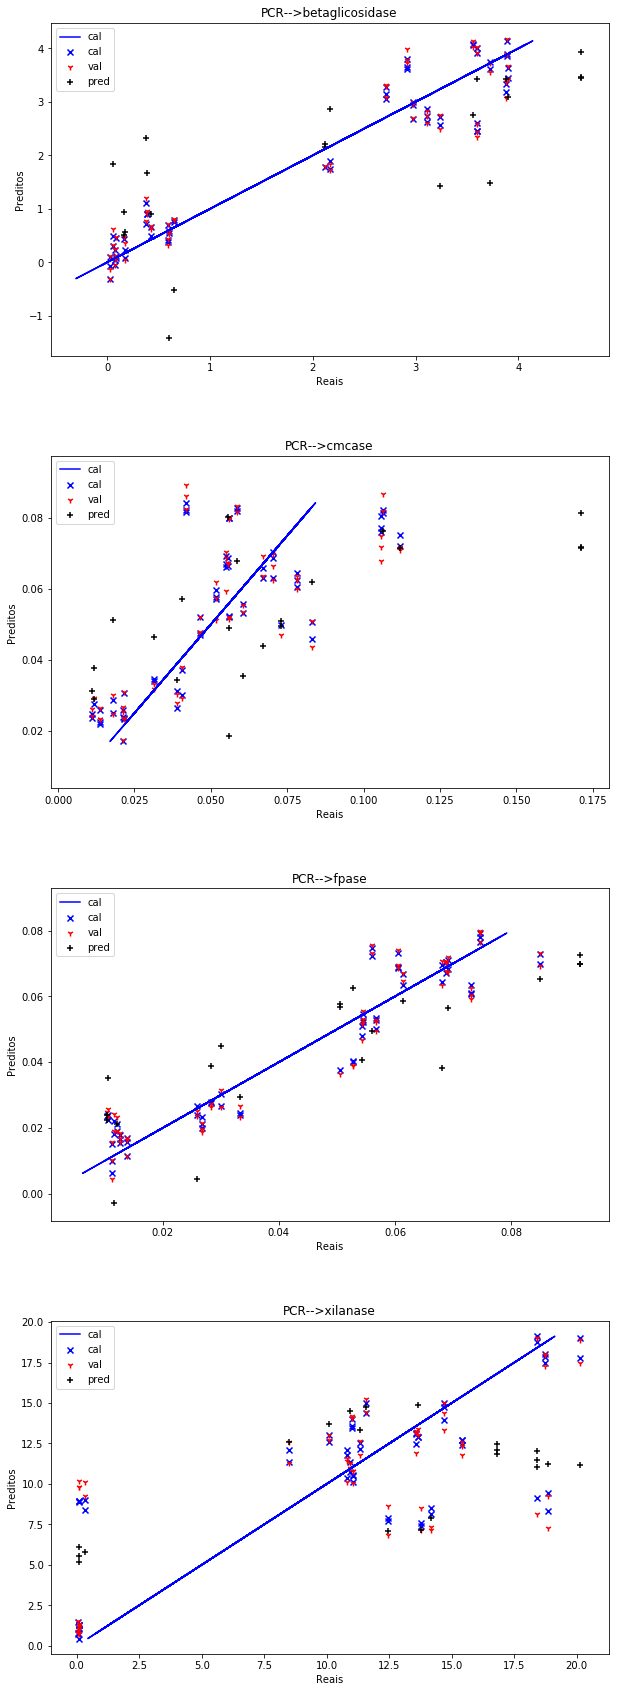

In [398]:
#graico de reais x preditos
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

## Kernel PCA: 

### Kernel PCA: função completa

In [378]:
#kernelpca
#função completa para execução do Kernel PCA:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaKPCA(preproc=1, nPC=3, tk='linear', ic=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False,ic)

    
    # Define um objeto Kernel PCA
    kpca = KernelPCA(n_components=nPC, kernel =tk)
       
    x_treino = kpca.fit_transform(x_treino)[:,:nPC]
    x_teste = kpca.fit_transform(x_teste)[:,:nPC]    
    
    #Passo 2: Aplicar a regressão sobre as componentes selecionadas

    # Cria um objeto de regressão linear
    reg = LinearRegression()

    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

###  Kernel PCA: testes

In [379]:
list(np.arange(1,10))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [380]:
#kernelpca otimização parte 1
varKernel = ['linear','poly','rbf','sigmoid','cosine', 'precomputed']
for pre, valor in zip(preProc.keys(), preProc.values()):
    maior=[-100,-100,-100,-100]
    #maiorGerado=[0,0,0,0]
    componentes=[0,0,0,0]
    tipokernel=['0','0','0','0']
    print(valor)
    for cp, k in zip(list(np.arange(2,7)),varKernel):
        result = executaKPCA(pre,cp,k)
        resultados=exibeResultados(result)
        r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
        r = []
        for j in range(4):
            r.append(r2.iloc[:,j][0])
            if r[j]>maior[j]:
                maior[j] = r[j]
                componentes[j]=cp
                tipokernel[j]=k
        print('\r%d%% completos'%(i+1), end='')
    print('\n','r2 ( b c f x ):',maior,'\ncomponentes:',componentes,'\nKernel:',tipokernel)
    print('------------------------')

Pré-proc: 0--> Sem pré-processamento
100% completos
 r2 ( b c f x ): [0.1151, 0.1889, 0.143, 0.1691] 
componentes: [3, 4, 4, 4] 
Kernel: ['poly', 'rbf', 'rbf', 'rbf']
------------------------
Pré-proc: 1--> Padronização
100% completos
 r2 ( b c f x ): [0.1225, 0.1832, 0.1044, 0.0349] 
componentes: [4, 2, 2, 2] 
Kernel: ['rbf', 'linear', 'linear', 'linear']
------------------------
Pré-proc: 2--> Suavização(SavGol) - Par:3,1,1
100% completos
 r2 ( b c f x ): [0.2145, -0.1034, 0.0195, -0.0007] 
componentes: [6, 6, 6, 4] 
Kernel: ['cosine', 'cosine', 'cosine', 'rbf']
------------------------
Pré-proc: 3--> Suavização(SavGol) - Par:3,2,1
100% completos
 r2 ( b c f x ): [0.1687, 0.2655, 0.1316, 0.1522] 
componentes: [3, 6, 6, 5] 
Kernel: ['poly', 'cosine', 'cosine', 'sigmoid']
------------------------
Pré-proc: 4--> Suavização(SavGol) - Par:5,1,1
100% completos
 r2 ( b c f x ): [0.163, 0.2923, 0.1684, 0.1779] 
componentes: [3, 3, 3, 3] 
Kernel: ['poly', 'poly', 'poly', 'poly']
-------------

In [381]:
#kernelpca otimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
componentes=[0,0,0,0]
tipokernel=[0,0,0,0]
for i in range(100):
    result = executaKPCA(8,6,'cosine',ic=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.1616, 0.1512, 0.065, 0.0973] 
semente: b c f x [21, 34, 94, 92]


## MLR: função completa

In [382]:
#mlr
#função completa para execução do MLR:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3)
def executaMLR(preproc=1, param=False,IC=0):
    
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,param, IC)
        
      
    # Cria um objeto de regressão linear
    reg = MultiOutputRegressor(LinearRegression())
    #reg = LinearRegression()


    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result


### MLR: testes

In [383]:
#mlr teste variando o tipo de préprocessamento
modelo = 'MLR'
for k in range(12):
    
    result = executaMLR(k)
    print('Parâmetros do modelo:',modelo,'\n',result[0])
    print(preProc[k])

    resultados=exibeResultados(result)
    
    for k,v in zip(resultados.keys(),resultados.values()):
        print(k)
        print(v,'\n-----------------------------------------------------')

 

Parâmetros do modelo: MLR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
Pré-proc: 0--> Sem pré-processamento
cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS           0.0000    0.0000   0.0000      0.0000
MSE        19358.8536  196.0620  92.7952  33753.6994
R2             0.8656    0.9019   0.7880      0.7842
RER           20.9607   20.5494  16.9420     16.1053
RMSE         139.1361   14.0022   9.6330    183.7218
RPD            2.7273    3.1920   2.1720      2.1525
RPIQ           1.1085    2.1013   2.2109      2.2481
SEP          139.2384   14.0125   9.6401    183.8568 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.0033    -0.4453   -0.1785      -6.5058
MSE       122776.9167  1119.7873  530.8182  197688.1479
R2             0.1473     0.4395   -0.2125      -0.2641
RER            8.3232     

Parâmetros do modelo: MLR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
Pré-proc: 5--> Suavização(SavGol) - Par:5,2,1
cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS           0.0604   -0.0032  -0.0067     -0.0979
MSE        19515.7473  196.1347  92.9191  33807.1233
R2             0.8645    0.9018   0.7877      0.7838
RER           20.8763   20.5456  16.9307     16.0926
RMSE         139.6988   14.0048   9.6395    183.8671
RPD            2.7163    3.1914   2.1706      2.1508
RPIQ           1.1040    2.1009   2.2094      2.2463
SEP          139.8014   14.0151   9.6465    184.0023 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS          -1.5218    -0.4172   -0.1261      -6.1122
MSE       123207.4105  1097.4988  517.5768  192707.8378
R2             0.1444     0.4506   -0.1823      -0.2323
RER            8.

Parâmetros do modelo: MLR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
Pré-proc: 10--> MSC
cal
      betaglicosidase    cmcase    fpase    xilanase
BIAS          -3.3070   -0.1364   0.3300      1.3961
MSE        19342.4024  193.0481  92.2256  33418.8939
R2             0.8657    0.9034   0.7893      0.7863
RER           20.9756   20.7102  17.0043     16.1863
RMSE         139.0770   13.8942   9.6034    182.8084
RPD            2.7285    3.2169   2.1787      2.1632
RPIQ           1.1089    2.1176   2.2177      2.2594
SEP          139.1398   13.9037   9.6048    182.9374 
-----------------------------------------------------
val
      betaglicosidase     cmcase     fpase     xilanase
BIAS           0.0693    -0.3499   -0.0943      -7.6803
MSE       125697.8381  1099.2281  522.2959  195023.9874
R2             0.1271     0.4498   -0.1931      -0.2471
RER            8.2259     8.6791    7.1412 

In [384]:
#MLR otimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaMLR(preproc=10,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [-1, -1, -1, -1] 
semente: b c f x [0, 0, 0, 0]


In [389]:
#MLR teste otimizado
modelo = 'MLR:'
result = executaMLR(preproc=1,IC=0)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: MLR: 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)


In [390]:
resultados['cal']

betaglicosidase    cmcase    fpase    xilanase
BIAS          -0.0000   -0.0000   0.0000      0.0000
MSE        19358.8536  196.0620  92.7952  33753.6994
R2             0.8656    0.9019   0.7880      0.7842
RER           20.9607   20.5494  16.9420     16.1053
RMSE         139.1361   14.0022   9.6330    183.7218
RPD            2.7273    3.1920   2.1720      2.1525
RPIQ           1.1085    2.1013   2.2109      2.2481
SEP          139.2384   14.0125   9.6401    183.8568

In [391]:
resultados['val']

betaglicosidase     cmcase     fpase     xilanase
BIAS           0.0033    -0.4453   -0.1785      -6.5058
MSE       122776.9167  1119.7873  530.8182  197688.1478
R2             0.1473     0.4395   -0.2125      -0.2641
RER            8.3232     8.5994    7.0838       6.6556
RMSE         350.3954    33.4632   23.0395     444.6214
RPD            1.0830     1.3357    0.9081       0.8894
RPIQ           0.4402     0.8793    0.9244       0.9289
SEP          350.6529    33.4849   23.0557     444.9005

In [392]:
resultados['pred']

betaglicosidase     cmcase     fpase     xilanase
BIAS         -22.5137    -2.9242   -0.0274       7.0957
MSE       185030.3388  1420.2802  564.8551  215894.4434
R2            -0.3088     0.2756   -0.3537      -0.3547
RER            6.7792     7.6468    5.6962       5.8412
RMSE         430.1515    37.6866   23.7667     464.6444
RPD            0.8741     1.1749    0.8595       0.8592
RPIQ           0.3278     0.6101    0.9355       1.1341
SEP          430.5113    37.6560   23.8192     465.6170

In [393]:
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [394]:
#pls reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0           250.8100   77.3295   14.7702   258.2026               386.7154   
1           160.2180   89.6150   20.7960   359.4880                67.2716   
2            46.3527   65.4908   14.4415   370.6471              -254.1495   
3           299.9215   60.1578   20.9152   119.5415               381.8321   
4             0.5905    0.0465    0.0267    18.7095              -181.5797   
5             0.1671    0.0117    0.0104     0.1117              -345.8515   
6           834.4946   61.9396   29.1738   235.8352               570.3480   
7            84.0149   72.7848   22.2422   312.6571               105.2261   
8           143.3068  109.3426   33.5792   863.4196                56.1906   
9           225.4068  103.6390   29.3921   387.2623               345.8900   
10         1927.2679  248.3290   99.8630  1183.7889              1658.3132   
11          262.2230   92.4294   32.9734   688.6235               239.4192   
12          174.3269   88.8776   41.5095   483.9741                99.4245   
13          540.5795   61.7416   21.3253   151.4961               539.9591   
14          174.3269   88.8776   41.5095   483.9741               126.9371   
15         2397.5010  251.6900  112.6160  1901.4399              2304.5923   
16          241.6059  104.7929   36.2992   851.6944               280.0549   
17          154.8522   79.5483   19.7968   218.6271               122.3727   
18          282.1037   90.7727   22.5180   465.5131               350.2696   
19           45.7291   76.4016   12.0086   209.4032               286.1866   
20          201.1082   98.0342   28.7162   587.8371               119.6948   
21          141.3745   64.6455   18.7057   303.7711                23.4899   
22           84.2733   77.4659   11.0090   115.7702                 6.6266   
23          121.8905   80.5562   14.8344   367.7344               180.7738   
24         1423.0380  158.6290   52.7020   890.4560              1373.7309   
25          380.0074   79.7861   40.9537   410.5377               466.0125   
26          237.1880  105.6089   42.4315   916.3074               128.6755   
27          559.8001   89.9679   21.5516   138.4000               599.8744   
28           75.8015   57.7596   13.1040   358.1227               199.2315   
29          112.1323   67.4617   13.0204   261.7252                98.8173   
..               ...       ...       ...        ...                    ...   
651         242.2597   57.6123   17.9879   129.2327               178.6337   
652         219.7570  122.1420   24.7890   208.2630               394.7103   
653           7.6554   61.8889   14.9137   196.3804              -246.7945   
654         158.8768  103.2324   39.2466   524.5162               141.8069   
655         170.8830  124.5190   20.0790   252.8500               288.9034   
656         122.1230   96.9230   25.5450   376.6580               128.7723   
657         189.1429  101.0838   20.7583   333.5429               407.6614   
658         227.8442   57.3295   17.2667   120.8511               358.6826   
659         136.2851  112.3726   26.5009   313.8180                11.7126   
660         129.4330  114.8104   37.3938   671.3381                74.2925   
661          74.3874   52.1437   13.4200   120.8112                94.5015   
662         122.4796   73.2081   25.0869   304.7825               308.1656   
663         121.8905   80.5562   14.8344   367.7344               201.6201   
664          41.8395   70.4412   10.0650   170.7917               104.0912   
665          42.5092   60.4743   15.4377   338.4625                 2.0907   
666         274.2940   78.7396   19.7839   142.5907               461.6147   
667          41.8395   70.4412   10.0650   170.7917                49.0131   
668           3.1080    0.0410    0.0590    20.1730                -2.0764   
669           2.1150    0.0730    0.0505    18.4127              -234.9013   
670          90.8381   81.0

In [395]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0           250.8100   77.3295   14.7702   258.2026               462.1939   
1           160.2180   89.6150   20.7960   359.4880                51.1266   
2            46.3527   65.4908   14.4415   370.6471              -250.9506   
3           299.9215   60.1578   20.9152   119.5415               511.9056   
4             0.5905    0.0465    0.0267    18.7095              -843.4948   
5             0.1671    0.0117    0.0104     0.1117              -980.2322   
6           834.4946   61.9396   29.1738   235.8352               135.8329   
7            84.0149   72.7848   22.2422   312.6571               169.0369   
8           143.3068  109.3426   33.5792   863.4196               186.6510   
9           225.4068  103.6390   29.3921   387.2623               414.1881   
10         1927.2679  248.3290   99.8630  1183.7889              1294.2886   
11          262.2230   92.4294   32.9734   688.6235               286.5212   
12          174.3269   88.8776   41.5095   483.9741                -8.2594   
13          540.5795   61.7416   21.3253   151.4961               675.4777   
14          174.3269   88.8776   41.5095   483.9741               -80.6636   
15         2397.5010  251.6900  112.6160  1901.4399              2044.7683   
16          241.6059  104.7929   36.2992   851.6944               223.2223   
17          154.8522   79.5483   19.7968   218.6271               101.9707   
18          282.1037   90.7727   22.5180   465.5131               423.2749   
19           45.7291   76.4016   12.0086   209.4032               467.0237   
20          201.1082   98.0342   28.7162   587.8371               134.2019   
21          141.3745   64.6455   18.7057   303.7711              -132.0084   
22           84.2733   77.4659   11.0090   115.7702               -69.1743   
23          121.8905   80.5562   14.8344   367.7344               198.1554   
24         1423.0380  158.6290   52.7020   890.4560               982.0501   
25          380.0074   79.7861   40.9537   410.5377               510.2677   
26          237.1880  105.6089   42.4315   916.3074                75.3337   
27          559.8001   89.9679   21.5516   138.4000               754.4116   
28           75.8015   57.7596   13.1040   358.1227               186.6125   
29          112.1323   67.4617   13.0204   261.7252                64.9922   
..               ...       ...       ...        ...                    ...   
651         242.2597   57.6123   17.9879   129.2327                30.9263   
652         219.7570  122.1420   24.7890   208.2630               777.3649   
653           7.6554   61.8889   14.9137   196.3804              -615.3850   
654         158.8768  103.2324   39.2466   524.5162               191.5941   
655         170.8830  124.5190   20.0790   252.8500               574.1429   
656         122.1230   96.9230   25.5450   376.6580               133.3137   
657         189.1429  101.0838   20.7583   333.5429               528.2640   
658         227.8442   57.3295   17.2667   120.8511               681.6130   
659         136.2851  112.3726   26.5009   313.8180              -226.1044   
660         129.4330  114.8104   37.3938   671.3381              -170.5844   
661          74.3874   52.1437   13.4200   120.8112               103.3439   
662         122.4796   73.2081   25.0869   304.7825               306.7412   
663         121.8905   80.5562   14.8344   367.7344               157.1040   
664          41.8395   70.4412   10.0650   170.7917               161.3548   
665          42.5092   60.4743   15.4377   338.4625                -1.3439   
666         274.2940   78.7396   19.7839   142.5907               790.2621   
667          41.8395   70.4412   10.0650   170.7917                37.8397   
668           3.1080    0.0410    0.0590    20.1730               121.8036   
669           2.1150    0.0730    0.0505    18.4127              -742.8993   
670          90.8381   81.0

In [396]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase    cmcase    fpase  xilanase  pred: betaglicosidase  \
0            94.7370   77.3428  38.3458  759.9913               274.7330   
1             0.3900    0.0315   0.0283   14.1777              -244.2228   
2             6.9466   77.9659  16.6623  258.3071               453.8150   
3          1485.9540  168.2210  49.3830  959.0790               336.3603   
4           247.1283   89.7259  36.2332  858.6796               164.7630   
5           106.1714   76.0080  22.7550  276.9686               247.2351   
6           195.4095   52.6062  17.0122  110.8981               460.1035   
7             6.0774   68.3866   8.1214  169.9336                67.9841   
8           237.1880   89.6847  43.6678  924.0410               431.4414   
9           403.6327   78.0608  44.4042  421.8004               358.9901   
10          136.4258   69.6430  19.6295  313.4518               235.1862   
11           24.8756   56.7357  11.4848  359.5063              -249.2088   
12          123.0794   77.4893  36.4128  564.8606               463.9559   
13           10.7690   78.1370   4.8320   19.4100               266.0241   
14            0.0759    0.0136   0.0139    0.0726               842.1972   
15          188.3146   95.9241  39.4148  980.3383               475.7711   
16          216.9391   70.1092  17.6056  204.3168               378.6492   
17            0.0308    0.0213   0.0113    0.0996              -456.7866   
18          143.8933  128.5731  57.8269  866.2308               280.4135   
19          106.2839   81.0706  39.1272  685.6524               212.6334   
20          154.8522   79.5483  19.7968  218.6271               281.4902   
21          336.7610   67.4547  22.4708  150.7103               547.5105   
22          145.8733   65.4350  15.2831  314.6077               299.6186   
23          190.4315   98.8090  43.7832  862.9206               400.2543   
24          151.0042   86.3585  28.9155  793.7070               482.9711   
25          152.1716   79.6951  30.5321  430.4869                -0.6693   
26          103.2472   84.4077  36.0221  760.4248              -166.4890   
27            9.7819   68.8319  17.0429  241.2912              -114.5134   
28          143.6750  104.6610  35.7387  767.4563               200.6053   
29          101.7851   97.7236  41.4957  714.6944               115.4126   
..               ...       ...      ...       ...                    ...   
197         196.6902  105.5594  37.1234  861.1743               475.2596   
198         128.0820   66.3220  14.0280  188.1860              1977.7552   
199         128.0820   66.3220  14.0280  188.1860               576.4736   
200         150.7844   96.0133  31.3473  479.4694               361.6068   
201         150.4284   82.0484  32.7732  828.1488               365.2915   
202         170.5508   67.7024  17.7869  225.9377               199.0437   
203           4.1585   67.8136  15.9629  351.4762              -291.6460   
204          94.1372   77.0335  36.1238  667.2302                31.6810   
205          97.5113   73.9894  13.4762  248.3601               118.8265   
206           5.2454   69.2948  17.1509  228.4595              -133.7492   
207         128.0820   66.3220  14.0280  188.1860              2119.0246   
208         110.4872   97.6145  30.0285  419.8360               161.1679   
209         200.7020  130.1010  25.0710  346.5400               761.8023   
210         104.7843   83.7566  28.0903  453.0993               208.5788   
211         102.5349   92.8319  39.6278  788.5999               246.9825   
212         258.9095   87.7807  33.3814  744.8376              -158.6687   
213           0.0554    0.0181   0.0106    0.3275               571.5206   
214         141.3745   64.6455  18.7057  303.7711              -392.0299   
215         142.0221   75.4853  33.9295  432.9210               433.3581   
216         152.1716   79.6951  30.5321  430.4869               689.0829   
217          30.1963   68.9862  15.6543  267.5124    

###  MLR: Gráficos de resíduos - histograma - reais x preditos

In [397]:
#título para os gráficos
modelo = 'MLR'

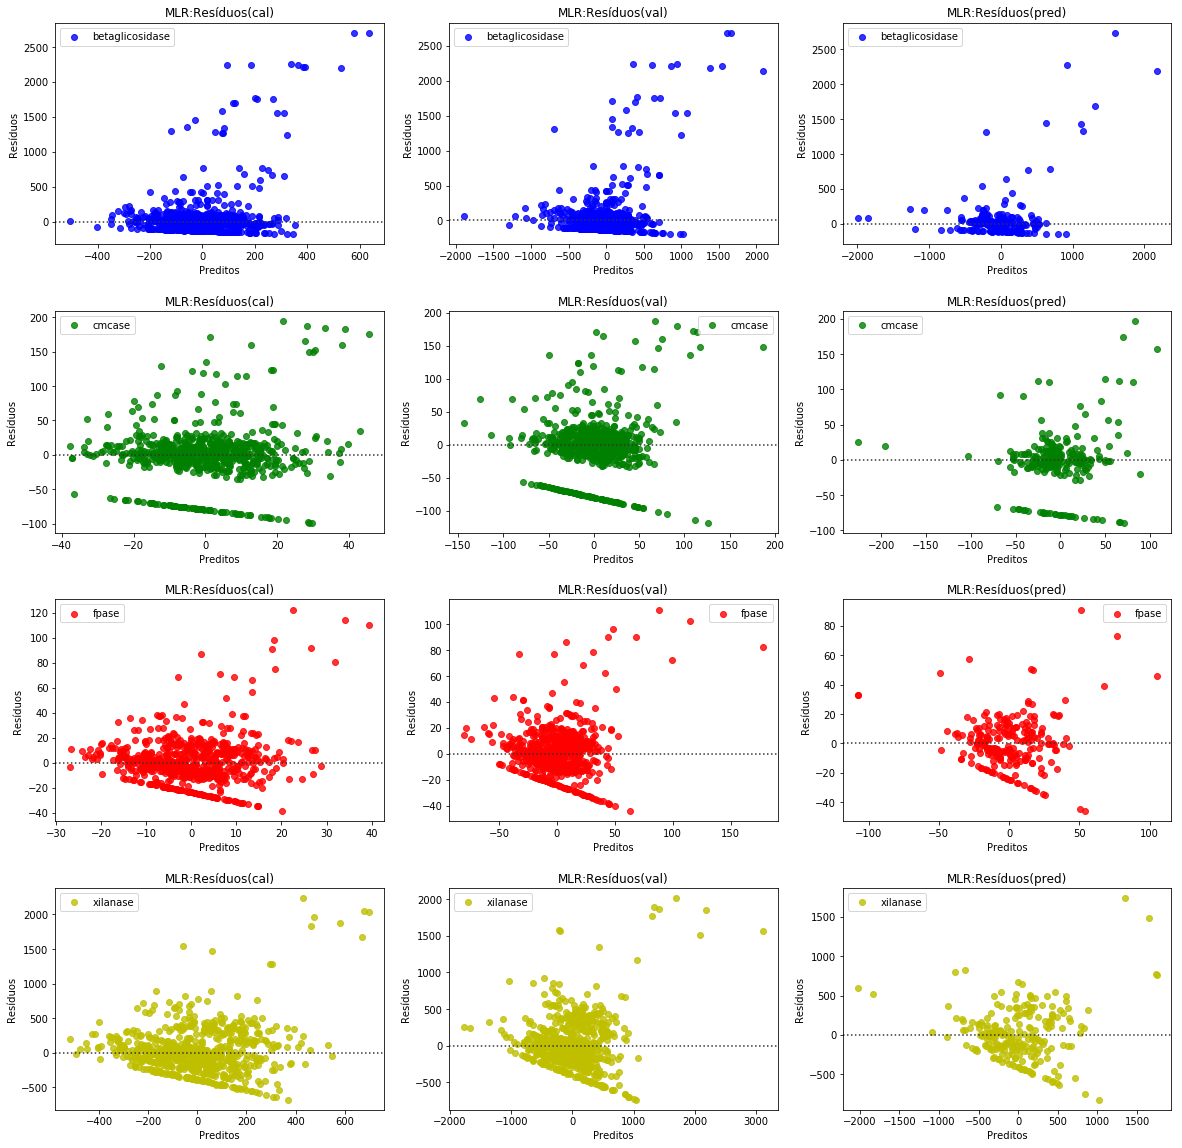

In [398]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

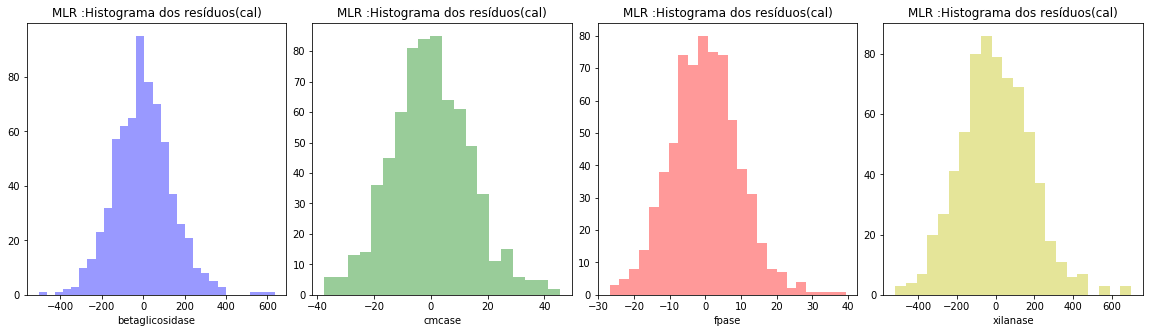

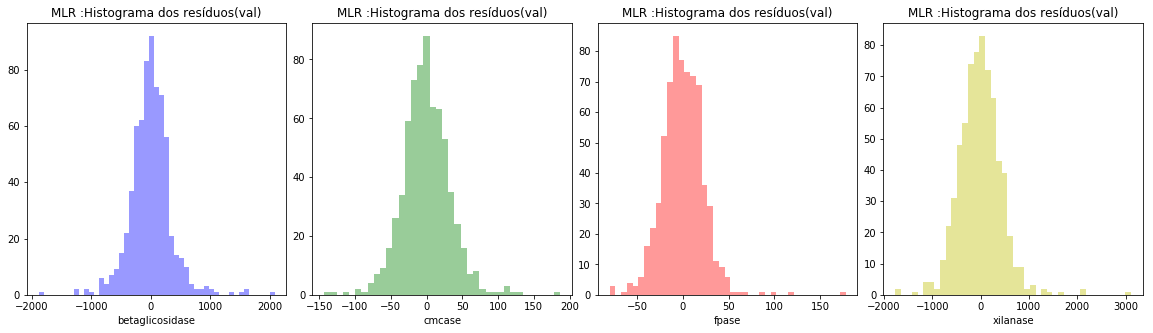

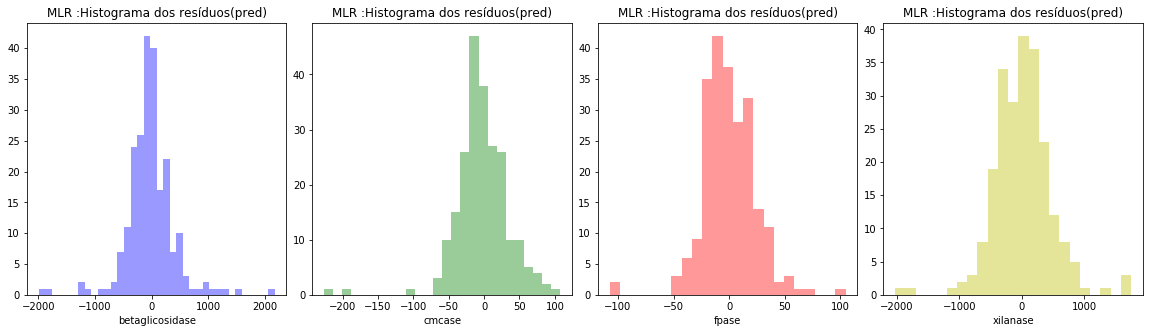

In [399]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

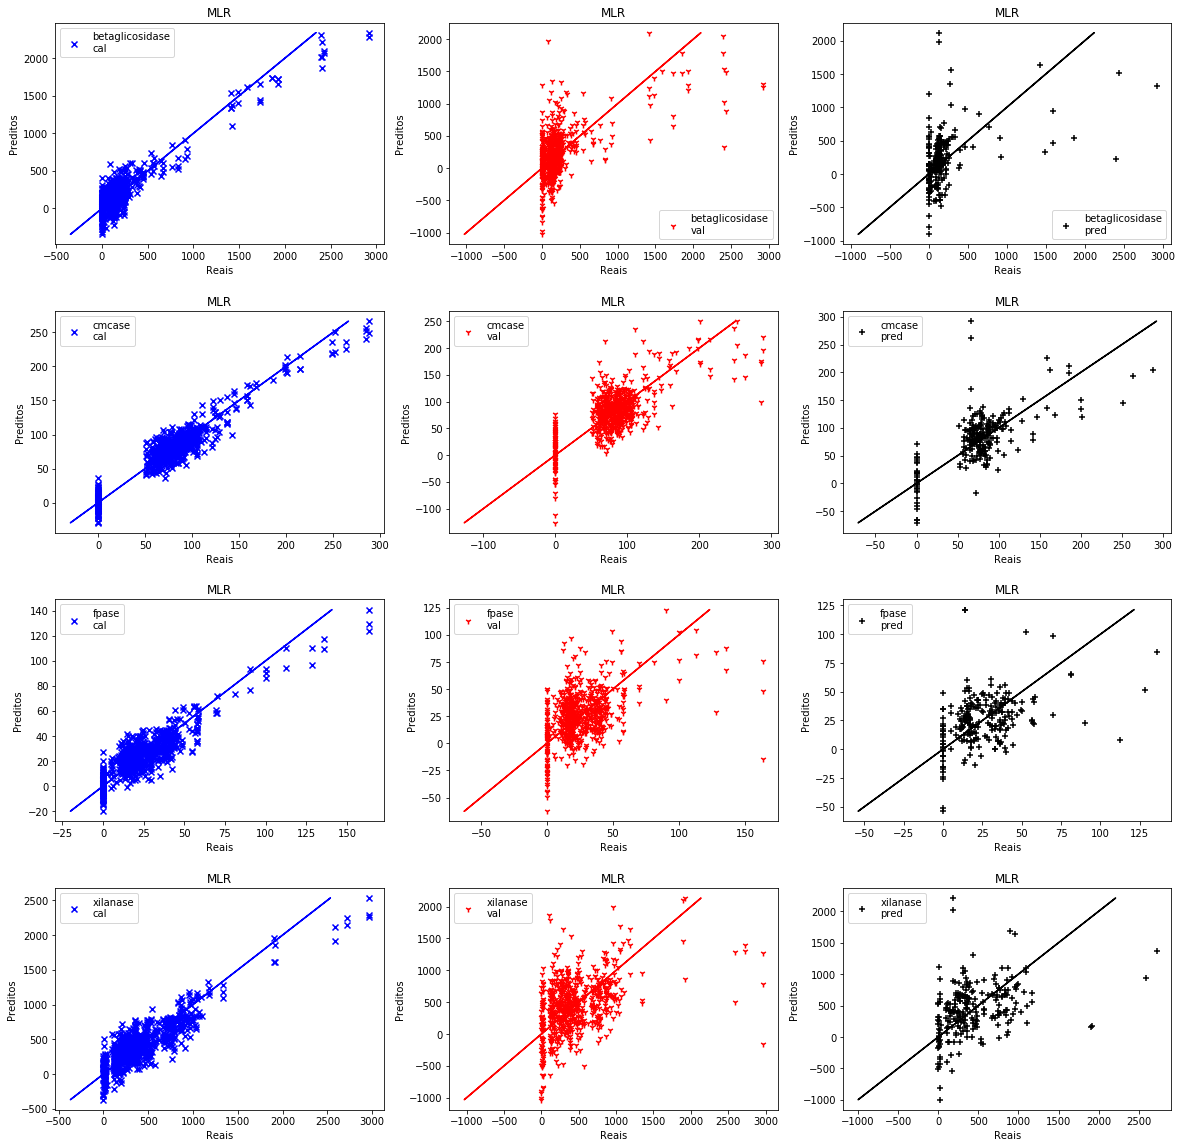

In [400]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

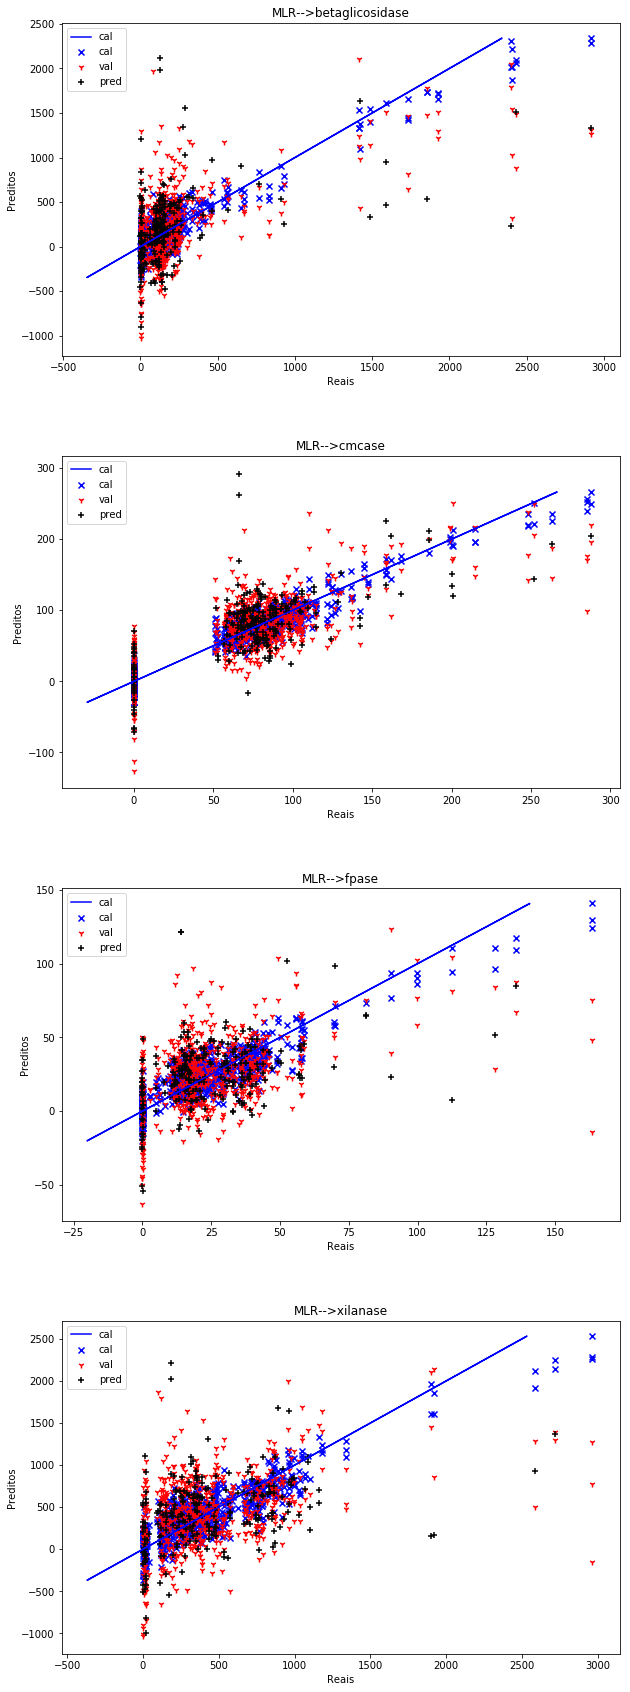

In [401]:
#graico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

# CONFIGURAÇÕES GERAIS:

In [725]:
#@config

#Formatação de fonte nos gráficos
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#fig.tight_layout() #melhorando a visualziação dos gráficos sobrepostos mas muda a fonte
#plt.subplots_adjust(hspace = .5)#ajusta altura entre um gráfico e outro

# Referências

......inlcuir ref
#### Referência para cálculo das medidas: RMSE, RPD e RPIQ
- Prediction of Soil-Available Potassium Content with Visible Near-Infrared Ray Spectroscopy of Different Pretreatment Transformations by the Boosting Algorithms

#### Referência para cálculo de todas as medidas estatísticas : RMSEP, precisão, bias
- ESTADO DA ARTE DE FIGURAS DE MÉRITO EM CALIBRAÇÃO MULTIVARIADA (Quim. Nova, Vol. 32, No. 5, 1278-1287, 2009)

#### RMSEP, SEP, bias, RPD:
- ANÁLISE MULTIVARIADA DE IMAGENS NA QUÍMICA: UM EXPERIMENTO PARA DETERMINAÇÃO DO pH DE ÁGUAS POTÁVEIS
